# K-Prototype with SMOTE

### SeungHeon Han

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import where
import os     
import datetime   
import copy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, log_loss, mean_squared_error, roc_auc_score, roc_curve
from imblearn import under_sampling
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from kmodes.kprototypes import KPrototypes
from pycaret.classification import * 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from scipy.stats import randint
import itertools
import time
import random

# global constants 
ROUND = 3              
NTHREAD = 4
SEED = 1234
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import the cleaned dataset 
%cd /Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB/preprocessed
partB = pd.read_csv("processed_partB.csv")

/Users/alex/Desktop/Master/BA_Practicum_6217_10/Project/dataset/partB/preprocessed


In [4]:
partB = partB.drop("Avg_Mdcr_Stdzd_Amt", axis=1)
partB.head()

NPI                          Type Place_Of_Srvc  Tot_Benes  \
0  1679548440                   Dermatology             O         25   
1  1184730848                      Podiatry             O         15   
2  1700097557          Diagnostic Radiology             F         32   
3  1659528339  Mass Immunizer Roster Biller             O        112   
4  1982966685               Family Practice             O        112   

   Tot_Srvcs  Tot_Bene_Day_Srvcs  Avg_Sbmtd_Chrg  Avg_Mdcr_Alowd_Amt  \
0       46.0                  46      281.000000          128.275435   
1       19.0                  19       18.962105           18.571579   
2       32.0                  32       27.000000            9.387187   
3      114.0                 114        4.940614            4.366404   
4      114.0                 114       35.000000           25.290000   

   Avg_Mdcr_Pymt_Amt  Fraud  
0         100.793043      0  
1          13.215263      0  
2           7.243750      0  
3           4.366404      0  
4          25.290000      0

### Ratio of Fraud and Non-fraud classes 

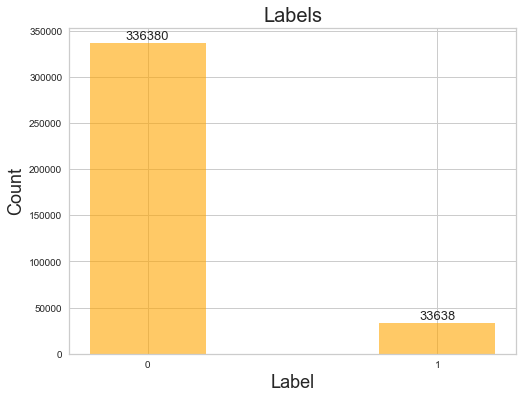

In [5]:
fig = plt.figure(figsize=(8, 6))

# Plot the bar graph
Y_fraud = list(partB["Fraud"].value_counts())
X_fraud = ["0", "1"]

plot = plt.bar(X_fraud, Y_fraud, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Labels", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Count", fontsize = 18)
 
# Display the graph on the screen
plt.show()

In [6]:
ratio = partB["Fraud"].value_counts(normalize = True) 
print("Non-Fraud: ", round(ratio[0]*100, 2), "%")
print("Fraud: ", round(ratio[1]*100, 2), "%")

Non-Fraud:  90.91 %
Fraud:  9.09 %


### Data Spliting

In [7]:
# Assign X and y features

X_var = list(partB.columns)

for var in ["NPI","Fraud"]:
    X_var.remove(var)

y_var = "Fraud"

In [9]:
# Split the whole dataset into train and test dataset
# Using a stratified random sampling so that the Fraud-class (1) data are evenly split into train & test sets
x_train, x_test, y_train, y_test = train_test_split(partB[X_var], 
                                                    partB[y_var], 
                                                    test_size=0.2, 
                                                    stratify=partB["Fraud"],
                                                    random_state=SEED)

# Also concatenate the split x & y dataframes 
tr_df = pd.concat([x_train, y_train], axis = 1)
te_df = pd.concat([x_test, y_test], axis = 1)

In [10]:
# Calculate the odds ratio of Fraud & Non-fraud labels for train & test sets

train_0 = len(tr_df[tr_df["Fraud"] == 0])
train_1 = len(tr_df[tr_df["Fraud"] == 1])

test_0 = len(te_df[te_df["Fraud"] == 0])
test_1 = len(te_df[te_df["Fraud"] == 1])

split_df = pd.DataFrame({"x_axis":["Train", "Test"], 
                         "Ratio":[train_1/train_0, test_1/test_0]})

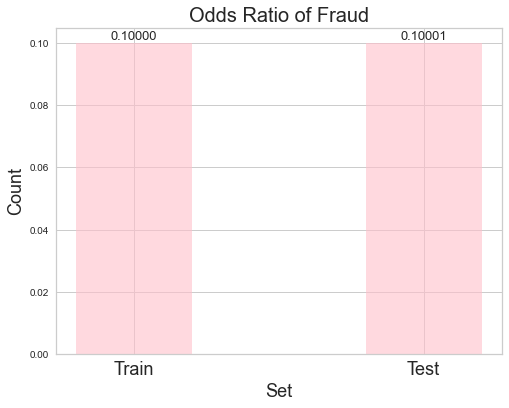

In [11]:
fig, ax = plt.subplots(figsize=(8,6))

# Plot the bar graph
plot = plt.bar(split_df["x_axis"], split_df["Ratio"],
               width = 0.4,
              color = "pink",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%.5f' % height, ha='center', va='bottom', 
             fontsize = 13)
 
# Add labels and title
plt.title("Odds Ratio of Fraud", fontsize = 20)
plt.xlabel("Set", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

ax.set_xticklabels(split_df["x_axis"], fontsize=18)

# Display the graph on the screen
plt.show()

## K-Prototypes To Cluster Train Data

In [12]:
tr_df[X_var].describe()

Tot_Benes     Tot_Srvcs  Tot_Bene_Day_Srvcs  Avg_Sbmtd_Chrg  \
count  296014.000000  2.960140e+05       296014.000000   296014.000000   
mean       96.512428  2.429777e+02          164.646054      336.190290   
std      1299.245038  1.063381e+04         2286.296995      969.423276   
min        11.000000  1.100000e+01           11.000000        0.010000   
25%        18.000000  2.100000e+01           20.000000       60.000000   
50%        33.000000  4.300000e+01           42.000000      143.000000   
75%        79.000000  1.180000e+02          112.000000      290.000000   
max    390496.000000  4.184043e+06       676712.000000    99707.856667   

       Avg_Mdcr_Alowd_Amt  Avg_Mdcr_Pymt_Amt  
count       296014.000000      296014.000000  
mean            99.284117          77.545460  
std            249.200424         198.639412  
min              0.010000           0.000000  
25%             24.376329          19.947915  
50%             65.098976          47.969185  
75%            112.096888          85.971374  
max          24491.300000       19513.390000

In [13]:
from sklearn.preprocessing import StandardScaler
cont_feat = [ele for ele in X_var if ele not in ["Type", "Place_Of_Srvc"]]

scaler = StandardScaler()
scaled_cont = pd.DataFrame(scaler.fit_transform(tr_df[cont_feat]), columns = cont_feat)
scaled_tr_df = pd.concat([scaled_cont, tr_df[["Type", "Place_Of_Srvc", "Fraud"]].reset_index(drop = True)], axis=1)

In [14]:
scaled_tr_df.head()

Tot_Benes  Tot_Srvcs  Tot_Bene_Day_Srvcs  Avg_Sbmtd_Chrg  \
0  -0.064278  -0.021533           -0.065891       -0.051499   
1  -0.043496  -0.018806           -0.053207       -0.297281   
2  -0.053502  -0.016925           -0.044459       -0.217852   
3  -0.037339  -0.017865           -0.048833       -0.073436   
4  -0.035800  -0.014104           -0.031337       -0.037332   

   Avg_Mdcr_Alowd_Amt  Avg_Mdcr_Pymt_Amt               Type Place_Of_Srvc  \
0            0.149622           0.157394         Cardiology             F   
1           -0.326582          -0.300271         Cardiology             O   
2            0.036526           0.030188  Internal Medicine             O   
3            0.127913           0.131266   Medical Oncology             F   
4            0.089734           0.098120          Optometry             O   

   Fraud  
0      0  
1      1  
2      0  
3      0  
4      0

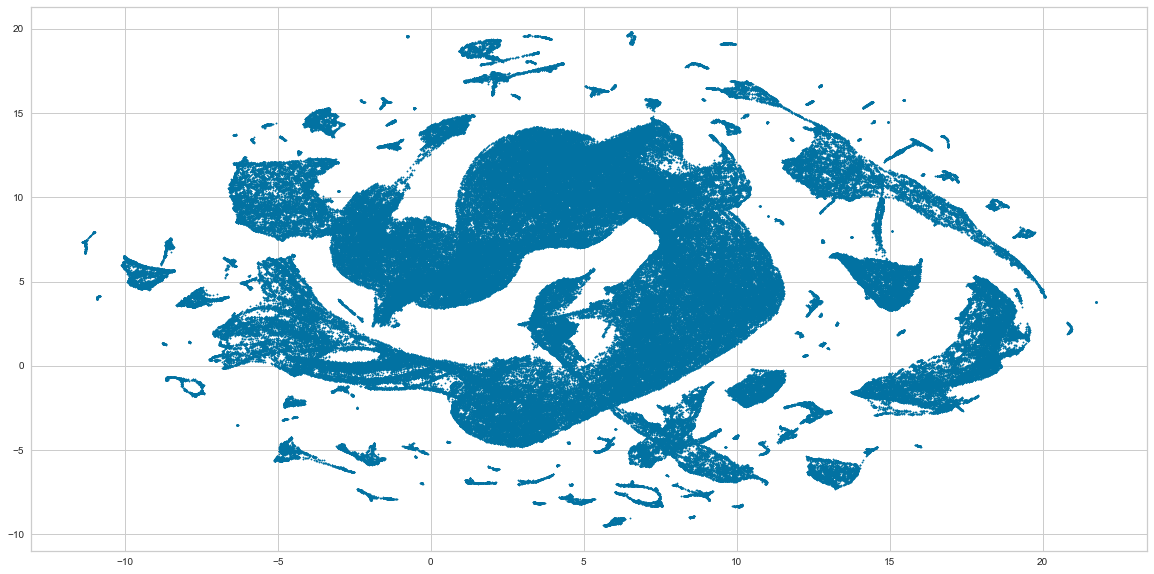

In [109]:
import umap.umap_ as umap

# numerical features
numerical = scaled_tr_df.select_dtypes(exclude='object')
    
# One-Hot encoding categorical features
categorical = scaled_tr_df.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(scaled_tr_df.select_dtypes(include='object').columns) / scaled_tr_df.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)
embedding = umap.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False, fit1._densmap_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding[0].T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

In [16]:
cluster_array = scaled_tr_df.values[:,:-1]

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 5, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/3, moves: 0, ncost: 2220747.841943105
Init: initializing centroid

Starting iterations...
Run: 5, iteration: 1/3, moves: 3796, ncost: 1462664.1014202598
Run: 5, iteration: 2/3, moves: 1571, ncost: 1244042.1639263248
Run: 5, iteration: 3/3, moves: 250, ncost: 1155178.2334025283
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 6, iteration: 1/3, moves: 18483, ncost: 1454513.545199933
Run: 6, iteration: 2/3, moves: 2807, ncost: 1349447.432603553
Run: 6, iteration: 3/3, moves: 3344, ncost: 1276385.0179985447
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 7, iteration: 1/3, moves: 2868, ncost: 1379890.2023070317
Run: 7, iteration: 2/3, moves: 1181, ncost: 1209088.930310502
Run: 7, iteration: 3/3, moves: 303, ncost: 1144939.7855064606
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 8, iteration: 1/3, moves: 14271, ncost: 1532257.32466844
Run: 8, iteration: 2/3, moves: 3739, ncost: 1465933.5435777814
Run: 8, iteration: 3/3, moves: 514, ncost: 132241

Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/3, moves: 36801, ncost: 1477181.2353742407
Run: 10, iteration: 2/3, moves: 49265, ncost: 1403707.255831875
Run: 10, iteration: 3/3, moves: 59483, ncost: 1388736.1176570845
Best run was number 1
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/3, moves: 127245, ncost: 1275959.5274346517
Run: 1, iteration: 2/3, moves: 29494, ncost: 1221532.8427764305
Run: 1, iteration: 3/3, moves: 24431, ncost: 1188321.942243345
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/3, moves: 167421, ncost: 1384465.3664286148
Run: 2, iteration: 2/3, moves: 102946, ncost: 1187359.8435358333
Run: 2, iteration: 3/3, moves: 27419, ncost: 1057833.8370376679
Init: initializing centroids
Init: initializing clusters
Init: initializi

Text(0.5, 1.0, 'Fig : Elbow Diagram')

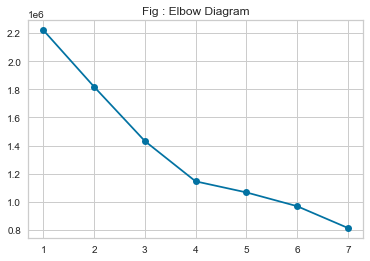

In [110]:
# Finding the Optimal Number of Clusters using Elbow Method
cat_feat_idx = [6,7]
cluster_range = range(1, 8) # We want the clusters to range from 1 to 10
cost = []
for num_clusters in cluster_range:
    clusters = KPrototypes(n_clusters = num_clusters, init='Huang', verbose=2, max_iter=3)
    clusters.fit(cluster_array, categorical=cat_feat_idx)
    cost.append(clusters.cost_)
plt.figure(figsize=(6, 4))
plt.plot(cluster_range, cost, marker = "o");
plt.title("Fig : Elbow Diagram")

In [18]:
# Clustering with the elbow point k = 4
cat_feat_idx = [6,7]
kproto = KPrototypes(n_clusters=4, init='Huang', verbose=2, max_iter=30)
kproto.fit(cluster_array, categorical=cat_feat_idx)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/30, moves: 85190, ncost: 1518188.514768277
Run: 1, iteration: 2/30, moves: 9780, ncost: 1504747.843985207
Run: 1, iteration: 3/30, moves: 6838, ncost: 1481444.4166966577
Run: 1, iteration: 4/30, moves: 15637, ncost: 1423673.2196418494
Run: 1, iteration: 5/30, moves: 16085, ncost: 1343653.866743389
Run: 1, iteration: 6/30, moves: 47650, ncost: 1301537.2504042902
Run: 1, iteration: 7/30, moves: 6103, ncost: 1297257.9532985233
Run: 1, iteration: 8/30, moves: 7098, ncost: 1296015.5409284977
Run: 1, iteration: 9/30, moves: 6115, ncost: 1295464.8912403802
Run: 1, iteration: 10/30, moves: 3992, ncost: 1295259.5668304972
Run: 1, iteration: 11/30, moves: 2518, ncost: 1295190.5394597363
Run: 1, iteration: 12/30, moves: 1635, ncost: 1295164.4889093526
Run: 1, iteration: 13/30, moves: 1

Starting iterations...
Run: 7, iteration: 1/30, moves: 8101, ncost: 1423968.0639649604
Run: 7, iteration: 2/30, moves: 3695, ncost: 1263102.120760761
Run: 7, iteration: 3/30, moves: 1509, ncost: 1157535.2318280346
Run: 7, iteration: 4/30, moves: 2243, ncost: 1069219.1908209086
Run: 7, iteration: 5/30, moves: 1848, ncost: 995403.6264354292
Run: 7, iteration: 6/30, moves: 1183, ncost: 975548.1417731354
Run: 7, iteration: 7/30, moves: 659, ncost: 973670.9860551618
Run: 7, iteration: 8/30, moves: 339, ncost: 973289.3339510339
Run: 7, iteration: 9/30, moves: 173, ncost: 973193.0197109379
Run: 7, iteration: 10/30, moves: 105, ncost: 973169.2366896592
Run: 7, iteration: 11/30, moves: 61, ncost: 973160.935572537
Run: 7, iteration: 12/30, moves: 41, ncost: 973157.2910970817
Run: 7, iteration: 13/30, moves: 11, ncost: 973156.9966727213
Run: 7, iteration: 14/30, moves: 2, ncost: 973156.9835298089
Run: 7, iteration: 15/30, moves: 1, ncost: 973156.980452667
Run: 7, iteration: 16/30, moves: 0, ncost

KPrototypes(gamma=0.5, init='Huang', max_iter=30, n_clusters=4, verbose=2)

In [19]:
print(kproto.cluster_centroids_)

[['-0.04440997956646248' '-0.017961523057869057' '-0.050847209172454305'
  '4.4287960409361' '3.648545618833158' '3.6483729712435853'
  'Orthopedic Surgery' 'F']
 ['-0.00430466664697956' '-0.003822149677029422' '-0.004294629468819365'
  '-0.08283747867143858' '-0.07340381942633517' '-0.07341421919554905'
  'Internal Medicine' 'O']
 ['-0.03839335481701374' '-0.017337298633100993' '-0.046412162027867354'
  '29.671741777026273' '45.00748103936432' '45.04508398114488'
  'Ambulatory Surgical Center' 'O']
 ['98.35648115188465' '80.15903625687072' '100.32680585797497'
  '-0.19372616881591434' '-0.13233103014345146' '-0.056576159676489206'
  'Clinical Laboratory' 'O']]


In [20]:
# clustering
clusters = kproto.predict(cluster_array, categorical=cat_feat_idx)
scaled_tr_df['clusterid'] = list(clusters)

scaled_tr_df['clusterid'].value_counts()

1    290972
0      4954
2        73
3        15
Name: clusterid, dtype: int64

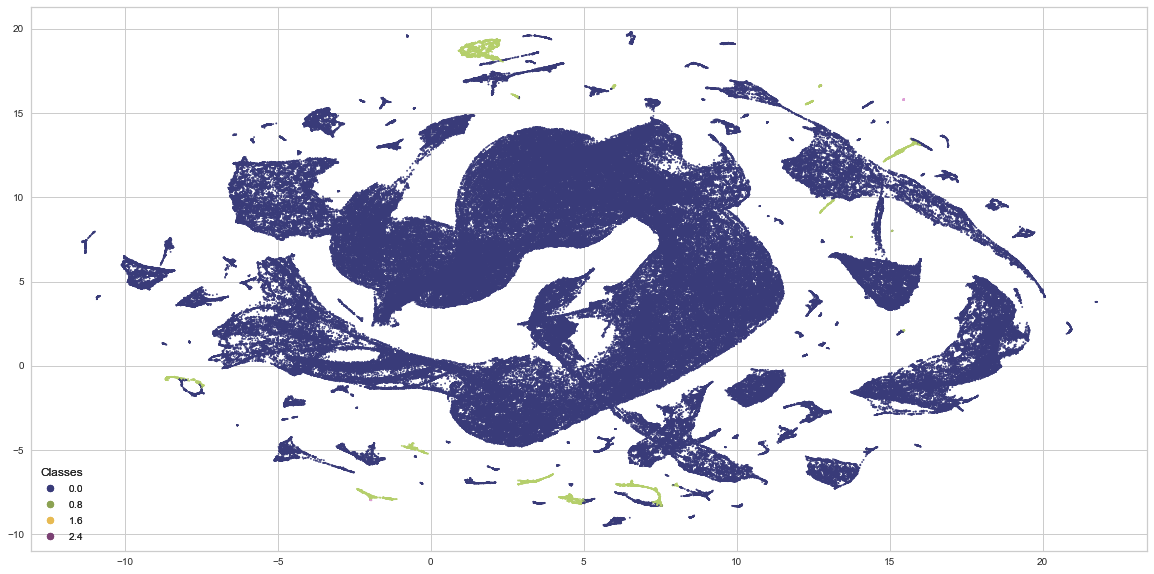

In [116]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[0][:, 0], embedding[0][:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=4),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [22]:
cluster0 = scaled_tr_df.loc[scaled_tr_df.clusterid == 0, "Fraud"].value_counts()
cluster0_ratio = np.round((cluster0.tolist()[1]/cluster0.tolist()[0])*100, 2)

cluster1 = scaled_tr_df.loc[scaled_tr_df.clusterid == 1, "Fraud"].value_counts()
cluster1_ratio = np.round((cluster1.tolist()[1]/cluster1.tolist()[0])*100, 2)

cluster2 = scaled_tr_df.loc[scaled_tr_df.clusterid == 2, "Fraud"].value_counts()
cluster2_ratio = np.round((cluster2.tolist()[1]/cluster2.tolist()[0])*100, 2)

cluster3 = scaled_tr_df.loc[scaled_tr_df.clusterid == 3, "Fraud"].value_counts()
cluster3_ratio = np.round((cluster3.tolist()[1]/cluster3.tolist()[0])*100, 2)

print(f'Cluster 0: \n {cluster0} \n Ratio btw 1 and 0: {cluster0_ratio}%')
print(f'\n\n Cluster 1: \n {cluster1} \n Ratio btw 1 and 0: {cluster1_ratio}%')
print(f'\n\n Cluster 2: \n {cluster2} \n Ratio btw 1 and 0: {cluster2_ratio}%')
print(f'\n\n Cluster 3: \n {cluster3} \n Ratio btw 1 and 0: {cluster3_ratio}%')

Cluster 0: 
 0    4682
1     272
Name: Fraud, dtype: int64 
 Ratio btw 1 and 0: 5.81%


 Cluster 1: 
 0    264361
1     26611
Name: Fraud, dtype: int64 
 Ratio btw 1 and 0: 10.07%


 Cluster 2: 
 0    51
1    22
Name: Fraud, dtype: int64 
 Ratio btw 1 and 0: 43.14%


 Cluster 3: 
 0    10
1     5
Name: Fraud, dtype: int64 
 Ratio btw 1 and 0: 50.0%


* SMOTE the minority group belonging to Clusterid 2,3

## Compute the sampling weight based on its minority density
### Sampling Weight for each cluster f
* average distance(f) = mean(Euclidean distance) but I use Gower
* density factor(f) = minority count(f) / average distance(f) 
* sparsity factor(f) = 1/density factor(f)
* sampling weight(f) = sparsity factor(f)/sum(all sparsity factors)

### SMOTE Strategy
* sampling weight(f) x n 
* n = overall number of synthetic data to be generated

In [23]:
tr_df['clusterid'] = list(clusters)

In [24]:
f2 = tr_df[(tr_df.clusterid == 2)&(tr_df.Fraud == 1)]
f3 = tr_df[(tr_df.clusterid == 3)&(tr_df.Fraud == 1)]

In [25]:
cat_feat = ['Type', 'Place_Of_Srvc']

In [281]:
# Euclidean + Hamming 
def avg_distance(df, cont, cat):
    euclidean = []
    hamming = []
    dist_list = []
    
    cont_array = df[cont].to_numpy()
    for i in combinations(range(cont_array.shape[0]), 2):
        euclidean.append(cont_array[i[0]]-cont_array[i[1]])
    
                          
    cat_df = pd.get_dummies(df[cat], drop_first=True)
    cat_array = cat_df.to_numpy()
    for j in combinations(range(cat_array.shape[0]), 2):
        subtract = abs(cat_array[i[0]].astype('int') - cat_array[i[1]].astype('int'))
        hamming.append(np.sum(subtract))
                          
    euclidean = np.array(euclidean)
    hamming = np.array(hamming).reshape(-1,1)
    
    concat_array = np.concatenate((euclidean, hamming), axis=1)                   
    
    scaler = StandardScaler()
    scaled_dist = scaler.fit_transform(concat_array)
    
    for e in range(scaled_dist.shape[0]):
        dist_list.append(np.sqrt(np.sum(np.square(scaled_dist[e]))))
    
    avg_dist = np.mean(dist_list)
    
    return avg_dist

In [28]:
# Gower
def gower(df, cont, cat):
    maximum = df[cont_feat].describe().max()
    minimum = df[cont_feat].describe().min()
    range_array = np.array(maximum - minimum)
    
    cont_diff = []
    cat_diff = []
    
    cont_array = df[cont].to_numpy()
    for i in combinations(range(cont_array.shape[0]), 2):
        cont_diff.append(abs((cont_array[i[0]] - cont_array[i[1]])/range_array))
    
    cat_df = pd.get_dummies(df[cat], drop_first=True)
    cat_array = cat_df.to_numpy()
    for j in combinations(range(cat_array.shape[0]),2):
        cat_diff.append(np.sum(np.abs(cat_array[j[0]].astype('int') - cat_array[j[1]].astype('int'))))
    
    cont_diff = np.asarray(cont_diff)
    cat_diff = np.array(cat_diff).reshape(-1,1)
    concat_array = np.concatenate((cont_diff, cat_diff), axis=1)
    
    # list of Gower distance
    gower_list = [np.mean(concat_array[e]) for e in range(len(concat_array))]
        
    # Average distance
    avg_dist = np.mean(gower_list)
        
    return avg_dist

In [173]:
from itertools import combinations
# compute sparsity factor by f
sparsity2 = 1/(len(f2)/gower(f2, cont_feat, cat_feat))
sparsity3 = 1/(len(f3)/gower(f3, cont_feat, cat_feat))

weight2 = sparsity2/(sparsity2+sparsity3)
weight3 = sparsity3/(sparsity2+sparsity3)

In [174]:
# compute n
major_60prc = len(tr_df[tr_df.Fraud == 0])*0.6
n = major_60prc-len(tr_df[tr_df.Fraud == 1])

# Specify the number of minority data to be generated for each cluster 
smote_n2 = int(weight2*n)
smote_n3 = int(weight3*n)

In [181]:
f2_new = tr_df[tr_df.clusterid == 2]
f3_new = tr_df[tr_df.clusterid == 3]

In [182]:
f2_encode_list = [dict(zip(f2_new['Type'].unique(), range(len(f2_new['Type'].unique())))), 
                  dict(zip(f2_new['Place_Of_Srvc'].unique(), range(len(f2_new['Place_Of_Srvc'].unique()))))]
f3_encode_list = [dict(zip(f3_new['Type'].unique(), range(len(f3_new['Type'].unique())))), 
                  dict(zip(f3_new['Place_Of_Srvc'].unique(), range(len(f3_new['Place_Of_Srvc'].unique()))))]

In [183]:
f2_new['Type'] = f2_new['Type'].map(f2_encode_list[0])
f2_new['Place_Of_Srvc'] = f2_new['Place_Of_Srvc'].map(f2_encode_list[1])
f3_new['Type'] = f3_new['Type'].map(f3_encode_list[0])
f3_new['Place_Of_Srvc'] = f3_new['Place_Of_Srvc'].map(f3_encode_list[1])

In [184]:
f2_new = f2_new.astype({'Type': 'uint8', 'Place_Of_Srvc': 'uint8'})
f3_new = f3_new.astype({'Type': 'uint8', 'Place_Of_Srvc': 'uint8'})

## SMOTE

### Scatter Plot of The Imbalanced Data

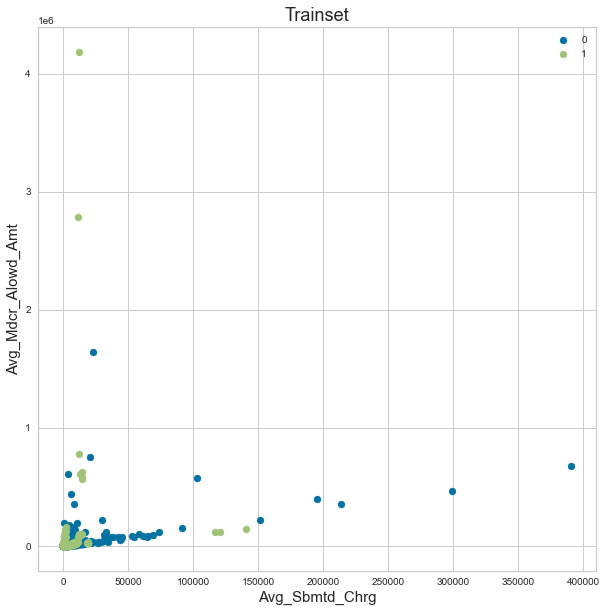

In [138]:
# scatter plot of the imbalanced data
# x-axis = "Tot_Benes_mean"
# y-axis = "Tot_Bene_Day_Srvcs_mean"

plt.figure(figsize=(10, 10))

counter = Counter(tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(tr_df[y_var] == label)[0]
    plt.scatter(tr_df[X_var].iloc[row_ix, 2], 
                tr_df[X_var].iloc[row_ix, 3], 
                label=str(label))

plt.title("Trainset", fontsize = 18)
plt.xlabel("Avg_Sbmtd_Chrg", fontsize = 15)
plt.ylabel("Avg_Mdcr_Alowd_Amt", fontsize = 15)
plt.legend()
plt.show()

### SMOTE

In [185]:
# SMOTE the minority class in Cluster2
oversample_f2 = over_sampling.SMOTE(sampling_strategy = {1:smote_n2}, k_neighbors=4, random_state = SEED)
f2_X, f2_y = oversample_f2.fit_resample(f2_new[X_var], f2_new[y_var])

# SMOTE the minority class in Cluster3
oversample_f3 = over_sampling.SMOTE(sampling_strategy = {1:smote_n3}, k_neighbors=4, random_state = SEED)
f3_X, f3_y = oversample_f3.fit_resample(f3_new[X_var], f3_new[y_var])

In [186]:
smote_f2 = pd.concat([f2_X, f2_y], axis=1)
smote_f3 = pd.concat([f3_X, f3_y], axis=1)

In [187]:
f2_inv_list = [dict([(val, key) for key, val in f2_encode_list[0].items()]), 
              dict([(val, key) for key, val in f2_encode_list[1].items()])]
f3_inv_list = [dict([(val, key) for key, val in f3_encode_list[0].items()]), 
               dict([(val, key) for key, val in f3_encode_list[1].items()])]

smote_f2['Type'] = smote_f2['Type'].map(f2_inv_list[0])
smote_f2['Place_Of_Srvc'] = smote_f2['Place_Of_Srvc'].map(f2_inv_list[1])
smote_f3['Type'] = smote_f3['Type'].map(f3_inv_list[0])
smote_f3['Place_Of_Srvc'] = smote_f3['Place_Of_Srvc'].map(f3_inv_list[1])

In [209]:
# Drop the rows matching to cluster 2 and 3 and then drop clusterid column
smote_tr_df = tr_df.drop(tr_df[tr_df['clusterid'].isin([2,3])].index, axis=0).drop("clusterid", axis=1)

In [211]:
# Concatenate the oversampled clusters (2 & 3) with the smote_tr_df
smote_tr_df = pd.concat([smote_tr_df, smote_f2, smote_f3], axis=0)

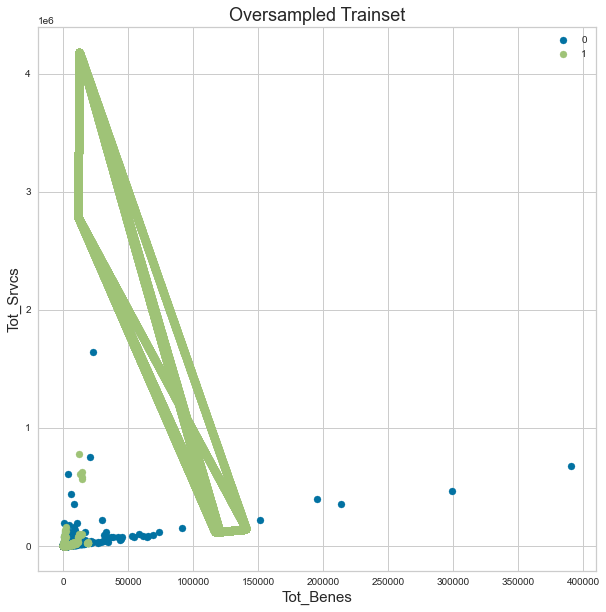

In [215]:
# scatter plot of the oversampled data
# x-axis = "Tot_Benes"
# y-axis = "Tot_Srvcs"

plt.figure(figsize=(10, 10))

counter = Counter(smote_tr_df[y_var])
for label, _ in counter.items():
    row_ix = where(smote_tr_df[y_var] == label)[0]
    plt.scatter(smote_tr_df[X_var].iloc[row_ix, 2], 
                smote_tr_df[X_var].iloc[row_ix, 3], 
                label=str(label))

plt.title("Oversampled Trainset", fontsize = 18)
plt.xlabel("Tot_Benes", fontsize = 15)
plt.ylabel("Tot_Srvcs", fontsize = 15)
plt.legend()
plt.show()

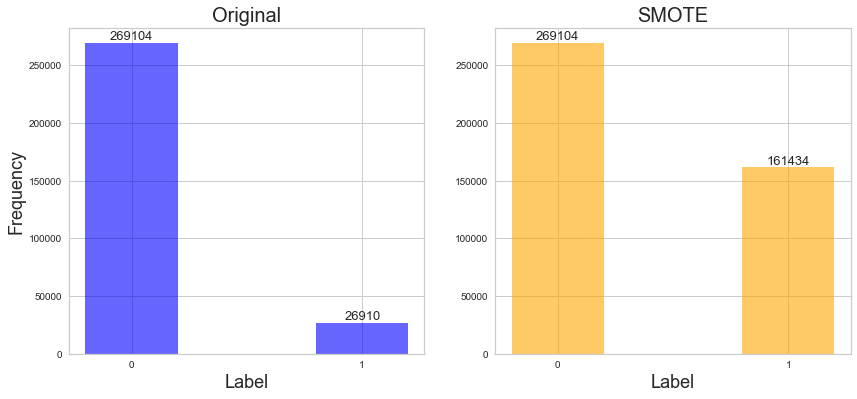

In [216]:
plt.figure(figsize=(14, 6))
plt.subplot(121)

# Plot the bar graph for the original train
Y_fraud = list(tr_df[y_var].value_counts())
Labels = ["0", "1"]

plot = plt.bar(Labels, Y_fraud, 
               width = 0.4,
              color = "blue",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("Original", fontsize = 20)
plt.xlabel("Label", fontsize = 18)
plt.ylabel("Frequency", fontsize = 18)


plt.subplot(122)

# Plot the bar graph for the over-sampled train
Y_fraud_smote = list(smote_tr_df[y_var].value_counts())

plot_smote = plt.bar(Labels, Y_fraud_smote, 
               width = 0.4,
              color = "orange",
              alpha = 0.6)
 
# Add the data value on head of the bar
for value in plot_smote:
    height = value.get_height()
    plt.text(value.get_x() + value.get_width()/2.,
             1.002*height,'%d' % int(height), ha='center', va='bottom', 
             fontsize = 13)

# Add labels and title
plt.title("SMOTE", fontsize = 20)
plt.xlabel("Label", fontsize = 18)

# Display the graph on the screen
plt.show()

## Model Training 

## PyCaret

In [218]:
train = setup(data = smote_tr_df, target = "Fraud")

KeyError: 'dashboard_logger'

In [219]:
best = compare_models(['rf', 'et', 'catboost', 'xgboost', 'dt', 'lightgbm', 'knn'])

/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/envs/pycaret_model_comp/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

In [220]:
print(best)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1477, verbose=0,
                       warm_start=False)


In [221]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

### Data Partitioning (Train & Valid)

In [222]:
# Split train and validation sets 
np.random.seed(SEED)

ratio = 0.8 # split train & validation sets with 7:3 ratio 

split = np.random.rand(len(smote_tr_df)) < ratio # define indices of 70% corresponding to the training set

train = smote_tr_df[split]
valid = smote_tr_df[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Train data rows = 344807, columns = 9
Validation data rows = 85731, columns = 9


### Random Forest

In [224]:
encoded_train = pd.get_dummies(train, drop_first=True)
encoded_valid = pd.get_dummies(train, drop_first=True)

encoded_train.rename(columns = {"Place_Of_Srvc_O":"Place_Of_Srvc"}, inplace=True)
encoded_valid.rename(columns = {"Place_Of_Srvc_O":"Place_Of_Srvc"}, inplace=True)

In [231]:
X_feat = [ele for ele in encoded_train.columns if ele != 'Fraud']

In [406]:
params = {'min_samples_split':[2, 5],
          'min_samples_leaf':[1,5],
          'max_depth':[7, 10, None],  
          'verbose':[200],
          'random_state':[SEED]}

In [409]:
X_feat = encoded_train.columns.to_list()
X_feat.remove("Fraud")

rf = RandomizedSearchCV(RandomForestClassifier(), params, cv=3, n_iter=10)
rf.fit(encoded_train[X_feat], encoded_train[y_var])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.1s remaining: 

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   11.1s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.3s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   11.4s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   11.5s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   11.7s remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   11.9s remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   12.0s remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   12.1s remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   12.3s remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   12.4s rem

[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
building tree 2 of 100
[Pa

[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   10.1s remaining:    0.0s
building tree 74 of 100
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   10.2s remaining:    0.0s
building tree 75 of 100
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   10.3s remaining:    0.0s
building tree 76 of 100
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   10.5s remaining:    0.0s
building tree 77 of 100
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   10.7s remaining:    0.0s
building tree 78 of 100
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   10.8s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   10.9s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.1s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   11.2s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   11.3s rem

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
bui

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   10.4s remaining:    0.0s
building tree 75 of 100
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   10.5s remaining:    0.0s
building tree 76 of 100
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   10.7s remaining:    0.0s
building tree 77 of 100
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   10.9s remaining:    0.0s
building tree 78 of 100
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   11.0s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   11.2s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.3s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   11.5s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   11.6s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   11.7s rem

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  93 out of  9

[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   12.1s remaining:    0.0s
building tree 64 of 100
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   12.3s remaining:    0.0s
building tree 65 of 100
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   12.5s remaining:    0.0s
building tree 66 of 100
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:   12.7s remaining:    0.0s
building tree 67 of 100
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:   12.9s remaining:    0.0s
building tree 68 of 100
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   13.1s remaining:    0.0s
building tree 69 of 100
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   13.3s remaining:    0.0s
building tree 70 of 100
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   13.5s remaining:    0.0s
building tree 71 of 100
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   13.7s remaining:    0.0s
building tree 72 of 100
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   13.9s rem

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  8

[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   11.1s remaining:    0.0s
building tree 57 of 100
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   11.3s remaining:    0.0s
building tree 58 of 100
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   11.5s remaining:    0.0s
building tree 59 of 100
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   11.8s remaining:    0.0s
building tree 60 of 100
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.9s remaining:    0.0s
building tree 61 of 100
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   12.2s remaining:    0.0s
building tree 62 of 100
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   12.4s remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   12.6s remaining:    0.0s
building tree 64 of 100
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   12.8s remaining:    0.0s
building tree 65 of 100
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   12.9s rem

[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  5

[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    6.4s remaining:    0.0s
building tree 34 of 100
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    6.6s remaining:    0.0s
building tree 35 of 100
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    6.9s remaining:    0.0s
building tree 36 of 100
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    7.2s remaining:    0.0s
building tree 37 of 100
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    7.4s remaining:    0.0s
building tree 38 of 100
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    7.6s remaining:    0.0s
building tree 39 of 100
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    7.9s remaining:    0.0s
building tree 40 of 100
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    8.0s remaining:    0.0s
building tree 41 of 100
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    8.2s remaining:    0.0s
building tree 42 of 100
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    8.4s rem

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  2

[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    2.7s remaining:    0.0s
building tree 15 of 100
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    2.9s remaining:    0.0s
building tree 16 of 100
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    3.1s remaining:    0.0s
building tree 17 of 100
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.3s remaining:    0.0s
building tree 18 of 100
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.4s remaining:    0.0s
building tree 19 of 100
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.6s remaining:    0.0s
building tree 20 of 100
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.8s remaining:    0.0s
building tree 21 of 100
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.0s remaining:    0.0s
building tree 22 of 100
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.2s remaining:    0.0s
building tree 23 of 100
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    4.4s rem

[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   18.3s remaining:    0.0s
building tree 94 of 100
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:   18.5s remaining:    0.0s
building tree 95 of 100
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:   18.7s remaining:    0.0s
building tree 96 of 100
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   18.9s remaining:    0.0s
building tree 97 of 100
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:   19.1s remaining:    0.0s
building tree 98 of 100
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:   19.3s remaining:    0.0s
building tree 99 of 100
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:   19.5s remaining:    0.0s
building tree 100 of 100
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   19.8s finished
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory sem

[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.8s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.2s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elap

[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   15.4s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   15.6s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   15.8s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   16.0s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   16.2s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   16.3s remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   16.5s remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   16.8s remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   16.9s remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   17.1s rem

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   14.6s remaining:    0.0s
building tree 75 of 100
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   14.8s remaining:    0.0s
building tree 76 of 100
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   15.0s remaining:    0.0s
building tree 77 of 100
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   15.2s remaining:    0.0s
building tree 78 of 100
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   15.4s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   15.6s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   15.8s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   16.0s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   16.2s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   16.4s rem

[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  8

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    7.5s remaining:    0.0s
building tree 55 of 100
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    7.7s remaining:    0.0s
building tree 56 of 100
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    7.8s remaining:    0.0s
building tree 57 of 100
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    7.9s remaining:    0.0s
building tree 58 of 100
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    8.0s remaining:    0.0s
building tree 59 of 100
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    8.2s remaining:    0.0s
building tree 60 of 100
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.4s remaining:    0.0s
building tree 61 of 100
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    8.5s remaining:    0.0s
building tree 62 of 100
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    8.7s remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    8.8s rem

[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  6

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    5.9s remaining:    0.0s
building tree 44 of 100
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    6.1s remaining:    0.0s
building tree 45 of 100
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.2s remaining:    0.0s
building tree 46 of 100
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    6.3s remaining:    0.0s
building tree 47 of 100
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    6.5s remaining:    0.0s
building tree 48 of 100
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.6s remaining:    0.0s
building tree 49 of 100
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    6.8s remaining:    0.0s
building tree 50 of 100
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.9s remaining:    0.0s
building tree 51 of 100
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    7.1s remaining:    0.0s
building tree 52 of 100
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    7.2s rem

[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  6

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.6s remaining:    0.0s
building tree 41 of 100
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    5.8s remaining:    0.0s
building tree 42 of 100
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    6.0s remaining:    0.0s
building tree 43 of 100
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    6.1s remaining:    0.0s
building tree 44 of 100
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    6.3s remaining:    0.0s
building tree 45 of 100
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.4s remaining:    0.0s
building tree 46 of 100
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    6.6s remaining:    0.0s
building tree 47 of 100
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    6.7s remaining:    0.0s
building tree 48 of 100
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.9s remaining:    0.0s
building tree 49 of 100
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    7.0s rem

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  3

[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   13.6s remaining:    0.0s
building tree 18 of 100
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   14.4s remaining:    0.0s
building tree 19 of 100
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:   15.2s remaining:    0.0s
building tree 20 of 100
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   16.0s remaining:    0.0s
building tree 21 of 100
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:   16.7s remaining:    0.0s
building tree 22 of 100
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:   17.5s remaining:    0.0s
building tree 23 of 100
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:   18.4s remaining:    0.0s
building tree 24 of 100
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   19.2s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   20.1s remaining:    0.0s
building tree 26 of 100
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   20.9s rem

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.3min remaining:    0.0s
building tree 97 of 100
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:  1.3min remaining:    0.0s
building tree 98 of 100
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  1.3min remaining:    0.0s
building tree 99 of 100
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  1.3min remaining:    0.0s
building tree 100 of 100
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.3min finished
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s re

[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.5s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
building tree 

[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   56.7s remaining:    0.0s
building tree 77 of 100
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   57.5s remaining:    0.0s
building tree 78 of 100
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   58.3s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   59.1s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   59.8s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:  1.0min remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:  1.0min remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:  1.0min remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:  1.0min remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:  1.1min rem

[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  8

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   41.3s remaining:    0.0s
building tree 55 of 100
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   42.0s remaining:    0.0s
building tree 56 of 100
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   42.8s remaining:    0.0s
building tree 57 of 100
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:   43.6s remaining:    0.0s
building tree 58 of 100
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:   44.4s remaining:    0.0s
building tree 59 of 100
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:   45.2s remaining:    0.0s
building tree 60 of 100
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   45.9s remaining:    0.0s
building tree 61 of 100
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   46.8s remaining:    0.0s
building tree 62 of 100
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   47.5s remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   48.2s rem

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  5

[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    4.6s remaining:    0.0s
building tree 35 of 100
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    4.8s remaining:    0.0s
building tree 36 of 100
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.9s remaining:    0.0s
building tree 37 of 100
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    5.1s remaining:    0.0s
building tree 38 of 100
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    5.2s remaining:    0.0s
building tree 39 of 100
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    5.4s remaining:    0.0s
building tree 40 of 100
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    5.5s remaining:    0.0s
building tree 41 of 100
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    5.6s remaining:    0.0s
building tree 42 of 100
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    5.8s remaining:    0.0s
building tree 43 of 100
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    5.9s rem

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  3

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.0s remaining:    0.0s
building tree 17 of 100
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    2.1s remaining:    0.0s
building tree 18 of 100
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    2.2s remaining:    0.0s
building tree 19 of 100
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    2.3s remaining:    0.0s
building tree 20 of 100
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    2.5s remaining:    0.0s
building tree 21 of 100
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    2.6s remaining:    0.0s
building tree 22 of 100
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    2.7s remaining:    0.0s
building tree 23 of 100
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    2.9s remaining:    0.0s
building tree 24 of 100
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.0s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.2s rem

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   13.1s remaining:    0.0s
building tree 97 of 100
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:   13.2s remaining:    0.0s
building tree 98 of 100
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:   13.4s remaining:    0.0s
building tree 99 of 100
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:   13.5s remaining:    0.0s
building tree 100 of 100
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.7s finished
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s re

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.5s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.8s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.9s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.0s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.2s remaining: 

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   11.1s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   11.2s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   11.3s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   11.5s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   11.6s remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   11.8s remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   11.9s remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   12.0s remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   12.2s remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   12.3s rem

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  91 out of  9

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    8.6s remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    8.7s remaining:    0.0s
building tree 64 of 100
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    8.9s remaining:    0.0s
building tree 65 of 100
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    9.0s remaining:    0.0s
building tree 66 of 100
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    9.1s remaining:    0.0s
building tree 67 of 100
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    9.2s remaining:    0.0s
building tree 68 of 100
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    9.4s remaining:    0.0s
building tree 69 of 100
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    9.5s remaining:    0.0s
building tree 70 of 100
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    9.7s remaining:    0.0s
building tree 71 of 100
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    9.8s rem

[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  6

[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    5.5s remaining:    0.0s
building tree 42 of 100
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:    5.6s remaining:    0.0s
building tree 43 of 100
[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:    5.8s remaining:    0.0s
building tree 44 of 100
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:    5.9s remaining:    0.0s
building tree 45 of 100
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:    6.0s remaining:    0.0s
building tree 46 of 100
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:    6.2s remaining:    0.0s
building tree 47 of 100
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:    6.3s remaining:    0.0s
building tree 48 of 100
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    6.4s remaining:    0.0s
building tree 49 of 100
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:    6.6s remaining:    0.0s
building tree 50 of 100
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.7s rem

[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  4

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.2s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    3.4s remaining:    0.0s
building tree 26 of 100
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    3.6s remaining:    0.0s
building tree 27 of 100
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.7s remaining:    0.0s
building tree 28 of 100
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    3.8s remaining:    0.0s
building tree 29 of 100
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    4.0s remaining:    0.0s
building tree 30 of 100
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    4.1s remaining:    0.0s
building tree 31 of 100
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    4.2s remaining:    0.0s
building tree 32 of 100
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    4.3s remaining:    0.0s
building tree 33 of 100
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    4.5s rem

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  3

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    2.9s remaining:    0.0s
building tree 17 of 100
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    3.1s remaining:    0.0s
building tree 18 of 100
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    3.2s remaining:    0.0s
building tree 19 of 100
[Parallel(n_jobs=1)]: Done  19 out of  19 | elapsed:    3.4s remaining:    0.0s
building tree 20 of 100
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    3.6s remaining:    0.0s
building tree 21 of 100
[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    3.8s remaining:    0.0s
building tree 22 of 100
[Parallel(n_jobs=1)]: Done  22 out of  22 | elapsed:    4.0s remaining:    0.0s
building tree 23 of 100
[Parallel(n_jobs=1)]: Done  23 out of  23 | elapsed:    4.1s remaining:    0.0s
building tree 24 of 100
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    4.4s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    4.6s rem

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:   17.5s remaining:    0.0s
building tree 96 of 100
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:   17.7s remaining:    0.0s
building tree 97 of 100
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:   17.8s remaining:    0.0s
building tree 98 of 100
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:   18.0s remaining:    0.0s
building tree 99 of 100
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:   18.2s remaining:    0.0s
building tree 100 of 100
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   18.4s finished
Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.2s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.6s remaining: 

[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   15.4s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   15.5s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   15.7s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   15.8s remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   16.0s remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   16.3s remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   16.4s remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   16.6s remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   16.8s remaining:    0.0s
building tree 89 of 100
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   17.0s rem

[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 100
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
building tree 2 of 100
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s
building tree 3 of 100
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.5s remaining:    0.0s
building tree 4 of 100
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s
building tree 5 of 100
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s remaining:    0.0s
building tree 6 of 100
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    1.1s remaining:

[Parallel(n_jobs=1)]: Done  76 out of  76 | elapsed:   14.2s remaining:    0.0s
building tree 77 of 100
[Parallel(n_jobs=1)]: Done  77 out of  77 | elapsed:   14.4s remaining:    0.0s
building tree 78 of 100
[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:   14.5s remaining:    0.0s
building tree 79 of 100
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   14.7s remaining:    0.0s
building tree 80 of 100
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   14.9s remaining:    0.0s
building tree 81 of 100
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   15.1s remaining:    0.0s
building tree 82 of 100
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   15.2s remaining:    0.0s
building tree 83 of 100
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   15.4s remaining:    0.0s
building tree 84 of 100
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   15.6s remaining:    0.0s
building tree 85 of 100
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   15.8s rem

[Parallel(n_jobs=1)]: Done  78 out of  78 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  9

[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:   40.0s remaining:    0.0s
building tree 62 of 100
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:   40.6s remaining:    0.0s
building tree 63 of 100
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:   41.3s remaining:    0.0s
building tree 64 of 100
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:   42.0s remaining:    0.0s
building tree 65 of 100
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   42.6s remaining:    0.0s
building tree 66 of 100
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:   43.3s remaining:    0.0s
building tree 67 of 100
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:   44.0s remaining:    0.0s
building tree 68 of 100
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   44.6s remaining:    0.0s
building tree 69 of 100
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   45.4s remaining:    0.0s
building tree 70 of 100
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   46.1s rem

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  57 out of  57 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  66 out of  6

[Parallel(n_jobs=1)]: Done  43 out of  43 | elapsed:   26.9s remaining:    0.0s
building tree 44 of 100
[Parallel(n_jobs=1)]: Done  44 out of  44 | elapsed:   27.5s remaining:    0.0s
building tree 45 of 100
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   28.2s remaining:    0.0s
building tree 46 of 100
[Parallel(n_jobs=1)]: Done  46 out of  46 | elapsed:   28.8s remaining:    0.0s
building tree 47 of 100
[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   29.5s remaining:    0.0s
building tree 48 of 100
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   30.2s remaining:    0.0s
building tree 49 of 100
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:   30.9s remaining:    0.0s
building tree 50 of 100
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   31.5s remaining:    0.0s
building tree 51 of 100
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:   32.2s remaining:    0.0s
building tree 52 of 100
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   33.0s rem

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  4

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   13.8s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   14.4s remaining:    0.0s
building tree 26 of 100
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   15.1s remaining:    0.0s
building tree 27 of 100
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   15.7s remaining:    0.0s
building tree 28 of 100
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   16.2s remaining:    0.0s
building tree 29 of 100
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   16.8s remaining:    0.0s
building tree 30 of 100
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   17.4s remaining:    0.0s
building tree 31 of 100
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   18.0s remaining:    0.0s
building tree 32 of 100
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   18.5s remaining:    0.0s
building tree 33 of 100
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   19.1s rem

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  1

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.7s remaining:    0.0s
building tree 7 of 100
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.4s remaining:    0.0s
building tree 8 of 100
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s
building tree 9 of 100
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.7s remaining:    0.0s
building tree 10 of 100
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    6.4s remaining:    0.0s
building tree 11 of 100
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    7.0s remaining:    0.0s
building tree 12 of 100
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    7.7s remaining:    0.0s
building tree 13 of 100
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:    8.3s remaining:    0.0s
building tree 14 of 100
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:    8.8s remaining:    0.0s
building tree 15 of 100
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    9.5s remain

[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   53.9s remaining:    0.0s
building tree 86 of 100
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   54.6s remaining:    0.0s
building tree 87 of 100
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:   55.2s remaining:    0.0s
building tree 88 of 100
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:   55.8s remaining:    0.0s
building tree 89 of 100
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:   56.4s remaining:    0.0s
building tree 90 of 100
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   57.0s remaining:    0.0s
building tree 91 of 100
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:   57.6s remaining:    0.0s
building tree 92 of 100
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:   58.3s remaining:    0.0s
building tree 93 of 100
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:   59.0s remaining:    0.0s
building tree 94 of 100
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:   59.6s rem

[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  89 out of  89 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  91 out of  91 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  92 out of  92 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  93 out of  93 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  94 out of  94 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  95 out of  9

[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:   38.0s remaining:    0.0s
building tree 66 of 100
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:   38.6s remaining:    0.0s
building tree 67 of 100
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:   39.2s remaining:    0.0s
building tree 68 of 100
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:   39.7s remaining:    0.0s
building tree 69 of 100
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:   40.3s remaining:    0.0s
building tree 70 of 100
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   40.9s remaining:    0.0s
building tree 71 of 100
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:   41.4s remaining:    0.0s
building tree 72 of 100
[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:   42.0s remaining:    0.0s
building tree 73 of 100
[Parallel(n_jobs=1)]: Done  73 out of  73 | elapsed:   42.6s remaining:    0.0s
building tree 74 of 100
[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:   43.2s rem

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  63 out of  63 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  66 out of  66 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  67 out of  67 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  68 out of  68 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  69 out of  69 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  71 out of  71 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  72 out of  7

[Parallel(n_jobs=1)]: Done  47 out of  47 | elapsed:   27.4s remaining:    0.0s
building tree 48 of 100
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   28.0s remaining:    0.0s
building tree 49 of 100
[Parallel(n_jobs=1)]: Done  49 out of  49 | elapsed:   28.6s remaining:    0.0s
building tree 50 of 100
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   29.2s remaining:    0.0s
building tree 51 of 100
[Parallel(n_jobs=1)]: Done  51 out of  51 | elapsed:   29.8s remaining:    0.0s
building tree 52 of 100
[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:   30.4s remaining:    0.0s
building tree 53 of 100
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed:   31.0s remaining:    0.0s
building tree 54 of 100
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   31.5s remaining:    0.0s
building tree 55 of 100
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   32.0s remaining:    0.0s
building tree 56 of 100
[Parallel(n_jobs=1)]: Done  56 out of  56 | elapsed:   32.7s rem

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  34 out of  34 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  37 out of  37 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  38 out of  38 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  41 out of  41 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  42 out of  4

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   26.2s remaining:    0.0s
building tree 25 of 100
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   27.4s remaining:    0.0s
building tree 26 of 100
[Parallel(n_jobs=1)]: Done  26 out of  26 | elapsed:   28.6s remaining:    0.0s
building tree 27 of 100
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   29.7s remaining:    0.0s
building tree 28 of 100
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:   30.7s remaining:    0.0s
building tree 29 of 100
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed:   31.7s remaining:    0.0s
building tree 30 of 100
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   33.0s remaining:    0.0s
building tree 31 of 100
[Parallel(n_jobs=1)]: Done  31 out of  31 | elapsed:   34.1s remaining:    0.0s
building tree 32 of 100
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:   35.2s remaining:    0.0s
building tree 33 of 100
[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:   36.3s rem

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [233]:
best_params = {'verbose': 200,
                'random_state': SEED,
                'min_samples_split': 5,
                'min_samples_leaf': 1,
                'max_depth': None, 
                'n_estimators':1000}

In [236]:
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(encoded_train[X_feat], encoded_train[y_var])

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
building tree 1 of 1000
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
building tree 2 of 1000
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.3s remaining:    0.0s
building tree 3 of 1000
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
building tree 4 of 1000
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.8s remaining:    0.0s
building tree 5 of 1000
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.5s remaining:    0.0s
building tree 6 of 1000
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    4.2s remaining:    0.0s
building tree 7 of 1000
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.8s remaining:    0.0s
building tree 8 of 1000
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.5s remaining:    0.0s
building tree 9 of 1000
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    6.1s re

[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed:   55.3s remaining:    0.0s
building tree 80 of 1000
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   56.1s remaining:    0.0s
building tree 81 of 1000
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed:   56.7s remaining:    0.0s
building tree 82 of 1000
[Parallel(n_jobs=1)]: Done  82 out of  82 | elapsed:   57.3s remaining:    0.0s
building tree 83 of 1000
[Parallel(n_jobs=1)]: Done  83 out of  83 | elapsed:   58.0s remaining:    0.0s
building tree 84 of 1000
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:   58.6s remaining:    0.0s
building tree 85 of 1000
[Parallel(n_jobs=1)]: Done  85 out of  85 | elapsed:   59.3s remaining:    0.0s
building tree 86 of 1000
[Parallel(n_jobs=1)]: Done  86 out of  86 | elapsed:   59.9s remaining:    0.0s
building tree 87 of 1000
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:  1.0min remaining:    0.0s
building tree 88 of 1000
[Parallel(n_jobs=1)]: Done  88 out of  88 | elapsed:  1

[Parallel(n_jobs=1)]: Done 157 out of 157 | elapsed:  4.9min remaining:    0.0s
building tree 158 of 1000
[Parallel(n_jobs=1)]: Done 158 out of 158 | elapsed:  4.9min remaining:    0.0s
building tree 159 of 1000
[Parallel(n_jobs=1)]: Done 159 out of 159 | elapsed:  4.9min remaining:    0.0s
building tree 160 of 1000
[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  4.9min remaining:    0.0s
building tree 161 of 1000
[Parallel(n_jobs=1)]: Done 161 out of 161 | elapsed:  4.9min remaining:    0.0s
building tree 162 of 1000
[Parallel(n_jobs=1)]: Done 162 out of 162 | elapsed:  5.0min remaining:    0.0s
building tree 163 of 1000
[Parallel(n_jobs=1)]: Done 163 out of 163 | elapsed:  5.0min remaining:    0.0s
building tree 164 of 1000
[Parallel(n_jobs=1)]: Done 164 out of 164 | elapsed:  5.0min remaining:    0.0s
building tree 165 of 1000
[Parallel(n_jobs=1)]: Done 165 out of 165 | elapsed:  5.0min remaining:    0.0s
building tree 166 of 1000
[Parallel(n_jobs=1)]: Done 166 out of 166 | el

building tree 341 of 1000
building tree 342 of 1000
building tree 343 of 1000
building tree 344 of 1000
building tree 345 of 1000
building tree 346 of 1000
building tree 347 of 1000
building tree 348 of 1000
building tree 349 of 1000
building tree 350 of 1000
building tree 351 of 1000
building tree 352 of 1000
building tree 353 of 1000
building tree 354 of 1000
building tree 355 of 1000
building tree 356 of 1000
building tree 357 of 1000
building tree 358 of 1000
building tree 359 of 1000
building tree 360 of 1000
building tree 361 of 1000
building tree 362 of 1000
building tree 363 of 1000
building tree 364 of 1000
building tree 365 of 1000
building tree 366 of 1000
building tree 367 of 1000
building tree 368 of 1000
building tree 369 of 1000
building tree 370 of 1000
building tree 371 of 1000
building tree 372 of 1000
building tree 373 of 1000
building tree 374 of 1000
building tree 375 of 1000
building tree 376 of 1000
building tree 377 of 1000
building tree 378 of 1000
building tre

building tree 657 of 1000
building tree 658 of 1000
building tree 659 of 1000
building tree 660 of 1000
building tree 661 of 1000
building tree 662 of 1000
building tree 663 of 1000
building tree 664 of 1000
building tree 665 of 1000
building tree 666 of 1000
building tree 667 of 1000
building tree 668 of 1000
building tree 669 of 1000
building tree 670 of 1000
building tree 671 of 1000
building tree 672 of 1000
building tree 673 of 1000
building tree 674 of 1000
building tree 675 of 1000
building tree 676 of 1000
building tree 677 of 1000
building tree 678 of 1000
building tree 679 of 1000
building tree 680 of 1000
building tree 681 of 1000
building tree 682 of 1000
building tree 683 of 1000
building tree 684 of 1000
building tree 685 of 1000
building tree 686 of 1000
building tree 687 of 1000
building tree 688 of 1000
building tree 689 of 1000
building tree 690 of 1000
building tree 691 of 1000
building tree 692 of 1000
building tree 693 of 1000
building tree 694 of 1000
building tre

building tree 973 of 1000
building tree 974 of 1000
building tree 975 of 1000
building tree 976 of 1000
building tree 977 of 1000
building tree 978 of 1000
building tree 979 of 1000
building tree 980 of 1000
building tree 981 of 1000
building tree 982 of 1000
building tree 983 of 1000
building tree 984 of 1000
building tree 985 of 1000
building tree 986 of 1000
building tree 987 of 1000
building tree 988 of 1000
building tree 989 of 1000
building tree 990 of 1000
building tree 991 of 1000
building tree 992 of 1000
building tree 993 of 1000
building tree 994 of 1000
building tree 995 of 1000
building tree 996 of 1000
building tree 997 of 1000
building tree 998 of 1000
building tree 999 of 1000
building tree 1000 of 1000
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 14.7min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=200, warm_start=False)

In [259]:
additional_types = ['Type_'+types for types in tr_df.Type.unique() if types not in te_df.Type.unique()]

In [261]:
encoded_te_df = pd.get_dummies(te_df, drop_first = True)
encoded_te_df.rename(columns = {'Place_Of_Srvc_O':'Place_Of_Srvc'}, inplace=True)
encoded_te_df[additional_types] = 0

In [294]:
def max_f1(model, testset, res):
    pred_prob = model.predict_proba(testset[X_feat])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
        
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    max_f1['roc_auc'] = roc_auc_score(testset[y_var], pred_prob[:, 1])
    return max_f1

In [295]:
rf_max_f1 = max_f1(best_rf, encoded_te_df, 0.01)
rf_max_f1

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 109 out of 109 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 110 out of 110 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 111 out of 111 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 113 out of 113 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 114 out of 114 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 115 out of 115 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 116 out of 116 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 117 out of 117 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 118 out of 11

cut  f1_score   roc_auc
24  0.24  0.435734  0.842548

### CatBoost

In [ ]:
params = {'iterations':[3000], 
          'learning_rate':[0.005,0.01, 0.05, 0.1], 
          'depth':[3, 5, 7], 
          'eval_metric':['F1'], 
          'verbose':[200],
          'od_type':["Iter"],
          'od_wait':[500],
          'random_seed':[SEED]}

model = RandomizedSearchCV(CatBoostClassifier(), params, cv=3, n_iter=10)
model.fit(train[X_var], train[y_var], 
          cat_features = ["Type", "Place_Of_Srvc"],
          eval_set=(valid[X_var], valid[y_var]),
          use_best_model=True)

In [267]:
params = {'verbose': 200,
 'random_seed': 1234,
 'od_wait': 500,
 'od_type': 'Iter',
 'learning_rate': 0.1,
 'iterations': 8000,
 'eval_metric': 'F1',
 'depth': 7}

In [268]:
catboost = CatBoostClassifier(**params)
catboost.fit(train[X_var], train[y_var], 
          cat_features = ["Type", "Place_Of_Srvc"],
          eval_set=(valid[X_var], valid[y_var]))

0:	learn: 0.9080020	test: 0.9095480	best: 0.9095480 (0)	total: 173ms	remaining: 23m 2s
200:	learn: 0.9142697	test: 0.9141841	best: 0.9141841 (200)	total: 13.8s	remaining: 8m 57s
400:	learn: 0.9173837	test: 0.9150937	best: 0.9152054 (383)	total: 27.5s	remaining: 8m 40s
600:	learn: 0.9200498	test: 0.9161324	best: 0.9161655 (598)	total: 41.2s	remaining: 8m 26s
800:	learn: 0.9224284	test: 0.9164852	best: 0.9165745 (756)	total: 55s	remaining: 8m 14s
1000:	learn: 0.9244746	test: 0.9173205	best: 0.9173383 (995)	total: 1m 8s	remaining: 8m 2s
1200:	learn: 0.9263256	test: 0.9176653	best: 0.9177462 (1194)	total: 1m 22s	remaining: 7m 49s
1400:	learn: 0.9279194	test: 0.9178197	best: 0.9179529 (1282)	total: 1m 37s	remaining: 7m 37s
1600:	learn: 0.9293652	test: 0.9178916	best: 0.9180835 (1573)	total: 1m 51s	remaining: 7m 27s
1800:	learn: 0.9306935	test: 0.9180592	best: 0.9182117 (1722)	total: 2m 5s	remaining: 7m 13s
2000:	learn: 0.9322257	test: 0.9181626	best: 0.9182450 (1879)	total: 2m 20s	remaining

In [ ]:
def max_f1(model, testset, res):
    pred_prob = model.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    max_f1['roc_auc'] = roc_auc_score(testset[y_var], pred_prob[:, 1])
    return max_f1

In [269]:
catboost_max_f1 = max_f1(catboost, te_df, 0.01)
catboost_max_f1

cut  f1_score   roc_auc
21  0.21  0.431473  0.839612

### Light GBM 

In [270]:
lgbm_train = train.copy()
lgbm_valid = valid.copy()
lgbm_test = te_df.copy()
lgbm_train = lgbm_train.astype({'Type':'category', 'Place_Of_Srvc':'category'})
lgbm_valid = lgbm_valid.astype({'Type':'category', 'Place_Of_Srvc':'category'})
lgbm_test = lgbm_test.astype({'Type':'category', 'Place_Of_Srvc':'category'})

In [511]:
tic = time.time()

params = {'num_iterations':[3000], 
          'learning_rate':[0.005, 0.01, 0.1], 
          'max_depth':[-1, 5, 11, 20],
          'num_leaves':[20,31,100],
          'min_child_weight':[0.001, 0.01, 0.1],
          'early_stopping_rounds':[100, 400],
          'random_seed':[SEED]}

model = RandomizedSearchCV(LGBMClassifier(), params, cv=5, n_iter=3)
model.fit(lgbm_train[X_var], lgbm_train[y_var], 
          eval_set=[(lgbm_valid[X_var], lgbm_valid[y_var]), 
                    (lgbm_train[X_var], lgbm_train[y_var])])

toc = time.time() - tic
print(np.round(toc, 4))

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[1]	valid_0's binary_logloss: 0.635276	valid_1's binary_logloss: 0.632727
[2]	valid_0's binary_logloss: 0.634472	valid_1's binary_logloss: 0.631925
[3]	valid_0's binary_logloss: 0.633697	valid_1's binary_logloss: 0.631152
[4]	valid_0's binary_logloss: 0.632913	valid_1's binary_logloss: 0.630366
[5]	valid_0's binary_logloss: 0.632157	valid_1's binary_logloss: 0.629615
[6]	valid_0's binary_logloss: 0.631388	valid_1's binary_logloss: 0.628844
[7]	valid_0's binary_logloss: 0.630634	valid_1's binary_logloss: 0.628091
[8]	valid_0's binary_logloss: 0.62988	valid_1's binary_logloss: 0.627338
[9]	valid_0's binary_logloss: 0.629141	valid_1's binary_logloss: 0.626601
[10]	valid_0's binary_logloss: 0.628426	valid_1's binary_logloss: 0.625891
[11]	valid_0's binary_logloss: 0.627696	valid_1's binary_logloss: 0.625159
[12]	valid_0's binary_logloss: 0.626997	valid_1'

[121]	valid_0's binary_logloss: 0.575844	valid_1's binary_logloss: 0.573012
[122]	valid_0's binary_logloss: 0.575551	valid_1's binary_logloss: 0.572714
[123]	valid_0's binary_logloss: 0.575261	valid_1's binary_logloss: 0.572424
[124]	valid_0's binary_logloss: 0.574962	valid_1's binary_logloss: 0.57212
[125]	valid_0's binary_logloss: 0.574689	valid_1's binary_logloss: 0.571848
[126]	valid_0's binary_logloss: 0.574414	valid_1's binary_logloss: 0.571577
[127]	valid_0's binary_logloss: 0.574137	valid_1's binary_logloss: 0.571295
[128]	valid_0's binary_logloss: 0.573842	valid_1's binary_logloss: 0.570992
[129]	valid_0's binary_logloss: 0.573563	valid_1's binary_logloss: 0.570714
[130]	valid_0's binary_logloss: 0.573285	valid_1's binary_logloss: 0.570431
[131]	valid_0's binary_logloss: 0.573003	valid_1's binary_logloss: 0.57015
[132]	valid_0's binary_logloss: 0.572743	valid_1's binary_logloss: 0.569891
[133]	valid_0's binary_logloss: 0.572463	valid_1's binary_logloss: 0.569612
[134]	valid_0'

[243]	valid_0's binary_logloss: 0.55069	valid_1's binary_logloss: 0.5476
[244]	valid_0's binary_logloss: 0.550511	valid_1's binary_logloss: 0.547421
[245]	valid_0's binary_logloss: 0.550323	valid_1's binary_logloss: 0.547234
[246]	valid_0's binary_logloss: 0.55019	valid_1's binary_logloss: 0.547098
[247]	valid_0's binary_logloss: 0.550021	valid_1's binary_logloss: 0.546932
[248]	valid_0's binary_logloss: 0.549844	valid_1's binary_logloss: 0.546752
[249]	valid_0's binary_logloss: 0.549707	valid_1's binary_logloss: 0.546614
[250]	valid_0's binary_logloss: 0.549525	valid_1's binary_logloss: 0.546432
[251]	valid_0's binary_logloss: 0.54936	valid_1's binary_logloss: 0.546269
[252]	valid_0's binary_logloss: 0.549199	valid_1's binary_logloss: 0.546108
[253]	valid_0's binary_logloss: 0.549071	valid_1's binary_logloss: 0.545979
[254]	valid_0's binary_logloss: 0.548745	valid_1's binary_logloss: 0.545654
[255]	valid_0's binary_logloss: 0.548445	valid_1's binary_logloss: 0.545353
[256]	valid_0's b

[353]	valid_0's binary_logloss: 0.530706	valid_1's binary_logloss: 0.527478
[354]	valid_0's binary_logloss: 0.530604	valid_1's binary_logloss: 0.527375
[355]	valid_0's binary_logloss: 0.530482	valid_1's binary_logloss: 0.527256
[356]	valid_0's binary_logloss: 0.530351	valid_1's binary_logloss: 0.527126
[357]	valid_0's binary_logloss: 0.530258	valid_1's binary_logloss: 0.527034
[358]	valid_0's binary_logloss: 0.530147	valid_1's binary_logloss: 0.526924
[359]	valid_0's binary_logloss: 0.530056	valid_1's binary_logloss: 0.526834
[360]	valid_0's binary_logloss: 0.52995	valid_1's binary_logloss: 0.526729
[361]	valid_0's binary_logloss: 0.529842	valid_1's binary_logloss: 0.526624
[362]	valid_0's binary_logloss: 0.529755	valid_1's binary_logloss: 0.526534
[363]	valid_0's binary_logloss: 0.529632	valid_1's binary_logloss: 0.526411
[364]	valid_0's binary_logloss: 0.529524	valid_1's binary_logloss: 0.526303
[365]	valid_0's binary_logloss: 0.529427	valid_1's binary_logloss: 0.526206
[366]	valid_0

[474]	valid_0's binary_logloss: 0.513939	valid_1's binary_logloss: 0.510602
[475]	valid_0's binary_logloss: 0.513855	valid_1's binary_logloss: 0.510518
[476]	valid_0's binary_logloss: 0.513666	valid_1's binary_logloss: 0.510327
[477]	valid_0's binary_logloss: 0.513567	valid_1's binary_logloss: 0.510229
[478]	valid_0's binary_logloss: 0.51338	valid_1's binary_logloss: 0.510039
[479]	valid_0's binary_logloss: 0.513292	valid_1's binary_logloss: 0.50995
[480]	valid_0's binary_logloss: 0.513214	valid_1's binary_logloss: 0.509868
[481]	valid_0's binary_logloss: 0.513136	valid_1's binary_logloss: 0.509788
[482]	valid_0's binary_logloss: 0.51304	valid_1's binary_logloss: 0.509691
[483]	valid_0's binary_logloss: 0.512855	valid_1's binary_logloss: 0.509503
[484]	valid_0's binary_logloss: 0.512763	valid_1's binary_logloss: 0.509415
[485]	valid_0's binary_logloss: 0.512684	valid_1's binary_logloss: 0.509335
[486]	valid_0's binary_logloss: 0.512501	valid_1's binary_logloss: 0.509149
[487]	valid_0's

[586]	valid_0's binary_logloss: 0.501471	valid_1's binary_logloss: 0.497975
[587]	valid_0's binary_logloss: 0.501365	valid_1's binary_logloss: 0.497868
[588]	valid_0's binary_logloss: 0.501301	valid_1's binary_logloss: 0.497802
[589]	valid_0's binary_logloss: 0.501206	valid_1's binary_logloss: 0.497705
[590]	valid_0's binary_logloss: 0.50109	valid_1's binary_logloss: 0.497588
[591]	valid_0's binary_logloss: 0.500986	valid_1's binary_logloss: 0.497482
[592]	valid_0's binary_logloss: 0.500874	valid_1's binary_logloss: 0.497369
[593]	valid_0's binary_logloss: 0.500801	valid_1's binary_logloss: 0.4973
[594]	valid_0's binary_logloss: 0.50071	valid_1's binary_logloss: 0.497205
[595]	valid_0's binary_logloss: 0.500595	valid_1's binary_logloss: 0.497089
[596]	valid_0's binary_logloss: 0.500493	valid_1's binary_logloss: 0.496986
[597]	valid_0's binary_logloss: 0.500426	valid_1's binary_logloss: 0.496917
[598]	valid_0's binary_logloss: 0.500317	valid_1's binary_logloss: 0.496807
[599]	valid_0's 

[696]	valid_0's binary_logloss: 0.491513	valid_1's binary_logloss: 0.487987
[697]	valid_0's binary_logloss: 0.491427	valid_1's binary_logloss: 0.487905
[698]	valid_0's binary_logloss: 0.491369	valid_1's binary_logloss: 0.487847
[699]	valid_0's binary_logloss: 0.491313	valid_1's binary_logloss: 0.487791
[700]	valid_0's binary_logloss: 0.491227	valid_1's binary_logloss: 0.487705
[701]	valid_0's binary_logloss: 0.491173	valid_1's binary_logloss: 0.487649
[702]	valid_0's binary_logloss: 0.491081	valid_1's binary_logloss: 0.487562
[703]	valid_0's binary_logloss: 0.491001	valid_1's binary_logloss: 0.487484
[704]	valid_0's binary_logloss: 0.490945	valid_1's binary_logloss: 0.487429
[705]	valid_0's binary_logloss: 0.490892	valid_1's binary_logloss: 0.487375
[706]	valid_0's binary_logloss: 0.490802	valid_1's binary_logloss: 0.487289
[707]	valid_0's binary_logloss: 0.490673	valid_1's binary_logloss: 0.487164
[708]	valid_0's binary_logloss: 0.490606	valid_1's binary_logloss: 0.487099
[709]	valid_

[817]	valid_0's binary_logloss: 0.483144	valid_1's binary_logloss: 0.479614
[818]	valid_0's binary_logloss: 0.483066	valid_1's binary_logloss: 0.479534
[819]	valid_0's binary_logloss: 0.483013	valid_1's binary_logloss: 0.479482
[820]	valid_0's binary_logloss: 0.482975	valid_1's binary_logloss: 0.47944
[821]	valid_0's binary_logloss: 0.482922	valid_1's binary_logloss: 0.479384
[822]	valid_0's binary_logloss: 0.48285	valid_1's binary_logloss: 0.479317
[823]	valid_0's binary_logloss: 0.482798	valid_1's binary_logloss: 0.479264
[824]	valid_0's binary_logloss: 0.482746	valid_1's binary_logloss: 0.479215
[825]	valid_0's binary_logloss: 0.482693	valid_1's binary_logloss: 0.47916
[826]	valid_0's binary_logloss: 0.48263	valid_1's binary_logloss: 0.479095
[827]	valid_0's binary_logloss: 0.482578	valid_1's binary_logloss: 0.47904
[828]	valid_0's binary_logloss: 0.482525	valid_1's binary_logloss: 0.47899
[829]	valid_0's binary_logloss: 0.482413	valid_1's binary_logloss: 0.478882
[830]	valid_0's bi

[926]	valid_0's binary_logloss: 0.476871	valid_1's binary_logloss: 0.473286
[927]	valid_0's binary_logloss: 0.476829	valid_1's binary_logloss: 0.473246
[928]	valid_0's binary_logloss: 0.476778	valid_1's binary_logloss: 0.473197
[929]	valid_0's binary_logloss: 0.47672	valid_1's binary_logloss: 0.47314
[930]	valid_0's binary_logloss: 0.476624	valid_1's binary_logloss: 0.473048
[931]	valid_0's binary_logloss: 0.476589	valid_1's binary_logloss: 0.473011
[932]	valid_0's binary_logloss: 0.476517	valid_1's binary_logloss: 0.472941
[933]	valid_0's binary_logloss: 0.476476	valid_1's binary_logloss: 0.472898
[934]	valid_0's binary_logloss: 0.476426	valid_1's binary_logloss: 0.472845
[935]	valid_0's binary_logloss: 0.476376	valid_1's binary_logloss: 0.472796
[936]	valid_0's binary_logloss: 0.476336	valid_1's binary_logloss: 0.472753
[937]	valid_0's binary_logloss: 0.476298	valid_1's binary_logloss: 0.472716
[938]	valid_0's binary_logloss: 0.476248	valid_1's binary_logloss: 0.472668
[939]	valid_0'

[1035]	valid_0's binary_logloss: 0.471053	valid_1's binary_logloss: 0.467489
[1036]	valid_0's binary_logloss: 0.471019	valid_1's binary_logloss: 0.467452
[1037]	valid_0's binary_logloss: 0.470931	valid_1's binary_logloss: 0.467368
[1038]	valid_0's binary_logloss: 0.47089	valid_1's binary_logloss: 0.467327
[1039]	valid_0's binary_logloss: 0.470855	valid_1's binary_logloss: 0.467292
[1040]	valid_0's binary_logloss: 0.470811	valid_1's binary_logloss: 0.46725
[1041]	valid_0's binary_logloss: 0.470777	valid_1's binary_logloss: 0.467214
[1042]	valid_0's binary_logloss: 0.470735	valid_1's binary_logloss: 0.467172
[1043]	valid_0's binary_logloss: 0.470683	valid_1's binary_logloss: 0.467121
[1044]	valid_0's binary_logloss: 0.47062	valid_1's binary_logloss: 0.467061
[1045]	valid_0's binary_logloss: 0.470523	valid_1's binary_logloss: 0.466963
[1046]	valid_0's binary_logloss: 0.470488	valid_1's binary_logloss: 0.466926
[1047]	valid_0's binary_logloss: 0.470392	valid_1's binary_logloss: 0.466826
[1

[1147]	valid_0's binary_logloss: 0.463495	valid_1's binary_logloss: 0.460009
[1148]	valid_0's binary_logloss: 0.463367	valid_1's binary_logloss: 0.459886
[1149]	valid_0's binary_logloss: 0.463321	valid_1's binary_logloss: 0.459834
[1150]	valid_0's binary_logloss: 0.463263	valid_1's binary_logloss: 0.459773
[1151]	valid_0's binary_logloss: 0.463229	valid_1's binary_logloss: 0.459738
[1152]	valid_0's binary_logloss: 0.463194	valid_1's binary_logloss: 0.459704
[1153]	valid_0's binary_logloss: 0.463166	valid_1's binary_logloss: 0.459677
[1154]	valid_0's binary_logloss: 0.463093	valid_1's binary_logloss: 0.459601
[1155]	valid_0's binary_logloss: 0.463002	valid_1's binary_logloss: 0.45951
[1156]	valid_0's binary_logloss: 0.462949	valid_1's binary_logloss: 0.459454
[1157]	valid_0's binary_logloss: 0.462896	valid_1's binary_logloss: 0.459402
[1158]	valid_0's binary_logloss: 0.46283	valid_1's binary_logloss: 0.459332
[1159]	valid_0's binary_logloss: 0.462776	valid_1's binary_logloss: 0.459275
[

[1259]	valid_0's binary_logloss: 0.457852	valid_1's binary_logloss: 0.454278
[1260]	valid_0's binary_logloss: 0.457814	valid_1's binary_logloss: 0.454242
[1261]	valid_0's binary_logloss: 0.457789	valid_1's binary_logloss: 0.454217
[1262]	valid_0's binary_logloss: 0.45776	valid_1's binary_logloss: 0.454188
[1263]	valid_0's binary_logloss: 0.457692	valid_1's binary_logloss: 0.45412
[1264]	valid_0's binary_logloss: 0.457611	valid_1's binary_logloss: 0.45404
[1265]	valid_0's binary_logloss: 0.457567	valid_1's binary_logloss: 0.453995
[1266]	valid_0's binary_logloss: 0.457541	valid_1's binary_logloss: 0.453968
[1267]	valid_0's binary_logloss: 0.45751	valid_1's binary_logloss: 0.453937
[1268]	valid_0's binary_logloss: 0.457456	valid_1's binary_logloss: 0.45388
[1269]	valid_0's binary_logloss: 0.457302	valid_1's binary_logloss: 0.453729
[1270]	valid_0's binary_logloss: 0.457273	valid_1's binary_logloss: 0.4537
[1271]	valid_0's binary_logloss: 0.457245	valid_1's binary_logloss: 0.453673
[1272]

[1371]	valid_0's binary_logloss: 0.45214	valid_1's binary_logloss: 0.448515
[1372]	valid_0's binary_logloss: 0.452119	valid_1's binary_logloss: 0.448494
[1373]	valid_0's binary_logloss: 0.452084	valid_1's binary_logloss: 0.448459
[1374]	valid_0's binary_logloss: 0.45196	valid_1's binary_logloss: 0.448335
[1375]	valid_0's binary_logloss: 0.451887	valid_1's binary_logloss: 0.448262
[1376]	valid_0's binary_logloss: 0.451842	valid_1's binary_logloss: 0.448215
[1377]	valid_0's binary_logloss: 0.451812	valid_1's binary_logloss: 0.448184
[1378]	valid_0's binary_logloss: 0.451788	valid_1's binary_logloss: 0.448162
[1379]	valid_0's binary_logloss: 0.451758	valid_1's binary_logloss: 0.448131
[1380]	valid_0's binary_logloss: 0.451712	valid_1's binary_logloss: 0.448082
[1381]	valid_0's binary_logloss: 0.45159	valid_1's binary_logloss: 0.447959
[1382]	valid_0's binary_logloss: 0.451548	valid_1's binary_logloss: 0.447915
[1383]	valid_0's binary_logloss: 0.451503	valid_1's binary_logloss: 0.447867
[1

[1488]	valid_0's binary_logloss: 0.446532	valid_1's binary_logloss: 0.442836
[1489]	valid_0's binary_logloss: 0.446501	valid_1's binary_logloss: 0.442803
[1490]	valid_0's binary_logloss: 0.446395	valid_1's binary_logloss: 0.442696
[1491]	valid_0's binary_logloss: 0.446369	valid_1's binary_logloss: 0.442668
[1492]	valid_0's binary_logloss: 0.446204	valid_1's binary_logloss: 0.442505
[1493]	valid_0's binary_logloss: 0.446178	valid_1's binary_logloss: 0.442478
[1494]	valid_0's binary_logloss: 0.446141	valid_1's binary_logloss: 0.442443
[1495]	valid_0's binary_logloss: 0.446108	valid_1's binary_logloss: 0.442408
[1496]	valid_0's binary_logloss: 0.446047	valid_1's binary_logloss: 0.442349
[1497]	valid_0's binary_logloss: 0.446011	valid_1's binary_logloss: 0.442311
[1498]	valid_0's binary_logloss: 0.445988	valid_1's binary_logloss: 0.442288
[1499]	valid_0's binary_logloss: 0.445952	valid_1's binary_logloss: 0.442253
[1500]	valid_0's binary_logloss: 0.445814	valid_1's binary_logloss: 0.442119

[1609]	valid_0's binary_logloss: 0.440285	valid_1's binary_logloss: 0.436532
[1610]	valid_0's binary_logloss: 0.440255	valid_1's binary_logloss: 0.436499
[1611]	valid_0's binary_logloss: 0.440232	valid_1's binary_logloss: 0.436473
[1612]	valid_0's binary_logloss: 0.440212	valid_1's binary_logloss: 0.436452
[1613]	valid_0's binary_logloss: 0.44019	valid_1's binary_logloss: 0.436428
[1614]	valid_0's binary_logloss: 0.440064	valid_1's binary_logloss: 0.436304
[1615]	valid_0's binary_logloss: 0.440002	valid_1's binary_logloss: 0.436243
[1616]	valid_0's binary_logloss: 0.439985	valid_1's binary_logloss: 0.436225
[1617]	valid_0's binary_logloss: 0.43986	valid_1's binary_logloss: 0.436102
[1618]	valid_0's binary_logloss: 0.439832	valid_1's binary_logloss: 0.436073
[1619]	valid_0's binary_logloss: 0.439805	valid_1's binary_logloss: 0.436046
[1620]	valid_0's binary_logloss: 0.439782	valid_1's binary_logloss: 0.436021
[1621]	valid_0's binary_logloss: 0.439762	valid_1's binary_logloss: 0.435998
[

[1716]	valid_0's binary_logloss: 0.435015	valid_1's binary_logloss: 0.43121
[1717]	valid_0's binary_logloss: 0.434986	valid_1's binary_logloss: 0.431182
[1718]	valid_0's binary_logloss: 0.434883	valid_1's binary_logloss: 0.431079
[1719]	valid_0's binary_logloss: 0.43476	valid_1's binary_logloss: 0.430959
[1720]	valid_0's binary_logloss: 0.434738	valid_1's binary_logloss: 0.430935
[1721]	valid_0's binary_logloss: 0.434722	valid_1's binary_logloss: 0.430919
[1722]	valid_0's binary_logloss: 0.434703	valid_1's binary_logloss: 0.430896
[1723]	valid_0's binary_logloss: 0.434689	valid_1's binary_logloss: 0.43088
[1724]	valid_0's binary_logloss: 0.434668	valid_1's binary_logloss: 0.430858
[1725]	valid_0's binary_logloss: 0.434566	valid_1's binary_logloss: 0.430755
[1726]	valid_0's binary_logloss: 0.434511	valid_1's binary_logloss: 0.430701
[1727]	valid_0's binary_logloss: 0.434497	valid_1's binary_logloss: 0.430686
[1728]	valid_0's binary_logloss: 0.434471	valid_1's binary_logloss: 0.430658
[1

[1825]	valid_0's binary_logloss: 0.429886	valid_1's binary_logloss: 0.426017
[1826]	valid_0's binary_logloss: 0.429861	valid_1's binary_logloss: 0.425992
[1827]	valid_0's binary_logloss: 0.429811	valid_1's binary_logloss: 0.425943
[1828]	valid_0's binary_logloss: 0.42979	valid_1's binary_logloss: 0.425921
[1829]	valid_0's binary_logloss: 0.429779	valid_1's binary_logloss: 0.425908
[1830]	valid_0's binary_logloss: 0.429751	valid_1's binary_logloss: 0.425879
[1831]	valid_0's binary_logloss: 0.429726	valid_1's binary_logloss: 0.425853
[1832]	valid_0's binary_logloss: 0.429685	valid_1's binary_logloss: 0.425813
[1833]	valid_0's binary_logloss: 0.429598	valid_1's binary_logloss: 0.425726
[1834]	valid_0's binary_logloss: 0.429585	valid_1's binary_logloss: 0.425711
[1835]	valid_0's binary_logloss: 0.429567	valid_1's binary_logloss: 0.425691
[1836]	valid_0's binary_logloss: 0.42954	valid_1's binary_logloss: 0.425664
[1837]	valid_0's binary_logloss: 0.429454	valid_1's binary_logloss: 0.425578
[

[1936]	valid_0's binary_logloss: 0.425392	valid_1's binary_logloss: 0.421474
[1937]	valid_0's binary_logloss: 0.425302	valid_1's binary_logloss: 0.421384
[1938]	valid_0's binary_logloss: 0.425255	valid_1's binary_logloss: 0.421338
[1939]	valid_0's binary_logloss: 0.425237	valid_1's binary_logloss: 0.42132
[1940]	valid_0's binary_logloss: 0.425208	valid_1's binary_logloss: 0.421291
[1941]	valid_0's binary_logloss: 0.425157	valid_1's binary_logloss: 0.42124
[1942]	valid_0's binary_logloss: 0.42514	valid_1's binary_logloss: 0.421221
[1943]	valid_0's binary_logloss: 0.425088	valid_1's binary_logloss: 0.421169
[1944]	valid_0's binary_logloss: 0.424999	valid_1's binary_logloss: 0.42108
[1945]	valid_0's binary_logloss: 0.424987	valid_1's binary_logloss: 0.421065
[1946]	valid_0's binary_logloss: 0.42494	valid_1's binary_logloss: 0.42102
[1947]	valid_0's binary_logloss: 0.424926	valid_1's binary_logloss: 0.421004
[1948]	valid_0's binary_logloss: 0.424898	valid_1's binary_logloss: 0.420976
[1949

[2043]	valid_0's binary_logloss: 0.421456	valid_1's binary_logloss: 0.417481
[2044]	valid_0's binary_logloss: 0.421437	valid_1's binary_logloss: 0.417463
[2045]	valid_0's binary_logloss: 0.42142	valid_1's binary_logloss: 0.417444
[2046]	valid_0's binary_logloss: 0.421393	valid_1's binary_logloss: 0.417415
[2047]	valid_0's binary_logloss: 0.421377	valid_1's binary_logloss: 0.417397
[2048]	valid_0's binary_logloss: 0.421315	valid_1's binary_logloss: 0.417335
[2049]	valid_0's binary_logloss: 0.421267	valid_1's binary_logloss: 0.417287
[2050]	valid_0's binary_logloss: 0.421239	valid_1's binary_logloss: 0.417259
[2051]	valid_0's binary_logloss: 0.421223	valid_1's binary_logloss: 0.417241
[2052]	valid_0's binary_logloss: 0.421183	valid_1's binary_logloss: 0.417201
[2053]	valid_0's binary_logloss: 0.421114	valid_1's binary_logloss: 0.417131
[2054]	valid_0's binary_logloss: 0.421106	valid_1's binary_logloss: 0.417121
[2055]	valid_0's binary_logloss: 0.421092	valid_1's binary_logloss: 0.417105


[2153]	valid_0's binary_logloss: 0.418559	valid_1's binary_logloss: 0.414497
[2154]	valid_0's binary_logloss: 0.418496	valid_1's binary_logloss: 0.414433
[2155]	valid_0's binary_logloss: 0.418489	valid_1's binary_logloss: 0.414424
[2156]	valid_0's binary_logloss: 0.418463	valid_1's binary_logloss: 0.414397
[2157]	valid_0's binary_logloss: 0.418445	valid_1's binary_logloss: 0.414378
[2158]	valid_0's binary_logloss: 0.418389	valid_1's binary_logloss: 0.414322
[2159]	valid_0's binary_logloss: 0.418359	valid_1's binary_logloss: 0.414289
[2160]	valid_0's binary_logloss: 0.418349	valid_1's binary_logloss: 0.414279
[2161]	valid_0's binary_logloss: 0.418337	valid_1's binary_logloss: 0.414266
[2162]	valid_0's binary_logloss: 0.41832	valid_1's binary_logloss: 0.414248
[2163]	valid_0's binary_logloss: 0.418304	valid_1's binary_logloss: 0.41423
[2164]	valid_0's binary_logloss: 0.418274	valid_1's binary_logloss: 0.414201
[2165]	valid_0's binary_logloss: 0.418251	valid_1's binary_logloss: 0.414179
[

[2260]	valid_0's binary_logloss: 0.415819	valid_1's binary_logloss: 0.411679
[2261]	valid_0's binary_logloss: 0.415799	valid_1's binary_logloss: 0.411658
[2262]	valid_0's binary_logloss: 0.415749	valid_1's binary_logloss: 0.411607
[2263]	valid_0's binary_logloss: 0.415737	valid_1's binary_logloss: 0.411595
[2264]	valid_0's binary_logloss: 0.415725	valid_1's binary_logloss: 0.411583
[2265]	valid_0's binary_logloss: 0.415707	valid_1's binary_logloss: 0.411566
[2266]	valid_0's binary_logloss: 0.415687	valid_1's binary_logloss: 0.411543
[2267]	valid_0's binary_logloss: 0.415674	valid_1's binary_logloss: 0.411529
[2268]	valid_0's binary_logloss: 0.415666	valid_1's binary_logloss: 0.411519
[2269]	valid_0's binary_logloss: 0.415595	valid_1's binary_logloss: 0.411447
[2270]	valid_0's binary_logloss: 0.415566	valid_1's binary_logloss: 0.411418
[2271]	valid_0's binary_logloss: 0.415554	valid_1's binary_logloss: 0.411404
[2272]	valid_0's binary_logloss: 0.415519	valid_1's binary_logloss: 0.411369

[2375]	valid_0's binary_logloss: 0.413129	valid_1's binary_logloss: 0.408892
[2376]	valid_0's binary_logloss: 0.413114	valid_1's binary_logloss: 0.408875
[2377]	valid_0's binary_logloss: 0.413088	valid_1's binary_logloss: 0.40885
[2378]	valid_0's binary_logloss: 0.413067	valid_1's binary_logloss: 0.408829
[2379]	valid_0's binary_logloss: 0.413046	valid_1's binary_logloss: 0.408806
[2380]	valid_0's binary_logloss: 0.413033	valid_1's binary_logloss: 0.408794
[2381]	valid_0's binary_logloss: 0.413023	valid_1's binary_logloss: 0.408782
[2382]	valid_0's binary_logloss: 0.413012	valid_1's binary_logloss: 0.408771
[2383]	valid_0's binary_logloss: 0.413001	valid_1's binary_logloss: 0.408759
[2384]	valid_0's binary_logloss: 0.412949	valid_1's binary_logloss: 0.408707
[2385]	valid_0's binary_logloss: 0.412929	valid_1's binary_logloss: 0.408687
[2386]	valid_0's binary_logloss: 0.412903	valid_1's binary_logloss: 0.408658
[2387]	valid_0's binary_logloss: 0.412888	valid_1's binary_logloss: 0.408642


[2484]	valid_0's binary_logloss: 0.410776	valid_1's binary_logloss: 0.406439
[2485]	valid_0's binary_logloss: 0.410712	valid_1's binary_logloss: 0.406376
[2486]	valid_0's binary_logloss: 0.41068	valid_1's binary_logloss: 0.406346
[2487]	valid_0's binary_logloss: 0.410672	valid_1's binary_logloss: 0.406337
[2488]	valid_0's binary_logloss: 0.410664	valid_1's binary_logloss: 0.406327
[2489]	valid_0's binary_logloss: 0.410638	valid_1's binary_logloss: 0.4063
[2490]	valid_0's binary_logloss: 0.410574	valid_1's binary_logloss: 0.406239
[2491]	valid_0's binary_logloss: 0.410527	valid_1's binary_logloss: 0.40619
[2492]	valid_0's binary_logloss: 0.410496	valid_1's binary_logloss: 0.40616
[2493]	valid_0's binary_logloss: 0.410493	valid_1's binary_logloss: 0.406154
[2494]	valid_0's binary_logloss: 0.410429	valid_1's binary_logloss: 0.406093
[2495]	valid_0's binary_logloss: 0.410407	valid_1's binary_logloss: 0.40607
[2496]	valid_0's binary_logloss: 0.410393	valid_1's binary_logloss: 0.406055
[2497

[2600]	valid_0's binary_logloss: 0.407552	valid_1's binary_logloss: 0.403112
[2601]	valid_0's binary_logloss: 0.407544	valid_1's binary_logloss: 0.403103
[2602]	valid_0's binary_logloss: 0.407504	valid_1's binary_logloss: 0.403061
[2603]	valid_0's binary_logloss: 0.407497	valid_1's binary_logloss: 0.403053
[2604]	valid_0's binary_logloss: 0.407487	valid_1's binary_logloss: 0.40304
[2605]	valid_0's binary_logloss: 0.407442	valid_1's binary_logloss: 0.402995
[2606]	valid_0's binary_logloss: 0.407435	valid_1's binary_logloss: 0.402987
[2607]	valid_0's binary_logloss: 0.407389	valid_1's binary_logloss: 0.402941
[2608]	valid_0's binary_logloss: 0.407368	valid_1's binary_logloss: 0.402921
[2609]	valid_0's binary_logloss: 0.407345	valid_1's binary_logloss: 0.402898
[2610]	valid_0's binary_logloss: 0.407335	valid_1's binary_logloss: 0.402886
[2611]	valid_0's binary_logloss: 0.407327	valid_1's binary_logloss: 0.402878
[2612]	valid_0's binary_logloss: 0.407281	valid_1's binary_logloss: 0.402833


[2718]	valid_0's binary_logloss: 0.405303	valid_1's binary_logloss: 0.400792
[2719]	valid_0's binary_logloss: 0.405294	valid_1's binary_logloss: 0.400783
[2720]	valid_0's binary_logloss: 0.405281	valid_1's binary_logloss: 0.400768
[2721]	valid_0's binary_logloss: 0.405272	valid_1's binary_logloss: 0.400759
[2722]	valid_0's binary_logloss: 0.40527	valid_1's binary_logloss: 0.400754
[2723]	valid_0's binary_logloss: 0.405245	valid_1's binary_logloss: 0.400727
[2724]	valid_0's binary_logloss: 0.405133	valid_1's binary_logloss: 0.400616
[2725]	valid_0's binary_logloss: 0.405101	valid_1's binary_logloss: 0.400583
[2726]	valid_0's binary_logloss: 0.405086	valid_1's binary_logloss: 0.400567
[2727]	valid_0's binary_logloss: 0.405079	valid_1's binary_logloss: 0.40056
[2728]	valid_0's binary_logloss: 0.405073	valid_1's binary_logloss: 0.400552
[2729]	valid_0's binary_logloss: 0.405027	valid_1's binary_logloss: 0.400506
[2730]	valid_0's binary_logloss: 0.405011	valid_1's binary_logloss: 0.40049
[2

[2837]	valid_0's binary_logloss: 0.402852	valid_1's binary_logloss: 0.398218
[2838]	valid_0's binary_logloss: 0.402839	valid_1's binary_logloss: 0.398205
[2839]	valid_0's binary_logloss: 0.402835	valid_1's binary_logloss: 0.398198
[2840]	valid_0's binary_logloss: 0.402801	valid_1's binary_logloss: 0.398162
[2841]	valid_0's binary_logloss: 0.402787	valid_1's binary_logloss: 0.398147
[2842]	valid_0's binary_logloss: 0.402771	valid_1's binary_logloss: 0.398133
[2843]	valid_0's binary_logloss: 0.402752	valid_1's binary_logloss: 0.398109
[2844]	valid_0's binary_logloss: 0.402748	valid_1's binary_logloss: 0.398104
[2845]	valid_0's binary_logloss: 0.40274	valid_1's binary_logloss: 0.398096
[2846]	valid_0's binary_logloss: 0.402725	valid_1's binary_logloss: 0.39808
[2847]	valid_0's binary_logloss: 0.402718	valid_1's binary_logloss: 0.398073
[2848]	valid_0's binary_logloss: 0.402708	valid_1's binary_logloss: 0.398061
[2849]	valid_0's binary_logloss: 0.402698	valid_1's binary_logloss: 0.398051
[

[2954]	valid_0's binary_logloss: 0.400928	valid_1's binary_logloss: 0.396177
[2955]	valid_0's binary_logloss: 0.400919	valid_1's binary_logloss: 0.396167
[2956]	valid_0's binary_logloss: 0.400914	valid_1's binary_logloss: 0.396161
[2957]	valid_0's binary_logloss: 0.400909	valid_1's binary_logloss: 0.396155
[2958]	valid_0's binary_logloss: 0.400904	valid_1's binary_logloss: 0.396148
[2959]	valid_0's binary_logloss: 0.4009	valid_1's binary_logloss: 0.396143
[2960]	valid_0's binary_logloss: 0.400895	valid_1's binary_logloss: 0.396137
[2961]	valid_0's binary_logloss: 0.400883	valid_1's binary_logloss: 0.396126
[2962]	valid_0's binary_logloss: 0.400873	valid_1's binary_logloss: 0.396114
[2963]	valid_0's binary_logloss: 0.400864	valid_1's binary_logloss: 0.396103
[2964]	valid_0's binary_logloss: 0.400836	valid_1's binary_logloss: 0.396077
[2965]	valid_0's binary_logloss: 0.400822	valid_1's binary_logloss: 0.396064
[2966]	valid_0's binary_logloss: 0.400814	valid_1's binary_logloss: 0.396054
[

[75]	valid_0's binary_logloss: 0.591563	valid_1's binary_logloss: 0.588897
[76]	valid_0's binary_logloss: 0.591138	valid_1's binary_logloss: 0.588472
[77]	valid_0's binary_logloss: 0.590737	valid_1's binary_logloss: 0.588066
[78]	valid_0's binary_logloss: 0.590338	valid_1's binary_logloss: 0.587663
[79]	valid_0's binary_logloss: 0.589942	valid_1's binary_logloss: 0.587265
[80]	valid_0's binary_logloss: 0.589532	valid_1's binary_logloss: 0.586854
[81]	valid_0's binary_logloss: 0.589143	valid_1's binary_logloss: 0.586461
[82]	valid_0's binary_logloss: 0.588764	valid_1's binary_logloss: 0.586079
[83]	valid_0's binary_logloss: 0.588381	valid_1's binary_logloss: 0.585693
[84]	valid_0's binary_logloss: 0.588005	valid_1's binary_logloss: 0.585313
[85]	valid_0's binary_logloss: 0.587581	valid_1's binary_logloss: 0.58489
[86]	valid_0's binary_logloss: 0.587161	valid_1's binary_logloss: 0.584471
[87]	valid_0's binary_logloss: 0.586745	valid_1's binary_logloss: 0.584056
[88]	valid_0's binary_logl

[189]	valid_0's binary_logloss: 0.557311	valid_1's binary_logloss: 0.554629
[190]	valid_0's binary_logloss: 0.55703	valid_1's binary_logloss: 0.554343
[191]	valid_0's binary_logloss: 0.556825	valid_1's binary_logloss: 0.554136
[192]	valid_0's binary_logloss: 0.556548	valid_1's binary_logloss: 0.553854
[193]	valid_0's binary_logloss: 0.556345	valid_1's binary_logloss: 0.553652
[194]	valid_0's binary_logloss: 0.556072	valid_1's binary_logloss: 0.553374
[195]	valid_0's binary_logloss: 0.555866	valid_1's binary_logloss: 0.553167
[196]	valid_0's binary_logloss: 0.555597	valid_1's binary_logloss: 0.552893
[197]	valid_0's binary_logloss: 0.555395	valid_1's binary_logloss: 0.552689
[198]	valid_0's binary_logloss: 0.555199	valid_1's binary_logloss: 0.552493
[199]	valid_0's binary_logloss: 0.554935	valid_1's binary_logloss: 0.552226
[200]	valid_0's binary_logloss: 0.554737	valid_1's binary_logloss: 0.552029
[201]	valid_0's binary_logloss: 0.554551	valid_1's binary_logloss: 0.551841
[202]	valid_0

[305]	valid_0's binary_logloss: 0.535684	valid_1's binary_logloss: 0.532805
[306]	valid_0's binary_logloss: 0.535443	valid_1's binary_logloss: 0.532567
[307]	valid_0's binary_logloss: 0.535213	valid_1's binary_logloss: 0.532338
[308]	valid_0's binary_logloss: 0.534997	valid_1's binary_logloss: 0.532123
[309]	valid_0's binary_logloss: 0.534762	valid_1's binary_logloss: 0.531891
[310]	valid_0's binary_logloss: 0.534537	valid_1's binary_logloss: 0.531668
[311]	valid_0's binary_logloss: 0.534327	valid_1's binary_logloss: 0.531459
[312]	valid_0's binary_logloss: 0.534098	valid_1's binary_logloss: 0.531232
[313]	valid_0's binary_logloss: 0.533874	valid_1's binary_logloss: 0.531012
[314]	valid_0's binary_logloss: 0.533747	valid_1's binary_logloss: 0.530886
[315]	valid_0's binary_logloss: 0.533522	valid_1's binary_logloss: 0.530664
[316]	valid_0's binary_logloss: 0.533334	valid_1's binary_logloss: 0.530476
[317]	valid_0's binary_logloss: 0.533133	valid_1's binary_logloss: 0.530276
[318]	valid_

[420]	valid_0's binary_logloss: 0.519823	valid_1's binary_logloss: 0.516916
[421]	valid_0's binary_logloss: 0.519686	valid_1's binary_logloss: 0.516779
[422]	valid_0's binary_logloss: 0.519548	valid_1's binary_logloss: 0.516641
[423]	valid_0's binary_logloss: 0.519405	valid_1's binary_logloss: 0.516497
[424]	valid_0's binary_logloss: 0.519272	valid_1's binary_logloss: 0.516363
[425]	valid_0's binary_logloss: 0.519136	valid_1's binary_logloss: 0.516228
[426]	valid_0's binary_logloss: 0.518943	valid_1's binary_logloss: 0.516037
[427]	valid_0's binary_logloss: 0.518813	valid_1's binary_logloss: 0.51591
[428]	valid_0's binary_logloss: 0.518679	valid_1's binary_logloss: 0.515777
[429]	valid_0's binary_logloss: 0.51854	valid_1's binary_logloss: 0.515637
[430]	valid_0's binary_logloss: 0.518413	valid_1's binary_logloss: 0.515513
[431]	valid_0's binary_logloss: 0.518293	valid_1's binary_logloss: 0.515395
[432]	valid_0's binary_logloss: 0.518062	valid_1's binary_logloss: 0.515164
[433]	valid_0'

[537]	valid_0's binary_logloss: 0.502761	valid_1's binary_logloss: 0.499858
[538]	valid_0's binary_logloss: 0.502689	valid_1's binary_logloss: 0.499787
[539]	valid_0's binary_logloss: 0.502594	valid_1's binary_logloss: 0.499694
[540]	valid_0's binary_logloss: 0.502426	valid_1's binary_logloss: 0.499524
[541]	valid_0's binary_logloss: 0.502355	valid_1's binary_logloss: 0.499452
[542]	valid_0's binary_logloss: 0.502207	valid_1's binary_logloss: 0.499302
[543]	valid_0's binary_logloss: 0.502121	valid_1's binary_logloss: 0.499217
[544]	valid_0's binary_logloss: 0.502051	valid_1's binary_logloss: 0.499148
[545]	valid_0's binary_logloss: 0.501885	valid_1's binary_logloss: 0.498981
[546]	valid_0's binary_logloss: 0.501793	valid_1's binary_logloss: 0.498892
[547]	valid_0's binary_logloss: 0.501714	valid_1's binary_logloss: 0.498811
[548]	valid_0's binary_logloss: 0.501568	valid_1's binary_logloss: 0.498664
[549]	valid_0's binary_logloss: 0.50149	valid_1's binary_logloss: 0.498588
[550]	valid_0

[648]	valid_0's binary_logloss: 0.491893	valid_1's binary_logloss: 0.488974
[649]	valid_0's binary_logloss: 0.491797	valid_1's binary_logloss: 0.488879
[650]	valid_0's binary_logloss: 0.491672	valid_1's binary_logloss: 0.488752
[651]	valid_0's binary_logloss: 0.491611	valid_1's binary_logloss: 0.488692
[652]	valid_0's binary_logloss: 0.491544	valid_1's binary_logloss: 0.488624
[653]	valid_0's binary_logloss: 0.491419	valid_1's binary_logloss: 0.488499
[654]	valid_0's binary_logloss: 0.491329	valid_1's binary_logloss: 0.488409
[655]	valid_0's binary_logloss: 0.491265	valid_1's binary_logloss: 0.488345
[656]	valid_0's binary_logloss: 0.491142	valid_1's binary_logloss: 0.488221
[657]	valid_0's binary_logloss: 0.491052	valid_1's binary_logloss: 0.488131
[658]	valid_0's binary_logloss: 0.491001	valid_1's binary_logloss: 0.488077
[659]	valid_0's binary_logloss: 0.490878	valid_1's binary_logloss: 0.487953
[660]	valid_0's binary_logloss: 0.490816	valid_1's binary_logloss: 0.487891
[661]	valid_

[760]	valid_0's binary_logloss: 0.482953	valid_1's binary_logloss: 0.479969
[761]	valid_0's binary_logloss: 0.482839	valid_1's binary_logloss: 0.479855
[762]	valid_0's binary_logloss: 0.482745	valid_1's binary_logloss: 0.47976
[763]	valid_0's binary_logloss: 0.482666	valid_1's binary_logloss: 0.47968
[764]	valid_0's binary_logloss: 0.482603	valid_1's binary_logloss: 0.479613
[765]	valid_0's binary_logloss: 0.482547	valid_1's binary_logloss: 0.479557
[766]	valid_0's binary_logloss: 0.482504	valid_1's binary_logloss: 0.479513
[767]	valid_0's binary_logloss: 0.482409	valid_1's binary_logloss: 0.479417
[768]	valid_0's binary_logloss: 0.482353	valid_1's binary_logloss: 0.479361
[769]	valid_0's binary_logloss: 0.482269	valid_1's binary_logloss: 0.479275
[770]	valid_0's binary_logloss: 0.482193	valid_1's binary_logloss: 0.479198
[771]	valid_0's binary_logloss: 0.482132	valid_1's binary_logloss: 0.479137
[772]	valid_0's binary_logloss: 0.482067	valid_1's binary_logloss: 0.479068
[773]	valid_0'

[876]	valid_0's binary_logloss: 0.474791	valid_1's binary_logloss: 0.471639
[877]	valid_0's binary_logloss: 0.474744	valid_1's binary_logloss: 0.471592
[878]	valid_0's binary_logloss: 0.474683	valid_1's binary_logloss: 0.471529
[879]	valid_0's binary_logloss: 0.474636	valid_1's binary_logloss: 0.471483
[880]	valid_0's binary_logloss: 0.474563	valid_1's binary_logloss: 0.471407
[881]	valid_0's binary_logloss: 0.474523	valid_1's binary_logloss: 0.471366
[882]	valid_0's binary_logloss: 0.474435	valid_1's binary_logloss: 0.471278
[883]	valid_0's binary_logloss: 0.47439	valid_1's binary_logloss: 0.471231
[884]	valid_0's binary_logloss: 0.474329	valid_1's binary_logloss: 0.471167
[885]	valid_0's binary_logloss: 0.474196	valid_1's binary_logloss: 0.471033
[886]	valid_0's binary_logloss: 0.474152	valid_1's binary_logloss: 0.470986
[887]	valid_0's binary_logloss: 0.474101	valid_1's binary_logloss: 0.470934
[888]	valid_0's binary_logloss: 0.474054	valid_1's binary_logloss: 0.470888
[889]	valid_0

[987]	valid_0's binary_logloss: 0.468422	valid_1's binary_logloss: 0.465179
[988]	valid_0's binary_logloss: 0.468382	valid_1's binary_logloss: 0.465139
[989]	valid_0's binary_logloss: 0.468268	valid_1's binary_logloss: 0.465028
[990]	valid_0's binary_logloss: 0.468202	valid_1's binary_logloss: 0.464964
[991]	valid_0's binary_logloss: 0.468146	valid_1's binary_logloss: 0.464906
[992]	valid_0's binary_logloss: 0.46811	valid_1's binary_logloss: 0.464869
[993]	valid_0's binary_logloss: 0.468072	valid_1's binary_logloss: 0.464832
[994]	valid_0's binary_logloss: 0.468018	valid_1's binary_logloss: 0.464775
[995]	valid_0's binary_logloss: 0.467896	valid_1's binary_logloss: 0.464652
[996]	valid_0's binary_logloss: 0.467861	valid_1's binary_logloss: 0.464616
[997]	valid_0's binary_logloss: 0.467825	valid_1's binary_logloss: 0.464579
[998]	valid_0's binary_logloss: 0.46777	valid_1's binary_logloss: 0.464523
[999]	valid_0's binary_logloss: 0.467731	valid_1's binary_logloss: 0.464484
[1000]	valid_0

[1105]	valid_0's binary_logloss: 0.462821	valid_1's binary_logloss: 0.459487
[1106]	valid_0's binary_logloss: 0.462783	valid_1's binary_logloss: 0.459447
[1107]	valid_0's binary_logloss: 0.462676	valid_1's binary_logloss: 0.459342
[1108]	valid_0's binary_logloss: 0.462631	valid_1's binary_logloss: 0.459298
[1109]	valid_0's binary_logloss: 0.462577	valid_1's binary_logloss: 0.459246
[1110]	valid_0's binary_logloss: 0.462546	valid_1's binary_logloss: 0.459213
[1111]	valid_0's binary_logloss: 0.46243	valid_1's binary_logloss: 0.459095
[1112]	valid_0's binary_logloss: 0.462391	valid_1's binary_logloss: 0.459057
[1113]	valid_0's binary_logloss: 0.462359	valid_1's binary_logloss: 0.459025
[1114]	valid_0's binary_logloss: 0.462321	valid_1's binary_logloss: 0.458985
[1115]	valid_0's binary_logloss: 0.462277	valid_1's binary_logloss: 0.458942
[1116]	valid_0's binary_logloss: 0.462171	valid_1's binary_logloss: 0.458838
[1117]	valid_0's binary_logloss: 0.462098	valid_1's binary_logloss: 0.458766


[1214]	valid_0's binary_logloss: 0.457469	valid_1's binary_logloss: 0.454067
[1215]	valid_0's binary_logloss: 0.457435	valid_1's binary_logloss: 0.454031
[1216]	valid_0's binary_logloss: 0.457408	valid_1's binary_logloss: 0.454005
[1217]	valid_0's binary_logloss: 0.457267	valid_1's binary_logloss: 0.453865
[1218]	valid_0's binary_logloss: 0.457216	valid_1's binary_logloss: 0.453813
[1219]	valid_0's binary_logloss: 0.457183	valid_1's binary_logloss: 0.453778
[1220]	valid_0's binary_logloss: 0.457114	valid_1's binary_logloss: 0.453708
[1221]	valid_0's binary_logloss: 0.457071	valid_1's binary_logloss: 0.453664
[1222]	valid_0's binary_logloss: 0.457046	valid_1's binary_logloss: 0.453639
[1223]	valid_0's binary_logloss: 0.457023	valid_1's binary_logloss: 0.453613
[1224]	valid_0's binary_logloss: 0.456973	valid_1's binary_logloss: 0.453562
[1225]	valid_0's binary_logloss: 0.456947	valid_1's binary_logloss: 0.453537
[1226]	valid_0's binary_logloss: 0.456907	valid_1's binary_logloss: 0.453493

[1330]	valid_0's binary_logloss: 0.452832	valid_1's binary_logloss: 0.449378
[1331]	valid_0's binary_logloss: 0.452797	valid_1's binary_logloss: 0.449339
[1332]	valid_0's binary_logloss: 0.452733	valid_1's binary_logloss: 0.449274
[1333]	valid_0's binary_logloss: 0.452705	valid_1's binary_logloss: 0.449247
[1334]	valid_0's binary_logloss: 0.452665	valid_1's binary_logloss: 0.449206
[1335]	valid_0's binary_logloss: 0.452636	valid_1's binary_logloss: 0.449177
[1336]	valid_0's binary_logloss: 0.452612	valid_1's binary_logloss: 0.449154
[1337]	valid_0's binary_logloss: 0.452559	valid_1's binary_logloss: 0.449101
[1338]	valid_0's binary_logloss: 0.452539	valid_1's binary_logloss: 0.449078
[1339]	valid_0's binary_logloss: 0.45249	valid_1's binary_logloss: 0.449028
[1340]	valid_0's binary_logloss: 0.45245	valid_1's binary_logloss: 0.448989
[1341]	valid_0's binary_logloss: 0.452384	valid_1's binary_logloss: 0.448923
[1342]	valid_0's binary_logloss: 0.452348	valid_1's binary_logloss: 0.448885
[

[1442]	valid_0's binary_logloss: 0.447991	valid_1's binary_logloss: 0.444478
[1443]	valid_0's binary_logloss: 0.447968	valid_1's binary_logloss: 0.444452
[1444]	valid_0's binary_logloss: 0.447871	valid_1's binary_logloss: 0.444357
[1445]	valid_0's binary_logloss: 0.447844	valid_1's binary_logloss: 0.444329
[1446]	valid_0's binary_logloss: 0.447826	valid_1's binary_logloss: 0.444309
[1447]	valid_0's binary_logloss: 0.44773	valid_1's binary_logloss: 0.444215
[1448]	valid_0's binary_logloss: 0.4477	valid_1's binary_logloss: 0.444183
[1449]	valid_0's binary_logloss: 0.447675	valid_1's binary_logloss: 0.444157
[1450]	valid_0's binary_logloss: 0.447633	valid_1's binary_logloss: 0.444111
[1451]	valid_0's binary_logloss: 0.447614	valid_1's binary_logloss: 0.444091
[1452]	valid_0's binary_logloss: 0.447596	valid_1's binary_logloss: 0.444072
[1453]	valid_0's binary_logloss: 0.447504	valid_1's binary_logloss: 0.443982
[1454]	valid_0's binary_logloss: 0.447466	valid_1's binary_logloss: 0.443944
[1

[1559]	valid_0's binary_logloss: 0.443673	valid_1's binary_logloss: 0.440045
[1560]	valid_0's binary_logloss: 0.443646	valid_1's binary_logloss: 0.440017
[1561]	valid_0's binary_logloss: 0.443632	valid_1's binary_logloss: 0.440002
[1562]	valid_0's binary_logloss: 0.443549	valid_1's binary_logloss: 0.439917
[1563]	valid_0's binary_logloss: 0.44353	valid_1's binary_logloss: 0.439894
[1564]	valid_0's binary_logloss: 0.443492	valid_1's binary_logloss: 0.439857
[1565]	valid_0's binary_logloss: 0.44347	valid_1's binary_logloss: 0.439834
[1566]	valid_0's binary_logloss: 0.443457	valid_1's binary_logloss: 0.439819
[1567]	valid_0's binary_logloss: 0.443438	valid_1's binary_logloss: 0.439799
[1568]	valid_0's binary_logloss: 0.443417	valid_1's binary_logloss: 0.439775
[1569]	valid_0's binary_logloss: 0.443391	valid_1's binary_logloss: 0.439747
[1570]	valid_0's binary_logloss: 0.443342	valid_1's binary_logloss: 0.439696
[1571]	valid_0's binary_logloss: 0.443319	valid_1's binary_logloss: 0.439674
[

[1679]	valid_0's binary_logloss: 0.439861	valid_1's binary_logloss: 0.436099
[1680]	valid_0's binary_logloss: 0.439848	valid_1's binary_logloss: 0.436086
[1681]	valid_0's binary_logloss: 0.43983	valid_1's binary_logloss: 0.436065
[1682]	valid_0's binary_logloss: 0.439811	valid_1's binary_logloss: 0.436043
[1683]	valid_0's binary_logloss: 0.439784	valid_1's binary_logloss: 0.436015
[1684]	valid_0's binary_logloss: 0.439767	valid_1's binary_logloss: 0.435999
[1685]	valid_0's binary_logloss: 0.43973	valid_1's binary_logloss: 0.435962
[1686]	valid_0's binary_logloss: 0.439714	valid_1's binary_logloss: 0.435942
[1687]	valid_0's binary_logloss: 0.439614	valid_1's binary_logloss: 0.435843
[1688]	valid_0's binary_logloss: 0.439596	valid_1's binary_logloss: 0.435825
[1689]	valid_0's binary_logloss: 0.439497	valid_1's binary_logloss: 0.435727
[1690]	valid_0's binary_logloss: 0.439474	valid_1's binary_logloss: 0.435703
[1691]	valid_0's binary_logloss: 0.439346	valid_1's binary_logloss: 0.435576
[

[1798]	valid_0's binary_logloss: 0.434512	valid_1's binary_logloss: 0.430717
[1799]	valid_0's binary_logloss: 0.434492	valid_1's binary_logloss: 0.430696
[1800]	valid_0's binary_logloss: 0.434406	valid_1's binary_logloss: 0.43061
[1801]	valid_0's binary_logloss: 0.434389	valid_1's binary_logloss: 0.430592
[1802]	valid_0's binary_logloss: 0.434364	valid_1's binary_logloss: 0.430564
[1803]	valid_0's binary_logloss: 0.434309	valid_1's binary_logloss: 0.430508
[1804]	valid_0's binary_logloss: 0.43428	valid_1's binary_logloss: 0.43048
[1805]	valid_0's binary_logloss: 0.434264	valid_1's binary_logloss: 0.430464
[1806]	valid_0's binary_logloss: 0.434249	valid_1's binary_logloss: 0.430448
[1807]	valid_0's binary_logloss: 0.434234	valid_1's binary_logloss: 0.430433
[1808]	valid_0's binary_logloss: 0.434221	valid_1's binary_logloss: 0.43042
[1809]	valid_0's binary_logloss: 0.434139	valid_1's binary_logloss: 0.430337
[1810]	valid_0's binary_logloss: 0.434123	valid_1's binary_logloss: 0.430319
[18

[1913]	valid_0's binary_logloss: 0.431095	valid_1's binary_logloss: 0.427232
[1914]	valid_0's binary_logloss: 0.431077	valid_1's binary_logloss: 0.427212
[1915]	valid_0's binary_logloss: 0.431044	valid_1's binary_logloss: 0.427179
[1916]	valid_0's binary_logloss: 0.431029	valid_1's binary_logloss: 0.427163
[1917]	valid_0's binary_logloss: 0.431012	valid_1's binary_logloss: 0.427144
[1918]	valid_0's binary_logloss: 0.431002	valid_1's binary_logloss: 0.427132
[1919]	valid_0's binary_logloss: 0.430994	valid_1's binary_logloss: 0.427123
[1920]	valid_0's binary_logloss: 0.430975	valid_1's binary_logloss: 0.427105
[1921]	valid_0's binary_logloss: 0.430885	valid_1's binary_logloss: 0.427016
[1922]	valid_0's binary_logloss: 0.430773	valid_1's binary_logloss: 0.426904
[1923]	valid_0's binary_logloss: 0.430753	valid_1's binary_logloss: 0.426884
[1924]	valid_0's binary_logloss: 0.430736	valid_1's binary_logloss: 0.426865
[1925]	valid_0's binary_logloss: 0.430725	valid_1's binary_logloss: 0.426853

[2020]	valid_0's binary_logloss: 0.427148	valid_1's binary_logloss: 0.423255
[2021]	valid_0's binary_logloss: 0.427137	valid_1's binary_logloss: 0.423243
[2022]	valid_0's binary_logloss: 0.427121	valid_1's binary_logloss: 0.423227
[2023]	valid_0's binary_logloss: 0.427108	valid_1's binary_logloss: 0.423212
[2024]	valid_0's binary_logloss: 0.427083	valid_1's binary_logloss: 0.423188
[2025]	valid_0's binary_logloss: 0.427011	valid_1's binary_logloss: 0.423118
[2026]	valid_0's binary_logloss: 0.426922	valid_1's binary_logloss: 0.423029
[2027]	valid_0's binary_logloss: 0.426911	valid_1's binary_logloss: 0.423018
[2028]	valid_0's binary_logloss: 0.426897	valid_1's binary_logloss: 0.423003
[2029]	valid_0's binary_logloss: 0.426882	valid_1's binary_logloss: 0.422988
[2030]	valid_0's binary_logloss: 0.426849	valid_1's binary_logloss: 0.422954
[2031]	valid_0's binary_logloss: 0.42684	valid_1's binary_logloss: 0.422941
[2032]	valid_0's binary_logloss: 0.426824	valid_1's binary_logloss: 0.422925


[2131]	valid_0's binary_logloss: 0.423486	valid_1's binary_logloss: 0.419558
[2132]	valid_0's binary_logloss: 0.423473	valid_1's binary_logloss: 0.419544
[2133]	valid_0's binary_logloss: 0.42346	valid_1's binary_logloss: 0.41953
[2134]	valid_0's binary_logloss: 0.42345	valid_1's binary_logloss: 0.419519
[2135]	valid_0's binary_logloss: 0.423439	valid_1's binary_logloss: 0.419508
[2136]	valid_0's binary_logloss: 0.423416	valid_1's binary_logloss: 0.419487
[2137]	valid_0's binary_logloss: 0.423401	valid_1's binary_logloss: 0.419471
[2138]	valid_0's binary_logloss: 0.423321	valid_1's binary_logloss: 0.41939
[2139]	valid_0's binary_logloss: 0.423226	valid_1's binary_logloss: 0.419296
[2140]	valid_0's binary_logloss: 0.42321	valid_1's binary_logloss: 0.41928
[2141]	valid_0's binary_logloss: 0.423188	valid_1's binary_logloss: 0.419258
[2142]	valid_0's binary_logloss: 0.423157	valid_1's binary_logloss: 0.419227
[2143]	valid_0's binary_logloss: 0.423142	valid_1's binary_logloss: 0.419212
[2144

[2248]	valid_0's binary_logloss: 0.420398	valid_1's binary_logloss: 0.416423
[2249]	valid_0's binary_logloss: 0.420385	valid_1's binary_logloss: 0.416408
[2250]	valid_0's binary_logloss: 0.420378	valid_1's binary_logloss: 0.4164
[2251]	valid_0's binary_logloss: 0.420352	valid_1's binary_logloss: 0.416372
[2252]	valid_0's binary_logloss: 0.42034	valid_1's binary_logloss: 0.416359
[2253]	valid_0's binary_logloss: 0.420332	valid_1's binary_logloss: 0.416351
[2254]	valid_0's binary_logloss: 0.420251	valid_1's binary_logloss: 0.41627
[2255]	valid_0's binary_logloss: 0.420233	valid_1's binary_logloss: 0.416253
[2256]	valid_0's binary_logloss: 0.420225	valid_1's binary_logloss: 0.416242
[2257]	valid_0's binary_logloss: 0.420199	valid_1's binary_logloss: 0.416215
[2258]	valid_0's binary_logloss: 0.420185	valid_1's binary_logloss: 0.4162
[2259]	valid_0's binary_logloss: 0.420169	valid_1's binary_logloss: 0.416183
[2260]	valid_0's binary_logloss: 0.420084	valid_1's binary_logloss: 0.416099
[2261

[2364]	valid_0's binary_logloss: 0.417536	valid_1's binary_logloss: 0.413498
[2365]	valid_0's binary_logloss: 0.417525	valid_1's binary_logloss: 0.413486
[2366]	valid_0's binary_logloss: 0.417507	valid_1's binary_logloss: 0.413468
[2367]	valid_0's binary_logloss: 0.417495	valid_1's binary_logloss: 0.413454
[2368]	valid_0's binary_logloss: 0.417488	valid_1's binary_logloss: 0.413447
[2369]	valid_0's binary_logloss: 0.417476	valid_1's binary_logloss: 0.413434
[2370]	valid_0's binary_logloss: 0.417464	valid_1's binary_logloss: 0.41342
[2371]	valid_0's binary_logloss: 0.417454	valid_1's binary_logloss: 0.413408
[2372]	valid_0's binary_logloss: 0.417441	valid_1's binary_logloss: 0.413394
[2373]	valid_0's binary_logloss: 0.417359	valid_1's binary_logloss: 0.413313
[2374]	valid_0's binary_logloss: 0.417347	valid_1's binary_logloss: 0.4133
[2375]	valid_0's binary_logloss: 0.417307	valid_1's binary_logloss: 0.413259
[2376]	valid_0's binary_logloss: 0.417301	valid_1's binary_logloss: 0.413252
[2

[2484]	valid_0's binary_logloss: 0.414987	valid_1's binary_logloss: 0.410847
[2485]	valid_0's binary_logloss: 0.414983	valid_1's binary_logloss: 0.410841
[2486]	valid_0's binary_logloss: 0.414962	valid_1's binary_logloss: 0.410818
[2487]	valid_0's binary_logloss: 0.414946	valid_1's binary_logloss: 0.410802
[2488]	valid_0's binary_logloss: 0.414891	valid_1's binary_logloss: 0.410746
[2489]	valid_0's binary_logloss: 0.41488	valid_1's binary_logloss: 0.410735
[2490]	valid_0's binary_logloss: 0.41487	valid_1's binary_logloss: 0.410724
[2491]	valid_0's binary_logloss: 0.414807	valid_1's binary_logloss: 0.410661
[2492]	valid_0's binary_logloss: 0.414793	valid_1's binary_logloss: 0.410646
[2493]	valid_0's binary_logloss: 0.414787	valid_1's binary_logloss: 0.410638
[2494]	valid_0's binary_logloss: 0.414778	valid_1's binary_logloss: 0.410627
[2495]	valid_0's binary_logloss: 0.414762	valid_1's binary_logloss: 0.410611
[2496]	valid_0's binary_logloss: 0.414758	valid_1's binary_logloss: 0.410606
[

[2602]	valid_0's binary_logloss: 0.4125	valid_1's binary_logloss: 0.408272
[2603]	valid_0's binary_logloss: 0.412495	valid_1's binary_logloss: 0.408266
[2604]	valid_0's binary_logloss: 0.412486	valid_1's binary_logloss: 0.408257
[2605]	valid_0's binary_logloss: 0.412466	valid_1's binary_logloss: 0.408235
[2606]	valid_0's binary_logloss: 0.412454	valid_1's binary_logloss: 0.408222
[2607]	valid_0's binary_logloss: 0.412444	valid_1's binary_logloss: 0.40821
[2608]	valid_0's binary_logloss: 0.41243	valid_1's binary_logloss: 0.408196
[2609]	valid_0's binary_logloss: 0.412422	valid_1's binary_logloss: 0.408187
[2610]	valid_0's binary_logloss: 0.412412	valid_1's binary_logloss: 0.408176
[2611]	valid_0's binary_logloss: 0.412407	valid_1's binary_logloss: 0.408171
[2612]	valid_0's binary_logloss: 0.412404	valid_1's binary_logloss: 0.408166
[2613]	valid_0's binary_logloss: 0.412345	valid_1's binary_logloss: 0.408107
[2614]	valid_0's binary_logloss: 0.412336	valid_1's binary_logloss: 0.408097
[26

[2710]	valid_0's binary_logloss: 0.410508	valid_1's binary_logloss: 0.406172
[2711]	valid_0's binary_logloss: 0.410496	valid_1's binary_logloss: 0.406159
[2712]	valid_0's binary_logloss: 0.410488	valid_1's binary_logloss: 0.406149
[2713]	valid_0's binary_logloss: 0.410453	valid_1's binary_logloss: 0.406113
[2714]	valid_0's binary_logloss: 0.410445	valid_1's binary_logloss: 0.406102
[2715]	valid_0's binary_logloss: 0.410442	valid_1's binary_logloss: 0.406098
[2716]	valid_0's binary_logloss: 0.410432	valid_1's binary_logloss: 0.406087
[2717]	valid_0's binary_logloss: 0.410425	valid_1's binary_logloss: 0.406077
[2718]	valid_0's binary_logloss: 0.410413	valid_1's binary_logloss: 0.406064
[2719]	valid_0's binary_logloss: 0.410407	valid_1's binary_logloss: 0.406057
[2720]	valid_0's binary_logloss: 0.410402	valid_1's binary_logloss: 0.406051
[2721]	valid_0's binary_logloss: 0.410398	valid_1's binary_logloss: 0.406044
[2722]	valid_0's binary_logloss: 0.41039	valid_1's binary_logloss: 0.406036


[2820]	valid_0's binary_logloss: 0.408862	valid_1's binary_logloss: 0.404398
[2821]	valid_0's binary_logloss: 0.408858	valid_1's binary_logloss: 0.404393
[2822]	valid_0's binary_logloss: 0.408855	valid_1's binary_logloss: 0.404389
[2823]	valid_0's binary_logloss: 0.408794	valid_1's binary_logloss: 0.404327
[2824]	valid_0's binary_logloss: 0.408788	valid_1's binary_logloss: 0.404319
[2825]	valid_0's binary_logloss: 0.408779	valid_1's binary_logloss: 0.40431
[2826]	valid_0's binary_logloss: 0.40874	valid_1's binary_logloss: 0.404271
[2827]	valid_0's binary_logloss: 0.408722	valid_1's binary_logloss: 0.404251
[2828]	valid_0's binary_logloss: 0.408716	valid_1's binary_logloss: 0.404243
[2829]	valid_0's binary_logloss: 0.408697	valid_1's binary_logloss: 0.404223
[2830]	valid_0's binary_logloss: 0.408689	valid_1's binary_logloss: 0.404214
[2831]	valid_0's binary_logloss: 0.408679	valid_1's binary_logloss: 0.404202
[2832]	valid_0's binary_logloss: 0.408669	valid_1's binary_logloss: 0.404192
[

[2930]	valid_0's binary_logloss: 0.407226	valid_1's binary_logloss: 0.402629
[2931]	valid_0's binary_logloss: 0.407222	valid_1's binary_logloss: 0.402624
[2932]	valid_0's binary_logloss: 0.407214	valid_1's binary_logloss: 0.402614
[2933]	valid_0's binary_logloss: 0.407162	valid_1's binary_logloss: 0.402562
[2934]	valid_0's binary_logloss: 0.40716	valid_1's binary_logloss: 0.402558
[2935]	valid_0's binary_logloss: 0.407149	valid_1's binary_logloss: 0.402546
[2936]	valid_0's binary_logloss: 0.407131	valid_1's binary_logloss: 0.402528
[2937]	valid_0's binary_logloss: 0.407122	valid_1's binary_logloss: 0.402519
[2938]	valid_0's binary_logloss: 0.407117	valid_1's binary_logloss: 0.402513
[2939]	valid_0's binary_logloss: 0.407115	valid_1's binary_logloss: 0.402509
[2940]	valid_0's binary_logloss: 0.40709	valid_1's binary_logloss: 0.402484
[2941]	valid_0's binary_logloss: 0.407082	valid_1's binary_logloss: 0.402475
[2942]	valid_0's binary_logloss: 0.407025	valid_1's binary_logloss: 0.402416
[

[48]	valid_0's binary_logloss: 0.604151	valid_1's binary_logloss: 0.601549
[49]	valid_0's binary_logloss: 0.603615	valid_1's binary_logloss: 0.601014
[50]	valid_0's binary_logloss: 0.603082	valid_1's binary_logloss: 0.600482
[51]	valid_0's binary_logloss: 0.602554	valid_1's binary_logloss: 0.599955
[52]	valid_0's binary_logloss: 0.602033	valid_1's binary_logloss: 0.599434
[53]	valid_0's binary_logloss: 0.601513	valid_1's binary_logloss: 0.598917
[54]	valid_0's binary_logloss: 0.601001	valid_1's binary_logloss: 0.598403
[55]	valid_0's binary_logloss: 0.600493	valid_1's binary_logloss: 0.597894
[56]	valid_0's binary_logloss: 0.59999	valid_1's binary_logloss: 0.59739
[57]	valid_0's binary_logloss: 0.599491	valid_1's binary_logloss: 0.596891
[58]	valid_0's binary_logloss: 0.598997	valid_1's binary_logloss: 0.596394
[59]	valid_0's binary_logloss: 0.598503	valid_1's binary_logloss: 0.595903
[60]	valid_0's binary_logloss: 0.598015	valid_1's binary_logloss: 0.595417
[61]	valid_0's binary_loglo

[160]	valid_0's binary_logloss: 0.563843	valid_1's binary_logloss: 0.561272
[161]	valid_0's binary_logloss: 0.563619	valid_1's binary_logloss: 0.561046
[162]	valid_0's binary_logloss: 0.563395	valid_1's binary_logloss: 0.56082
[163]	valid_0's binary_logloss: 0.563173	valid_1's binary_logloss: 0.560598
[164]	valid_0's binary_logloss: 0.562952	valid_1's binary_logloss: 0.560375
[165]	valid_0's binary_logloss: 0.56274	valid_1's binary_logloss: 0.560161
[166]	valid_0's binary_logloss: 0.562523	valid_1's binary_logloss: 0.559942
[167]	valid_0's binary_logloss: 0.562204	valid_1's binary_logloss: 0.559621
[168]	valid_0's binary_logloss: 0.561991	valid_1's binary_logloss: 0.559406
[169]	valid_0's binary_logloss: 0.561677	valid_1's binary_logloss: 0.559091
[170]	valid_0's binary_logloss: 0.561473	valid_1's binary_logloss: 0.558886
[171]	valid_0's binary_logloss: 0.561163	valid_1's binary_logloss: 0.558575
[172]	valid_0's binary_logloss: 0.560957	valid_1's binary_logloss: 0.558369
[173]	valid_0'

[280]	valid_0's binary_logloss: 0.540566	valid_1's binary_logloss: 0.537833
[281]	valid_0's binary_logloss: 0.540464	valid_1's binary_logloss: 0.537731
[282]	valid_0's binary_logloss: 0.540225	valid_1's binary_logloss: 0.537494
[283]	valid_0's binary_logloss: 0.540124	valid_1's binary_logloss: 0.537393
[284]	valid_0's binary_logloss: 0.53986	valid_1's binary_logloss: 0.537129
[285]	valid_0's binary_logloss: 0.539753	valid_1's binary_logloss: 0.537023
[286]	valid_0's binary_logloss: 0.539492	valid_1's binary_logloss: 0.536763
[287]	valid_0's binary_logloss: 0.539233	valid_1's binary_logloss: 0.536505
[288]	valid_0's binary_logloss: 0.539137	valid_1's binary_logloss: 0.536408
[289]	valid_0's binary_logloss: 0.538899	valid_1's binary_logloss: 0.536168
[290]	valid_0's binary_logloss: 0.538662	valid_1's binary_logloss: 0.535932
[291]	valid_0's binary_logloss: 0.538429	valid_1's binary_logloss: 0.535697
[292]	valid_0's binary_logloss: 0.538198	valid_1's binary_logloss: 0.535465
[293]	valid_0

[392]	valid_0's binary_logloss: 0.522726	valid_1's binary_logloss: 0.520094
[393]	valid_0's binary_logloss: 0.52258	valid_1's binary_logloss: 0.519952
[394]	valid_0's binary_logloss: 0.522434	valid_1's binary_logloss: 0.519811
[395]	valid_0's binary_logloss: 0.522291	valid_1's binary_logloss: 0.519672
[396]	valid_0's binary_logloss: 0.522148	valid_1's binary_logloss: 0.519534
[397]	valid_0's binary_logloss: 0.522048	valid_1's binary_logloss: 0.519431
[398]	valid_0's binary_logloss: 0.521863	valid_1's binary_logloss: 0.519248
[399]	valid_0's binary_logloss: 0.52176	valid_1's binary_logloss: 0.519145
[400]	valid_0's binary_logloss: 0.521667	valid_1's binary_logloss: 0.51905
[401]	valid_0's binary_logloss: 0.521527	valid_1's binary_logloss: 0.518915
[402]	valid_0's binary_logloss: 0.521389	valid_1's binary_logloss: 0.518781
[403]	valid_0's binary_logloss: 0.52122	valid_1's binary_logloss: 0.518611
[404]	valid_0's binary_logloss: 0.521083	valid_1's binary_logloss: 0.518478
[405]	valid_0's 

[513]	valid_0's binary_logloss: 0.506639	valid_1's binary_logloss: 0.504062
[514]	valid_0's binary_logloss: 0.506449	valid_1's binary_logloss: 0.50387
[515]	valid_0's binary_logloss: 0.506353	valid_1's binary_logloss: 0.503772
[516]	valid_0's binary_logloss: 0.506277	valid_1's binary_logloss: 0.503695
[517]	valid_0's binary_logloss: 0.506088	valid_1's binary_logloss: 0.503504
[518]	valid_0's binary_logloss: 0.506014	valid_1's binary_logloss: 0.50343
[519]	valid_0's binary_logloss: 0.505827	valid_1's binary_logloss: 0.503241
[520]	valid_0's binary_logloss: 0.505733	valid_1's binary_logloss: 0.503149
[521]	valid_0's binary_logloss: 0.505662	valid_1's binary_logloss: 0.503077
[522]	valid_0's binary_logloss: 0.505476	valid_1's binary_logloss: 0.50289
[523]	valid_0's binary_logloss: 0.505387	valid_1's binary_logloss: 0.502802
[524]	valid_0's binary_logloss: 0.505203	valid_1's binary_logloss: 0.502616
[525]	valid_0's binary_logloss: 0.505106	valid_1's binary_logloss: 0.502518
[526]	valid_0's

[625]	valid_0's binary_logloss: 0.494606	valid_1's binary_logloss: 0.491953
[626]	valid_0's binary_logloss: 0.494538	valid_1's binary_logloss: 0.491885
[627]	valid_0's binary_logloss: 0.494401	valid_1's binary_logloss: 0.491746
[628]	valid_0's binary_logloss: 0.494326	valid_1's binary_logloss: 0.491672
[629]	valid_0's binary_logloss: 0.494239	valid_1's binary_logloss: 0.491585
[630]	valid_0's binary_logloss: 0.494161	valid_1's binary_logloss: 0.491507
[631]	valid_0's binary_logloss: 0.494025	valid_1's binary_logloss: 0.491369
[632]	valid_0's binary_logloss: 0.49391	valid_1's binary_logloss: 0.491252
[633]	valid_0's binary_logloss: 0.493854	valid_1's binary_logloss: 0.491198
[634]	valid_0's binary_logloss: 0.493777	valid_1's binary_logloss: 0.491121
[635]	valid_0's binary_logloss: 0.493659	valid_1's binary_logloss: 0.491001
[636]	valid_0's binary_logloss: 0.493587	valid_1's binary_logloss: 0.490928
[637]	valid_0's binary_logloss: 0.493531	valid_1's binary_logloss: 0.490871
[638]	valid_0

[740]	valid_0's binary_logloss: 0.484988	valid_1's binary_logloss: 0.482199
[741]	valid_0's binary_logloss: 0.484931	valid_1's binary_logloss: 0.48214
[742]	valid_0's binary_logloss: 0.484853	valid_1's binary_logloss: 0.482058
[743]	valid_0's binary_logloss: 0.48479	valid_1's binary_logloss: 0.481994
[744]	valid_0's binary_logloss: 0.484731	valid_1's binary_logloss: 0.481937
[745]	valid_0's binary_logloss: 0.484657	valid_1's binary_logloss: 0.481861
[746]	valid_0's binary_logloss: 0.484557	valid_1's binary_logloss: 0.481759
[747]	valid_0's binary_logloss: 0.484467	valid_1's binary_logloss: 0.481667
[748]	valid_0's binary_logloss: 0.48442	valid_1's binary_logloss: 0.481619
[749]	valid_0's binary_logloss: 0.48433	valid_1's binary_logloss: 0.481528
[750]	valid_0's binary_logloss: 0.484265	valid_1's binary_logloss: 0.481461
[751]	valid_0's binary_logloss: 0.484177	valid_1's binary_logloss: 0.481375
[752]	valid_0's binary_logloss: 0.484088	valid_1's binary_logloss: 0.481284
[753]	valid_0's 

[855]	valid_0's binary_logloss: 0.476976	valid_1's binary_logloss: 0.474042
[856]	valid_0's binary_logloss: 0.476939	valid_1's binary_logloss: 0.474004
[857]	valid_0's binary_logloss: 0.476876	valid_1's binary_logloss: 0.473939
[858]	valid_0's binary_logloss: 0.476825	valid_1's binary_logloss: 0.473887
[859]	valid_0's binary_logloss: 0.476775	valid_1's binary_logloss: 0.473834
[860]	valid_0's binary_logloss: 0.476712	valid_1's binary_logloss: 0.473769
[861]	valid_0's binary_logloss: 0.476661	valid_1's binary_logloss: 0.473717
[862]	valid_0's binary_logloss: 0.476591	valid_1's binary_logloss: 0.473646
[863]	valid_0's binary_logloss: 0.476543	valid_1's binary_logloss: 0.473597
[864]	valid_0's binary_logloss: 0.476459	valid_1's binary_logloss: 0.473515
[865]	valid_0's binary_logloss: 0.476406	valid_1's binary_logloss: 0.473463
[866]	valid_0's binary_logloss: 0.476327	valid_1's binary_logloss: 0.473382
[867]	valid_0's binary_logloss: 0.476278	valid_1's binary_logloss: 0.473331
[868]	valid_

[976]	valid_0's binary_logloss: 0.469606	valid_1's binary_logloss: 0.466616
[977]	valid_0's binary_logloss: 0.469539	valid_1's binary_logloss: 0.46655
[978]	valid_0's binary_logloss: 0.4695	valid_1's binary_logloss: 0.46651
[979]	valid_0's binary_logloss: 0.469442	valid_1's binary_logloss: 0.46645
[980]	valid_0's binary_logloss: 0.469404	valid_1's binary_logloss: 0.466413
[981]	valid_0's binary_logloss: 0.469368	valid_1's binary_logloss: 0.466376
[982]	valid_0's binary_logloss: 0.469333	valid_1's binary_logloss: 0.466339
[983]	valid_0's binary_logloss: 0.469276	valid_1's binary_logloss: 0.466279
[984]	valid_0's binary_logloss: 0.469214	valid_1's binary_logloss: 0.466217
[985]	valid_0's binary_logloss: 0.469082	valid_1's binary_logloss: 0.466086
[986]	valid_0's binary_logloss: 0.469045	valid_1's binary_logloss: 0.466049
[987]	valid_0's binary_logloss: 0.468997	valid_1's binary_logloss: 0.465997
[988]	valid_0's binary_logloss: 0.468956	valid_1's binary_logloss: 0.465955
[989]	valid_0's b

[1095]	valid_0's binary_logloss: 0.46379	valid_1's binary_logloss: 0.460732
[1096]	valid_0's binary_logloss: 0.463664	valid_1's binary_logloss: 0.460607
[1097]	valid_0's binary_logloss: 0.463624	valid_1's binary_logloss: 0.460565
[1098]	valid_0's binary_logloss: 0.463594	valid_1's binary_logloss: 0.460534
[1099]	valid_0's binary_logloss: 0.46355	valid_1's binary_logloss: 0.460487
[1100]	valid_0's binary_logloss: 0.463504	valid_1's binary_logloss: 0.460442
[1101]	valid_0's binary_logloss: 0.463459	valid_1's binary_logloss: 0.460394
[1102]	valid_0's binary_logloss: 0.463353	valid_1's binary_logloss: 0.460288
[1103]	valid_0's binary_logloss: 0.463322	valid_1's binary_logloss: 0.460257
[1104]	valid_0's binary_logloss: 0.463269	valid_1's binary_logloss: 0.460206
[1105]	valid_0's binary_logloss: 0.463239	valid_1's binary_logloss: 0.460175
[1106]	valid_0's binary_logloss: 0.463194	valid_1's binary_logloss: 0.460129
[1107]	valid_0's binary_logloss: 0.463163	valid_1's binary_logloss: 0.460097
[

[1213]	valid_0's binary_logloss: 0.458171	valid_1's binary_logloss: 0.455039
[1214]	valid_0's binary_logloss: 0.458146	valid_1's binary_logloss: 0.455013
[1215]	valid_0's binary_logloss: 0.458111	valid_1's binary_logloss: 0.454976
[1216]	valid_0's binary_logloss: 0.458071	valid_1's binary_logloss: 0.454937
[1217]	valid_0's binary_logloss: 0.458032	valid_1's binary_logloss: 0.4549
[1218]	valid_0's binary_logloss: 0.457988	valid_1's binary_logloss: 0.454856
[1219]	valid_0's binary_logloss: 0.457953	valid_1's binary_logloss: 0.454821
[1220]	valid_0's binary_logloss: 0.457924	valid_1's binary_logloss: 0.454793
[1221]	valid_0's binary_logloss: 0.457883	valid_1's binary_logloss: 0.454751
[1222]	valid_0's binary_logloss: 0.457848	valid_1's binary_logloss: 0.454713
[1223]	valid_0's binary_logloss: 0.457814	valid_1's binary_logloss: 0.454677
[1224]	valid_0's binary_logloss: 0.457787	valid_1's binary_logloss: 0.45465
[1225]	valid_0's binary_logloss: 0.457758	valid_1's binary_logloss: 0.454619
[1

[1333]	valid_0's binary_logloss: 0.453258	valid_1's binary_logloss: 0.450037
[1334]	valid_0's binary_logloss: 0.453227	valid_1's binary_logloss: 0.450004
[1335]	valid_0's binary_logloss: 0.453203	valid_1's binary_logloss: 0.449979
[1336]	valid_0's binary_logloss: 0.453169	valid_1's binary_logloss: 0.449945
[1337]	valid_0's binary_logloss: 0.453142	valid_1's binary_logloss: 0.449918
[1338]	valid_0's binary_logloss: 0.453061	valid_1's binary_logloss: 0.449839
[1339]	valid_0's binary_logloss: 0.453027	valid_1's binary_logloss: 0.449804
[1340]	valid_0's binary_logloss: 0.453002	valid_1's binary_logloss: 0.449779
[1341]	valid_0's binary_logloss: 0.452943	valid_1's binary_logloss: 0.44972
[1342]	valid_0's binary_logloss: 0.452918	valid_1's binary_logloss: 0.449693
[1343]	valid_0's binary_logloss: 0.452837	valid_1's binary_logloss: 0.449613
[1344]	valid_0's binary_logloss: 0.452814	valid_1's binary_logloss: 0.449588
[1345]	valid_0's binary_logloss: 0.452783	valid_1's binary_logloss: 0.449556


[1443]	valid_0's binary_logloss: 0.449457	valid_1's binary_logloss: 0.446123
[1444]	valid_0's binary_logloss: 0.449428	valid_1's binary_logloss: 0.446092
[1445]	valid_0's binary_logloss: 0.449412	valid_1's binary_logloss: 0.446074
[1446]	valid_0's binary_logloss: 0.449381	valid_1's binary_logloss: 0.446041
[1447]	valid_0's binary_logloss: 0.449356	valid_1's binary_logloss: 0.446016
[1448]	valid_0's binary_logloss: 0.449328	valid_1's binary_logloss: 0.445985
[1449]	valid_0's binary_logloss: 0.449312	valid_1's binary_logloss: 0.445968
[1450]	valid_0's binary_logloss: 0.449279	valid_1's binary_logloss: 0.445936
[1451]	valid_0's binary_logloss: 0.449251	valid_1's binary_logloss: 0.445904
[1452]	valid_0's binary_logloss: 0.449227	valid_1's binary_logloss: 0.44588
[1453]	valid_0's binary_logloss: 0.449198	valid_1's binary_logloss: 0.445847
[1454]	valid_0's binary_logloss: 0.449059	valid_1's binary_logloss: 0.445711
[1455]	valid_0's binary_logloss: 0.44903	valid_1's binary_logloss: 0.445683
[

[1550]	valid_0's binary_logloss: 0.445212	valid_1's binary_logloss: 0.441798
[1551]	valid_0's binary_logloss: 0.445187	valid_1's binary_logloss: 0.441771
[1552]	valid_0's binary_logloss: 0.445164	valid_1's binary_logloss: 0.441746
[1553]	valid_0's binary_logloss: 0.445141	valid_1's binary_logloss: 0.441721
[1554]	valid_0's binary_logloss: 0.445122	valid_1's binary_logloss: 0.441702
[1555]	valid_0's binary_logloss: 0.445018	valid_1's binary_logloss: 0.4416
[1556]	valid_0's binary_logloss: 0.445	valid_1's binary_logloss: 0.441581
[1557]	valid_0's binary_logloss: 0.444976	valid_1's binary_logloss: 0.441556
[1558]	valid_0's binary_logloss: 0.44486	valid_1's binary_logloss: 0.441442
[1559]	valid_0's binary_logloss: 0.444843	valid_1's binary_logloss: 0.441424
[1560]	valid_0's binary_logloss: 0.444825	valid_1's binary_logloss: 0.441405
[1561]	valid_0's binary_logloss: 0.444797	valid_1's binary_logloss: 0.441374
[1562]	valid_0's binary_logloss: 0.444771	valid_1's binary_logloss: 0.441346
[1563

[1662]	valid_0's binary_logloss: 0.441132	valid_1's binary_logloss: 0.437644
[1663]	valid_0's binary_logloss: 0.441118	valid_1's binary_logloss: 0.43763
[1664]	valid_0's binary_logloss: 0.441096	valid_1's binary_logloss: 0.437607
[1665]	valid_0's binary_logloss: 0.441075	valid_1's binary_logloss: 0.437584
[1666]	valid_0's binary_logloss: 0.441058	valid_1's binary_logloss: 0.437568
[1667]	valid_0's binary_logloss: 0.440938	valid_1's binary_logloss: 0.437451
[1668]	valid_0's binary_logloss: 0.440922	valid_1's binary_logloss: 0.437434
[1669]	valid_0's binary_logloss: 0.440902	valid_1's binary_logloss: 0.437411
[1670]	valid_0's binary_logloss: 0.440888	valid_1's binary_logloss: 0.437397
[1671]	valid_0's binary_logloss: 0.440873	valid_1's binary_logloss: 0.437378
[1672]	valid_0's binary_logloss: 0.440792	valid_1's binary_logloss: 0.437299
[1673]	valid_0's binary_logloss: 0.440775	valid_1's binary_logloss: 0.437282
[1674]	valid_0's binary_logloss: 0.440763	valid_1's binary_logloss: 0.437269


[1778]	valid_0's binary_logloss: 0.437496	valid_1's binary_logloss: 0.433955
[1779]	valid_0's binary_logloss: 0.437478	valid_1's binary_logloss: 0.433936
[1780]	valid_0's binary_logloss: 0.43746	valid_1's binary_logloss: 0.433917
[1781]	valid_0's binary_logloss: 0.437442	valid_1's binary_logloss: 0.433896
[1782]	valid_0's binary_logloss: 0.437429	valid_1's binary_logloss: 0.433881
[1783]	valid_0's binary_logloss: 0.437406	valid_1's binary_logloss: 0.433858
[1784]	valid_0's binary_logloss: 0.437389	valid_1's binary_logloss: 0.43384
[1785]	valid_0's binary_logloss: 0.437377	valid_1's binary_logloss: 0.433827
[1786]	valid_0's binary_logloss: 0.437365	valid_1's binary_logloss: 0.433815
[1787]	valid_0's binary_logloss: 0.43729	valid_1's binary_logloss: 0.433742
[1788]	valid_0's binary_logloss: 0.437272	valid_1's binary_logloss: 0.433721
[1789]	valid_0's binary_logloss: 0.437246	valid_1's binary_logloss: 0.433696
[1790]	valid_0's binary_logloss: 0.43723	valid_1's binary_logloss: 0.433678
[17

[1898]	valid_0's binary_logloss: 0.433963	valid_1's binary_logloss: 0.430334
[1899]	valid_0's binary_logloss: 0.43394	valid_1's binary_logloss: 0.43031
[1900]	valid_0's binary_logloss: 0.433929	valid_1's binary_logloss: 0.430296
[1901]	valid_0's binary_logloss: 0.433791	valid_1's binary_logloss: 0.430158
[1902]	valid_0's binary_logloss: 0.43378	valid_1's binary_logloss: 0.430146
[1903]	valid_0's binary_logloss: 0.433766	valid_1's binary_logloss: 0.430133
[1904]	valid_0's binary_logloss: 0.433747	valid_1's binary_logloss: 0.430111
[1905]	valid_0's binary_logloss: 0.433734	valid_1's binary_logloss: 0.430097
[1906]	valid_0's binary_logloss: 0.433668	valid_1's binary_logloss: 0.430034
[1907]	valid_0's binary_logloss: 0.433647	valid_1's binary_logloss: 0.430011
[1908]	valid_0's binary_logloss: 0.433629	valid_1's binary_logloss: 0.429991
[1909]	valid_0's binary_logloss: 0.433615	valid_1's binary_logloss: 0.429977
[1910]	valid_0's binary_logloss: 0.433597	valid_1's binary_logloss: 0.429956
[1

[2011]	valid_0's binary_logloss: 0.43028	valid_1's binary_logloss: 0.426569
[2012]	valid_0's binary_logloss: 0.430257	valid_1's binary_logloss: 0.426545
[2013]	valid_0's binary_logloss: 0.43015	valid_1's binary_logloss: 0.426439
[2014]	valid_0's binary_logloss: 0.430131	valid_1's binary_logloss: 0.426419
[2015]	valid_0's binary_logloss: 0.430119	valid_1's binary_logloss: 0.426406
[2016]	valid_0's binary_logloss: 0.43009	valid_1's binary_logloss: 0.426378
[2017]	valid_0's binary_logloss: 0.430081	valid_1's binary_logloss: 0.426369
[2018]	valid_0's binary_logloss: 0.430059	valid_1's binary_logloss: 0.426347
[2019]	valid_0's binary_logloss: 0.430017	valid_1's binary_logloss: 0.426304
[2020]	valid_0's binary_logloss: 0.429986	valid_1's binary_logloss: 0.426273
[2021]	valid_0's binary_logloss: 0.429967	valid_1's binary_logloss: 0.426251
[2022]	valid_0's binary_logloss: 0.429937	valid_1's binary_logloss: 0.426223
[2023]	valid_0's binary_logloss: 0.42992	valid_1's binary_logloss: 0.426206
[20

[2124]	valid_0's binary_logloss: 0.426311	valid_1's binary_logloss: 0.422562
[2125]	valid_0's binary_logloss: 0.426213	valid_1's binary_logloss: 0.422463
[2126]	valid_0's binary_logloss: 0.426152	valid_1's binary_logloss: 0.422404
[2127]	valid_0's binary_logloss: 0.426138	valid_1's binary_logloss: 0.42239
[2128]	valid_0's binary_logloss: 0.426131	valid_1's binary_logloss: 0.422382
[2129]	valid_0's binary_logloss: 0.426069	valid_1's binary_logloss: 0.422322
[2130]	valid_0's binary_logloss: 0.426056	valid_1's binary_logloss: 0.422307
[2131]	valid_0's binary_logloss: 0.426022	valid_1's binary_logloss: 0.422275
[2132]	valid_0's binary_logloss: 0.425926	valid_1's binary_logloss: 0.422177
[2133]	valid_0's binary_logloss: 0.425896	valid_1's binary_logloss: 0.422147
[2134]	valid_0's binary_logloss: 0.42587	valid_1's binary_logloss: 0.422122
[2135]	valid_0's binary_logloss: 0.425857	valid_1's binary_logloss: 0.422107
[2136]	valid_0's binary_logloss: 0.425849	valid_1's binary_logloss: 0.422097
[

[2234]	valid_0's binary_logloss: 0.422964	valid_1's binary_logloss: 0.419148
[2235]	valid_0's binary_logloss: 0.422957	valid_1's binary_logloss: 0.419138
[2236]	valid_0's binary_logloss: 0.422868	valid_1's binary_logloss: 0.419049
[2237]	valid_0's binary_logloss: 0.422851	valid_1's binary_logloss: 0.419032
[2238]	valid_0's binary_logloss: 0.422809	valid_1's binary_logloss: 0.418989
[2239]	valid_0's binary_logloss: 0.422799	valid_1's binary_logloss: 0.418978
[2240]	valid_0's binary_logloss: 0.422793	valid_1's binary_logloss: 0.41897
[2241]	valid_0's binary_logloss: 0.422769	valid_1's binary_logloss: 0.418947
[2242]	valid_0's binary_logloss: 0.422681	valid_1's binary_logloss: 0.418859
[2243]	valid_0's binary_logloss: 0.422669	valid_1's binary_logloss: 0.418847
[2244]	valid_0's binary_logloss: 0.422661	valid_1's binary_logloss: 0.418836
[2245]	valid_0's binary_logloss: 0.422649	valid_1's binary_logloss: 0.418823
[2246]	valid_0's binary_logloss: 0.422637	valid_1's binary_logloss: 0.418809


[2346]	valid_0's binary_logloss: 0.420199	valid_1's binary_logloss: 0.416298
[2347]	valid_0's binary_logloss: 0.420192	valid_1's binary_logloss: 0.416289
[2348]	valid_0's binary_logloss: 0.420186	valid_1's binary_logloss: 0.416282
[2349]	valid_0's binary_logloss: 0.420177	valid_1's binary_logloss: 0.416272
[2350]	valid_0's binary_logloss: 0.420165	valid_1's binary_logloss: 0.416259
[2351]	valid_0's binary_logloss: 0.420145	valid_1's binary_logloss: 0.41624
[2352]	valid_0's binary_logloss: 0.420133	valid_1's binary_logloss: 0.416228
[2353]	valid_0's binary_logloss: 0.420124	valid_1's binary_logloss: 0.416219
[2354]	valid_0's binary_logloss: 0.420113	valid_1's binary_logloss: 0.416205
[2355]	valid_0's binary_logloss: 0.420041	valid_1's binary_logloss: 0.416133
[2356]	valid_0's binary_logloss: 0.420035	valid_1's binary_logloss: 0.416125
[2357]	valid_0's binary_logloss: 0.420015	valid_1's binary_logloss: 0.416106
[2358]	valid_0's binary_logloss: 0.419924	valid_1's binary_logloss: 0.416016


[2454]	valid_0's binary_logloss: 0.417883	valid_1's binary_logloss: 0.413908
[2455]	valid_0's binary_logloss: 0.417876	valid_1's binary_logloss: 0.413898
[2456]	valid_0's binary_logloss: 0.417867	valid_1's binary_logloss: 0.413888
[2457]	valid_0's binary_logloss: 0.417859	valid_1's binary_logloss: 0.413879
[2458]	valid_0's binary_logloss: 0.417808	valid_1's binary_logloss: 0.413828
[2459]	valid_0's binary_logloss: 0.417768	valid_1's binary_logloss: 0.413788
[2460]	valid_0's binary_logloss: 0.417746	valid_1's binary_logloss: 0.413766
[2461]	valid_0's binary_logloss: 0.417739	valid_1's binary_logloss: 0.41376
[2462]	valid_0's binary_logloss: 0.417725	valid_1's binary_logloss: 0.413743
[2463]	valid_0's binary_logloss: 0.417694	valid_1's binary_logloss: 0.413711
[2464]	valid_0's binary_logloss: 0.417676	valid_1's binary_logloss: 0.413693
[2465]	valid_0's binary_logloss: 0.417615	valid_1's binary_logloss: 0.413631
[2466]	valid_0's binary_logloss: 0.417598	valid_1's binary_logloss: 0.413614


[2578]	valid_0's binary_logloss: 0.415588	valid_1's binary_logloss: 0.411482
[2579]	valid_0's binary_logloss: 0.415582	valid_1's binary_logloss: 0.411476
[2580]	valid_0's binary_logloss: 0.415568	valid_1's binary_logloss: 0.41146
[2581]	valid_0's binary_logloss: 0.415561	valid_1's binary_logloss: 0.411451
[2582]	valid_0's binary_logloss: 0.415551	valid_1's binary_logloss: 0.41144
[2583]	valid_0's binary_logloss: 0.415524	valid_1's binary_logloss: 0.411412
[2584]	valid_0's binary_logloss: 0.415506	valid_1's binary_logloss: 0.411392
[2585]	valid_0's binary_logloss: 0.415492	valid_1's binary_logloss: 0.411379
[2586]	valid_0's binary_logloss: 0.415457	valid_1's binary_logloss: 0.411343
[2587]	valid_0's binary_logloss: 0.41545	valid_1's binary_logloss: 0.411333
[2588]	valid_0's binary_logloss: 0.415446	valid_1's binary_logloss: 0.411328
[2589]	valid_0's binary_logloss: 0.415432	valid_1's binary_logloss: 0.411312
[2590]	valid_0's binary_logloss: 0.415397	valid_1's binary_logloss: 0.411276
[2

[2688]	valid_0's binary_logloss: 0.413509	valid_1's binary_logloss: 0.409281
[2689]	valid_0's binary_logloss: 0.413503	valid_1's binary_logloss: 0.409274
[2690]	valid_0's binary_logloss: 0.413489	valid_1's binary_logloss: 0.409258
[2691]	valid_0's binary_logloss: 0.413476	valid_1's binary_logloss: 0.409245
[2692]	valid_0's binary_logloss: 0.413471	valid_1's binary_logloss: 0.409238
[2693]	valid_0's binary_logloss: 0.413464	valid_1's binary_logloss: 0.40923
[2694]	valid_0's binary_logloss: 0.413458	valid_1's binary_logloss: 0.409221
[2695]	valid_0's binary_logloss: 0.413451	valid_1's binary_logloss: 0.409213
[2696]	valid_0's binary_logloss: 0.413368	valid_1's binary_logloss: 0.409131
[2697]	valid_0's binary_logloss: 0.413348	valid_1's binary_logloss: 0.409111
[2698]	valid_0's binary_logloss: 0.413341	valid_1's binary_logloss: 0.409102
[2699]	valid_0's binary_logloss: 0.413336	valid_1's binary_logloss: 0.409094
[2700]	valid_0's binary_logloss: 0.413327	valid_1's binary_logloss: 0.409084


[2801]	valid_0's binary_logloss: 0.411251	valid_1's binary_logloss: 0.406913
[2802]	valid_0's binary_logloss: 0.411243	valid_1's binary_logloss: 0.406904
[2803]	valid_0's binary_logloss: 0.411237	valid_1's binary_logloss: 0.406898
[2804]	valid_0's binary_logloss: 0.411221	valid_1's binary_logloss: 0.40688
[2805]	valid_0's binary_logloss: 0.411193	valid_1's binary_logloss: 0.406851
[2806]	valid_0's binary_logloss: 0.411188	valid_1's binary_logloss: 0.406845
[2807]	valid_0's binary_logloss: 0.411171	valid_1's binary_logloss: 0.406826
[2808]	valid_0's binary_logloss: 0.411164	valid_1's binary_logloss: 0.406818
[2809]	valid_0's binary_logloss: 0.411157	valid_1's binary_logloss: 0.406809
[2810]	valid_0's binary_logloss: 0.411152	valid_1's binary_logloss: 0.406802
[2811]	valid_0's binary_logloss: 0.411143	valid_1's binary_logloss: 0.406793
[2812]	valid_0's binary_logloss: 0.411114	valid_1's binary_logloss: 0.406762
[2813]	valid_0's binary_logloss: 0.411098	valid_1's binary_logloss: 0.406744


[2916]	valid_0's binary_logloss: 0.409294	valid_1's binary_logloss: 0.404828
[2917]	valid_0's binary_logloss: 0.409285	valid_1's binary_logloss: 0.404818
[2918]	valid_0's binary_logloss: 0.409268	valid_1's binary_logloss: 0.404801
[2919]	valid_0's binary_logloss: 0.409263	valid_1's binary_logloss: 0.404793
[2920]	valid_0's binary_logloss: 0.409259	valid_1's binary_logloss: 0.404788
[2921]	valid_0's binary_logloss: 0.409252	valid_1's binary_logloss: 0.404779
[2922]	valid_0's binary_logloss: 0.409235	valid_1's binary_logloss: 0.404762
[2923]	valid_0's binary_logloss: 0.409229	valid_1's binary_logloss: 0.404755
[2924]	valid_0's binary_logloss: 0.409217	valid_1's binary_logloss: 0.404743
[2925]	valid_0's binary_logloss: 0.409199	valid_1's binary_logloss: 0.404724
[2926]	valid_0's binary_logloss: 0.409186	valid_1's binary_logloss: 0.40471
[2927]	valid_0's binary_logloss: 0.409179	valid_1's binary_logloss: 0.404701
[2928]	valid_0's binary_logloss: 0.409163	valid_1's binary_logloss: 0.404683


[30]	valid_0's binary_logloss: 0.614661	valid_1's binary_logloss: 0.612103
[31]	valid_0's binary_logloss: 0.614038	valid_1's binary_logloss: 0.611479
[32]	valid_0's binary_logloss: 0.613416	valid_1's binary_logloss: 0.610856
[33]	valid_0's binary_logloss: 0.612804	valid_1's binary_logloss: 0.610243
[34]	valid_0's binary_logloss: 0.612196	valid_1's binary_logloss: 0.609632
[35]	valid_0's binary_logloss: 0.611595	valid_1's binary_logloss: 0.60903
[36]	valid_0's binary_logloss: 0.610997	valid_1's binary_logloss: 0.608431
[37]	valid_0's binary_logloss: 0.610409	valid_1's binary_logloss: 0.607841
[38]	valid_0's binary_logloss: 0.609822	valid_1's binary_logloss: 0.607252
[39]	valid_0's binary_logloss: 0.609246	valid_1's binary_logloss: 0.606675
[40]	valid_0's binary_logloss: 0.608668	valid_1's binary_logloss: 0.606099
[41]	valid_0's binary_logloss: 0.608095	valid_1's binary_logloss: 0.605527
[42]	valid_0's binary_logloss: 0.607527	valid_1's binary_logloss: 0.604962
[43]	valid_0's binary_logl

[150]	valid_0's binary_logloss: 0.566722	valid_1's binary_logloss: 0.564206
[151]	valid_0's binary_logloss: 0.566484	valid_1's binary_logloss: 0.563966
[152]	valid_0's binary_logloss: 0.566248	valid_1's binary_logloss: 0.563732
[153]	valid_0's binary_logloss: 0.565998	valid_1's binary_logloss: 0.563483
[154]	valid_0's binary_logloss: 0.565768	valid_1's binary_logloss: 0.563249
[155]	valid_0's binary_logloss: 0.565537	valid_1's binary_logloss: 0.563016
[156]	valid_0's binary_logloss: 0.565301	valid_1's binary_logloss: 0.56278
[157]	valid_0's binary_logloss: 0.565074	valid_1's binary_logloss: 0.562556
[158]	valid_0's binary_logloss: 0.564844	valid_1's binary_logloss: 0.562326
[159]	valid_0's binary_logloss: 0.56462	valid_1's binary_logloss: 0.562101
[160]	valid_0's binary_logloss: 0.564392	valid_1's binary_logloss: 0.561872
[161]	valid_0's binary_logloss: 0.564172	valid_1's binary_logloss: 0.561656
[162]	valid_0's binary_logloss: 0.563955	valid_1's binary_logloss: 0.561438
[163]	valid_0'

[268]	valid_0's binary_logloss: 0.542847	valid_1's binary_logloss: 0.540245
[269]	valid_0's binary_logloss: 0.542582	valid_1's binary_logloss: 0.539978
[270]	valid_0's binary_logloss: 0.542448	valid_1's binary_logloss: 0.539845
[271]	valid_0's binary_logloss: 0.542195	valid_1's binary_logloss: 0.53959
[272]	valid_0's binary_logloss: 0.541966	valid_1's binary_logloss: 0.539362
[273]	valid_0's binary_logloss: 0.541718	valid_1's binary_logloss: 0.539113
[274]	valid_0's binary_logloss: 0.541577	valid_1's binary_logloss: 0.538967
[275]	valid_0's binary_logloss: 0.541333	valid_1's binary_logloss: 0.538721
[276]	valid_0's binary_logloss: 0.541111	valid_1's binary_logloss: 0.538501
[277]	valid_0's binary_logloss: 0.540874	valid_1's binary_logloss: 0.538261
[278]	valid_0's binary_logloss: 0.540636	valid_1's binary_logloss: 0.538022
[279]	valid_0's binary_logloss: 0.540422	valid_1's binary_logloss: 0.537808
[280]	valid_0's binary_logloss: 0.540188	valid_1's binary_logloss: 0.537573
[281]	valid_0

[390]	valid_0's binary_logloss: 0.523008	valid_1's binary_logloss: 0.520272
[391]	valid_0's binary_logloss: 0.52288	valid_1's binary_logloss: 0.520146
[392]	valid_0's binary_logloss: 0.522732	valid_1's binary_logloss: 0.519998
[393]	valid_0's binary_logloss: 0.522605	valid_1's binary_logloss: 0.51987
[394]	valid_0's binary_logloss: 0.522481	valid_1's binary_logloss: 0.519747
[395]	valid_0's binary_logloss: 0.522356	valid_1's binary_logloss: 0.519621
[396]	valid_0's binary_logloss: 0.522204	valid_1's binary_logloss: 0.51947
[397]	valid_0's binary_logloss: 0.522083	valid_1's binary_logloss: 0.519351
[398]	valid_0's binary_logloss: 0.521962	valid_1's binary_logloss: 0.519232
[399]	valid_0's binary_logloss: 0.521829	valid_1's binary_logloss: 0.519101
[400]	valid_0's binary_logloss: 0.521673	valid_1's binary_logloss: 0.518944
[401]	valid_0's binary_logloss: 0.521577	valid_1's binary_logloss: 0.518849
[402]	valid_0's binary_logloss: 0.521421	valid_1's binary_logloss: 0.518693
[403]	valid_0's

[508]	valid_0's binary_logloss: 0.507884	valid_1's binary_logloss: 0.505079
[509]	valid_0's binary_logloss: 0.50781	valid_1's binary_logloss: 0.505006
[510]	valid_0's binary_logloss: 0.507723	valid_1's binary_logloss: 0.504921
[511]	valid_0's binary_logloss: 0.507552	valid_1's binary_logloss: 0.504747
[512]	valid_0's binary_logloss: 0.507483	valid_1's binary_logloss: 0.504678
[513]	valid_0's binary_logloss: 0.507315	valid_1's binary_logloss: 0.504507
[514]	valid_0's binary_logloss: 0.507218	valid_1's binary_logloss: 0.504409
[515]	valid_0's binary_logloss: 0.507035	valid_1's binary_logloss: 0.504225
[516]	valid_0's binary_logloss: 0.50696	valid_1's binary_logloss: 0.504149
[517]	valid_0's binary_logloss: 0.506868	valid_1's binary_logloss: 0.504058
[518]	valid_0's binary_logloss: 0.506701	valid_1's binary_logloss: 0.50389
[519]	valid_0's binary_logloss: 0.506638	valid_1's binary_logloss: 0.503824
[520]	valid_0's binary_logloss: 0.506457	valid_1's binary_logloss: 0.503643
[521]	valid_0's

[620]	valid_0's binary_logloss: 0.496221	valid_1's binary_logloss: 0.493377
[621]	valid_0's binary_logloss: 0.496141	valid_1's binary_logloss: 0.493299
[622]	valid_0's binary_logloss: 0.496062	valid_1's binary_logloss: 0.49322
[623]	valid_0's binary_logloss: 0.495941	valid_1's binary_logloss: 0.493098
[624]	valid_0's binary_logloss: 0.495858	valid_1's binary_logloss: 0.493017
[625]	valid_0's binary_logloss: 0.495796	valid_1's binary_logloss: 0.492956
[626]	valid_0's binary_logloss: 0.495675	valid_1's binary_logloss: 0.492833
[627]	valid_0's binary_logloss: 0.495592	valid_1's binary_logloss: 0.492753
[628]	valid_0's binary_logloss: 0.495473	valid_1's binary_logloss: 0.492632
[629]	valid_0's binary_logloss: 0.4954	valid_1's binary_logloss: 0.492559
[630]	valid_0's binary_logloss: 0.495318	valid_1's binary_logloss: 0.492478
[631]	valid_0's binary_logloss: 0.495213	valid_1's binary_logloss: 0.492371
[632]	valid_0's binary_logloss: 0.495134	valid_1's binary_logloss: 0.492291
[633]	valid_0's

[737]	valid_0's binary_logloss: 0.486382	valid_1's binary_logloss: 0.483461
[738]	valid_0's binary_logloss: 0.486277	valid_1's binary_logloss: 0.483355
[739]	valid_0's binary_logloss: 0.486192	valid_1's binary_logloss: 0.48327
[740]	valid_0's binary_logloss: 0.486113	valid_1's binary_logloss: 0.483189
[741]	valid_0's binary_logloss: 0.48596	valid_1's binary_logloss: 0.483037
[742]	valid_0's binary_logloss: 0.48587	valid_1's binary_logloss: 0.482946
[743]	valid_0's binary_logloss: 0.485785	valid_1's binary_logloss: 0.482861
[744]	valid_0's binary_logloss: 0.485734	valid_1's binary_logloss: 0.48281
[745]	valid_0's binary_logloss: 0.485653	valid_1's binary_logloss: 0.482727
[746]	valid_0's binary_logloss: 0.485577	valid_1's binary_logloss: 0.482649
[747]	valid_0's binary_logloss: 0.485521	valid_1's binary_logloss: 0.482589
[748]	valid_0's binary_logloss: 0.485438	valid_1's binary_logloss: 0.482506
[749]	valid_0's binary_logloss: 0.485351	valid_1's binary_logloss: 0.482419
[750]	valid_0's 

[856]	valid_0's binary_logloss: 0.477919	valid_1's binary_logloss: 0.474876
[857]	valid_0's binary_logloss: 0.477866	valid_1's binary_logloss: 0.474824
[858]	valid_0's binary_logloss: 0.477819	valid_1's binary_logloss: 0.474777
[859]	valid_0's binary_logloss: 0.477755	valid_1's binary_logloss: 0.474713
[860]	valid_0's binary_logloss: 0.477707	valid_1's binary_logloss: 0.474665
[861]	valid_0's binary_logloss: 0.477629	valid_1's binary_logloss: 0.474586
[862]	valid_0's binary_logloss: 0.477585	valid_1's binary_logloss: 0.474541
[863]	valid_0's binary_logloss: 0.47751	valid_1's binary_logloss: 0.474464
[864]	valid_0's binary_logloss: 0.477466	valid_1's binary_logloss: 0.47442
[865]	valid_0's binary_logloss: 0.477405	valid_1's binary_logloss: 0.474361
[866]	valid_0's binary_logloss: 0.477357	valid_1's binary_logloss: 0.474311
[867]	valid_0's binary_logloss: 0.477282	valid_1's binary_logloss: 0.474235
[868]	valid_0's binary_logloss: 0.477223	valid_1's binary_logloss: 0.474175
[869]	valid_0'

[973]	valid_0's binary_logloss: 0.470839	valid_1's binary_logloss: 0.467751
[974]	valid_0's binary_logloss: 0.470797	valid_1's binary_logloss: 0.46771
[975]	valid_0's binary_logloss: 0.470754	valid_1's binary_logloss: 0.467666
[976]	valid_0's binary_logloss: 0.47072	valid_1's binary_logloss: 0.467633
[977]	valid_0's binary_logloss: 0.470663	valid_1's binary_logloss: 0.467574
[978]	valid_0's binary_logloss: 0.4706	valid_1's binary_logloss: 0.467513
[979]	valid_0's binary_logloss: 0.47047	valid_1's binary_logloss: 0.467385
[980]	valid_0's binary_logloss: 0.470438	valid_1's binary_logloss: 0.467353
[981]	valid_0's binary_logloss: 0.470381	valid_1's binary_logloss: 0.467295
[982]	valid_0's binary_logloss: 0.47033	valid_1's binary_logloss: 0.467241
[983]	valid_0's binary_logloss: 0.470291	valid_1's binary_logloss: 0.467201
[984]	valid_0's binary_logloss: 0.470162	valid_1's binary_logloss: 0.467076
[985]	valid_0's binary_logloss: 0.470129	valid_1's binary_logloss: 0.467042
[986]	valid_0's bi

[1084]	valid_0's binary_logloss: 0.464848	valid_1's binary_logloss: 0.461726
[1085]	valid_0's binary_logloss: 0.4648	valid_1's binary_logloss: 0.461671
[1086]	valid_0's binary_logloss: 0.464683	valid_1's binary_logloss: 0.461559
[1087]	valid_0's binary_logloss: 0.464644	valid_1's binary_logloss: 0.461518
[1088]	valid_0's binary_logloss: 0.4646	valid_1's binary_logloss: 0.461474
[1089]	valid_0's binary_logloss: 0.464547	valid_1's binary_logloss: 0.46142
[1090]	valid_0's binary_logloss: 0.464435	valid_1's binary_logloss: 0.461311
[1091]	valid_0's binary_logloss: 0.464383	valid_1's binary_logloss: 0.461261
[1092]	valid_0's binary_logloss: 0.464349	valid_1's binary_logloss: 0.461226
[1093]	valid_0's binary_logloss: 0.464315	valid_1's binary_logloss: 0.461191
[1094]	valid_0's binary_logloss: 0.464202	valid_1's binary_logloss: 0.461081
[1095]	valid_0's binary_logloss: 0.464154	valid_1's binary_logloss: 0.461034
[1096]	valid_0's binary_logloss: 0.464115	valid_1's binary_logloss: 0.460995
[109

[1198]	valid_0's binary_logloss: 0.459273	valid_1's binary_logloss: 0.456096
[1199]	valid_0's binary_logloss: 0.459236	valid_1's binary_logloss: 0.456057
[1200]	valid_0's binary_logloss: 0.459175	valid_1's binary_logloss: 0.455996
[1201]	valid_0's binary_logloss: 0.45915	valid_1's binary_logloss: 0.45597
[1202]	valid_0's binary_logloss: 0.459117	valid_1's binary_logloss: 0.455934
[1203]	valid_0's binary_logloss: 0.459077	valid_1's binary_logloss: 0.455893
[1204]	valid_0's binary_logloss: 0.459041	valid_1's binary_logloss: 0.455855
[1205]	valid_0's binary_logloss: 0.459012	valid_1's binary_logloss: 0.455826
[1206]	valid_0's binary_logloss: 0.458975	valid_1's binary_logloss: 0.455785
[1207]	valid_0's binary_logloss: 0.458936	valid_1's binary_logloss: 0.455745
[1208]	valid_0's binary_logloss: 0.45891	valid_1's binary_logloss: 0.455719
[1209]	valid_0's binary_logloss: 0.458873	valid_1's binary_logloss: 0.455678
[1210]	valid_0's binary_logloss: 0.458829	valid_1's binary_logloss: 0.455635
[1

[1317]	valid_0's binary_logloss: 0.454397	valid_1's binary_logloss: 0.451134
[1318]	valid_0's binary_logloss: 0.454361	valid_1's binary_logloss: 0.451098
[1319]	valid_0's binary_logloss: 0.454314	valid_1's binary_logloss: 0.45105
[1320]	valid_0's binary_logloss: 0.454288	valid_1's binary_logloss: 0.451023
[1321]	valid_0's binary_logloss: 0.45426	valid_1's binary_logloss: 0.450996
[1322]	valid_0's binary_logloss: 0.454219	valid_1's binary_logloss: 0.450953
[1323]	valid_0's binary_logloss: 0.454195	valid_1's binary_logloss: 0.450926
[1324]	valid_0's binary_logloss: 0.454143	valid_1's binary_logloss: 0.45087
[1325]	valid_0's binary_logloss: 0.454111	valid_1's binary_logloss: 0.450838
[1326]	valid_0's binary_logloss: 0.454075	valid_1's binary_logloss: 0.450799
[1327]	valid_0's binary_logloss: 0.454023	valid_1's binary_logloss: 0.450744
[1328]	valid_0's binary_logloss: 0.453983	valid_1's binary_logloss: 0.450701
[1329]	valid_0's binary_logloss: 0.453923	valid_1's binary_logloss: 0.450643
[1

[1436]	valid_0's binary_logloss: 0.449804	valid_1's binary_logloss: 0.446419
[1437]	valid_0's binary_logloss: 0.449694	valid_1's binary_logloss: 0.446309
[1438]	valid_0's binary_logloss: 0.449661	valid_1's binary_logloss: 0.446275
[1439]	valid_0's binary_logloss: 0.449645	valid_1's binary_logloss: 0.446258
[1440]	valid_0's binary_logloss: 0.449619	valid_1's binary_logloss: 0.446233
[1441]	valid_0's binary_logloss: 0.449596	valid_1's binary_logloss: 0.44621
[1442]	valid_0's binary_logloss: 0.449568	valid_1's binary_logloss: 0.446179
[1443]	valid_0's binary_logloss: 0.449372	valid_1's binary_logloss: 0.445985
[1444]	valid_0's binary_logloss: 0.449345	valid_1's binary_logloss: 0.445954
[1445]	valid_0's binary_logloss: 0.449323	valid_1's binary_logloss: 0.445932
[1446]	valid_0's binary_logloss: 0.449218	valid_1's binary_logloss: 0.445829
[1447]	valid_0's binary_logloss: 0.449193	valid_1's binary_logloss: 0.445804
[1448]	valid_0's binary_logloss: 0.449178	valid_1's binary_logloss: 0.445787


[1554]	valid_0's binary_logloss: 0.44478	valid_1's binary_logloss: 0.441321
[1555]	valid_0's binary_logloss: 0.444746	valid_1's binary_logloss: 0.441286
[1556]	valid_0's binary_logloss: 0.444634	valid_1's binary_logloss: 0.441175
[1557]	valid_0's binary_logloss: 0.444621	valid_1's binary_logloss: 0.441161
[1558]	valid_0's binary_logloss: 0.444518	valid_1's binary_logloss: 0.44106
[1559]	valid_0's binary_logloss: 0.444407	valid_1's binary_logloss: 0.44095
[1560]	valid_0's binary_logloss: 0.444384	valid_1's binary_logloss: 0.440928
[1561]	valid_0's binary_logloss: 0.444357	valid_1's binary_logloss: 0.440897
[1562]	valid_0's binary_logloss: 0.444343	valid_1's binary_logloss: 0.440883
[1563]	valid_0's binary_logloss: 0.444317	valid_1's binary_logloss: 0.440854
[1564]	valid_0's binary_logloss: 0.444296	valid_1's binary_logloss: 0.440834
[1565]	valid_0's binary_logloss: 0.444198	valid_1's binary_logloss: 0.440736
[1566]	valid_0's binary_logloss: 0.444186	valid_1's binary_logloss: 0.440723
[1

[1675]	valid_0's binary_logloss: 0.44001	valid_1's binary_logloss: 0.436482
[1676]	valid_0's binary_logloss: 0.439987	valid_1's binary_logloss: 0.436459
[1677]	valid_0's binary_logloss: 0.439969	valid_1's binary_logloss: 0.436441
[1678]	valid_0's binary_logloss: 0.439951	valid_1's binary_logloss: 0.436422
[1679]	valid_0's binary_logloss: 0.439931	valid_1's binary_logloss: 0.4364
[1680]	valid_0's binary_logloss: 0.43976	valid_1's binary_logloss: 0.43623
[1681]	valid_0's binary_logloss: 0.439745	valid_1's binary_logloss: 0.436213
[1682]	valid_0's binary_logloss: 0.439686	valid_1's binary_logloss: 0.436157
[1683]	valid_0's binary_logloss: 0.439665	valid_1's binary_logloss: 0.436133
[1684]	valid_0's binary_logloss: 0.439652	valid_1's binary_logloss: 0.436117
[1685]	valid_0's binary_logloss: 0.439635	valid_1's binary_logloss: 0.436098
[1686]	valid_0's binary_logloss: 0.43961	valid_1's binary_logloss: 0.436073
[1687]	valid_0's binary_logloss: 0.43959	valid_1's binary_logloss: 0.436054
[1688]

[1785]	valid_0's binary_logloss: 0.436218	valid_1's binary_logloss: 0.4326
[1786]	valid_0's binary_logloss: 0.436205	valid_1's binary_logloss: 0.432587
[1787]	valid_0's binary_logloss: 0.436191	valid_1's binary_logloss: 0.432573
[1788]	valid_0's binary_logloss: 0.436094	valid_1's binary_logloss: 0.432478
[1789]	valid_0's binary_logloss: 0.436077	valid_1's binary_logloss: 0.43246
[1790]	valid_0's binary_logloss: 0.436048	valid_1's binary_logloss: 0.432431
[1791]	valid_0's binary_logloss: 0.436019	valid_1's binary_logloss: 0.432402
[1792]	valid_0's binary_logloss: 0.435965	valid_1's binary_logloss: 0.432349
[1793]	valid_0's binary_logloss: 0.435943	valid_1's binary_logloss: 0.432327
[1794]	valid_0's binary_logloss: 0.435924	valid_1's binary_logloss: 0.432308
[1795]	valid_0's binary_logloss: 0.435835	valid_1's binary_logloss: 0.432222
[1796]	valid_0's binary_logloss: 0.435806	valid_1's binary_logloss: 0.432193
[1797]	valid_0's binary_logloss: 0.435794	valid_1's binary_logloss: 0.43218
[17

[1893]	valid_0's binary_logloss: 0.432045	valid_1's binary_logloss: 0.428373
[1894]	valid_0's binary_logloss: 0.431907	valid_1's binary_logloss: 0.428235
[1895]	valid_0's binary_logloss: 0.431892	valid_1's binary_logloss: 0.428218
[1896]	valid_0's binary_logloss: 0.431866	valid_1's binary_logloss: 0.428193
[1897]	valid_0's binary_logloss: 0.431829	valid_1's binary_logloss: 0.428156
[1898]	valid_0's binary_logloss: 0.431804	valid_1's binary_logloss: 0.428131
[1899]	valid_0's binary_logloss: 0.431789	valid_1's binary_logloss: 0.428114
[1900]	valid_0's binary_logloss: 0.431771	valid_1's binary_logloss: 0.428091
[1901]	valid_0's binary_logloss: 0.431763	valid_1's binary_logloss: 0.428081
[1902]	valid_0's binary_logloss: 0.431679	valid_1's binary_logloss: 0.427999
[1903]	valid_0's binary_logloss: 0.431665	valid_1's binary_logloss: 0.427985
[1904]	valid_0's binary_logloss: 0.431649	valid_1's binary_logloss: 0.427969
[1905]	valid_0's binary_logloss: 0.431623	valid_1's binary_logloss: 0.427944

[2000]	valid_0's binary_logloss: 0.428124	valid_1's binary_logloss: 0.424387
[2001]	valid_0's binary_logloss: 0.428107	valid_1's binary_logloss: 0.42437
[2002]	valid_0's binary_logloss: 0.428081	valid_1's binary_logloss: 0.424345
[2003]	valid_0's binary_logloss: 0.428068	valid_1's binary_logloss: 0.424332
[2004]	valid_0's binary_logloss: 0.428057	valid_1's binary_logloss: 0.424318
[2005]	valid_0's binary_logloss: 0.428041	valid_1's binary_logloss: 0.4243
[2006]	valid_0's binary_logloss: 0.427925	valid_1's binary_logloss: 0.424184
[2007]	valid_0's binary_logloss: 0.427893	valid_1's binary_logloss: 0.424153
[2008]	valid_0's binary_logloss: 0.427873	valid_1's binary_logloss: 0.424132
[2009]	valid_0's binary_logloss: 0.427758	valid_1's binary_logloss: 0.424017
[2010]	valid_0's binary_logloss: 0.427744	valid_1's binary_logloss: 0.423999
[2011]	valid_0's binary_logloss: 0.427728	valid_1's binary_logloss: 0.423982
[2012]	valid_0's binary_logloss: 0.427717	valid_1's binary_logloss: 0.423971
[2

[2111]	valid_0's binary_logloss: 0.424226	valid_1's binary_logloss: 0.420409
[2112]	valid_0's binary_logloss: 0.424144	valid_1's binary_logloss: 0.420326
[2113]	valid_0's binary_logloss: 0.424135	valid_1's binary_logloss: 0.420317
[2114]	valid_0's binary_logloss: 0.424126	valid_1's binary_logloss: 0.420305
[2115]	valid_0's binary_logloss: 0.424109	valid_1's binary_logloss: 0.420288
[2116]	valid_0's binary_logloss: 0.424094	valid_1's binary_logloss: 0.420271
[2117]	valid_0's binary_logloss: 0.424069	valid_1's binary_logloss: 0.420248
[2118]	valid_0's binary_logloss: 0.423988	valid_1's binary_logloss: 0.420165
[2119]	valid_0's binary_logloss: 0.423969	valid_1's binary_logloss: 0.420146
[2120]	valid_0's binary_logloss: 0.423952	valid_1's binary_logloss: 0.420128
[2121]	valid_0's binary_logloss: 0.423939	valid_1's binary_logloss: 0.420114
[2122]	valid_0's binary_logloss: 0.423923	valid_1's binary_logloss: 0.420097
[2123]	valid_0's binary_logloss: 0.42391	valid_1's binary_logloss: 0.420082


[2219]	valid_0's binary_logloss: 0.420887	valid_1's binary_logloss: 0.416971
[2220]	valid_0's binary_logloss: 0.420877	valid_1's binary_logloss: 0.416959
[2221]	valid_0's binary_logloss: 0.420869	valid_1's binary_logloss: 0.416951
[2222]	valid_0's binary_logloss: 0.42085	valid_1's binary_logloss: 0.41693
[2223]	valid_0's binary_logloss: 0.420836	valid_1's binary_logloss: 0.416913
[2224]	valid_0's binary_logloss: 0.42082	valid_1's binary_logloss: 0.416897
[2225]	valid_0's binary_logloss: 0.420778	valid_1's binary_logloss: 0.416854
[2226]	valid_0's binary_logloss: 0.42077	valid_1's binary_logloss: 0.416845
[2227]	valid_0's binary_logloss: 0.420758	valid_1's binary_logloss: 0.416832
[2228]	valid_0's binary_logloss: 0.420744	valid_1's binary_logloss: 0.416816
[2229]	valid_0's binary_logloss: 0.420734	valid_1's binary_logloss: 0.416805
[2230]	valid_0's binary_logloss: 0.420719	valid_1's binary_logloss: 0.416787
[2231]	valid_0's binary_logloss: 0.420693	valid_1's binary_logloss: 0.416761
[22

[2338]	valid_0's binary_logloss: 0.418547	valid_1's binary_logloss: 0.414486
[2339]	valid_0's binary_logloss: 0.418532	valid_1's binary_logloss: 0.414469
[2340]	valid_0's binary_logloss: 0.418465	valid_1's binary_logloss: 0.414401
[2341]	valid_0's binary_logloss: 0.418446	valid_1's binary_logloss: 0.414382
[2342]	valid_0's binary_logloss: 0.418434	valid_1's binary_logloss: 0.414368
[2343]	valid_0's binary_logloss: 0.418424	valid_1's binary_logloss: 0.414357
[2344]	valid_0's binary_logloss: 0.418411	valid_1's binary_logloss: 0.414341
[2345]	valid_0's binary_logloss: 0.41834	valid_1's binary_logloss: 0.414272
[2346]	valid_0's binary_logloss: 0.418334	valid_1's binary_logloss: 0.414264
[2347]	valid_0's binary_logloss: 0.418324	valid_1's binary_logloss: 0.414252
[2348]	valid_0's binary_logloss: 0.418315	valid_1's binary_logloss: 0.414242
[2349]	valid_0's binary_logloss: 0.4183	valid_1's binary_logloss: 0.414224
[2350]	valid_0's binary_logloss: 0.418286	valid_1's binary_logloss: 0.414209
[2

[2457]	valid_0's binary_logloss: 0.415849	valid_1's binary_logloss: 0.41168
[2458]	valid_0's binary_logloss: 0.415833	valid_1's binary_logloss: 0.411664
[2459]	valid_0's binary_logloss: 0.415827	valid_1's binary_logloss: 0.411656
[2460]	valid_0's binary_logloss: 0.415814	valid_1's binary_logloss: 0.411642
[2461]	valid_0's binary_logloss: 0.415809	valid_1's binary_logloss: 0.411634
[2462]	valid_0's binary_logloss: 0.415793	valid_1's binary_logloss: 0.411619
[2463]	valid_0's binary_logloss: 0.415779	valid_1's binary_logloss: 0.411604
[2464]	valid_0's binary_logloss: 0.415772	valid_1's binary_logloss: 0.411596
[2465]	valid_0's binary_logloss: 0.415766	valid_1's binary_logloss: 0.411589
[2466]	valid_0's binary_logloss: 0.41576	valid_1's binary_logloss: 0.411581
[2467]	valid_0's binary_logloss: 0.415752	valid_1's binary_logloss: 0.411571
[2468]	valid_0's binary_logloss: 0.415745	valid_1's binary_logloss: 0.411562
[2469]	valid_0's binary_logloss: 0.415681	valid_1's binary_logloss: 0.411497
[

[2577]	valid_0's binary_logloss: 0.413508	valid_1's binary_logloss: 0.409225
[2578]	valid_0's binary_logloss: 0.413502	valid_1's binary_logloss: 0.409218
[2579]	valid_0's binary_logloss: 0.413435	valid_1's binary_logloss: 0.409154
[2580]	valid_0's binary_logloss: 0.413426	valid_1's binary_logloss: 0.409144
[2581]	valid_0's binary_logloss: 0.413392	valid_1's binary_logloss: 0.409109
[2582]	valid_0's binary_logloss: 0.413382	valid_1's binary_logloss: 0.409096
[2583]	valid_0's binary_logloss: 0.413376	valid_1's binary_logloss: 0.40909
[2584]	valid_0's binary_logloss: 0.413364	valid_1's binary_logloss: 0.409076
[2585]	valid_0's binary_logloss: 0.413353	valid_1's binary_logloss: 0.409064
[2586]	valid_0's binary_logloss: 0.413345	valid_1's binary_logloss: 0.409056
[2587]	valid_0's binary_logloss: 0.41328	valid_1's binary_logloss: 0.408993
[2588]	valid_0's binary_logloss: 0.413275	valid_1's binary_logloss: 0.408986
[2589]	valid_0's binary_logloss: 0.413265	valid_1's binary_logloss: 0.408975
[

[2684]	valid_0's binary_logloss: 0.411329	valid_1's binary_logloss: 0.406955
[2685]	valid_0's binary_logloss: 0.411317	valid_1's binary_logloss: 0.406942
[2686]	valid_0's binary_logloss: 0.411312	valid_1's binary_logloss: 0.406935
[2687]	valid_0's binary_logloss: 0.411307	valid_1's binary_logloss: 0.406929
[2688]	valid_0's binary_logloss: 0.411258	valid_1's binary_logloss: 0.40688
[2689]	valid_0's binary_logloss: 0.411245	valid_1's binary_logloss: 0.406865
[2690]	valid_0's binary_logloss: 0.41121	valid_1's binary_logloss: 0.406829
[2691]	valid_0's binary_logloss: 0.411199	valid_1's binary_logloss: 0.406816
[2692]	valid_0's binary_logloss: 0.41113	valid_1's binary_logloss: 0.406749
[2693]	valid_0's binary_logloss: 0.411119	valid_1's binary_logloss: 0.406737
[2694]	valid_0's binary_logloss: 0.411112	valid_1's binary_logloss: 0.406727
[2695]	valid_0's binary_logloss: 0.411106	valid_1's binary_logloss: 0.406721
[2696]	valid_0's binary_logloss: 0.411075	valid_1's binary_logloss: 0.406688
[2

[2794]	valid_0's binary_logloss: 0.409408	valid_1's binary_logloss: 0.404926
[2795]	valid_0's binary_logloss: 0.409398	valid_1's binary_logloss: 0.404915
[2796]	valid_0's binary_logloss: 0.409366	valid_1's binary_logloss: 0.404883
[2797]	valid_0's binary_logloss: 0.409358	valid_1's binary_logloss: 0.404872
[2798]	valid_0's binary_logloss: 0.409292	valid_1's binary_logloss: 0.404807
[2799]	valid_0's binary_logloss: 0.40928	valid_1's binary_logloss: 0.404795
[2800]	valid_0's binary_logloss: 0.409277	valid_1's binary_logloss: 0.404792
[2801]	valid_0's binary_logloss: 0.409271	valid_1's binary_logloss: 0.404784
[2802]	valid_0's binary_logloss: 0.409261	valid_1's binary_logloss: 0.404773
[2803]	valid_0's binary_logloss: 0.409258	valid_1's binary_logloss: 0.404769
[2804]	valid_0's binary_logloss: 0.409245	valid_1's binary_logloss: 0.404754
[2805]	valid_0's binary_logloss: 0.409238	valid_1's binary_logloss: 0.404744
[2806]	valid_0's binary_logloss: 0.409228	valid_1's binary_logloss: 0.404733


[2905]	valid_0's binary_logloss: 0.407543	valid_1's binary_logloss: 0.402951
[2906]	valid_0's binary_logloss: 0.407526	valid_1's binary_logloss: 0.402933
[2907]	valid_0's binary_logloss: 0.407513	valid_1's binary_logloss: 0.402919
[2908]	valid_0's binary_logloss: 0.407506	valid_1's binary_logloss: 0.40291
[2909]	valid_0's binary_logloss: 0.4075	valid_1's binary_logloss: 0.402903
[2910]	valid_0's binary_logloss: 0.407494	valid_1's binary_logloss: 0.402896
[2911]	valid_0's binary_logloss: 0.40749	valid_1's binary_logloss: 0.402889
[2912]	valid_0's binary_logloss: 0.407428	valid_1's binary_logloss: 0.402828
[2913]	valid_0's binary_logloss: 0.407418	valid_1's binary_logloss: 0.402817
[2914]	valid_0's binary_logloss: 0.407405	valid_1's binary_logloss: 0.402804
[2915]	valid_0's binary_logloss: 0.40739	valid_1's binary_logloss: 0.402786
[2916]	valid_0's binary_logloss: 0.407383	valid_1's binary_logloss: 0.402777
[2917]	valid_0's binary_logloss: 0.407375	valid_1's binary_logloss: 0.402767
[291

[17]	valid_0's binary_logloss: 0.622745	valid_1's binary_logloss: 0.620224
[18]	valid_0's binary_logloss: 0.622021	valid_1's binary_logloss: 0.619502
[19]	valid_0's binary_logloss: 0.621319	valid_1's binary_logloss: 0.618799
[20]	valid_0's binary_logloss: 0.620647	valid_1's binary_logloss: 0.618124
[21]	valid_0's binary_logloss: 0.619981	valid_1's binary_logloss: 0.617458
[22]	valid_0's binary_logloss: 0.619299	valid_1's binary_logloss: 0.616775
[23]	valid_0's binary_logloss: 0.618651	valid_1's binary_logloss: 0.616124
[24]	valid_0's binary_logloss: 0.618002	valid_1's binary_logloss: 0.615475
[25]	valid_0's binary_logloss: 0.617322	valid_1's binary_logloss: 0.614798
[26]	valid_0's binary_logloss: 0.616692	valid_1's binary_logloss: 0.614166
[27]	valid_0's binary_logloss: 0.61604	valid_1's binary_logloss: 0.613513
[28]	valid_0's binary_logloss: 0.615417	valid_1's binary_logloss: 0.612888
[29]	valid_0's binary_logloss: 0.614776	valid_1's binary_logloss: 0.612248
[30]	valid_0's binary_logl

[128]	valid_0's binary_logloss: 0.571723	valid_1's binary_logloss: 0.569206
[129]	valid_0's binary_logloss: 0.571336	valid_1's binary_logloss: 0.568822
[130]	valid_0's binary_logloss: 0.571037	valid_1's binary_logloss: 0.568521
[131]	valid_0's binary_logloss: 0.570741	valid_1's binary_logloss: 0.568222
[132]	valid_0's binary_logloss: 0.570448	valid_1's binary_logloss: 0.567926
[133]	valid_0's binary_logloss: 0.570173	valid_1's binary_logloss: 0.567652
[134]	valid_0's binary_logloss: 0.569901	valid_1's binary_logloss: 0.56738
[135]	valid_0's binary_logloss: 0.569631	valid_1's binary_logloss: 0.567111
[136]	valid_0's binary_logloss: 0.569364	valid_1's binary_logloss: 0.566847
[137]	valid_0's binary_logloss: 0.569082	valid_1's binary_logloss: 0.566562
[138]	valid_0's binary_logloss: 0.568819	valid_1's binary_logloss: 0.566299
[139]	valid_0's binary_logloss: 0.568558	valid_1's binary_logloss: 0.566041
[140]	valid_0's binary_logloss: 0.568299	valid_1's binary_logloss: 0.565784
[141]	valid_0

[239]	valid_0's binary_logloss: 0.547858	valid_1's binary_logloss: 0.545203
[240]	valid_0's binary_logloss: 0.547691	valid_1's binary_logloss: 0.545037
[241]	valid_0's binary_logloss: 0.547542	valid_1's binary_logloss: 0.544888
[242]	valid_0's binary_logloss: 0.547378	valid_1's binary_logloss: 0.544724
[243]	valid_0's binary_logloss: 0.54723	valid_1's binary_logloss: 0.544576
[244]	valid_0's binary_logloss: 0.547083	valid_1's binary_logloss: 0.544431
[245]	valid_0's binary_logloss: 0.546933	valid_1's binary_logloss: 0.544279
[246]	valid_0's binary_logloss: 0.546789	valid_1's binary_logloss: 0.544136
[247]	valid_0's binary_logloss: 0.54666	valid_1's binary_logloss: 0.544003
[248]	valid_0's binary_logloss: 0.54652	valid_1's binary_logloss: 0.543863
[249]	valid_0's binary_logloss: 0.546325	valid_1's binary_logloss: 0.543665
[250]	valid_0's binary_logloss: 0.546186	valid_1's binary_logloss: 0.543527
[251]	valid_0's binary_logloss: 0.545994	valid_1's binary_logloss: 0.543331
[252]	valid_0's

[354]	valid_0's binary_logloss: 0.528707	valid_1's binary_logloss: 0.526029
[355]	valid_0's binary_logloss: 0.528534	valid_1's binary_logloss: 0.525856
[356]	valid_0's binary_logloss: 0.528346	valid_1's binary_logloss: 0.525665
[357]	valid_0's binary_logloss: 0.528234	valid_1's binary_logloss: 0.525552
[358]	valid_0's binary_logloss: 0.528121	valid_1's binary_logloss: 0.525439
[359]	valid_0's binary_logloss: 0.528012	valid_1's binary_logloss: 0.525329
[360]	valid_0's binary_logloss: 0.527903	valid_1's binary_logloss: 0.525219
[361]	valid_0's binary_logloss: 0.527796	valid_1's binary_logloss: 0.525111
[362]	valid_0's binary_logloss: 0.52765	valid_1's binary_logloss: 0.524963
[363]	valid_0's binary_logloss: 0.527544	valid_1's binary_logloss: 0.524855
[364]	valid_0's binary_logloss: 0.527437	valid_1's binary_logloss: 0.524749
[365]	valid_0's binary_logloss: 0.527334	valid_1's binary_logloss: 0.524643
[366]	valid_0's binary_logloss: 0.52716	valid_1's binary_logloss: 0.524467
[367]	valid_0'

[468]	valid_0's binary_logloss: 0.513595	valid_1's binary_logloss: 0.510943
[469]	valid_0's binary_logloss: 0.513391	valid_1's binary_logloss: 0.510736
[470]	valid_0's binary_logloss: 0.513283	valid_1's binary_logloss: 0.510628
[471]	valid_0's binary_logloss: 0.513066	valid_1's binary_logloss: 0.510409
[472]	valid_0's binary_logloss: 0.512959	valid_1's binary_logloss: 0.510302
[473]	valid_0's binary_logloss: 0.512744	valid_1's binary_logloss: 0.510085
[474]	valid_0's binary_logloss: 0.512672	valid_1's binary_logloss: 0.510014
[475]	valid_0's binary_logloss: 0.512576	valid_1's binary_logloss: 0.509919
[476]	valid_0's binary_logloss: 0.512364	valid_1's binary_logloss: 0.509704
[477]	valid_0's binary_logloss: 0.512291	valid_1's binary_logloss: 0.509631
[478]	valid_0's binary_logloss: 0.512094	valid_1's binary_logloss: 0.509432
[479]	valid_0's binary_logloss: 0.511988	valid_1's binary_logloss: 0.509324
[480]	valid_0's binary_logloss: 0.511779	valid_1's binary_logloss: 0.509113
[481]	valid_

[585]	valid_0's binary_logloss: 0.499925	valid_1's binary_logloss: 0.49714
[586]	valid_0's binary_logloss: 0.499798	valid_1's binary_logloss: 0.497012
[587]	valid_0's binary_logloss: 0.499726	valid_1's binary_logloss: 0.496939
[588]	valid_0's binary_logloss: 0.49965	valid_1's binary_logloss: 0.496864
[589]	valid_0's binary_logloss: 0.499525	valid_1's binary_logloss: 0.496737
[590]	valid_0's binary_logloss: 0.499465	valid_1's binary_logloss: 0.496678
[591]	valid_0's binary_logloss: 0.49939	valid_1's binary_logloss: 0.496603
[592]	valid_0's binary_logloss: 0.49933	valid_1's binary_logloss: 0.496544
[593]	valid_0's binary_logloss: 0.499209	valid_1's binary_logloss: 0.496419
[594]	valid_0's binary_logloss: 0.499134	valid_1's binary_logloss: 0.496345
[595]	valid_0's binary_logloss: 0.499058	valid_1's binary_logloss: 0.49627
[596]	valid_0's binary_logloss: 0.498936	valid_1's binary_logloss: 0.496145
[597]	valid_0's binary_logloss: 0.498865	valid_1's binary_logloss: 0.496075
[598]	valid_0's b

[695]	valid_0's binary_logloss: 0.489955	valid_1's binary_logloss: 0.487122
[696]	valid_0's binary_logloss: 0.489898	valid_1's binary_logloss: 0.487063
[697]	valid_0's binary_logloss: 0.489808	valid_1's binary_logloss: 0.486973
[698]	valid_0's binary_logloss: 0.489734	valid_1's binary_logloss: 0.486898
[699]	valid_0's binary_logloss: 0.489605	valid_1's binary_logloss: 0.48677
[700]	valid_0's binary_logloss: 0.489519	valid_1's binary_logloss: 0.48668
[701]	valid_0's binary_logloss: 0.489467	valid_1's binary_logloss: 0.486628
[702]	valid_0's binary_logloss: 0.489394	valid_1's binary_logloss: 0.486555
[703]	valid_0's binary_logloss: 0.489324	valid_1's binary_logloss: 0.486485
[704]	valid_0's binary_logloss: 0.48922	valid_1's binary_logloss: 0.48638
[705]	valid_0's binary_logloss: 0.489135	valid_1's binary_logloss: 0.486292
[706]	valid_0's binary_logloss: 0.48905	valid_1's binary_logloss: 0.486203
[707]	valid_0's binary_logloss: 0.48896	valid_1's binary_logloss: 0.486116
[708]	valid_0's bi

[816]	valid_0's binary_logloss: 0.480601	valid_1's binary_logloss: 0.477652
[817]	valid_0's binary_logloss: 0.480533	valid_1's binary_logloss: 0.477581
[818]	valid_0's binary_logloss: 0.480464	valid_1's binary_logloss: 0.477513
[819]	valid_0's binary_logloss: 0.480396	valid_1's binary_logloss: 0.477443
[820]	valid_0's binary_logloss: 0.480325	valid_1's binary_logloss: 0.477369
[821]	valid_0's binary_logloss: 0.480283	valid_1's binary_logloss: 0.477326
[822]	valid_0's binary_logloss: 0.480225	valid_1's binary_logloss: 0.477269
[823]	valid_0's binary_logloss: 0.480144	valid_1's binary_logloss: 0.477186
[824]	valid_0's binary_logloss: 0.480087	valid_1's binary_logloss: 0.477128
[825]	valid_0's binary_logloss: 0.480021	valid_1's binary_logloss: 0.47706
[826]	valid_0's binary_logloss: 0.479953	valid_1's binary_logloss: 0.476993
[827]	valid_0's binary_logloss: 0.47986	valid_1's binary_logloss: 0.476899
[828]	valid_0's binary_logloss: 0.479817	valid_1's binary_logloss: 0.476857
[829]	valid_0'

[932]	valid_0's binary_logloss: 0.473749	valid_1's binary_logloss: 0.470709
[933]	valid_0's binary_logloss: 0.473685	valid_1's binary_logloss: 0.470643
[934]	valid_0's binary_logloss: 0.47364	valid_1's binary_logloss: 0.470597
[935]	valid_0's binary_logloss: 0.473596	valid_1's binary_logloss: 0.470553
[936]	valid_0's binary_logloss: 0.473555	valid_1's binary_logloss: 0.470512
[937]	valid_0's binary_logloss: 0.473501	valid_1's binary_logloss: 0.470458
[938]	valid_0's binary_logloss: 0.473466	valid_1's binary_logloss: 0.47042
[939]	valid_0's binary_logloss: 0.473408	valid_1's binary_logloss: 0.470359
[940]	valid_0's binary_logloss: 0.473278	valid_1's binary_logloss: 0.470231
[941]	valid_0's binary_logloss: 0.473215	valid_1's binary_logloss: 0.470165
[942]	valid_0's binary_logloss: 0.473177	valid_1's binary_logloss: 0.470126
[943]	valid_0's binary_logloss: 0.473133	valid_1's binary_logloss: 0.470083
[944]	valid_0's binary_logloss: 0.473068	valid_1's binary_logloss: 0.470019
[945]	valid_0'

[1040]	valid_0's binary_logloss: 0.467805	valid_1's binary_logloss: 0.464698
[1041]	valid_0's binary_logloss: 0.467768	valid_1's binary_logloss: 0.464662
[1042]	valid_0's binary_logloss: 0.467723	valid_1's binary_logloss: 0.464615
[1043]	valid_0's binary_logloss: 0.46767	valid_1's binary_logloss: 0.46456
[1044]	valid_0's binary_logloss: 0.467635	valid_1's binary_logloss: 0.464524
[1045]	valid_0's binary_logloss: 0.467586	valid_1's binary_logloss: 0.464474
[1046]	valid_0's binary_logloss: 0.467549	valid_1's binary_logloss: 0.464439
[1047]	valid_0's binary_logloss: 0.467495	valid_1's binary_logloss: 0.464383
[1048]	valid_0's binary_logloss: 0.467451	valid_1's binary_logloss: 0.464337
[1049]	valid_0's binary_logloss: 0.46734	valid_1's binary_logloss: 0.464228
[1050]	valid_0's binary_logloss: 0.467305	valid_1's binary_logloss: 0.464193
[1051]	valid_0's binary_logloss: 0.467253	valid_1's binary_logloss: 0.464139
[1052]	valid_0's binary_logloss: 0.467221	valid_1's binary_logloss: 0.464107
[1

[1156]	valid_0's binary_logloss: 0.462659	valid_1's binary_logloss: 0.459475
[1157]	valid_0's binary_logloss: 0.462621	valid_1's binary_logloss: 0.459434
[1158]	valid_0's binary_logloss: 0.462589	valid_1's binary_logloss: 0.459401
[1159]	valid_0's binary_logloss: 0.462553	valid_1's binary_logloss: 0.459364
[1160]	valid_0's binary_logloss: 0.462523	valid_1's binary_logloss: 0.459333
[1161]	valid_0's binary_logloss: 0.462485	valid_1's binary_logloss: 0.459293
[1162]	valid_0's binary_logloss: 0.462445	valid_1's binary_logloss: 0.459253
[1163]	valid_0's binary_logloss: 0.46241	valid_1's binary_logloss: 0.45922
[1164]	valid_0's binary_logloss: 0.462375	valid_1's binary_logloss: 0.459184
[1165]	valid_0's binary_logloss: 0.46233	valid_1's binary_logloss: 0.459136
[1166]	valid_0's binary_logloss: 0.462291	valid_1's binary_logloss: 0.459095
[1167]	valid_0's binary_logloss: 0.462255	valid_1's binary_logloss: 0.459059
[1168]	valid_0's binary_logloss: 0.462228	valid_1's binary_logloss: 0.459032
[1

[1276]	valid_0's binary_logloss: 0.45808	valid_1's binary_logloss: 0.454804
[1277]	valid_0's binary_logloss: 0.45802	valid_1's binary_logloss: 0.454744
[1278]	valid_0's binary_logloss: 0.457999	valid_1's binary_logloss: 0.454722
[1279]	valid_0's binary_logloss: 0.457974	valid_1's binary_logloss: 0.454697
[1280]	valid_0's binary_logloss: 0.45794	valid_1's binary_logloss: 0.454661
[1281]	valid_0's binary_logloss: 0.457911	valid_1's binary_logloss: 0.454632
[1282]	valid_0's binary_logloss: 0.457875	valid_1's binary_logloss: 0.454593
[1283]	valid_0's binary_logloss: 0.457846	valid_1's binary_logloss: 0.454565
[1284]	valid_0's binary_logloss: 0.457805	valid_1's binary_logloss: 0.454521
[1285]	valid_0's binary_logloss: 0.457782	valid_1's binary_logloss: 0.454496
[1286]	valid_0's binary_logloss: 0.45775	valid_1's binary_logloss: 0.454464
[1287]	valid_0's binary_logloss: 0.457711	valid_1's binary_logloss: 0.454426
[1288]	valid_0's binary_logloss: 0.457677	valid_1's binary_logloss: 0.45439
[128

[1384]	valid_0's binary_logloss: 0.454189	valid_1's binary_logloss: 0.450842
[1385]	valid_0's binary_logloss: 0.45417	valid_1's binary_logloss: 0.450822
[1386]	valid_0's binary_logloss: 0.454143	valid_1's binary_logloss: 0.450794
[1387]	valid_0's binary_logloss: 0.454123	valid_1's binary_logloss: 0.450773
[1388]	valid_0's binary_logloss: 0.454088	valid_1's binary_logloss: 0.450739
[1389]	valid_0's binary_logloss: 0.454052	valid_1's binary_logloss: 0.4507
[1390]	valid_0's binary_logloss: 0.453943	valid_1's binary_logloss: 0.450593
[1391]	valid_0's binary_logloss: 0.453929	valid_1's binary_logloss: 0.450577
[1392]	valid_0's binary_logloss: 0.453897	valid_1's binary_logloss: 0.450544
[1393]	valid_0's binary_logloss: 0.453811	valid_1's binary_logloss: 0.45046
[1394]	valid_0's binary_logloss: 0.453784	valid_1's binary_logloss: 0.450432
[1395]	valid_0's binary_logloss: 0.453748	valid_1's binary_logloss: 0.450399
[1396]	valid_0's binary_logloss: 0.453726	valid_1's binary_logloss: 0.450376
[13

[1494]	valid_0's binary_logloss: 0.450451	valid_1's binary_logloss: 0.447028
[1495]	valid_0's binary_logloss: 0.450415	valid_1's binary_logloss: 0.446993
[1496]	valid_0's binary_logloss: 0.450386	valid_1's binary_logloss: 0.446963
[1497]	valid_0's binary_logloss: 0.450358	valid_1's binary_logloss: 0.446936
[1498]	valid_0's binary_logloss: 0.450338	valid_1's binary_logloss: 0.446916
[1499]	valid_0's binary_logloss: 0.450315	valid_1's binary_logloss: 0.446892
[1500]	valid_0's binary_logloss: 0.450298	valid_1's binary_logloss: 0.446874
[1501]	valid_0's binary_logloss: 0.450232	valid_1's binary_logloss: 0.446806
[1502]	valid_0's binary_logloss: 0.450205	valid_1's binary_logloss: 0.446775
[1503]	valid_0's binary_logloss: 0.45019	valid_1's binary_logloss: 0.446757
[1504]	valid_0's binary_logloss: 0.45017	valid_1's binary_logloss: 0.446737
[1505]	valid_0's binary_logloss: 0.45013	valid_1's binary_logloss: 0.446697
[1506]	valid_0's binary_logloss: 0.450115	valid_1's binary_logloss: 0.446681
[1

[1612]	valid_0's binary_logloss: 0.445708	valid_1's binary_logloss: 0.442196
[1613]	valid_0's binary_logloss: 0.445686	valid_1's binary_logloss: 0.442174
[1614]	valid_0's binary_logloss: 0.44567	valid_1's binary_logloss: 0.442157
[1615]	valid_0's binary_logloss: 0.445652	valid_1's binary_logloss: 0.442139
[1616]	valid_0's binary_logloss: 0.44561	valid_1's binary_logloss: 0.442097
[1617]	valid_0's binary_logloss: 0.445503	valid_1's binary_logloss: 0.441991
[1618]	valid_0's binary_logloss: 0.445479	valid_1's binary_logloss: 0.441963
[1619]	valid_0's binary_logloss: 0.445461	valid_1's binary_logloss: 0.441942
[1620]	valid_0's binary_logloss: 0.445449	valid_1's binary_logloss: 0.44193
[1621]	valid_0's binary_logloss: 0.445303	valid_1's binary_logloss: 0.441784
[1622]	valid_0's binary_logloss: 0.445284	valid_1's binary_logloss: 0.441763
[1623]	valid_0's binary_logloss: 0.445267	valid_1's binary_logloss: 0.441743
[1624]	valid_0's binary_logloss: 0.445249	valid_1's binary_logloss: 0.441726
[1

[1720]	valid_0's binary_logloss: 0.441047	valid_1's binary_logloss: 0.437477
[1721]	valid_0's binary_logloss: 0.441023	valid_1's binary_logloss: 0.437454
[1722]	valid_0's binary_logloss: 0.44101	valid_1's binary_logloss: 0.437441
[1723]	valid_0's binary_logloss: 0.440986	valid_1's binary_logloss: 0.437414
[1724]	valid_0's binary_logloss: 0.440959	valid_1's binary_logloss: 0.437383
[1725]	valid_0's binary_logloss: 0.440819	valid_1's binary_logloss: 0.437243
[1726]	valid_0's binary_logloss: 0.440803	valid_1's binary_logloss: 0.437224
[1727]	valid_0's binary_logloss: 0.440786	valid_1's binary_logloss: 0.437207
[1728]	valid_0's binary_logloss: 0.440772	valid_1's binary_logloss: 0.437191
[1729]	valid_0's binary_logloss: 0.440751	valid_1's binary_logloss: 0.437169
[1730]	valid_0's binary_logloss: 0.440633	valid_1's binary_logloss: 0.437054
[1731]	valid_0's binary_logloss: 0.440494	valid_1's binary_logloss: 0.436916
[1732]	valid_0's binary_logloss: 0.440478	valid_1's binary_logloss: 0.436899


[1832]	valid_0's binary_logloss: 0.436909	valid_1's binary_logloss: 0.433271
[1833]	valid_0's binary_logloss: 0.436846	valid_1's binary_logloss: 0.43321
[1834]	valid_0's binary_logloss: 0.436738	valid_1's binary_logloss: 0.433106
[1835]	valid_0's binary_logloss: 0.436726	valid_1's binary_logloss: 0.433092
[1836]	valid_0's binary_logloss: 0.436711	valid_1's binary_logloss: 0.433077
[1837]	valid_0's binary_logloss: 0.43669	valid_1's binary_logloss: 0.433055
[1838]	valid_0's binary_logloss: 0.436678	valid_1's binary_logloss: 0.433043
[1839]	valid_0's binary_logloss: 0.436644	valid_1's binary_logloss: 0.433009
[1840]	valid_0's binary_logloss: 0.436622	valid_1's binary_logloss: 0.432986
[1841]	valid_0's binary_logloss: 0.436606	valid_1's binary_logloss: 0.43297
[1842]	valid_0's binary_logloss: 0.43659	valid_1's binary_logloss: 0.432952
[1843]	valid_0's binary_logloss: 0.436572	valid_1's binary_logloss: 0.432934
[1844]	valid_0's binary_logloss: 0.436553	valid_1's binary_logloss: 0.432913
[18

[1949]	valid_0's binary_logloss: 0.432551	valid_1's binary_logloss: 0.428826
[1950]	valid_0's binary_logloss: 0.432441	valid_1's binary_logloss: 0.428715
[1951]	valid_0's binary_logloss: 0.432343	valid_1's binary_logloss: 0.428618
[1952]	valid_0's binary_logloss: 0.432328	valid_1's binary_logloss: 0.428603
[1953]	valid_0's binary_logloss: 0.432317	valid_1's binary_logloss: 0.42859
[1954]	valid_0's binary_logloss: 0.432155	valid_1's binary_logloss: 0.42843
[1955]	valid_0's binary_logloss: 0.432047	valid_1's binary_logloss: 0.42832
[1956]	valid_0's binary_logloss: 0.431992	valid_1's binary_logloss: 0.428266
[1957]	valid_0's binary_logloss: 0.431978	valid_1's binary_logloss: 0.428252
[1958]	valid_0's binary_logloss: 0.43196	valid_1's binary_logloss: 0.428232
[1959]	valid_0's binary_logloss: 0.431946	valid_1's binary_logloss: 0.428217
[1960]	valid_0's binary_logloss: 0.431931	valid_1's binary_logloss: 0.428201
[1961]	valid_0's binary_logloss: 0.431904	valid_1's binary_logloss: 0.428174
[19

[2063]	valid_0's binary_logloss: 0.427694	valid_1's binary_logloss: 0.423861
[2064]	valid_0's binary_logloss: 0.427684	valid_1's binary_logloss: 0.423849
[2065]	valid_0's binary_logloss: 0.427672	valid_1's binary_logloss: 0.423836
[2066]	valid_0's binary_logloss: 0.427588	valid_1's binary_logloss: 0.42375
[2067]	valid_0's binary_logloss: 0.427541	valid_1's binary_logloss: 0.423701
[2068]	valid_0's binary_logloss: 0.427531	valid_1's binary_logloss: 0.423687
[2069]	valid_0's binary_logloss: 0.427519	valid_1's binary_logloss: 0.423674
[2070]	valid_0's binary_logloss: 0.427436	valid_1's binary_logloss: 0.42359
[2071]	valid_0's binary_logloss: 0.427423	valid_1's binary_logloss: 0.423575
[2072]	valid_0's binary_logloss: 0.427413	valid_1's binary_logloss: 0.423563
[2073]	valid_0's binary_logloss: 0.427402	valid_1's binary_logloss: 0.42355
[2074]	valid_0's binary_logloss: 0.427319	valid_1's binary_logloss: 0.423466
[2075]	valid_0's binary_logloss: 0.427309	valid_1's binary_logloss: 0.423455
[2

[2176]	valid_0's binary_logloss: 0.424917	valid_1's binary_logloss: 0.420935
[2177]	valid_0's binary_logloss: 0.42491	valid_1's binary_logloss: 0.420926
[2178]	valid_0's binary_logloss: 0.424896	valid_1's binary_logloss: 0.42091
[2179]	valid_0's binary_logloss: 0.424884	valid_1's binary_logloss: 0.420893
[2180]	valid_0's binary_logloss: 0.424873	valid_1's binary_logloss: 0.42088
[2181]	valid_0's binary_logloss: 0.424856	valid_1's binary_logloss: 0.420862
[2182]	valid_0's binary_logloss: 0.424845	valid_1's binary_logloss: 0.420851
[2183]	valid_0's binary_logloss: 0.424823	valid_1's binary_logloss: 0.420828
[2184]	valid_0's binary_logloss: 0.424811	valid_1's binary_logloss: 0.420816
[2185]	valid_0's binary_logloss: 0.424793	valid_1's binary_logloss: 0.420797
[2186]	valid_0's binary_logloss: 0.424781	valid_1's binary_logloss: 0.420784
[2187]	valid_0's binary_logloss: 0.424773	valid_1's binary_logloss: 0.420776
[2188]	valid_0's binary_logloss: 0.424767	valid_1's binary_logloss: 0.420767
[2

[2296]	valid_0's binary_logloss: 0.421921	valid_1's binary_logloss: 0.417789
[2297]	valid_0's binary_logloss: 0.421893	valid_1's binary_logloss: 0.41776
[2298]	valid_0's binary_logloss: 0.42183	valid_1's binary_logloss: 0.417696
[2299]	valid_0's binary_logloss: 0.421808	valid_1's binary_logloss: 0.417673
[2300]	valid_0's binary_logloss: 0.42175	valid_1's binary_logloss: 0.417614
[2301]	valid_0's binary_logloss: 0.421738	valid_1's binary_logloss: 0.4176
[2302]	valid_0's binary_logloss: 0.421731	valid_1's binary_logloss: 0.417591
[2303]	valid_0's binary_logloss: 0.421703	valid_1's binary_logloss: 0.417563
[2304]	valid_0's binary_logloss: 0.421697	valid_1's binary_logloss: 0.417555
[2305]	valid_0's binary_logloss: 0.421679	valid_1's binary_logloss: 0.417535
[2306]	valid_0's binary_logloss: 0.421657	valid_1's binary_logloss: 0.417514
[2307]	valid_0's binary_logloss: 0.421647	valid_1's binary_logloss: 0.417501
[2308]	valid_0's binary_logloss: 0.421602	valid_1's binary_logloss: 0.417455
[230

[2415]	valid_0's binary_logloss: 0.419033	valid_1's binary_logloss: 0.414801
[2416]	valid_0's binary_logloss: 0.419027	valid_1's binary_logloss: 0.414794
[2417]	valid_0's binary_logloss: 0.419013	valid_1's binary_logloss: 0.414778
[2418]	valid_0's binary_logloss: 0.419005	valid_1's binary_logloss: 0.414767
[2419]	valid_0's binary_logloss: 0.418985	valid_1's binary_logloss: 0.414747
[2420]	valid_0's binary_logloss: 0.418966	valid_1's binary_logloss: 0.414728
[2421]	valid_0's binary_logloss: 0.41894	valid_1's binary_logloss: 0.414703
[2422]	valid_0's binary_logloss: 0.418884	valid_1's binary_logloss: 0.414645
[2423]	valid_0's binary_logloss: 0.418876	valid_1's binary_logloss: 0.414635
[2424]	valid_0's binary_logloss: 0.418868	valid_1's binary_logloss: 0.414628
[2425]	valid_0's binary_logloss: 0.418836	valid_1's binary_logloss: 0.414593
[2426]	valid_0's binary_logloss: 0.418806	valid_1's binary_logloss: 0.414561
[2427]	valid_0's binary_logloss: 0.418776	valid_1's binary_logloss: 0.414529


[2538]	valid_0's binary_logloss: 0.41684	valid_1's binary_logloss: 0.412469
[2539]	valid_0's binary_logloss: 0.416832	valid_1's binary_logloss: 0.412458
[2540]	valid_0's binary_logloss: 0.416827	valid_1's binary_logloss: 0.412451
[2541]	valid_0's binary_logloss: 0.416811	valid_1's binary_logloss: 0.412433
[2542]	valid_0's binary_logloss: 0.416797	valid_1's binary_logloss: 0.412418
[2543]	valid_0's binary_logloss: 0.416783	valid_1's binary_logloss: 0.412403
[2544]	valid_0's binary_logloss: 0.416775	valid_1's binary_logloss: 0.412393
[2545]	valid_0's binary_logloss: 0.416765	valid_1's binary_logloss: 0.412381
[2546]	valid_0's binary_logloss: 0.416752	valid_1's binary_logloss: 0.412367
[2547]	valid_0's binary_logloss: 0.416736	valid_1's binary_logloss: 0.412351
[2548]	valid_0's binary_logloss: 0.416723	valid_1's binary_logloss: 0.412336
[2549]	valid_0's binary_logloss: 0.416699	valid_1's binary_logloss: 0.412311
[2550]	valid_0's binary_logloss: 0.416685	valid_1's binary_logloss: 0.412296


[2647]	valid_0's binary_logloss: 0.415113	valid_1's binary_logloss: 0.410623
[2648]	valid_0's binary_logloss: 0.415103	valid_1's binary_logloss: 0.410613
[2649]	valid_0's binary_logloss: 0.415093	valid_1's binary_logloss: 0.4106
[2650]	valid_0's binary_logloss: 0.415086	valid_1's binary_logloss: 0.410592
[2651]	valid_0's binary_logloss: 0.415082	valid_1's binary_logloss: 0.410586
[2652]	valid_0's binary_logloss: 0.415042	valid_1's binary_logloss: 0.410545
[2653]	valid_0's binary_logloss: 0.414959	valid_1's binary_logloss: 0.410464
[2654]	valid_0's binary_logloss: 0.414936	valid_1's binary_logloss: 0.41044
[2655]	valid_0's binary_logloss: 0.414931	valid_1's binary_logloss: 0.410433
[2656]	valid_0's binary_logloss: 0.414919	valid_1's binary_logloss: 0.410419
[2657]	valid_0's binary_logloss: 0.414869	valid_1's binary_logloss: 0.410368
[2658]	valid_0's binary_logloss: 0.414864	valid_1's binary_logloss: 0.410361
[2659]	valid_0's binary_logloss: 0.414852	valid_1's binary_logloss: 0.410347
[2

[2758]	valid_0's binary_logloss: 0.412794	valid_1's binary_logloss: 0.408204
[2759]	valid_0's binary_logloss: 0.412783	valid_1's binary_logloss: 0.408192
[2760]	valid_0's binary_logloss: 0.412775	valid_1's binary_logloss: 0.408183
[2761]	valid_0's binary_logloss: 0.412766	valid_1's binary_logloss: 0.408174
[2762]	valid_0's binary_logloss: 0.412758	valid_1's binary_logloss: 0.408163
[2763]	valid_0's binary_logloss: 0.41275	valid_1's binary_logloss: 0.408154
[2764]	valid_0's binary_logloss: 0.412745	valid_1's binary_logloss: 0.408147
[2765]	valid_0's binary_logloss: 0.412666	valid_1's binary_logloss: 0.408072
[2766]	valid_0's binary_logloss: 0.412661	valid_1's binary_logloss: 0.408065
[2767]	valid_0's binary_logloss: 0.412645	valid_1's binary_logloss: 0.408047
[2768]	valid_0's binary_logloss: 0.41264	valid_1's binary_logloss: 0.408041
[2769]	valid_0's binary_logloss: 0.412602	valid_1's binary_logloss: 0.408001
[2770]	valid_0's binary_logloss: 0.412597	valid_1's binary_logloss: 0.407995
[

[2870]	valid_0's binary_logloss: 0.410692	valid_1's binary_logloss: 0.406005
[2871]	valid_0's binary_logloss: 0.410626	valid_1's binary_logloss: 0.405941
[2872]	valid_0's binary_logloss: 0.410616	valid_1's binary_logloss: 0.40593
[2873]	valid_0's binary_logloss: 0.410609	valid_1's binary_logloss: 0.405922
[2874]	valid_0's binary_logloss: 0.410597	valid_1's binary_logloss: 0.405908
[2875]	valid_0's binary_logloss: 0.410584	valid_1's binary_logloss: 0.405895
[2876]	valid_0's binary_logloss: 0.410579	valid_1's binary_logloss: 0.405889
[2877]	valid_0's binary_logloss: 0.410569	valid_1's binary_logloss: 0.405878
[2878]	valid_0's binary_logloss: 0.410494	valid_1's binary_logloss: 0.405805
[2879]	valid_0's binary_logloss: 0.410481	valid_1's binary_logloss: 0.40579
[2880]	valid_0's binary_logloss: 0.410471	valid_1's binary_logloss: 0.405781
[2881]	valid_0's binary_logloss: 0.410456	valid_1's binary_logloss: 0.405766
[2882]	valid_0's binary_logloss: 0.41045	valid_1's binary_logloss: 0.405758
[2

[2979]	valid_0's binary_logloss: 0.408794	valid_1's binary_logloss: 0.404015
[2980]	valid_0's binary_logloss: 0.408779	valid_1's binary_logloss: 0.403999
[2981]	valid_0's binary_logloss: 0.408774	valid_1's binary_logloss: 0.403993
[2982]	valid_0's binary_logloss: 0.40877	valid_1's binary_logloss: 0.403987
[2983]	valid_0's binary_logloss: 0.408742	valid_1's binary_logloss: 0.403958
[2984]	valid_0's binary_logloss: 0.40873	valid_1's binary_logloss: 0.403945
[2985]	valid_0's binary_logloss: 0.408725	valid_1's binary_logloss: 0.403939
[2986]	valid_0's binary_logloss: 0.408714	valid_1's binary_logloss: 0.403926
[2987]	valid_0's binary_logloss: 0.408708	valid_1's binary_logloss: 0.403917
[2988]	valid_0's binary_logloss: 0.408704	valid_1's binary_logloss: 0.403911
[2989]	valid_0's binary_logloss: 0.408694	valid_1's binary_logloss: 0.403899
[2990]	valid_0's binary_logloss: 0.40867	valid_1's binary_logloss: 0.403874
[2991]	valid_0's binary_logloss: 0.408663	valid_1's binary_logloss: 0.403866
[2

[90]	valid_0's binary_logloss: 0.526982	valid_1's binary_logloss: 0.523584
[91]	valid_0's binary_logloss: 0.526329	valid_1's binary_logloss: 0.522924
[92]	valid_0's binary_logloss: 0.525734	valid_1's binary_logloss: 0.522315
[93]	valid_0's binary_logloss: 0.525093	valid_1's binary_logloss: 0.521658
[94]	valid_0's binary_logloss: 0.524496	valid_1's binary_logloss: 0.521043
[95]	valid_0's binary_logloss: 0.52387	valid_1's binary_logloss: 0.520404
[96]	valid_0's binary_logloss: 0.523242	valid_1's binary_logloss: 0.519764
[97]	valid_0's binary_logloss: 0.522652	valid_1's binary_logloss: 0.519168
[98]	valid_0's binary_logloss: 0.522007	valid_1's binary_logloss: 0.518516
[99]	valid_0's binary_logloss: 0.521414	valid_1's binary_logloss: 0.517912
[100]	valid_0's binary_logloss: 0.520841	valid_1's binary_logloss: 0.517335
[101]	valid_0's binary_logloss: 0.520236	valid_1's binary_logloss: 0.516723
[102]	valid_0's binary_logloss: 0.519642	valid_1's binary_logloss: 0.516124
[103]	valid_0's binary_

[206]	valid_0's binary_logloss: 0.479407	valid_1's binary_logloss: 0.475342
[207]	valid_0's binary_logloss: 0.479159	valid_1's binary_logloss: 0.475091
[208]	valid_0's binary_logloss: 0.478863	valid_1's binary_logloss: 0.474796
[209]	valid_0's binary_logloss: 0.478619	valid_1's binary_logloss: 0.474549
[210]	valid_0's binary_logloss: 0.478325	valid_1's binary_logloss: 0.474255
[211]	valid_0's binary_logloss: 0.478078	valid_1's binary_logloss: 0.474
[212]	valid_0's binary_logloss: 0.477819	valid_1's binary_logloss: 0.473737
[213]	valid_0's binary_logloss: 0.477564	valid_1's binary_logloss: 0.473475
[214]	valid_0's binary_logloss: 0.477307	valid_1's binary_logloss: 0.473207
[215]	valid_0's binary_logloss: 0.477045	valid_1's binary_logloss: 0.472935
[216]	valid_0's binary_logloss: 0.476793	valid_1's binary_logloss: 0.472678
[217]	valid_0's binary_logloss: 0.476536	valid_1's binary_logloss: 0.472421
[218]	valid_0's binary_logloss: 0.476258	valid_1's binary_logloss: 0.472148
[219]	valid_0's

[319]	valid_0's binary_logloss: 0.450734	valid_1's binary_logloss: 0.445986
[320]	valid_0's binary_logloss: 0.450582	valid_1's binary_logloss: 0.445817
[321]	valid_0's binary_logloss: 0.450077	valid_1's binary_logloss: 0.445316
[322]	valid_0's binary_logloss: 0.449927	valid_1's binary_logloss: 0.445155
[323]	valid_0's binary_logloss: 0.449766	valid_1's binary_logloss: 0.444979
[324]	valid_0's binary_logloss: 0.449613	valid_1's binary_logloss: 0.444807
[325]	valid_0's binary_logloss: 0.449104	valid_1's binary_logloss: 0.444303
[326]	valid_0's binary_logloss: 0.448961	valid_1's binary_logloss: 0.44415
[327]	valid_0's binary_logloss: 0.448727	valid_1's binary_logloss: 0.443907
[328]	valid_0's binary_logloss: 0.448543	valid_1's binary_logloss: 0.443715
[329]	valid_0's binary_logloss: 0.448057	valid_1's binary_logloss: 0.443232
[330]	valid_0's binary_logloss: 0.447918	valid_1's binary_logloss: 0.443084
[331]	valid_0's binary_logloss: 0.447777	valid_1's binary_logloss: 0.44293
[332]	valid_0'

[431]	valid_0's binary_logloss: 0.422735	valid_1's binary_logloss: 0.417197
[432]	valid_0's binary_logloss: 0.422488	valid_1's binary_logloss: 0.416947
[433]	valid_0's binary_logloss: 0.422179	valid_1's binary_logloss: 0.416635
[434]	valid_0's binary_logloss: 0.421832	valid_1's binary_logloss: 0.416293
[435]	valid_0's binary_logloss: 0.42167	valid_1's binary_logloss: 0.416122
[436]	valid_0's binary_logloss: 0.421369	valid_1's binary_logloss: 0.41582
[437]	valid_0's binary_logloss: 0.421255	valid_1's binary_logloss: 0.415694
[438]	valid_0's binary_logloss: 0.420956	valid_1's binary_logloss: 0.415381
[439]	valid_0's binary_logloss: 0.420803	valid_1's binary_logloss: 0.415215
[440]	valid_0's binary_logloss: 0.420508	valid_1's binary_logloss: 0.41491
[441]	valid_0's binary_logloss: 0.420363	valid_1's binary_logloss: 0.414754
[442]	valid_0's binary_logloss: 0.419961	valid_1's binary_logloss: 0.414347
[443]	valid_0's binary_logloss: 0.419674	valid_1's binary_logloss: 0.414056
[444]	valid_0's

[542]	valid_0's binary_logloss: 0.401066	valid_1's binary_logloss: 0.394832
[543]	valid_0's binary_logloss: 0.400836	valid_1's binary_logloss: 0.3946
[544]	valid_0's binary_logloss: 0.400702	valid_1's binary_logloss: 0.394459
[545]	valid_0's binary_logloss: 0.400558	valid_1's binary_logloss: 0.394313
[546]	valid_0's binary_logloss: 0.40045	valid_1's binary_logloss: 0.394195
[547]	valid_0's binary_logloss: 0.40035	valid_1's binary_logloss: 0.394091
[548]	valid_0's binary_logloss: 0.400111	valid_1's binary_logloss: 0.393846
[549]	valid_0's binary_logloss: 0.399983	valid_1's binary_logloss: 0.393714
[550]	valid_0's binary_logloss: 0.399913	valid_1's binary_logloss: 0.393639
[551]	valid_0's binary_logloss: 0.399668	valid_1's binary_logloss: 0.393395
[552]	valid_0's binary_logloss: 0.399552	valid_1's binary_logloss: 0.393268
[553]	valid_0's binary_logloss: 0.39945	valid_1's binary_logloss: 0.393151
[554]	valid_0's binary_logloss: 0.39933	valid_1's binary_logloss: 0.393021
[555]	valid_0's bi

[655]	valid_0's binary_logloss: 0.3841	valid_1's binary_logloss: 0.377054
[656]	valid_0's binary_logloss: 0.383934	valid_1's binary_logloss: 0.376887
[657]	valid_0's binary_logloss: 0.383862	valid_1's binary_logloss: 0.376804
[658]	valid_0's binary_logloss: 0.383667	valid_1's binary_logloss: 0.376604
[659]	valid_0's binary_logloss: 0.38359	valid_1's binary_logloss: 0.376514
[660]	valid_0's binary_logloss: 0.383512	valid_1's binary_logloss: 0.376422
[661]	valid_0's binary_logloss: 0.383331	valid_1's binary_logloss: 0.376236
[662]	valid_0's binary_logloss: 0.383261	valid_1's binary_logloss: 0.376156
[663]	valid_0's binary_logloss: 0.383186	valid_1's binary_logloss: 0.376069
[664]	valid_0's binary_logloss: 0.383106	valid_1's binary_logloss: 0.375976
[665]	valid_0's binary_logloss: 0.383054	valid_1's binary_logloss: 0.375911
[666]	valid_0's binary_logloss: 0.383002	valid_1's binary_logloss: 0.375848
[667]	valid_0's binary_logloss: 0.382738	valid_1's binary_logloss: 0.375582
[668]	valid_0's

[765]	valid_0's binary_logloss: 0.373885	valid_1's binary_logloss: 0.365869
[766]	valid_0's binary_logloss: 0.373756	valid_1's binary_logloss: 0.365738
[767]	valid_0's binary_logloss: 0.373727	valid_1's binary_logloss: 0.365694
[768]	valid_0's binary_logloss: 0.373697	valid_1's binary_logloss: 0.365652
[769]	valid_0's binary_logloss: 0.373531	valid_1's binary_logloss: 0.365486
[770]	valid_0's binary_logloss: 0.373492	valid_1's binary_logloss: 0.365437
[771]	valid_0's binary_logloss: 0.373372	valid_1's binary_logloss: 0.36531
[772]	valid_0's binary_logloss: 0.373338	valid_1's binary_logloss: 0.365268
[773]	valid_0's binary_logloss: 0.373302	valid_1's binary_logloss: 0.365214
[774]	valid_0's binary_logloss: 0.373178	valid_1's binary_logloss: 0.365088
[775]	valid_0's binary_logloss: 0.37315	valid_1's binary_logloss: 0.365046
[776]	valid_0's binary_logloss: 0.373107	valid_1's binary_logloss: 0.364996
[777]	valid_0's binary_logloss: 0.373074	valid_1's binary_logloss: 0.364955
[778]	valid_0'

[875]	valid_0's binary_logloss: 0.366382	valid_1's binary_logloss: 0.357486
[876]	valid_0's binary_logloss: 0.366268	valid_1's binary_logloss: 0.357365
[877]	valid_0's binary_logloss: 0.366223	valid_1's binary_logloss: 0.357306
[878]	valid_0's binary_logloss: 0.366058	valid_1's binary_logloss: 0.357141
[879]	valid_0's binary_logloss: 0.365944	valid_1's binary_logloss: 0.35702
[880]	valid_0's binary_logloss: 0.365891	valid_1's binary_logloss: 0.356955
[881]	valid_0's binary_logloss: 0.365861	valid_1's binary_logloss: 0.356914
[882]	valid_0's binary_logloss: 0.365744	valid_1's binary_logloss: 0.356797
[883]	valid_0's binary_logloss: 0.365704	valid_1's binary_logloss: 0.356745
[884]	valid_0's binary_logloss: 0.365669	valid_1's binary_logloss: 0.356696
[885]	valid_0's binary_logloss: 0.365619	valid_1's binary_logloss: 0.356639
[886]	valid_0's binary_logloss: 0.365583	valid_1's binary_logloss: 0.356586
[887]	valid_0's binary_logloss: 0.365547	valid_1's binary_logloss: 0.356536
[888]	valid_0

[986]	valid_0's binary_logloss: 0.359945	valid_1's binary_logloss: 0.349944
[987]	valid_0's binary_logloss: 0.359919	valid_1's binary_logloss: 0.349905
[988]	valid_0's binary_logloss: 0.359885	valid_1's binary_logloss: 0.349856
[989]	valid_0's binary_logloss: 0.359856	valid_1's binary_logloss: 0.349816
[990]	valid_0's binary_logloss: 0.359698	valid_1's binary_logloss: 0.349654
[991]	valid_0's binary_logloss: 0.359665	valid_1's binary_logloss: 0.349609
[992]	valid_0's binary_logloss: 0.35962	valid_1's binary_logloss: 0.349555
[993]	valid_0's binary_logloss: 0.359578	valid_1's binary_logloss: 0.349506
[994]	valid_0's binary_logloss: 0.359437	valid_1's binary_logloss: 0.349365
[995]	valid_0's binary_logloss: 0.359281	valid_1's binary_logloss: 0.349206
[996]	valid_0's binary_logloss: 0.359246	valid_1's binary_logloss: 0.34916
[997]	valid_0's binary_logloss: 0.359223	valid_1's binary_logloss: 0.349122
[998]	valid_0's binary_logloss: 0.359057	valid_1's binary_logloss: 0.348958
[999]	valid_0'

[1093]	valid_0's binary_logloss: 0.35427	valid_1's binary_logloss: 0.343403
[1094]	valid_0's binary_logloss: 0.354241	valid_1's binary_logloss: 0.343368
[1095]	valid_0's binary_logloss: 0.35421	valid_1's binary_logloss: 0.343329
[1096]	valid_0's binary_logloss: 0.354168	valid_1's binary_logloss: 0.343278
[1097]	valid_0's binary_logloss: 0.354131	valid_1's binary_logloss: 0.343233
[1098]	valid_0's binary_logloss: 0.354113	valid_1's binary_logloss: 0.343201
[1099]	valid_0's binary_logloss: 0.353996	valid_1's binary_logloss: 0.343081
[1100]	valid_0's binary_logloss: 0.353968	valid_1's binary_logloss: 0.343046
[1101]	valid_0's binary_logloss: 0.353943	valid_1's binary_logloss: 0.34301
[1102]	valid_0's binary_logloss: 0.353903	valid_1's binary_logloss: 0.342964
[1103]	valid_0's binary_logloss: 0.35387	valid_1's binary_logloss: 0.342925
[1104]	valid_0's binary_logloss: 0.353838	valid_1's binary_logloss: 0.342887
[1105]	valid_0's binary_logloss: 0.353807	valid_1's binary_logloss: 0.342848
[11

[1209]	valid_0's binary_logloss: 0.349107	valid_1's binary_logloss: 0.337268
[1210]	valid_0's binary_logloss: 0.34908	valid_1's binary_logloss: 0.337229
[1211]	valid_0's binary_logloss: 0.349058	valid_1's binary_logloss: 0.337196
[1212]	valid_0's binary_logloss: 0.349044	valid_1's binary_logloss: 0.337171
[1213]	valid_0's binary_logloss: 0.349019	valid_1's binary_logloss: 0.337139
[1214]	valid_0's binary_logloss: 0.348999	valid_1's binary_logloss: 0.33711
[1215]	valid_0's binary_logloss: 0.348976	valid_1's binary_logloss: 0.33708
[1216]	valid_0's binary_logloss: 0.348885	valid_1's binary_logloss: 0.336985
[1217]	valid_0's binary_logloss: 0.348757	valid_1's binary_logloss: 0.336851
[1218]	valid_0's binary_logloss: 0.348734	valid_1's binary_logloss: 0.336817
[1219]	valid_0's binary_logloss: 0.348686	valid_1's binary_logloss: 0.336756
[1220]	valid_0's binary_logloss: 0.348654	valid_1's binary_logloss: 0.336717
[1221]	valid_0's binary_logloss: 0.348633	valid_1's binary_logloss: 0.336686
[1

[1321]	valid_0's binary_logloss: 0.345236	valid_1's binary_logloss: 0.33238
[1322]	valid_0's binary_logloss: 0.345118	valid_1's binary_logloss: 0.332255
[1323]	valid_0's binary_logloss: 0.345077	valid_1's binary_logloss: 0.33221
[1324]	valid_0's binary_logloss: 0.345038	valid_1's binary_logloss: 0.33216
[1325]	valid_0's binary_logloss: 0.345016	valid_1's binary_logloss: 0.332127
[1326]	valid_0's binary_logloss: 0.34498	valid_1's binary_logloss: 0.332078
[1327]	valid_0's binary_logloss: 0.344954	valid_1's binary_logloss: 0.332046
[1328]	valid_0's binary_logloss: 0.344936	valid_1's binary_logloss: 0.332022
[1329]	valid_0's binary_logloss: 0.3449	valid_1's binary_logloss: 0.331978
[1330]	valid_0's binary_logloss: 0.344881	valid_1's binary_logloss: 0.331949
[1331]	valid_0's binary_logloss: 0.344866	valid_1's binary_logloss: 0.331923
[1332]	valid_0's binary_logloss: 0.344851	valid_1's binary_logloss: 0.331902
[1333]	valid_0's binary_logloss: 0.344835	valid_1's binary_logloss: 0.331874
[1334

[1429]	valid_0's binary_logloss: 0.342274	valid_1's binary_logloss: 0.328493
[1430]	valid_0's binary_logloss: 0.342261	valid_1's binary_logloss: 0.328469
[1431]	valid_0's binary_logloss: 0.342187	valid_1's binary_logloss: 0.328392
[1432]	valid_0's binary_logloss: 0.34216	valid_1's binary_logloss: 0.328358
[1433]	valid_0's binary_logloss: 0.342129	valid_1's binary_logloss: 0.328323
[1434]	valid_0's binary_logloss: 0.342122	valid_1's binary_logloss: 0.328304
[1435]	valid_0's binary_logloss: 0.342083	valid_1's binary_logloss: 0.328256
[1436]	valid_0's binary_logloss: 0.342065	valid_1's binary_logloss: 0.328229
[1437]	valid_0's binary_logloss: 0.342054	valid_1's binary_logloss: 0.328202
[1438]	valid_0's binary_logloss: 0.342039	valid_1's binary_logloss: 0.328176
[1439]	valid_0's binary_logloss: 0.341993	valid_1's binary_logloss: 0.328126
[1440]	valid_0's binary_logloss: 0.341982	valid_1's binary_logloss: 0.328109
[1441]	valid_0's binary_logloss: 0.341946	valid_1's binary_logloss: 0.328068


[1545]	valid_0's binary_logloss: 0.339544	valid_1's binary_logloss: 0.324739
[1546]	valid_0's binary_logloss: 0.339497	valid_1's binary_logloss: 0.324684
[1547]	valid_0's binary_logloss: 0.339479	valid_1's binary_logloss: 0.324661
[1548]	valid_0's binary_logloss: 0.339455	valid_1's binary_logloss: 0.324627
[1549]	valid_0's binary_logloss: 0.339437	valid_1's binary_logloss: 0.324601
[1550]	valid_0's binary_logloss: 0.339425	valid_1's binary_logloss: 0.324581
[1551]	valid_0's binary_logloss: 0.33939	valid_1's binary_logloss: 0.324537
[1552]	valid_0's binary_logloss: 0.339341	valid_1's binary_logloss: 0.32448
[1553]	valid_0's binary_logloss: 0.339328	valid_1's binary_logloss: 0.324457
[1554]	valid_0's binary_logloss: 0.339303	valid_1's binary_logloss: 0.324423
[1555]	valid_0's binary_logloss: 0.339289	valid_1's binary_logloss: 0.324399
[1556]	valid_0's binary_logloss: 0.339243	valid_1's binary_logloss: 0.324344
[1557]	valid_0's binary_logloss: 0.339141	valid_1's binary_logloss: 0.324244
[

[1658]	valid_0's binary_logloss: 0.336768	valid_1's binary_logloss: 0.321117
[1659]	valid_0's binary_logloss: 0.33676	valid_1's binary_logloss: 0.3211
[1660]	valid_0's binary_logloss: 0.336744	valid_1's binary_logloss: 0.321074
[1661]	valid_0's binary_logloss: 0.336724	valid_1's binary_logloss: 0.321048
[1662]	valid_0's binary_logloss: 0.336685	valid_1's binary_logloss: 0.321003
[1663]	valid_0's binary_logloss: 0.336677	valid_1's binary_logloss: 0.320987
[1664]	valid_0's binary_logloss: 0.336668	valid_1's binary_logloss: 0.320964
[1665]	valid_0's binary_logloss: 0.336652	valid_1's binary_logloss: 0.320936
[1666]	valid_0's binary_logloss: 0.336622	valid_1's binary_logloss: 0.320897
[1667]	valid_0's binary_logloss: 0.336612	valid_1's binary_logloss: 0.320877
[1668]	valid_0's binary_logloss: 0.336596	valid_1's binary_logloss: 0.320852
[1669]	valid_0's binary_logloss: 0.336587	valid_1's binary_logloss: 0.320838
[1670]	valid_0's binary_logloss: 0.336574	valid_1's binary_logloss: 0.320817
[1

[1776]	valid_0's binary_logloss: 0.334357	valid_1's binary_logloss: 0.3178
[1777]	valid_0's binary_logloss: 0.33435	valid_1's binary_logloss: 0.317786
[1778]	valid_0's binary_logloss: 0.334334	valid_1's binary_logloss: 0.317763
[1779]	valid_0's binary_logloss: 0.334324	valid_1's binary_logloss: 0.31774
[1780]	valid_0's binary_logloss: 0.334249	valid_1's binary_logloss: 0.317668
[1781]	valid_0's binary_logloss: 0.334228	valid_1's binary_logloss: 0.317636
[1782]	valid_0's binary_logloss: 0.334215	valid_1's binary_logloss: 0.317616
[1783]	valid_0's binary_logloss: 0.334203	valid_1's binary_logloss: 0.3176
[1784]	valid_0's binary_logloss: 0.33419	valid_1's binary_logloss: 0.317581
[1785]	valid_0's binary_logloss: 0.334172	valid_1's binary_logloss: 0.317556
[1786]	valid_0's binary_logloss: 0.334155	valid_1's binary_logloss: 0.31753
[1787]	valid_0's binary_logloss: 0.334145	valid_1's binary_logloss: 0.31751
[1788]	valid_0's binary_logloss: 0.334134	valid_1's binary_logloss: 0.317495
[1789]	v

[1889]	valid_0's binary_logloss: 0.331718	valid_1's binary_logloss: 0.31435
[1890]	valid_0's binary_logloss: 0.33171	valid_1's binary_logloss: 0.314336
[1891]	valid_0's binary_logloss: 0.331694	valid_1's binary_logloss: 0.314315
[1892]	valid_0's binary_logloss: 0.33168	valid_1's binary_logloss: 0.314297
[1893]	valid_0's binary_logloss: 0.331667	valid_1's binary_logloss: 0.314273
[1894]	valid_0's binary_logloss: 0.3316	valid_1's binary_logloss: 0.314204
[1895]	valid_0's binary_logloss: 0.331585	valid_1's binary_logloss: 0.314185
[1896]	valid_0's binary_logloss: 0.33157	valid_1's binary_logloss: 0.314165
[1897]	valid_0's binary_logloss: 0.331556	valid_1's binary_logloss: 0.314146
[1898]	valid_0's binary_logloss: 0.331552	valid_1's binary_logloss: 0.314133
[1899]	valid_0's binary_logloss: 0.331529	valid_1's binary_logloss: 0.314099
[1900]	valid_0's binary_logloss: 0.331496	valid_1's binary_logloss: 0.314057
[1901]	valid_0's binary_logloss: 0.331394	valid_1's binary_logloss: 0.313961
[1902

[2009]	valid_0's binary_logloss: 0.329413	valid_1's binary_logloss: 0.311207
[2010]	valid_0's binary_logloss: 0.329401	valid_1's binary_logloss: 0.311188
[2011]	valid_0's binary_logloss: 0.329396	valid_1's binary_logloss: 0.311176
[2012]	valid_0's binary_logloss: 0.329368	valid_1's binary_logloss: 0.311137
[2013]	valid_0's binary_logloss: 0.329284	valid_1's binary_logloss: 0.311057
[2014]	valid_0's binary_logloss: 0.329267	valid_1's binary_logloss: 0.31103
[2015]	valid_0's binary_logloss: 0.329255	valid_1's binary_logloss: 0.311012
[2016]	valid_0's binary_logloss: 0.329234	valid_1's binary_logloss: 0.310987
[2017]	valid_0's binary_logloss: 0.329223	valid_1's binary_logloss: 0.310964
[2018]	valid_0's binary_logloss: 0.329198	valid_1's binary_logloss: 0.310934
[2019]	valid_0's binary_logloss: 0.329173	valid_1's binary_logloss: 0.310893
[2020]	valid_0's binary_logloss: 0.329167	valid_1's binary_logloss: 0.310883
[2021]	valid_0's binary_logloss: 0.329148	valid_1's binary_logloss: 0.310854


[2126]	valid_0's binary_logloss: 0.327646	valid_1's binary_logloss: 0.308502
[2127]	valid_0's binary_logloss: 0.327637	valid_1's binary_logloss: 0.308489
[2128]	valid_0's binary_logloss: 0.327632	valid_1's binary_logloss: 0.308477
[2129]	valid_0's binary_logloss: 0.327623	valid_1's binary_logloss: 0.308458
[2130]	valid_0's binary_logloss: 0.327608	valid_1's binary_logloss: 0.308433
[2131]	valid_0's binary_logloss: 0.327577	valid_1's binary_logloss: 0.308391
[2132]	valid_0's binary_logloss: 0.327571	valid_1's binary_logloss: 0.308379
[2133]	valid_0's binary_logloss: 0.327566	valid_1's binary_logloss: 0.308363
[2134]	valid_0's binary_logloss: 0.327553	valid_1's binary_logloss: 0.308346
[2135]	valid_0's binary_logloss: 0.327546	valid_1's binary_logloss: 0.308329
[2136]	valid_0's binary_logloss: 0.327543	valid_1's binary_logloss: 0.308316
[2137]	valid_0's binary_logloss: 0.327535	valid_1's binary_logloss: 0.308301
[2138]	valid_0's binary_logloss: 0.327529	valid_1's binary_logloss: 0.308288

[2240]	valid_0's binary_logloss: 0.325856	valid_1's binary_logloss: 0.305873
[2241]	valid_0's binary_logloss: 0.325848	valid_1's binary_logloss: 0.305857
[2242]	valid_0's binary_logloss: 0.325831	valid_1's binary_logloss: 0.30583
[2243]	valid_0's binary_logloss: 0.325823	valid_1's binary_logloss: 0.305818
[2244]	valid_0's binary_logloss: 0.32582	valid_1's binary_logloss: 0.305808
[2245]	valid_0's binary_logloss: 0.325818	valid_1's binary_logloss: 0.305799
[2246]	valid_0's binary_logloss: 0.325807	valid_1's binary_logloss: 0.305779
[2247]	valid_0's binary_logloss: 0.325787	valid_1's binary_logloss: 0.305749
[2248]	valid_0's binary_logloss: 0.325782	valid_1's binary_logloss: 0.305738
[2249]	valid_0's binary_logloss: 0.325779	valid_1's binary_logloss: 0.305728
[2250]	valid_0's binary_logloss: 0.325776	valid_1's binary_logloss: 0.305715
[2251]	valid_0's binary_logloss: 0.325767	valid_1's binary_logloss: 0.305698
[2252]	valid_0's binary_logloss: 0.325757	valid_1's binary_logloss: 0.305678
[

[2347]	valid_0's binary_logloss: 0.324464	valid_1's binary_logloss: 0.30375
[2348]	valid_0's binary_logloss: 0.324445	valid_1's binary_logloss: 0.303725
[2349]	valid_0's binary_logloss: 0.32444	valid_1's binary_logloss: 0.303713
[2350]	valid_0's binary_logloss: 0.324432	valid_1's binary_logloss: 0.3037
[2351]	valid_0's binary_logloss: 0.324426	valid_1's binary_logloss: 0.303688
[2352]	valid_0's binary_logloss: 0.324421	valid_1's binary_logloss: 0.303678
[2353]	valid_0's binary_logloss: 0.324372	valid_1's binary_logloss: 0.303628
[2354]	valid_0's binary_logloss: 0.324359	valid_1's binary_logloss: 0.303607
[2355]	valid_0's binary_logloss: 0.324354	valid_1's binary_logloss: 0.303593
[2356]	valid_0's binary_logloss: 0.324323	valid_1's binary_logloss: 0.303555
[2357]	valid_0's binary_logloss: 0.324313	valid_1's binary_logloss: 0.303538
[2358]	valid_0's binary_logloss: 0.32428	valid_1's binary_logloss: 0.303504
[2359]	valid_0's binary_logloss: 0.324257	valid_1's binary_logloss: 0.303472
[236

[2459]	valid_0's binary_logloss: 0.322813	valid_1's binary_logloss: 0.301373
[2460]	valid_0's binary_logloss: 0.322803	valid_1's binary_logloss: 0.301353
[2461]	valid_0's binary_logloss: 0.322786	valid_1's binary_logloss: 0.301327
[2462]	valid_0's binary_logloss: 0.322771	valid_1's binary_logloss: 0.301305
[2463]	valid_0's binary_logloss: 0.322766	valid_1's binary_logloss: 0.301292
[2464]	valid_0's binary_logloss: 0.322752	valid_1's binary_logloss: 0.301272
[2465]	valid_0's binary_logloss: 0.322732	valid_1's binary_logloss: 0.301243
[2466]	valid_0's binary_logloss: 0.322725	valid_1's binary_logloss: 0.30123
[2467]	valid_0's binary_logloss: 0.32271	valid_1's binary_logloss: 0.301205
[2468]	valid_0's binary_logloss: 0.322707	valid_1's binary_logloss: 0.301195
[2469]	valid_0's binary_logloss: 0.322702	valid_1's binary_logloss: 0.301186
[2470]	valid_0's binary_logloss: 0.322697	valid_1's binary_logloss: 0.301174
[2471]	valid_0's binary_logloss: 0.322681	valid_1's binary_logloss: 0.301155
[

[2570]	valid_0's binary_logloss: 0.320295	valid_1's binary_logloss: 0.298288
[2571]	valid_0's binary_logloss: 0.320288	valid_1's binary_logloss: 0.298276
[2572]	valid_0's binary_logloss: 0.32028	valid_1's binary_logloss: 0.298263
[2573]	valid_0's binary_logloss: 0.320274	valid_1's binary_logloss: 0.298252
[2574]	valid_0's binary_logloss: 0.320275	valid_1's binary_logloss: 0.298245
[2575]	valid_0's binary_logloss: 0.320257	valid_1's binary_logloss: 0.298225
[2576]	valid_0's binary_logloss: 0.320247	valid_1's binary_logloss: 0.29821
[2577]	valid_0's binary_logloss: 0.320182	valid_1's binary_logloss: 0.298145
[2578]	valid_0's binary_logloss: 0.320146	valid_1's binary_logloss: 0.298109
[2579]	valid_0's binary_logloss: 0.32014	valid_1's binary_logloss: 0.298098
[2580]	valid_0's binary_logloss: 0.320076	valid_1's binary_logloss: 0.298034
[2581]	valid_0's binary_logloss: 0.320068	valid_1's binary_logloss: 0.298025
[2582]	valid_0's binary_logloss: 0.32006	valid_1's binary_logloss: 0.29801
[258

[2677]	valid_0's binary_logloss: 0.318847	valid_1's binary_logloss: 0.296158
[2678]	valid_0's binary_logloss: 0.318835	valid_1's binary_logloss: 0.296136
[2679]	valid_0's binary_logloss: 0.318826	valid_1's binary_logloss: 0.29612
[2680]	valid_0's binary_logloss: 0.318818	valid_1's binary_logloss: 0.296105
[2681]	valid_0's binary_logloss: 0.31881	valid_1's binary_logloss: 0.296094
[2682]	valid_0's binary_logloss: 0.318807	valid_1's binary_logloss: 0.296086
[2683]	valid_0's binary_logloss: 0.318805	valid_1's binary_logloss: 0.296075
[2684]	valid_0's binary_logloss: 0.318803	valid_1's binary_logloss: 0.296068
[2685]	valid_0's binary_logloss: 0.318774	valid_1's binary_logloss: 0.296037
[2686]	valid_0's binary_logloss: 0.318763	valid_1's binary_logloss: 0.29602
[2687]	valid_0's binary_logloss: 0.318747	valid_1's binary_logloss: 0.295996
[2688]	valid_0's binary_logloss: 0.318742	valid_1's binary_logloss: 0.295984
[2689]	valid_0's binary_logloss: 0.318739	valid_1's binary_logloss: 0.295977
[2

[2789]	valid_0's binary_logloss: 0.317715	valid_1's binary_logloss: 0.294175
[2790]	valid_0's binary_logloss: 0.317704	valid_1's binary_logloss: 0.294153
[2791]	valid_0's binary_logloss: 0.317689	valid_1's binary_logloss: 0.294128
[2792]	valid_0's binary_logloss: 0.317674	valid_1's binary_logloss: 0.294102
[2793]	valid_0's binary_logloss: 0.317659	valid_1's binary_logloss: 0.294077
[2794]	valid_0's binary_logloss: 0.317643	valid_1's binary_logloss: 0.294055
[2795]	valid_0's binary_logloss: 0.317642	valid_1's binary_logloss: 0.294046
[2796]	valid_0's binary_logloss: 0.317637	valid_1's binary_logloss: 0.294037
[2797]	valid_0's binary_logloss: 0.317632	valid_1's binary_logloss: 0.294029
[2798]	valid_0's binary_logloss: 0.317627	valid_1's binary_logloss: 0.294018
[2799]	valid_0's binary_logloss: 0.317613	valid_1's binary_logloss: 0.293992
[2800]	valid_0's binary_logloss: 0.317597	valid_1's binary_logloss: 0.293967
[2801]	valid_0's binary_logloss: 0.317584	valid_1's binary_logloss: 0.293945

[2904]	valid_0's binary_logloss: 0.316317	valid_1's binary_logloss: 0.291856
[2905]	valid_0's binary_logloss: 0.316301	valid_1's binary_logloss: 0.291832
[2906]	valid_0's binary_logloss: 0.316292	valid_1's binary_logloss: 0.291818
[2907]	valid_0's binary_logloss: 0.316263	valid_1's binary_logloss: 0.291784
[2908]	valid_0's binary_logloss: 0.316248	valid_1's binary_logloss: 0.291764
[2909]	valid_0's binary_logloss: 0.316244	valid_1's binary_logloss: 0.291754
[2910]	valid_0's binary_logloss: 0.316241	valid_1's binary_logloss: 0.291747
[2911]	valid_0's binary_logloss: 0.316232	valid_1's binary_logloss: 0.291733
[2912]	valid_0's binary_logloss: 0.316217	valid_1's binary_logloss: 0.291711
[2913]	valid_0's binary_logloss: 0.316215	valid_1's binary_logloss: 0.291701
[2914]	valid_0's binary_logloss: 0.316213	valid_1's binary_logloss: 0.291692
[2915]	valid_0's binary_logloss: 0.316203	valid_1's binary_logloss: 0.291675
[2916]	valid_0's binary_logloss: 0.3162	valid_1's binary_logloss: 0.291666
[

[12]	valid_0's binary_logloss: 0.613734	valid_1's binary_logloss: 0.61117
[13]	valid_0's binary_logloss: 0.612115	valid_1's binary_logloss: 0.609551
[14]	valid_0's binary_logloss: 0.610477	valid_1's binary_logloss: 0.60791
[15]	valid_0's binary_logloss: 0.608871	valid_1's binary_logloss: 0.606297
[16]	valid_0's binary_logloss: 0.607292	valid_1's binary_logloss: 0.604707
[17]	valid_0's binary_logloss: 0.605746	valid_1's binary_logloss: 0.603151
[18]	valid_0's binary_logloss: 0.604224	valid_1's binary_logloss: 0.601625
[19]	valid_0's binary_logloss: 0.602738	valid_1's binary_logloss: 0.60013
[20]	valid_0's binary_logloss: 0.601275	valid_1's binary_logloss: 0.598654
[21]	valid_0's binary_logloss: 0.599847	valid_1's binary_logloss: 0.597218
[22]	valid_0's binary_logloss: 0.598437	valid_1's binary_logloss: 0.595805
[23]	valid_0's binary_logloss: 0.597057	valid_1's binary_logloss: 0.594411
[24]	valid_0's binary_logloss: 0.595693	valid_1's binary_logloss: 0.593039
[25]	valid_0's binary_loglos

[124]	valid_0's binary_logloss: 0.514163	valid_1's binary_logloss: 0.510765
[125]	valid_0's binary_logloss: 0.513767	valid_1's binary_logloss: 0.510357
[126]	valid_0's binary_logloss: 0.51332	valid_1's binary_logloss: 0.5099
[127]	valid_0's binary_logloss: 0.51292	valid_1's binary_logloss: 0.509491
[128]	valid_0's binary_logloss: 0.512449	valid_1's binary_logloss: 0.509023
[129]	valid_0's binary_logloss: 0.512054	valid_1's binary_logloss: 0.508624
[130]	valid_0's binary_logloss: 0.511608	valid_1's binary_logloss: 0.508175
[131]	valid_0's binary_logloss: 0.511212	valid_1's binary_logloss: 0.507773
[132]	valid_0's binary_logloss: 0.510817	valid_1's binary_logloss: 0.507371
[133]	valid_0's binary_logloss: 0.510388	valid_1's binary_logloss: 0.506941
[134]	valid_0's binary_logloss: 0.509822	valid_1's binary_logloss: 0.506361
[135]	valid_0's binary_logloss: 0.509358	valid_1's binary_logloss: 0.505896
[136]	valid_0's binary_logloss: 0.508825	valid_1's binary_logloss: 0.505354
[137]	valid_0's 

[235]	valid_0's binary_logloss: 0.476788	valid_1's binary_logloss: 0.472529
[236]	valid_0's binary_logloss: 0.476549	valid_1's binary_logloss: 0.472278
[237]	valid_0's binary_logloss: 0.47634	valid_1's binary_logloss: 0.472063
[238]	valid_0's binary_logloss: 0.475987	valid_1's binary_logloss: 0.471708
[239]	valid_0's binary_logloss: 0.475707	valid_1's binary_logloss: 0.471419
[240]	valid_0's binary_logloss: 0.475431	valid_1's binary_logloss: 0.471136
[241]	valid_0's binary_logloss: 0.475236	valid_1's binary_logloss: 0.470931
[242]	valid_0's binary_logloss: 0.474953	valid_1's binary_logloss: 0.470642
[243]	valid_0's binary_logloss: 0.474684	valid_1's binary_logloss: 0.470365
[244]	valid_0's binary_logloss: 0.474383	valid_1's binary_logloss: 0.470059
[245]	valid_0's binary_logloss: 0.47409	valid_1's binary_logloss: 0.469759
[246]	valid_0's binary_logloss: 0.473842	valid_1's binary_logloss: 0.469499
[247]	valid_0's binary_logloss: 0.473547	valid_1's binary_logloss: 0.469192
[248]	valid_0'

[349]	valid_0's binary_logloss: 0.44216	valid_1's binary_logloss: 0.436803
[350]	valid_0's binary_logloss: 0.441957	valid_1's binary_logloss: 0.436593
[351]	valid_0's binary_logloss: 0.44181	valid_1's binary_logloss: 0.436428
[352]	valid_0's binary_logloss: 0.441657	valid_1's binary_logloss: 0.436266
[353]	valid_0's binary_logloss: 0.441176	valid_1's binary_logloss: 0.43578
[354]	valid_0's binary_logloss: 0.440989	valid_1's binary_logloss: 0.435578
[355]	valid_0's binary_logloss: 0.440825	valid_1's binary_logloss: 0.435401
[356]	valid_0's binary_logloss: 0.440672	valid_1's binary_logloss: 0.435241
[357]	valid_0's binary_logloss: 0.44053	valid_1's binary_logloss: 0.435084
[358]	valid_0's binary_logloss: 0.440385	valid_1's binary_logloss: 0.434928
[359]	valid_0's binary_logloss: 0.439892	valid_1's binary_logloss: 0.434432
[360]	valid_0's binary_logloss: 0.439683	valid_1's binary_logloss: 0.434215
[361]	valid_0's binary_logloss: 0.439528	valid_1's binary_logloss: 0.434044
[362]	valid_0's 

[466]	valid_0's binary_logloss: 0.420036	valid_1's binary_logloss: 0.413409
[467]	valid_0's binary_logloss: 0.41994	valid_1's binary_logloss: 0.413299
[468]	valid_0's binary_logloss: 0.419731	valid_1's binary_logloss: 0.413087
[469]	valid_0's binary_logloss: 0.419642	valid_1's binary_logloss: 0.412982
[470]	valid_0's binary_logloss: 0.419517	valid_1's binary_logloss: 0.412846
[471]	valid_0's binary_logloss: 0.419388	valid_1's binary_logloss: 0.412704
[472]	valid_0's binary_logloss: 0.419239	valid_1's binary_logloss: 0.412551
[473]	valid_0's binary_logloss: 0.419157	valid_1's binary_logloss: 0.412453
[474]	valid_0's binary_logloss: 0.419044	valid_1's binary_logloss: 0.412323
[475]	valid_0's binary_logloss: 0.4188	valid_1's binary_logloss: 0.412071
[476]	valid_0's binary_logloss: 0.418706	valid_1's binary_logloss: 0.411964
[477]	valid_0's binary_logloss: 0.41856	valid_1's binary_logloss: 0.411802
[478]	valid_0's binary_logloss: 0.418436	valid_1's binary_logloss: 0.411664
[479]	valid_0's 

[583]	valid_0's binary_logloss: 0.402709	valid_1's binary_logloss: 0.394729
[584]	valid_0's binary_logloss: 0.402647	valid_1's binary_logloss: 0.394652
[585]	valid_0's binary_logloss: 0.402324	valid_1's binary_logloss: 0.394323
[586]	valid_0's binary_logloss: 0.40222	valid_1's binary_logloss: 0.394209
[587]	valid_0's binary_logloss: 0.402058	valid_1's binary_logloss: 0.394035
[588]	valid_0's binary_logloss: 0.401967	valid_1's binary_logloss: 0.39393
[589]	valid_0's binary_logloss: 0.401779	valid_1's binary_logloss: 0.393734
[590]	valid_0's binary_logloss: 0.40171	valid_1's binary_logloss: 0.393651
[591]	valid_0's binary_logloss: 0.401578	valid_1's binary_logloss: 0.393506
[592]	valid_0's binary_logloss: 0.40149	valid_1's binary_logloss: 0.393406
[593]	valid_0's binary_logloss: 0.401403	valid_1's binary_logloss: 0.393306
[594]	valid_0's binary_logloss: 0.401333	valid_1's binary_logloss: 0.393221
[595]	valid_0's binary_logloss: 0.401169	valid_1's binary_logloss: 0.393041
[596]	valid_0's 

[693]	valid_0's binary_logloss: 0.389421	valid_1's binary_logloss: 0.380192
[694]	valid_0's binary_logloss: 0.389344	valid_1's binary_logloss: 0.380101
[695]	valid_0's binary_logloss: 0.389279	valid_1's binary_logloss: 0.380028
[696]	valid_0's binary_logloss: 0.389232	valid_1's binary_logloss: 0.379966
[697]	valid_0's binary_logloss: 0.389179	valid_1's binary_logloss: 0.379904
[698]	valid_0's binary_logloss: 0.389119	valid_1's binary_logloss: 0.379829
[699]	valid_0's binary_logloss: 0.389055	valid_1's binary_logloss: 0.379753
[700]	valid_0's binary_logloss: 0.388988	valid_1's binary_logloss: 0.379677
[701]	valid_0's binary_logloss: 0.388736	valid_1's binary_logloss: 0.379421
[702]	valid_0's binary_logloss: 0.388688	valid_1's binary_logloss: 0.379358
[703]	valid_0's binary_logloss: 0.388624	valid_1's binary_logloss: 0.379282
[704]	valid_0's binary_logloss: 0.388546	valid_1's binary_logloss: 0.379185
[705]	valid_0's binary_logloss: 0.388479	valid_1's binary_logloss: 0.379105
[706]	valid_

[803]	valid_0's binary_logloss: 0.380323	valid_1's binary_logloss: 0.36987
[804]	valid_0's binary_logloss: 0.380257	valid_1's binary_logloss: 0.369798
[805]	valid_0's binary_logloss: 0.380206	valid_1's binary_logloss: 0.369731
[806]	valid_0's binary_logloss: 0.380057	valid_1's binary_logloss: 0.369574
[807]	valid_0's binary_logloss: 0.379805	valid_1's binary_logloss: 0.369318
[808]	valid_0's binary_logloss: 0.379747	valid_1's binary_logloss: 0.369248
[809]	valid_0's binary_logloss: 0.379642	valid_1's binary_logloss: 0.369133
[810]	valid_0's binary_logloss: 0.379598	valid_1's binary_logloss: 0.369079
[811]	valid_0's binary_logloss: 0.379476	valid_1's binary_logloss: 0.368954
[812]	valid_0's binary_logloss: 0.379422	valid_1's binary_logloss: 0.368888
[813]	valid_0's binary_logloss: 0.379258	valid_1's binary_logloss: 0.368717
[814]	valid_0's binary_logloss: 0.379206	valid_1's binary_logloss: 0.368655
[815]	valid_0's binary_logloss: 0.379042	valid_1's binary_logloss: 0.368482
[816]	valid_0

[914]	valid_0's binary_logloss: 0.37057	valid_1's binary_logloss: 0.359147
[915]	valid_0's binary_logloss: 0.370541	valid_1's binary_logloss: 0.359104
[916]	valid_0's binary_logloss: 0.370493	valid_1's binary_logloss: 0.359043
[917]	valid_0's binary_logloss: 0.370444	valid_1's binary_logloss: 0.358982
[918]	valid_0's binary_logloss: 0.370408	valid_1's binary_logloss: 0.358935
[919]	valid_0's binary_logloss: 0.370347	valid_1's binary_logloss: 0.358866
[920]	valid_0's binary_logloss: 0.370323	valid_1's binary_logloss: 0.358833
[921]	valid_0's binary_logloss: 0.370283	valid_1's binary_logloss: 0.358784
[922]	valid_0's binary_logloss: 0.370243	valid_1's binary_logloss: 0.358732
[923]	valid_0's binary_logloss: 0.369989	valid_1's binary_logloss: 0.35848
[924]	valid_0's binary_logloss: 0.369967	valid_1's binary_logloss: 0.358447
[925]	valid_0's binary_logloss: 0.369945	valid_1's binary_logloss: 0.358414
[926]	valid_0's binary_logloss: 0.369896	valid_1's binary_logloss: 0.358352
[927]	valid_0'

[1027]	valid_0's binary_logloss: 0.364359	valid_1's binary_logloss: 0.351828
[1028]	valid_0's binary_logloss: 0.36433	valid_1's binary_logloss: 0.351787
[1029]	valid_0's binary_logloss: 0.364308	valid_1's binary_logloss: 0.351756
[1030]	valid_0's binary_logloss: 0.364259	valid_1's binary_logloss: 0.351697
[1031]	valid_0's binary_logloss: 0.364219	valid_1's binary_logloss: 0.351649
[1032]	valid_0's binary_logloss: 0.364189	valid_1's binary_logloss: 0.351608
[1033]	valid_0's binary_logloss: 0.364166	valid_1's binary_logloss: 0.351573
[1034]	valid_0's binary_logloss: 0.364146	valid_1's binary_logloss: 0.351543
[1035]	valid_0's binary_logloss: 0.364111	valid_1's binary_logloss: 0.351496
[1036]	valid_0's binary_logloss: 0.364082	valid_1's binary_logloss: 0.351456
[1037]	valid_0's binary_logloss: 0.364029	valid_1's binary_logloss: 0.351395
[1038]	valid_0's binary_logloss: 0.363835	valid_1's binary_logloss: 0.351198
[1039]	valid_0's binary_logloss: 0.363809	valid_1's binary_logloss: 0.351161


[1147]	valid_0's binary_logloss: 0.359055	valid_1's binary_logloss: 0.345328
[1148]	valid_0's binary_logloss: 0.359034	valid_1's binary_logloss: 0.345294
[1149]	valid_0's binary_logloss: 0.359019	valid_1's binary_logloss: 0.345265
[1150]	valid_0's binary_logloss: 0.358987	valid_1's binary_logloss: 0.345217
[1151]	valid_0's binary_logloss: 0.358955	valid_1's binary_logloss: 0.345172
[1152]	valid_0's binary_logloss: 0.358909	valid_1's binary_logloss: 0.345115
[1153]	valid_0's binary_logloss: 0.358883	valid_1's binary_logloss: 0.345082
[1154]	valid_0's binary_logloss: 0.358856	valid_1's binary_logloss: 0.345043
[1155]	valid_0's binary_logloss: 0.358842	valid_1's binary_logloss: 0.345016
[1156]	valid_0's binary_logloss: 0.358827	valid_1's binary_logloss: 0.344992
[1157]	valid_0's binary_logloss: 0.358808	valid_1's binary_logloss: 0.344964
[1158]	valid_0's binary_logloss: 0.358762	valid_1's binary_logloss: 0.344909
[1159]	valid_0's binary_logloss: 0.358739	valid_1's binary_logloss: 0.344875

[1266]	valid_0's binary_logloss: 0.35547	valid_1's binary_logloss: 0.340486
[1267]	valid_0's binary_logloss: 0.355305	valid_1's binary_logloss: 0.340314
[1268]	valid_0's binary_logloss: 0.355276	valid_1's binary_logloss: 0.340275
[1269]	valid_0's binary_logloss: 0.355261	valid_1's binary_logloss: 0.340255
[1270]	valid_0's binary_logloss: 0.355249	valid_1's binary_logloss: 0.340232
[1271]	valid_0's binary_logloss: 0.355222	valid_1's binary_logloss: 0.340193
[1272]	valid_0's binary_logloss: 0.355191	valid_1's binary_logloss: 0.340158
[1273]	valid_0's binary_logloss: 0.355168	valid_1's binary_logloss: 0.340123
[1274]	valid_0's binary_logloss: 0.355017	valid_1's binary_logloss: 0.339968
[1275]	valid_0's binary_logloss: 0.354855	valid_1's binary_logloss: 0.339801
[1276]	valid_0's binary_logloss: 0.354829	valid_1's binary_logloss: 0.339763
[1277]	valid_0's binary_logloss: 0.354811	valid_1's binary_logloss: 0.339733
[1278]	valid_0's binary_logloss: 0.35478	valid_1's binary_logloss: 0.339698
[

[1379]	valid_0's binary_logloss: 0.351495	valid_1's binary_logloss: 0.335464
[1380]	valid_0's binary_logloss: 0.351481	valid_1's binary_logloss: 0.335444
[1381]	valid_0's binary_logloss: 0.351337	valid_1's binary_logloss: 0.335295
[1382]	valid_0's binary_logloss: 0.351324	valid_1's binary_logloss: 0.335273
[1383]	valid_0's binary_logloss: 0.351305	valid_1's binary_logloss: 0.335241
[1384]	valid_0's binary_logloss: 0.3513	valid_1's binary_logloss: 0.335223
[1385]	valid_0's binary_logloss: 0.351184	valid_1's binary_logloss: 0.335102
[1386]	valid_0's binary_logloss: 0.35117	valid_1's binary_logloss: 0.335078
[1387]	valid_0's binary_logloss: 0.351105	valid_1's binary_logloss: 0.335002
[1388]	valid_0's binary_logloss: 0.351071	valid_1's binary_logloss: 0.334958
[1389]	valid_0's binary_logloss: 0.351025	valid_1's binary_logloss: 0.334906
[1390]	valid_0's binary_logloss: 0.35097	valid_1's binary_logloss: 0.334846
[1391]	valid_0's binary_logloss: 0.35095	valid_1's binary_logloss: 0.334816
[139

[1495]	valid_0's binary_logloss: 0.347915	valid_1's binary_logloss: 0.330705
[1496]	valid_0's binary_logloss: 0.34789	valid_1's binary_logloss: 0.330672
[1497]	valid_0's binary_logloss: 0.347878	valid_1's binary_logloss: 0.330652
[1498]	valid_0's binary_logloss: 0.34786	valid_1's binary_logloss: 0.330622
[1499]	valid_0's binary_logloss: 0.347832	valid_1's binary_logloss: 0.330587
[1500]	valid_0's binary_logloss: 0.347809	valid_1's binary_logloss: 0.330551
[1501]	valid_0's binary_logloss: 0.347775	valid_1's binary_logloss: 0.330504
[1502]	valid_0's binary_logloss: 0.3477	valid_1's binary_logloss: 0.330419
[1503]	valid_0's binary_logloss: 0.347627	valid_1's binary_logloss: 0.330334
[1504]	valid_0's binary_logloss: 0.347567	valid_1's binary_logloss: 0.330263
[1505]	valid_0's binary_logloss: 0.347495	valid_1's binary_logloss: 0.330181
[1506]	valid_0's binary_logloss: 0.347436	valid_1's binary_logloss: 0.330113
[1507]	valid_0's binary_logloss: 0.347408	valid_1's binary_logloss: 0.330074
[15

[1611]	valid_0's binary_logloss: 0.344565	valid_1's binary_logloss: 0.326252
[1612]	valid_0's binary_logloss: 0.344554	valid_1's binary_logloss: 0.326236
[1613]	valid_0's binary_logloss: 0.344525	valid_1's binary_logloss: 0.326194
[1614]	valid_0's binary_logloss: 0.344508	valid_1's binary_logloss: 0.326165
[1615]	valid_0's binary_logloss: 0.344497	valid_1's binary_logloss: 0.326147
[1616]	valid_0's binary_logloss: 0.344474	valid_1's binary_logloss: 0.326113
[1617]	valid_0's binary_logloss: 0.344462	valid_1's binary_logloss: 0.326093
[1618]	valid_0's binary_logloss: 0.344453	valid_1's binary_logloss: 0.326074
[1619]	valid_0's binary_logloss: 0.344436	valid_1's binary_logloss: 0.326046
[1620]	valid_0's binary_logloss: 0.344357	valid_1's binary_logloss: 0.325963
[1621]	valid_0's binary_logloss: 0.34434	valid_1's binary_logloss: 0.325936
[1622]	valid_0's binary_logloss: 0.344331	valid_1's binary_logloss: 0.32592
[1623]	valid_0's binary_logloss: 0.344315	valid_1's binary_logloss: 0.325893
[

[1731]	valid_0's binary_logloss: 0.34147	valid_1's binary_logloss: 0.322016
[1732]	valid_0's binary_logloss: 0.341336	valid_1's binary_logloss: 0.321877
[1733]	valid_0's binary_logloss: 0.34132	valid_1's binary_logloss: 0.321844
[1734]	valid_0's binary_logloss: 0.341315	valid_1's binary_logloss: 0.321832
[1735]	valid_0's binary_logloss: 0.341218	valid_1's binary_logloss: 0.321723
[1736]	valid_0's binary_logloss: 0.341162	valid_1's binary_logloss: 0.321661
[1737]	valid_0's binary_logloss: 0.34113	valid_1's binary_logloss: 0.32162
[1738]	valid_0's binary_logloss: 0.34107	valid_1's binary_logloss: 0.321551
[1739]	valid_0's binary_logloss: 0.341045	valid_1's binary_logloss: 0.321514
[1740]	valid_0's binary_logloss: 0.341034	valid_1's binary_logloss: 0.321494
[1741]	valid_0's binary_logloss: 0.341005	valid_1's binary_logloss: 0.321455
[1742]	valid_0's binary_logloss: 0.340948	valid_1's binary_logloss: 0.321392
[1743]	valid_0's binary_logloss: 0.340873	valid_1's binary_logloss: 0.321307
[174

[1838]	valid_0's binary_logloss: 0.337794	valid_1's binary_logloss: 0.317321
[1839]	valid_0's binary_logloss: 0.337777	valid_1's binary_logloss: 0.317293
[1840]	valid_0's binary_logloss: 0.337754	valid_1's binary_logloss: 0.317261
[1841]	valid_0's binary_logloss: 0.337734	valid_1's binary_logloss: 0.317231
[1842]	valid_0's binary_logloss: 0.337728	valid_1's binary_logloss: 0.317221
[1843]	valid_0's binary_logloss: 0.337601	valid_1's binary_logloss: 0.317084
[1844]	valid_0's binary_logloss: 0.337592	valid_1's binary_logloss: 0.31707
[1845]	valid_0's binary_logloss: 0.337577	valid_1's binary_logloss: 0.317046
[1846]	valid_0's binary_logloss: 0.337568	valid_1's binary_logloss: 0.31703
[1847]	valid_0's binary_logloss: 0.337553	valid_1's binary_logloss: 0.317004
[1848]	valid_0's binary_logloss: 0.337533	valid_1's binary_logloss: 0.316973
[1849]	valid_0's binary_logloss: 0.337512	valid_1's binary_logloss: 0.316944
[1850]	valid_0's binary_logloss: 0.337498	valid_1's binary_logloss: 0.316922
[

[1956]	valid_0's binary_logloss: 0.335246	valid_1's binary_logloss: 0.313727
[1957]	valid_0's binary_logloss: 0.335231	valid_1's binary_logloss: 0.313705
[1958]	valid_0's binary_logloss: 0.335224	valid_1's binary_logloss: 0.31369
[1959]	valid_0's binary_logloss: 0.335205	valid_1's binary_logloss: 0.313661
[1960]	valid_0's binary_logloss: 0.3352	valid_1's binary_logloss: 0.313646
[1961]	valid_0's binary_logloss: 0.335171	valid_1's binary_logloss: 0.313609
[1962]	valid_0's binary_logloss: 0.335167	valid_1's binary_logloss: 0.3136
[1963]	valid_0's binary_logloss: 0.33515	valid_1's binary_logloss: 0.313573
[1964]	valid_0's binary_logloss: 0.335139	valid_1's binary_logloss: 0.313556
[1965]	valid_0's binary_logloss: 0.335133	valid_1's binary_logloss: 0.31354
[1966]	valid_0's binary_logloss: 0.335119	valid_1's binary_logloss: 0.313521
[1967]	valid_0's binary_logloss: 0.335073	valid_1's binary_logloss: 0.313468
[1968]	valid_0's binary_logloss: 0.335026	valid_1's binary_logloss: 0.313412
[1969]

[2074]	valid_0's binary_logloss: 0.332612	valid_1's binary_logloss: 0.310067
[2075]	valid_0's binary_logloss: 0.332607	valid_1's binary_logloss: 0.310057
[2076]	valid_0's binary_logloss: 0.33259	valid_1's binary_logloss: 0.310027
[2077]	valid_0's binary_logloss: 0.33248	valid_1's binary_logloss: 0.309908
[2078]	valid_0's binary_logloss: 0.332471	valid_1's binary_logloss: 0.30989
[2079]	valid_0's binary_logloss: 0.332465	valid_1's binary_logloss: 0.309878
[2080]	valid_0's binary_logloss: 0.332452	valid_1's binary_logloss: 0.309853
[2081]	valid_0's binary_logloss: 0.332448	valid_1's binary_logloss: 0.30984
[2082]	valid_0's binary_logloss: 0.332438	valid_1's binary_logloss: 0.309823
[2083]	valid_0's binary_logloss: 0.332426	valid_1's binary_logloss: 0.309801
[2084]	valid_0's binary_logloss: 0.332384	valid_1's binary_logloss: 0.309751
[2085]	valid_0's binary_logloss: 0.332358	valid_1's binary_logloss: 0.309715
[2086]	valid_0's binary_logloss: 0.332329	valid_1's binary_logloss: 0.309675
[20

[2194]	valid_0's binary_logloss: 0.330009	valid_1's binary_logloss: 0.306315
[2195]	valid_0's binary_logloss: 0.329999	valid_1's binary_logloss: 0.306298
[2196]	valid_0's binary_logloss: 0.329986	valid_1's binary_logloss: 0.306278
[2197]	valid_0's binary_logloss: 0.329978	valid_1's binary_logloss: 0.306262
[2198]	valid_0's binary_logloss: 0.32996	valid_1's binary_logloss: 0.306236
[2199]	valid_0's binary_logloss: 0.329951	valid_1's binary_logloss: 0.30622
[2200]	valid_0's binary_logloss: 0.329937	valid_1's binary_logloss: 0.306198
[2201]	valid_0's binary_logloss: 0.32993	valid_1's binary_logloss: 0.306182
[2202]	valid_0's binary_logloss: 0.329909	valid_1's binary_logloss: 0.306151
[2203]	valid_0's binary_logloss: 0.329898	valid_1's binary_logloss: 0.306133
[2204]	valid_0's binary_logloss: 0.329884	valid_1's binary_logloss: 0.30611
[2205]	valid_0's binary_logloss: 0.329863	valid_1's binary_logloss: 0.306077
[2206]	valid_0's binary_logloss: 0.329848	valid_1's binary_logloss: 0.306054
[22

[2305]	valid_0's binary_logloss: 0.327755	valid_1's binary_logloss: 0.30311
[2306]	valid_0's binary_logloss: 0.327721	valid_1's binary_logloss: 0.303068
[2307]	valid_0's binary_logloss: 0.327707	valid_1's binary_logloss: 0.303045
[2308]	valid_0's binary_logloss: 0.327698	valid_1's binary_logloss: 0.303032
[2309]	valid_0's binary_logloss: 0.327686	valid_1's binary_logloss: 0.303009
[2310]	valid_0's binary_logloss: 0.327678	valid_1's binary_logloss: 0.302988
[2311]	valid_0's binary_logloss: 0.327646	valid_1's binary_logloss: 0.30295
[2312]	valid_0's binary_logloss: 0.327641	valid_1's binary_logloss: 0.302936
[2313]	valid_0's binary_logloss: 0.327617	valid_1's binary_logloss: 0.302903
[2314]	valid_0's binary_logloss: 0.327611	valid_1's binary_logloss: 0.302895
[2315]	valid_0's binary_logloss: 0.327513	valid_1's binary_logloss: 0.302787
[2316]	valid_0's binary_logloss: 0.327502	valid_1's binary_logloss: 0.302769
[2317]	valid_0's binary_logloss: 0.327492	valid_1's binary_logloss: 0.302751
[

[2423]	valid_0's binary_logloss: 0.32562	valid_1's binary_logloss: 0.29998
[2424]	valid_0's binary_logloss: 0.325603	valid_1's binary_logloss: 0.299949
[2425]	valid_0's binary_logloss: 0.325578	valid_1's binary_logloss: 0.299913
[2426]	valid_0's binary_logloss: 0.325543	valid_1's binary_logloss: 0.299869
[2427]	valid_0's binary_logloss: 0.325531	valid_1's binary_logloss: 0.299847
[2428]	valid_0's binary_logloss: 0.325527	valid_1's binary_logloss: 0.299836
[2429]	valid_0's binary_logloss: 0.32552	valid_1's binary_logloss: 0.299822
[2430]	valid_0's binary_logloss: 0.32551	valid_1's binary_logloss: 0.299802
[2431]	valid_0's binary_logloss: 0.325497	valid_1's binary_logloss: 0.29978
[2432]	valid_0's binary_logloss: 0.325493	valid_1's binary_logloss: 0.29977
[2433]	valid_0's binary_logloss: 0.325485	valid_1's binary_logloss: 0.29976
[2434]	valid_0's binary_logloss: 0.32547	valid_1's binary_logloss: 0.299735
[2435]	valid_0's binary_logloss: 0.32546	valid_1's binary_logloss: 0.299715
[2436]	v

[2541]	valid_0's binary_logloss: 0.32389	valid_1's binary_logloss: 0.297187
[2542]	valid_0's binary_logloss: 0.323881	valid_1's binary_logloss: 0.29717
[2543]	valid_0's binary_logloss: 0.32387	valid_1's binary_logloss: 0.297151
[2544]	valid_0's binary_logloss: 0.323862	valid_1's binary_logloss: 0.297133
[2545]	valid_0's binary_logloss: 0.323854	valid_1's binary_logloss: 0.297117
[2546]	valid_0's binary_logloss: 0.323837	valid_1's binary_logloss: 0.297091
[2547]	valid_0's binary_logloss: 0.323818	valid_1's binary_logloss: 0.297064
[2548]	valid_0's binary_logloss: 0.323778	valid_1's binary_logloss: 0.297018
[2549]	valid_0's binary_logloss: 0.323764	valid_1's binary_logloss: 0.296993
[2550]	valid_0's binary_logloss: 0.323753	valid_1's binary_logloss: 0.296972
[2551]	valid_0's binary_logloss: 0.323736	valid_1's binary_logloss: 0.296946
[2552]	valid_0's binary_logloss: 0.323728	valid_1's binary_logloss: 0.296929
[2553]	valid_0's binary_logloss: 0.323715	valid_1's binary_logloss: 0.296908
[2

[2664]	valid_0's binary_logloss: 0.321967	valid_1's binary_logloss: 0.294217
[2665]	valid_0's binary_logloss: 0.321949	valid_1's binary_logloss: 0.29419
[2666]	valid_0's binary_logloss: 0.321931	valid_1's binary_logloss: 0.294161
[2667]	valid_0's binary_logloss: 0.321921	valid_1's binary_logloss: 0.294144
[2668]	valid_0's binary_logloss: 0.321917	valid_1's binary_logloss: 0.294133
[2669]	valid_0's binary_logloss: 0.32183	valid_1's binary_logloss: 0.294037
[2670]	valid_0's binary_logloss: 0.321789	valid_1's binary_logloss: 0.293991
[2671]	valid_0's binary_logloss: 0.321748	valid_1's binary_logloss: 0.293946
[2672]	valid_0's binary_logloss: 0.321745	valid_1's binary_logloss: 0.293937
[2673]	valid_0's binary_logloss: 0.321659	valid_1's binary_logloss: 0.293842
[2674]	valid_0's binary_logloss: 0.321656	valid_1's binary_logloss: 0.293833
[2675]	valid_0's binary_logloss: 0.321645	valid_1's binary_logloss: 0.293811
[2676]	valid_0's binary_logloss: 0.321633	valid_1's binary_logloss: 0.293792
[

[2772]	valid_0's binary_logloss: 0.319632	valid_1's binary_logloss: 0.29109
[2773]	valid_0's binary_logloss: 0.319553	valid_1's binary_logloss: 0.291002
[2774]	valid_0's binary_logloss: 0.319549	valid_1's binary_logloss: 0.29099
[2775]	valid_0's binary_logloss: 0.319541	valid_1's binary_logloss: 0.290975
[2776]	valid_0's binary_logloss: 0.319535	valid_1's binary_logloss: 0.290962
[2777]	valid_0's binary_logloss: 0.319528	valid_1's binary_logloss: 0.290945
[2778]	valid_0's binary_logloss: 0.319519	valid_1's binary_logloss: 0.290928
[2779]	valid_0's binary_logloss: 0.319439	valid_1's binary_logloss: 0.29084
[2780]	valid_0's binary_logloss: 0.319426	valid_1's binary_logloss: 0.29082
[2781]	valid_0's binary_logloss: 0.319418	valid_1's binary_logloss: 0.290805
[2782]	valid_0's binary_logloss: 0.319407	valid_1's binary_logloss: 0.29079
[2783]	valid_0's binary_logloss: 0.319396	valid_1's binary_logloss: 0.290771
[2784]	valid_0's binary_logloss: 0.319386	valid_1's binary_logloss: 0.290756
[278

[2892]	valid_0's binary_logloss: 0.317552	valid_1's binary_logloss: 0.2881
[2893]	valid_0's binary_logloss: 0.317504	valid_1's binary_logloss: 0.288044
[2894]	valid_0's binary_logloss: 0.317466	valid_1's binary_logloss: 0.288
[2895]	valid_0's binary_logloss: 0.317455	valid_1's binary_logloss: 0.287982
[2896]	valid_0's binary_logloss: 0.31744	valid_1's binary_logloss: 0.28796
[2897]	valid_0's binary_logloss: 0.317415	valid_1's binary_logloss: 0.287924
[2898]	valid_0's binary_logloss: 0.317402	valid_1's binary_logloss: 0.287902
[2899]	valid_0's binary_logloss: 0.317394	valid_1's binary_logloss: 0.287885
[2900]	valid_0's binary_logloss: 0.317355	valid_1's binary_logloss: 0.287843
[2901]	valid_0's binary_logloss: 0.317352	valid_1's binary_logloss: 0.287836
[2902]	valid_0's binary_logloss: 0.31734	valid_1's binary_logloss: 0.287814
[2903]	valid_0's binary_logloss: 0.317331	valid_1's binary_logloss: 0.287794
[2904]	valid_0's binary_logloss: 0.317321	valid_1's binary_logloss: 0.287777
[2905]	

[LightGBM] [Warning] early_stopping_round is set=400, early_stopping_rounds=400 will be ignored. Current value: early_stopping_round=400
[1]	valid_0's binary_logloss: 0.633914	valid_1's binary_logloss: 0.631378
[2]	valid_0's binary_logloss: 0.631782	valid_1's binary_logloss: 0.629249
[3]	valid_0's binary_logloss: 0.629709	valid_1's binary_logloss: 0.627184
[4]	valid_0's binary_logloss: 0.627677	valid_1's binary_logloss: 0.62515
[5]	valid_0's binary_logloss: 0.625691	valid_1's binary_logloss: 0.623163
[6]	valid_0's binary_logloss: 0.623741	valid_1's binary_logloss: 0.621211
[7]	valid_0's binary_logloss: 0.621831	valid_1's binary_logloss: 0.619308
[8]	valid_0's binary_logloss: 0.619953	valid_1's binary_logloss: 0.617434
[9]	valid_0's binary_logloss: 0.618124	valid_1's binary_logloss: 0.615603
[10]	valid_0's binary_logloss: 0.616339	valid_1's binary_logloss: 0.613818
[11]	valid_0's binary_logloss: 0.614581	valid_1's binary_logloss: 0.612059
[12]	valid_0's binary_logloss: 0.612885	valid_1'

[116]	valid_0's binary_logloss: 0.519547	valid_1's binary_logloss: 0.5164
[117]	valid_0's binary_logloss: 0.519107	valid_1's binary_logloss: 0.51595
[118]	valid_0's binary_logloss: 0.518629	valid_1's binary_logloss: 0.515457
[119]	valid_0's binary_logloss: 0.518149	valid_1's binary_logloss: 0.514972
[120]	valid_0's binary_logloss: 0.517744	valid_1's binary_logloss: 0.51456
[121]	valid_0's binary_logloss: 0.517244	valid_1's binary_logloss: 0.514059
[122]	valid_0's binary_logloss: 0.516594	valid_1's binary_logloss: 0.513399
[123]	valid_0's binary_logloss: 0.51613	valid_1's binary_logloss: 0.512933
[124]	valid_0's binary_logloss: 0.515647	valid_1's binary_logloss: 0.512448
[125]	valid_0's binary_logloss: 0.514998	valid_1's binary_logloss: 0.51179
[126]	valid_0's binary_logloss: 0.514543	valid_1's binary_logloss: 0.511336
[127]	valid_0's binary_logloss: 0.513912	valid_1's binary_logloss: 0.510701
[128]	valid_0's binary_logloss: 0.513279	valid_1's binary_logloss: 0.510061
[129]	valid_0's bi

[232]	valid_0's binary_logloss: 0.477885	valid_1's binary_logloss: 0.473724
[233]	valid_0's binary_logloss: 0.47766	valid_1's binary_logloss: 0.473488
[234]	valid_0's binary_logloss: 0.477424	valid_1's binary_logloss: 0.47324
[235]	valid_0's binary_logloss: 0.477202	valid_1's binary_logloss: 0.473003
[236]	valid_0's binary_logloss: 0.476996	valid_1's binary_logloss: 0.472793
[237]	valid_0's binary_logloss: 0.476778	valid_1's binary_logloss: 0.472568
[238]	valid_0's binary_logloss: 0.476565	valid_1's binary_logloss: 0.472349
[239]	valid_0's binary_logloss: 0.476362	valid_1's binary_logloss: 0.472136
[240]	valid_0's binary_logloss: 0.476144	valid_1's binary_logloss: 0.471906
[241]	valid_0's binary_logloss: 0.475956	valid_1's binary_logloss: 0.471707
[242]	valid_0's binary_logloss: 0.475695	valid_1's binary_logloss: 0.47144
[243]	valid_0's binary_logloss: 0.475336	valid_1's binary_logloss: 0.471089
[244]	valid_0's binary_logloss: 0.475059	valid_1's binary_logloss: 0.470806
[245]	valid_0's

[341]	valid_0's binary_logloss: 0.44712	valid_1's binary_logloss: 0.442183
[342]	valid_0's binary_logloss: 0.446823	valid_1's binary_logloss: 0.441872
[343]	valid_0's binary_logloss: 0.44636	valid_1's binary_logloss: 0.441405
[344]	valid_0's binary_logloss: 0.446109	valid_1's binary_logloss: 0.441144
[345]	valid_0's binary_logloss: 0.445952	valid_1's binary_logloss: 0.440975
[346]	valid_0's binary_logloss: 0.445702	valid_1's binary_logloss: 0.440718
[347]	valid_0's binary_logloss: 0.445484	valid_1's binary_logloss: 0.440489
[348]	valid_0's binary_logloss: 0.445209	valid_1's binary_logloss: 0.4402
[349]	valid_0's binary_logloss: 0.444593	valid_1's binary_logloss: 0.439581
[350]	valid_0's binary_logloss: 0.444447	valid_1's binary_logloss: 0.439423
[351]	valid_0's binary_logloss: 0.444205	valid_1's binary_logloss: 0.43917
[352]	valid_0's binary_logloss: 0.443996	valid_1's binary_logloss: 0.43895
[353]	valid_0's binary_logloss: 0.443823	valid_1's binary_logloss: 0.438764
[354]	valid_0's bi

[457]	valid_0's binary_logloss: 0.420338	valid_1's binary_logloss: 0.414232
[458]	valid_0's binary_logloss: 0.420238	valid_1's binary_logloss: 0.414119
[459]	valid_0's binary_logloss: 0.420119	valid_1's binary_logloss: 0.413983
[460]	valid_0's binary_logloss: 0.419783	valid_1's binary_logloss: 0.413631
[461]	valid_0's binary_logloss: 0.41968	valid_1's binary_logloss: 0.413512
[462]	valid_0's binary_logloss: 0.419331	valid_1's binary_logloss: 0.413155
[463]	valid_0's binary_logloss: 0.419006	valid_1's binary_logloss: 0.412814
[464]	valid_0's binary_logloss: 0.418873	valid_1's binary_logloss: 0.412662
[465]	valid_0's binary_logloss: 0.41877	valid_1's binary_logloss: 0.412542
[466]	valid_0's binary_logloss: 0.418667	valid_1's binary_logloss: 0.412423
[467]	valid_0's binary_logloss: 0.418326	valid_1's binary_logloss: 0.412075
[468]	valid_0's binary_logloss: 0.41819	valid_1's binary_logloss: 0.411926
[469]	valid_0's binary_logloss: 0.418066	valid_1's binary_logloss: 0.411785
[470]	valid_0's

[574]	valid_0's binary_logloss: 0.40085	valid_1's binary_logloss: 0.393463
[575]	valid_0's binary_logloss: 0.400715	valid_1's binary_logloss: 0.393316
[576]	valid_0's binary_logloss: 0.400648	valid_1's binary_logloss: 0.393236
[577]	valid_0's binary_logloss: 0.400542	valid_1's binary_logloss: 0.393124
[578]	valid_0's binary_logloss: 0.400415	valid_1's binary_logloss: 0.392987
[579]	valid_0's binary_logloss: 0.400136	valid_1's binary_logloss: 0.392703
[580]	valid_0's binary_logloss: 0.399897	valid_1's binary_logloss: 0.392461
[581]	valid_0's binary_logloss: 0.399813	valid_1's binary_logloss: 0.392365
[582]	valid_0's binary_logloss: 0.39961	valid_1's binary_logloss: 0.39215
[583]	valid_0's binary_logloss: 0.39948	valid_1's binary_logloss: 0.392007
[584]	valid_0's binary_logloss: 0.399403	valid_1's binary_logloss: 0.391913
[585]	valid_0's binary_logloss: 0.399316	valid_1's binary_logloss: 0.391811
[586]	valid_0's binary_logloss: 0.399229	valid_1's binary_logloss: 0.391714
[587]	valid_0's 

[687]	valid_0's binary_logloss: 0.38916	valid_1's binary_logloss: 0.380462
[688]	valid_0's binary_logloss: 0.388935	valid_1's binary_logloss: 0.380236
[689]	valid_0's binary_logloss: 0.388881	valid_1's binary_logloss: 0.380169
[690]	valid_0's binary_logloss: 0.388832	valid_1's binary_logloss: 0.380105
[691]	valid_0's binary_logloss: 0.388751	valid_1's binary_logloss: 0.380015
[692]	valid_0's binary_logloss: 0.388528	valid_1's binary_logloss: 0.379789
[693]	valid_0's binary_logloss: 0.388431	valid_1's binary_logloss: 0.379687
[694]	valid_0's binary_logloss: 0.388388	valid_1's binary_logloss: 0.379632
[695]	valid_0's binary_logloss: 0.388316	valid_1's binary_logloss: 0.379548
[696]	valid_0's binary_logloss: 0.388261	valid_1's binary_logloss: 0.379479
[697]	valid_0's binary_logloss: 0.38821	valid_1's binary_logloss: 0.379415
[698]	valid_0's binary_logloss: 0.388168	valid_1's binary_logloss: 0.379361
[699]	valid_0's binary_logloss: 0.388125	valid_1's binary_logloss: 0.379311
[700]	valid_0'

[805]	valid_0's binary_logloss: 0.378827	valid_1's binary_logloss: 0.368909
[806]	valid_0's binary_logloss: 0.378729	valid_1's binary_logloss: 0.368803
[807]	valid_0's binary_logloss: 0.378699	valid_1's binary_logloss: 0.368757
[808]	valid_0's binary_logloss: 0.37866	valid_1's binary_logloss: 0.368702
[809]	valid_0's binary_logloss: 0.378587	valid_1's binary_logloss: 0.368618
[810]	valid_0's binary_logloss: 0.378552	valid_1's binary_logloss: 0.368571
[811]	valid_0's binary_logloss: 0.378279	valid_1's binary_logloss: 0.368294
[812]	valid_0's binary_logloss: 0.378247	valid_1's binary_logloss: 0.368251
[813]	valid_0's binary_logloss: 0.378187	valid_1's binary_logloss: 0.368181
[814]	valid_0's binary_logloss: 0.378136	valid_1's binary_logloss: 0.368116
[815]	valid_0's binary_logloss: 0.378089	valid_1's binary_logloss: 0.368057
[816]	valid_0's binary_logloss: 0.378049	valid_1's binary_logloss: 0.368007
[817]	valid_0's binary_logloss: 0.377952	valid_1's binary_logloss: 0.367903
[818]	valid_0

[918]	valid_0's binary_logloss: 0.370514	valid_1's binary_logloss: 0.359501
[919]	valid_0's binary_logloss: 0.370331	valid_1's binary_logloss: 0.359309
[920]	valid_0's binary_logloss: 0.370282	valid_1's binary_logloss: 0.359251
[921]	valid_0's binary_logloss: 0.370247	valid_1's binary_logloss: 0.359203
[922]	valid_0's binary_logloss: 0.370223	valid_1's binary_logloss: 0.359169
[923]	valid_0's binary_logloss: 0.370165	valid_1's binary_logloss: 0.359103
[924]	valid_0's binary_logloss: 0.370118	valid_1's binary_logloss: 0.359044
[925]	valid_0's binary_logloss: 0.370015	valid_1's binary_logloss: 0.358936
[926]	valid_0's binary_logloss: 0.369813	valid_1's binary_logloss: 0.35873
[927]	valid_0's binary_logloss: 0.36977	valid_1's binary_logloss: 0.358676
[928]	valid_0's binary_logloss: 0.369743	valid_1's binary_logloss: 0.358638
[929]	valid_0's binary_logloss: 0.369701	valid_1's binary_logloss: 0.358584
[930]	valid_0's binary_logloss: 0.369644	valid_1's binary_logloss: 0.358512
[931]	valid_0'

[1030]	valid_0's binary_logloss: 0.364313	valid_1's binary_logloss: 0.352155
[1031]	valid_0's binary_logloss: 0.364251	valid_1's binary_logloss: 0.35208
[1032]	valid_0's binary_logloss: 0.364224	valid_1's binary_logloss: 0.352042
[1033]	valid_0's binary_logloss: 0.364194	valid_1's binary_logloss: 0.351998
[1034]	valid_0's binary_logloss: 0.36417	valid_1's binary_logloss: 0.351965
[1035]	valid_0's binary_logloss: 0.364156	valid_1's binary_logloss: 0.351942
[1036]	valid_0's binary_logloss: 0.364133	valid_1's binary_logloss: 0.351907
[1037]	valid_0's binary_logloss: 0.364111	valid_1's binary_logloss: 0.351873
[1038]	valid_0's binary_logloss: 0.364077	valid_1's binary_logloss: 0.351828
[1039]	valid_0's binary_logloss: 0.364055	valid_1's binary_logloss: 0.351796
[1040]	valid_0's binary_logloss: 0.364	valid_1's binary_logloss: 0.351731
[1041]	valid_0's binary_logloss: 0.363966	valid_1's binary_logloss: 0.351683
[1042]	valid_0's binary_logloss: 0.363922	valid_1's binary_logloss: 0.351624
[104

[1147]	valid_0's binary_logloss: 0.359094	valid_1's binary_logloss: 0.345733
[1148]	valid_0's binary_logloss: 0.359076	valid_1's binary_logloss: 0.345704
[1149]	valid_0's binary_logloss: 0.358891	valid_1's binary_logloss: 0.345514
[1150]	valid_0's binary_logloss: 0.358871	valid_1's binary_logloss: 0.345487
[1151]	valid_0's binary_logloss: 0.358827	valid_1's binary_logloss: 0.345432
[1152]	valid_0's binary_logloss: 0.358785	valid_1's binary_logloss: 0.345378
[1153]	valid_0's binary_logloss: 0.358765	valid_1's binary_logloss: 0.345348
[1154]	valid_0's binary_logloss: 0.358752	valid_1's binary_logloss: 0.345327
[1155]	valid_0's binary_logloss: 0.358728	valid_1's binary_logloss: 0.345294
[1156]	valid_0's binary_logloss: 0.358618	valid_1's binary_logloss: 0.345186
[1157]	valid_0's binary_logloss: 0.358518	valid_1's binary_logloss: 0.345081
[1158]	valid_0's binary_logloss: 0.3585	valid_1's binary_logloss: 0.345054
[1159]	valid_0's binary_logloss: 0.358489	valid_1's binary_logloss: 0.345031
[

[1255]	valid_0's binary_logloss: 0.354793	valid_1's binary_logloss: 0.340425
[1256]	valid_0's binary_logloss: 0.354769	valid_1's binary_logloss: 0.34039
[1257]	valid_0's binary_logloss: 0.354713	valid_1's binary_logloss: 0.340324
[1258]	valid_0's binary_logloss: 0.354644	valid_1's binary_logloss: 0.340244
[1259]	valid_0's binary_logloss: 0.354634	valid_1's binary_logloss: 0.340228
[1260]	valid_0's binary_logloss: 0.354608	valid_1's binary_logloss: 0.340189
[1261]	valid_0's binary_logloss: 0.354596	valid_1's binary_logloss: 0.340165
[1262]	valid_0's binary_logloss: 0.354581	valid_1's binary_logloss: 0.340139
[1263]	valid_0's binary_logloss: 0.354572	valid_1's binary_logloss: 0.340119
[1264]	valid_0's binary_logloss: 0.354516	valid_1's binary_logloss: 0.340054
[1265]	valid_0's binary_logloss: 0.35448	valid_1's binary_logloss: 0.340003
[1266]	valid_0's binary_logloss: 0.354466	valid_1's binary_logloss: 0.339979
[1267]	valid_0's binary_logloss: 0.35443	valid_1's binary_logloss: 0.339933
[1

[1374]	valid_0's binary_logloss: 0.350983	valid_1's binary_logloss: 0.335443
[1375]	valid_0's binary_logloss: 0.350964	valid_1's binary_logloss: 0.335416
[1376]	valid_0's binary_logloss: 0.35093	valid_1's binary_logloss: 0.335371
[1377]	valid_0's binary_logloss: 0.350922	valid_1's binary_logloss: 0.33535
[1378]	valid_0's binary_logloss: 0.350902	valid_1's binary_logloss: 0.335322
[1379]	valid_0's binary_logloss: 0.350877	valid_1's binary_logloss: 0.335284
[1380]	valid_0's binary_logloss: 0.350867	valid_1's binary_logloss: 0.335266
[1381]	valid_0's binary_logloss: 0.350853	valid_1's binary_logloss: 0.335239
[1382]	valid_0's binary_logloss: 0.35084	valid_1's binary_logloss: 0.33521
[1383]	valid_0's binary_logloss: 0.350825	valid_1's binary_logloss: 0.335188
[1384]	valid_0's binary_logloss: 0.35079	valid_1's binary_logloss: 0.335144
[1385]	valid_0's binary_logloss: 0.35076	valid_1's binary_logloss: 0.335107
[1386]	valid_0's binary_logloss: 0.350747	valid_1's binary_logloss: 0.335083
[1387

[1491]	valid_0's binary_logloss: 0.346918	valid_1's binary_logloss: 0.330281
[1492]	valid_0's binary_logloss: 0.346902	valid_1's binary_logloss: 0.330256
[1493]	valid_0's binary_logloss: 0.346765	valid_1's binary_logloss: 0.330109
[1494]	valid_0's binary_logloss: 0.346678	valid_1's binary_logloss: 0.330017
[1495]	valid_0's binary_logloss: 0.346594	valid_1's binary_logloss: 0.329927
[1496]	valid_0's binary_logloss: 0.34646	valid_1's binary_logloss: 0.329783
[1497]	valid_0's binary_logloss: 0.346437	valid_1's binary_logloss: 0.329749
[1498]	valid_0's binary_logloss: 0.346411	valid_1's binary_logloss: 0.329712
[1499]	valid_0's binary_logloss: 0.3464	valid_1's binary_logloss: 0.329692
[1500]	valid_0's binary_logloss: 0.346386	valid_1's binary_logloss: 0.329667
[1501]	valid_0's binary_logloss: 0.346372	valid_1's binary_logloss: 0.329645
[1502]	valid_0's binary_logloss: 0.346358	valid_1's binary_logloss: 0.32962
[1503]	valid_0's binary_logloss: 0.346222	valid_1's binary_logloss: 0.329477
[15

[1599]	valid_0's binary_logloss: 0.343648	valid_1's binary_logloss: 0.326059
[1600]	valid_0's binary_logloss: 0.343632	valid_1's binary_logloss: 0.326035
[1601]	valid_0's binary_logloss: 0.343622	valid_1's binary_logloss: 0.32602
[1602]	valid_0's binary_logloss: 0.34361	valid_1's binary_logloss: 0.325996
[1603]	valid_0's binary_logloss: 0.343603	valid_1's binary_logloss: 0.325978
[1604]	valid_0's binary_logloss: 0.343593	valid_1's binary_logloss: 0.325959
[1605]	valid_0's binary_logloss: 0.343583	valid_1's binary_logloss: 0.325944
[1606]	valid_0's binary_logloss: 0.343456	valid_1's binary_logloss: 0.32581
[1607]	valid_0's binary_logloss: 0.343429	valid_1's binary_logloss: 0.325771
[1608]	valid_0's binary_logloss: 0.343415	valid_1's binary_logloss: 0.325744
[1609]	valid_0's binary_logloss: 0.343407	valid_1's binary_logloss: 0.325725
[1610]	valid_0's binary_logloss: 0.343391	valid_1's binary_logloss: 0.325703
[1611]	valid_0's binary_logloss: 0.343382	valid_1's binary_logloss: 0.325689
[1

[1713]	valid_0's binary_logloss: 0.340571	valid_1's binary_logloss: 0.321944
[1714]	valid_0's binary_logloss: 0.340557	valid_1's binary_logloss: 0.321923
[1715]	valid_0's binary_logloss: 0.34054	valid_1's binary_logloss: 0.321897
[1716]	valid_0's binary_logloss: 0.340513	valid_1's binary_logloss: 0.321857
[1717]	valid_0's binary_logloss: 0.340498	valid_1's binary_logloss: 0.321832
[1718]	valid_0's binary_logloss: 0.340494	valid_1's binary_logloss: 0.321822
[1719]	valid_0's binary_logloss: 0.340478	valid_1's binary_logloss: 0.321795
[1720]	valid_0's binary_logloss: 0.340455	valid_1's binary_logloss: 0.321763
[1721]	valid_0's binary_logloss: 0.340444	valid_1's binary_logloss: 0.321744
[1722]	valid_0's binary_logloss: 0.34043	valid_1's binary_logloss: 0.321718
[1723]	valid_0's binary_logloss: 0.340416	valid_1's binary_logloss: 0.321697
[1724]	valid_0's binary_logloss: 0.340406	valid_1's binary_logloss: 0.321679
[1725]	valid_0's binary_logloss: 0.340395	valid_1's binary_logloss: 0.32166
[1

[1823]	valid_0's binary_logloss: 0.337912	valid_1's binary_logloss: 0.318229
[1824]	valid_0's binary_logloss: 0.337819	valid_1's binary_logloss: 0.318132
[1825]	valid_0's binary_logloss: 0.337804	valid_1's binary_logloss: 0.318107
[1826]	valid_0's binary_logloss: 0.33778	valid_1's binary_logloss: 0.318073
[1827]	valid_0's binary_logloss: 0.337772	valid_1's binary_logloss: 0.318056
[1828]	valid_0's binary_logloss: 0.33776	valid_1's binary_logloss: 0.318038
[1829]	valid_0's binary_logloss: 0.337737	valid_1's binary_logloss: 0.318006
[1830]	valid_0's binary_logloss: 0.337723	valid_1's binary_logloss: 0.317989
[1831]	valid_0's binary_logloss: 0.337633	valid_1's binary_logloss: 0.317894
[1832]	valid_0's binary_logloss: 0.337619	valid_1's binary_logloss: 0.317868
[1833]	valid_0's binary_logloss: 0.337599	valid_1's binary_logloss: 0.317839
[1834]	valid_0's binary_logloss: 0.337592	valid_1's binary_logloss: 0.317823
[1835]	valid_0's binary_logloss: 0.337581	valid_1's binary_logloss: 0.317805
[

[1937]	valid_0's binary_logloss: 0.335811	valid_1's binary_logloss: 0.315132
[1938]	valid_0's binary_logloss: 0.335802	valid_1's binary_logloss: 0.315116
[1939]	valid_0's binary_logloss: 0.335789	valid_1's binary_logloss: 0.315096
[1940]	valid_0's binary_logloss: 0.335774	valid_1's binary_logloss: 0.315069
[1941]	valid_0's binary_logloss: 0.335753	valid_1's binary_logloss: 0.315041
[1942]	valid_0's binary_logloss: 0.335735	valid_1's binary_logloss: 0.315008
[1943]	valid_0's binary_logloss: 0.335713	valid_1's binary_logloss: 0.314976
[1944]	valid_0's binary_logloss: 0.335694	valid_1's binary_logloss: 0.314951
[1945]	valid_0's binary_logloss: 0.335676	valid_1's binary_logloss: 0.314926
[1946]	valid_0's binary_logloss: 0.335665	valid_1's binary_logloss: 0.314908
[1947]	valid_0's binary_logloss: 0.335648	valid_1's binary_logloss: 0.31488
[1948]	valid_0's binary_logloss: 0.335627	valid_1's binary_logloss: 0.314849
[1949]	valid_0's binary_logloss: 0.335615	valid_1's binary_logloss: 0.314829


[2050]	valid_0's binary_logloss: 0.333603	valid_1's binary_logloss: 0.31198
[2051]	valid_0's binary_logloss: 0.333574	valid_1's binary_logloss: 0.311939
[2052]	valid_0's binary_logloss: 0.333558	valid_1's binary_logloss: 0.311912
[2053]	valid_0's binary_logloss: 0.333548	valid_1's binary_logloss: 0.311897
[2054]	valid_0's binary_logloss: 0.333535	valid_1's binary_logloss: 0.311878
[2055]	valid_0's binary_logloss: 0.333523	valid_1's binary_logloss: 0.311856
[2056]	valid_0's binary_logloss: 0.333512	valid_1's binary_logloss: 0.311835
[2057]	valid_0's binary_logloss: 0.333505	valid_1's binary_logloss: 0.31182
[2058]	valid_0's binary_logloss: 0.333493	valid_1's binary_logloss: 0.311802
[2059]	valid_0's binary_logloss: 0.333481	valid_1's binary_logloss: 0.311786
[2060]	valid_0's binary_logloss: 0.333469	valid_1's binary_logloss: 0.311766
[2061]	valid_0's binary_logloss: 0.333464	valid_1's binary_logloss: 0.311752
[2062]	valid_0's binary_logloss: 0.333444	valid_1's binary_logloss: 0.311723
[

[2167]	valid_0's binary_logloss: 0.331291	valid_1's binary_logloss: 0.308693
[2168]	valid_0's binary_logloss: 0.331288	valid_1's binary_logloss: 0.308685
[2169]	valid_0's binary_logloss: 0.331171	valid_1's binary_logloss: 0.308564
[2170]	valid_0's binary_logloss: 0.331152	valid_1's binary_logloss: 0.308536
[2171]	valid_0's binary_logloss: 0.331128	valid_1's binary_logloss: 0.308499
[2172]	valid_0's binary_logloss: 0.331107	valid_1's binary_logloss: 0.308467
[2173]	valid_0's binary_logloss: 0.33109	valid_1's binary_logloss: 0.30844
[2174]	valid_0's binary_logloss: 0.331072	valid_1's binary_logloss: 0.308413
[2175]	valid_0's binary_logloss: 0.331064	valid_1's binary_logloss: 0.308399
[2176]	valid_0's binary_logloss: 0.331049	valid_1's binary_logloss: 0.308372
[2177]	valid_0's binary_logloss: 0.331035	valid_1's binary_logloss: 0.308351
[2178]	valid_0's binary_logloss: 0.331011	valid_1's binary_logloss: 0.308315
[2179]	valid_0's binary_logloss: 0.330998	valid_1's binary_logloss: 0.308291
[

[2291]	valid_0's binary_logloss: 0.327972	valid_1's binary_logloss: 0.304286
[2292]	valid_0's binary_logloss: 0.327961	valid_1's binary_logloss: 0.304266
[2293]	valid_0's binary_logloss: 0.327951	valid_1's binary_logloss: 0.304245
[2294]	valid_0's binary_logloss: 0.327938	valid_1's binary_logloss: 0.304224
[2295]	valid_0's binary_logloss: 0.327926	valid_1's binary_logloss: 0.304205
[2296]	valid_0's binary_logloss: 0.327917	valid_1's binary_logloss: 0.304189
[2297]	valid_0's binary_logloss: 0.327909	valid_1's binary_logloss: 0.304172
[2298]	valid_0's binary_logloss: 0.327829	valid_1's binary_logloss: 0.304082
[2299]	valid_0's binary_logloss: 0.327824	valid_1's binary_logloss: 0.304069
[2300]	valid_0's binary_logloss: 0.327812	valid_1's binary_logloss: 0.304052
[2301]	valid_0's binary_logloss: 0.327806	valid_1's binary_logloss: 0.304041
[2302]	valid_0's binary_logloss: 0.327794	valid_1's binary_logloss: 0.30402
[2303]	valid_0's binary_logloss: 0.327783	valid_1's binary_logloss: 0.304
[23

[2405]	valid_0's binary_logloss: 0.325671	valid_1's binary_logloss: 0.301061
[2406]	valid_0's binary_logloss: 0.32565	valid_1's binary_logloss: 0.301031
[2407]	valid_0's binary_logloss: 0.32564	valid_1's binary_logloss: 0.301017
[2408]	valid_0's binary_logloss: 0.325627	valid_1's binary_logloss: 0.300996
[2409]	valid_0's binary_logloss: 0.325624	valid_1's binary_logloss: 0.300981
[2410]	valid_0's binary_logloss: 0.325616	valid_1's binary_logloss: 0.300963
[2411]	valid_0's binary_logloss: 0.325607	valid_1's binary_logloss: 0.300948
[2412]	valid_0's binary_logloss: 0.325527	valid_1's binary_logloss: 0.300859
[2413]	valid_0's binary_logloss: 0.325449	valid_1's binary_logloss: 0.300775
[2414]	valid_0's binary_logloss: 0.325433	valid_1's binary_logloss: 0.300752
[2415]	valid_0's binary_logloss: 0.325423	valid_1's binary_logloss: 0.300734
[2416]	valid_0's binary_logloss: 0.325411	valid_1's binary_logloss: 0.300712
[2417]	valid_0's binary_logloss: 0.3254	valid_1's binary_logloss: 0.300694
[24

[2517]	valid_0's binary_logloss: 0.323517	valid_1's binary_logloss: 0.298038
[2518]	valid_0's binary_logloss: 0.323511	valid_1's binary_logloss: 0.298026
[2519]	valid_0's binary_logloss: 0.323506	valid_1's binary_logloss: 0.298015
[2520]	valid_0's binary_logloss: 0.323457	valid_1's binary_logloss: 0.297962
[2521]	valid_0's binary_logloss: 0.323448	valid_1's binary_logloss: 0.297941
[2522]	valid_0's binary_logloss: 0.323443	valid_1's binary_logloss: 0.297929
[2523]	valid_0's binary_logloss: 0.32344	valid_1's binary_logloss: 0.297921
[2524]	valid_0's binary_logloss: 0.323435	valid_1's binary_logloss: 0.297904
[2525]	valid_0's binary_logloss: 0.323414	valid_1's binary_logloss: 0.297872
[2526]	valid_0's binary_logloss: 0.323411	valid_1's binary_logloss: 0.297862
[2527]	valid_0's binary_logloss: 0.323408	valid_1's binary_logloss: 0.297851
[2528]	valid_0's binary_logloss: 0.323398	valid_1's binary_logloss: 0.29783
[2529]	valid_0's binary_logloss: 0.323392	valid_1's binary_logloss: 0.297819
[

[2627]	valid_0's binary_logloss: 0.321545	valid_1's binary_logloss: 0.295164
[2628]	valid_0's binary_logloss: 0.321536	valid_1's binary_logloss: 0.295147
[2629]	valid_0's binary_logloss: 0.321523	valid_1's binary_logloss: 0.295122
[2630]	valid_0's binary_logloss: 0.321454	valid_1's binary_logloss: 0.295043
[2631]	valid_0's binary_logloss: 0.321443	valid_1's binary_logloss: 0.295026
[2632]	valid_0's binary_logloss: 0.321432	valid_1's binary_logloss: 0.295009
[2633]	valid_0's binary_logloss: 0.321419	valid_1's binary_logloss: 0.294989
[2634]	valid_0's binary_logloss: 0.321413	valid_1's binary_logloss: 0.294979
[2635]	valid_0's binary_logloss: 0.321399	valid_1's binary_logloss: 0.294955
[2636]	valid_0's binary_logloss: 0.321381	valid_1's binary_logloss: 0.294932
[2637]	valid_0's binary_logloss: 0.321376	valid_1's binary_logloss: 0.29492
[2638]	valid_0's binary_logloss: 0.321362	valid_1's binary_logloss: 0.294898
[2639]	valid_0's binary_logloss: 0.321353	valid_1's binary_logloss: 0.294882


[2746]	valid_0's binary_logloss: 0.31882	valid_1's binary_logloss: 0.291535
[2747]	valid_0's binary_logloss: 0.318797	valid_1's binary_logloss: 0.291506
[2748]	valid_0's binary_logloss: 0.318777	valid_1's binary_logloss: 0.291475
[2749]	valid_0's binary_logloss: 0.318733	valid_1's binary_logloss: 0.291425
[2750]	valid_0's binary_logloss: 0.31873	valid_1's binary_logloss: 0.291415
[2751]	valid_0's binary_logloss: 0.318719	valid_1's binary_logloss: 0.291395
[2752]	valid_0's binary_logloss: 0.318695	valid_1's binary_logloss: 0.291364
[2753]	valid_0's binary_logloss: 0.318676	valid_1's binary_logloss: 0.291336
[2754]	valid_0's binary_logloss: 0.318664	valid_1's binary_logloss: 0.291314
[2755]	valid_0's binary_logloss: 0.318658	valid_1's binary_logloss: 0.291302
[2756]	valid_0's binary_logloss: 0.318653	valid_1's binary_logloss: 0.291289
[2757]	valid_0's binary_logloss: 0.318649	valid_1's binary_logloss: 0.291279
[2758]	valid_0's binary_logloss: 0.31863	valid_1's binary_logloss: 0.291252
[2

[2861]	valid_0's binary_logloss: 0.316998	valid_1's binary_logloss: 0.288828
[2862]	valid_0's binary_logloss: 0.316964	valid_1's binary_logloss: 0.288787
[2863]	valid_0's binary_logloss: 0.316955	valid_1's binary_logloss: 0.288767
[2864]	valid_0's binary_logloss: 0.316928	valid_1's binary_logloss: 0.288734
[2865]	valid_0's binary_logloss: 0.316922	valid_1's binary_logloss: 0.288723
[2866]	valid_0's binary_logloss: 0.316914	valid_1's binary_logloss: 0.288708
[2867]	valid_0's binary_logloss: 0.31689	valid_1's binary_logloss: 0.288677
[2868]	valid_0's binary_logloss: 0.316874	valid_1's binary_logloss: 0.288655
[2869]	valid_0's binary_logloss: 0.316861	valid_1's binary_logloss: 0.288637
[2870]	valid_0's binary_logloss: 0.31686	valid_1's binary_logloss: 0.28863
[2871]	valid_0's binary_logloss: 0.316816	valid_1's binary_logloss: 0.28858
[2872]	valid_0's binary_logloss: 0.316806	valid_1's binary_logloss: 0.288559
[2873]	valid_0's binary_logloss: 0.316792	valid_1's binary_logloss: 0.288538
[28

[2972]	valid_0's binary_logloss: 0.315071	valid_1's binary_logloss: 0.286068
[2973]	valid_0's binary_logloss: 0.315067	valid_1's binary_logloss: 0.286059
[2974]	valid_0's binary_logloss: 0.315059	valid_1's binary_logloss: 0.286038
[2975]	valid_0's binary_logloss: 0.315052	valid_1's binary_logloss: 0.286019
[2976]	valid_0's binary_logloss: 0.315045	valid_1's binary_logloss: 0.286004
[2977]	valid_0's binary_logloss: 0.315038	valid_1's binary_logloss: 0.285994
[2978]	valid_0's binary_logloss: 0.315033	valid_1's binary_logloss: 0.285985
[2979]	valid_0's binary_logloss: 0.315032	valid_1's binary_logloss: 0.285977
[2980]	valid_0's binary_logloss: 0.314986	valid_1's binary_logloss: 0.285921
[2981]	valid_0's binary_logloss: 0.314981	valid_1's binary_logloss: 0.285908
[2982]	valid_0's binary_logloss: 0.314933	valid_1's binary_logloss: 0.285856
[2983]	valid_0's binary_logloss: 0.314928	valid_1's binary_logloss: 0.285845
[2984]	valid_0's binary_logloss: 0.31492	valid_1's binary_logloss: 0.285826


[84]	valid_0's binary_logloss: 0.537035	valid_1's binary_logloss: 0.533946
[85]	valid_0's binary_logloss: 0.536413	valid_1's binary_logloss: 0.533322
[86]	valid_0's binary_logloss: 0.53579	valid_1's binary_logloss: 0.532692
[87]	valid_0's binary_logloss: 0.535206	valid_1's binary_logloss: 0.532104
[88]	valid_0's binary_logloss: 0.534624	valid_1's binary_logloss: 0.53151
[89]	valid_0's binary_logloss: 0.533905	valid_1's binary_logloss: 0.530784
[90]	valid_0's binary_logloss: 0.533301	valid_1's binary_logloss: 0.530181
[91]	valid_0's binary_logloss: 0.532704	valid_1's binary_logloss: 0.529587
[92]	valid_0's binary_logloss: 0.532109	valid_1's binary_logloss: 0.528992
[93]	valid_0's binary_logloss: 0.531529	valid_1's binary_logloss: 0.528408
[94]	valid_0's binary_logloss: 0.530993	valid_1's binary_logloss: 0.527856
[95]	valid_0's binary_logloss: 0.530433	valid_1's binary_logloss: 0.527291
[96]	valid_0's binary_logloss: 0.529911	valid_1's binary_logloss: 0.526764
[97]	valid_0's binary_loglo

[194]	valid_0's binary_logloss: 0.488592	valid_1's binary_logloss: 0.484538
[195]	valid_0's binary_logloss: 0.488366	valid_1's binary_logloss: 0.484301
[196]	valid_0's binary_logloss: 0.488041	valid_1's binary_logloss: 0.483969
[197]	valid_0's binary_logloss: 0.487773	valid_1's binary_logloss: 0.483699
[198]	valid_0's binary_logloss: 0.487387	valid_1's binary_logloss: 0.483308
[199]	valid_0's binary_logloss: 0.487103	valid_1's binary_logloss: 0.483011
[200]	valid_0's binary_logloss: 0.486744	valid_1's binary_logloss: 0.48264
[201]	valid_0's binary_logloss: 0.486488	valid_1's binary_logloss: 0.482378
[202]	valid_0's binary_logloss: 0.486263	valid_1's binary_logloss: 0.482142
[203]	valid_0's binary_logloss: 0.485979	valid_1's binary_logloss: 0.48185
[204]	valid_0's binary_logloss: 0.485703	valid_1's binary_logloss: 0.481567
[205]	valid_0's binary_logloss: 0.485439	valid_1's binary_logloss: 0.481288
[206]	valid_0's binary_logloss: 0.48517	valid_1's binary_logloss: 0.481011
[207]	valid_0's

[306]	valid_0's binary_logloss: 0.454207	valid_1's binary_logloss: 0.449145
[307]	valid_0's binary_logloss: 0.45395	valid_1's binary_logloss: 0.448875
[308]	valid_0's binary_logloss: 0.453505	valid_1's binary_logloss: 0.448423
[309]	valid_0's binary_logloss: 0.453251	valid_1's binary_logloss: 0.448157
[310]	valid_0's binary_logloss: 0.45294	valid_1's binary_logloss: 0.447834
[311]	valid_0's binary_logloss: 0.45273	valid_1's binary_logloss: 0.447617
[312]	valid_0's binary_logloss: 0.452481	valid_1's binary_logloss: 0.447356
[313]	valid_0's binary_logloss: 0.452174	valid_1's binary_logloss: 0.44704
[314]	valid_0's binary_logloss: 0.45193	valid_1's binary_logloss: 0.446782
[315]	valid_0's binary_logloss: 0.451708	valid_1's binary_logloss: 0.44655
[316]	valid_0's binary_logloss: 0.451467	valid_1's binary_logloss: 0.446297
[317]	valid_0's binary_logloss: 0.451174	valid_1's binary_logloss: 0.445994
[318]	valid_0's binary_logloss: 0.450936	valid_1's binary_logloss: 0.445743
[319]	valid_0's bi

[420]	valid_0's binary_logloss: 0.427594	valid_1's binary_logloss: 0.421415
[421]	valid_0's binary_logloss: 0.427443	valid_1's binary_logloss: 0.421257
[422]	valid_0's binary_logloss: 0.427081	valid_1's binary_logloss: 0.420894
[423]	valid_0's binary_logloss: 0.426962	valid_1's binary_logloss: 0.420761
[424]	valid_0's binary_logloss: 0.426533	valid_1's binary_logloss: 0.420332
[425]	valid_0's binary_logloss: 0.426388	valid_1's binary_logloss: 0.420177
[426]	valid_0's binary_logloss: 0.426265	valid_1's binary_logloss: 0.420041
[427]	valid_0's binary_logloss: 0.426128	valid_1's binary_logloss: 0.419895
[428]	valid_0's binary_logloss: 0.426009	valid_1's binary_logloss: 0.419761
[429]	valid_0's binary_logloss: 0.425862	valid_1's binary_logloss: 0.419606
[430]	valid_0's binary_logloss: 0.425476	valid_1's binary_logloss: 0.419217
[431]	valid_0's binary_logloss: 0.42535	valid_1's binary_logloss: 0.41908
[432]	valid_0's binary_logloss: 0.425208	valid_1's binary_logloss: 0.41893
[433]	valid_0's

[532]	valid_0's binary_logloss: 0.407699	valid_1's binary_logloss: 0.40041
[533]	valid_0's binary_logloss: 0.407595	valid_1's binary_logloss: 0.400293
[534]	valid_0's binary_logloss: 0.407499	valid_1's binary_logloss: 0.400183
[535]	valid_0's binary_logloss: 0.407403	valid_1's binary_logloss: 0.400073
[536]	valid_0's binary_logloss: 0.407116	valid_1's binary_logloss: 0.399782
[537]	valid_0's binary_logloss: 0.407016	valid_1's binary_logloss: 0.399669
[538]	valid_0's binary_logloss: 0.406694	valid_1's binary_logloss: 0.399339
[539]	valid_0's binary_logloss: 0.406606	valid_1's binary_logloss: 0.399235
[540]	valid_0's binary_logloss: 0.406509	valid_1's binary_logloss: 0.399131
[541]	valid_0's binary_logloss: 0.406389	valid_1's binary_logloss: 0.399
[542]	valid_0's binary_logloss: 0.406261	valid_1's binary_logloss: 0.39886
[543]	valid_0's binary_logloss: 0.406187	valid_1's binary_logloss: 0.398776
[544]	valid_0's binary_logloss: 0.405913	valid_1's binary_logloss: 0.398499
[545]	valid_0's b

[647]	valid_0's binary_logloss: 0.392823	valid_1's binary_logloss: 0.384339
[648]	valid_0's binary_logloss: 0.392713	valid_1's binary_logloss: 0.384214
[649]	valid_0's binary_logloss: 0.392554	valid_1's binary_logloss: 0.384047
[650]	valid_0's binary_logloss: 0.39246	valid_1's binary_logloss: 0.383942
[651]	valid_0's binary_logloss: 0.392389	valid_1's binary_logloss: 0.383853
[652]	valid_0's binary_logloss: 0.392138	valid_1's binary_logloss: 0.383594
[653]	valid_0's binary_logloss: 0.392051	valid_1's binary_logloss: 0.383496
[654]	valid_0's binary_logloss: 0.391989	valid_1's binary_logloss: 0.383419
[655]	valid_0's binary_logloss: 0.391742	valid_1's binary_logloss: 0.383164
[656]	valid_0's binary_logloss: 0.391667	valid_1's binary_logloss: 0.383081
[657]	valid_0's binary_logloss: 0.39159	valid_1's binary_logloss: 0.382989
[658]	valid_0's binary_logloss: 0.391508	valid_1's binary_logloss: 0.382896
[659]	valid_0's binary_logloss: 0.391453	valid_1's binary_logloss: 0.38283
[660]	valid_0's

[756]	valid_0's binary_logloss: 0.383098	valid_1's binary_logloss: 0.373379
[757]	valid_0's binary_logloss: 0.383042	valid_1's binary_logloss: 0.373313
[758]	valid_0's binary_logloss: 0.382976	valid_1's binary_logloss: 0.373234
[759]	valid_0's binary_logloss: 0.382801	valid_1's binary_logloss: 0.373052
[760]	valid_0's binary_logloss: 0.382765	valid_1's binary_logloss: 0.373002
[761]	valid_0's binary_logloss: 0.382719	valid_1's binary_logloss: 0.372944
[762]	valid_0's binary_logloss: 0.382651	valid_1's binary_logloss: 0.372866
[763]	valid_0's binary_logloss: 0.382589	valid_1's binary_logloss: 0.372793
[764]	valid_0's binary_logloss: 0.382557	valid_1's binary_logloss: 0.372748
[765]	valid_0's binary_logloss: 0.382506	valid_1's binary_logloss: 0.372685
[766]	valid_0's binary_logloss: 0.382433	valid_1's binary_logloss: 0.372604
[767]	valid_0's binary_logloss: 0.382399	valid_1's binary_logloss: 0.372556
[768]	valid_0's binary_logloss: 0.382361	valid_1's binary_logloss: 0.372504
[769]	valid_

[873]	valid_0's binary_logloss: 0.373707	valid_1's binary_logloss: 0.362793
[874]	valid_0's binary_logloss: 0.373658	valid_1's binary_logloss: 0.362733
[875]	valid_0's binary_logloss: 0.37363	valid_1's binary_logloss: 0.362697
[876]	valid_0's binary_logloss: 0.373545	valid_1's binary_logloss: 0.362607
[877]	valid_0's binary_logloss: 0.373351	valid_1's binary_logloss: 0.362412
[878]	valid_0's binary_logloss: 0.373318	valid_1's binary_logloss: 0.362368
[879]	valid_0's binary_logloss: 0.373198	valid_1's binary_logloss: 0.362241
[880]	valid_0's binary_logloss: 0.373151	valid_1's binary_logloss: 0.362183
[881]	valid_0's binary_logloss: 0.37307	valid_1's binary_logloss: 0.362096
[882]	valid_0's binary_logloss: 0.373038	valid_1's binary_logloss: 0.362055
[883]	valid_0's binary_logloss: 0.372999	valid_1's binary_logloss: 0.362002
[884]	valid_0's binary_logloss: 0.372954	valid_1's binary_logloss: 0.361948
[885]	valid_0's binary_logloss: 0.37292	valid_1's binary_logloss: 0.361903
[886]	valid_0's

[993]	valid_0's binary_logloss: 0.366331	valid_1's binary_logloss: 0.354213
[994]	valid_0's binary_logloss: 0.366286	valid_1's binary_logloss: 0.354159
[995]	valid_0's binary_logloss: 0.366258	valid_1's binary_logloss: 0.354115
[996]	valid_0's binary_logloss: 0.366241	valid_1's binary_logloss: 0.35409
[997]	valid_0's binary_logloss: 0.366181	valid_1's binary_logloss: 0.354017
[998]	valid_0's binary_logloss: 0.366092	valid_1's binary_logloss: 0.353923
[999]	valid_0's binary_logloss: 0.366061	valid_1's binary_logloss: 0.353884
[1000]	valid_0's binary_logloss: 0.365866	valid_1's binary_logloss: 0.35369
[1001]	valid_0's binary_logloss: 0.365845	valid_1's binary_logloss: 0.353658
[1002]	valid_0's binary_logloss: 0.365803	valid_1's binary_logloss: 0.353605
[1003]	valid_0's binary_logloss: 0.36576	valid_1's binary_logloss: 0.353551
[1004]	valid_0's binary_logloss: 0.365708	valid_1's binary_logloss: 0.35349
[1005]	valid_0's binary_logloss: 0.365696	valid_1's binary_logloss: 0.353467
[1006]	val

[1108]	valid_0's binary_logloss: 0.360873	valid_1's binary_logloss: 0.347658
[1109]	valid_0's binary_logloss: 0.360863	valid_1's binary_logloss: 0.347631
[1110]	valid_0's binary_logloss: 0.360766	valid_1's binary_logloss: 0.347531
[1111]	valid_0's binary_logloss: 0.36074	valid_1's binary_logloss: 0.347494
[1112]	valid_0's binary_logloss: 0.360723	valid_1's binary_logloss: 0.347465
[1113]	valid_0's binary_logloss: 0.360687	valid_1's binary_logloss: 0.347419
[1114]	valid_0's binary_logloss: 0.360661	valid_1's binary_logloss: 0.347382
[1115]	valid_0's binary_logloss: 0.360649	valid_1's binary_logloss: 0.347357
[1116]	valid_0's binary_logloss: 0.360603	valid_1's binary_logloss: 0.3473
[1117]	valid_0's binary_logloss: 0.360573	valid_1's binary_logloss: 0.34726
[1118]	valid_0's binary_logloss: 0.360432	valid_1's binary_logloss: 0.347116
[1119]	valid_0's binary_logloss: 0.360388	valid_1's binary_logloss: 0.347058
[1120]	valid_0's binary_logloss: 0.360367	valid_1's binary_logloss: 0.347029
[11

[1225]	valid_0's binary_logloss: 0.356043	valid_1's binary_logloss: 0.341691
[1226]	valid_0's binary_logloss: 0.356021	valid_1's binary_logloss: 0.34166
[1227]	valid_0's binary_logloss: 0.355993	valid_1's binary_logloss: 0.341626
[1228]	valid_0's binary_logloss: 0.355983	valid_1's binary_logloss: 0.341603
[1229]	valid_0's binary_logloss: 0.355772	valid_1's binary_logloss: 0.341389
[1230]	valid_0's binary_logloss: 0.355655	valid_1's binary_logloss: 0.341269
[1231]	valid_0's binary_logloss: 0.355623	valid_1's binary_logloss: 0.341227
[1232]	valid_0's binary_logloss: 0.355545	valid_1's binary_logloss: 0.341144
[1233]	valid_0's binary_logloss: 0.355513	valid_1's binary_logloss: 0.341101
[1234]	valid_0's binary_logloss: 0.355489	valid_1's binary_logloss: 0.341071
[1235]	valid_0's binary_logloss: 0.355475	valid_1's binary_logloss: 0.341046
[1236]	valid_0's binary_logloss: 0.355452	valid_1's binary_logloss: 0.341015
[1237]	valid_0's binary_logloss: 0.355426	valid_1's binary_logloss: 0.340972


[1333]	valid_0's binary_logloss: 0.352493	valid_1's binary_logloss: 0.337043
[1334]	valid_0's binary_logloss: 0.352426	valid_1's binary_logloss: 0.336973
[1335]	valid_0's binary_logloss: 0.352354	valid_1's binary_logloss: 0.336899
[1336]	valid_0's binary_logloss: 0.352316	valid_1's binary_logloss: 0.336851
[1337]	valid_0's binary_logloss: 0.352285	valid_1's binary_logloss: 0.336808
[1338]	valid_0's binary_logloss: 0.352092	valid_1's binary_logloss: 0.336612
[1339]	valid_0's binary_logloss: 0.351887	valid_1's binary_logloss: 0.336403
[1340]	valid_0's binary_logloss: 0.351857	valid_1's binary_logloss: 0.336362
[1341]	valid_0's binary_logloss: 0.351844	valid_1's binary_logloss: 0.33634
[1342]	valid_0's binary_logloss: 0.351651	valid_1's binary_logloss: 0.336143
[1343]	valid_0's binary_logloss: 0.351586	valid_1's binary_logloss: 0.336069
[1344]	valid_0's binary_logloss: 0.351573	valid_1's binary_logloss: 0.336045
[1345]	valid_0's binary_logloss: 0.351539	valid_1's binary_logloss: 0.336005


[1446]	valid_0's binary_logloss: 0.348934	valid_1's binary_logloss: 0.332435
[1447]	valid_0's binary_logloss: 0.348824	valid_1's binary_logloss: 0.332318
[1448]	valid_0's binary_logloss: 0.348813	valid_1's binary_logloss: 0.332296
[1449]	valid_0's binary_logloss: 0.348776	valid_1's binary_logloss: 0.332247
[1450]	valid_0's binary_logloss: 0.348739	valid_1's binary_logloss: 0.332199
[1451]	valid_0's binary_logloss: 0.348703	valid_1's binary_logloss: 0.332148
[1452]	valid_0's binary_logloss: 0.348689	valid_1's binary_logloss: 0.332124
[1453]	valid_0's binary_logloss: 0.34868	valid_1's binary_logloss: 0.332104
[1454]	valid_0's binary_logloss: 0.348678	valid_1's binary_logloss: 0.332094
[1455]	valid_0's binary_logloss: 0.348645	valid_1's binary_logloss: 0.332047
[1456]	valid_0's binary_logloss: 0.348629	valid_1's binary_logloss: 0.332023
[1457]	valid_0's binary_logloss: 0.348525	valid_1's binary_logloss: 0.33191
[1458]	valid_0's binary_logloss: 0.3485	valid_1's binary_logloss: 0.331875
[14

[1558]	valid_0's binary_logloss: 0.345968	valid_1's binary_logloss: 0.32833
[1559]	valid_0's binary_logloss: 0.345952	valid_1's binary_logloss: 0.328305
[1560]	valid_0's binary_logloss: 0.345941	valid_1's binary_logloss: 0.328285
[1561]	valid_0's binary_logloss: 0.345932	valid_1's binary_logloss: 0.328266
[1562]	valid_0's binary_logloss: 0.345922	valid_1's binary_logloss: 0.328248
[1563]	valid_0's binary_logloss: 0.345915	valid_1's binary_logloss: 0.328234
[1564]	valid_0's binary_logloss: 0.345885	valid_1's binary_logloss: 0.3282
[1565]	valid_0's binary_logloss: 0.345823	valid_1's binary_logloss: 0.328126
[1566]	valid_0's binary_logloss: 0.3458	valid_1's binary_logloss: 0.328095
[1567]	valid_0's binary_logloss: 0.345773	valid_1's binary_logloss: 0.328056
[1568]	valid_0's binary_logloss: 0.345749	valid_1's binary_logloss: 0.328023
[1569]	valid_0's binary_logloss: 0.345723	valid_1's binary_logloss: 0.327987
[1570]	valid_0's binary_logloss: 0.345691	valid_1's binary_logloss: 0.327947
[157

[1668]	valid_0's binary_logloss: 0.343288	valid_1's binary_logloss: 0.32465
[1669]	valid_0's binary_logloss: 0.343262	valid_1's binary_logloss: 0.324614
[1670]	valid_0's binary_logloss: 0.343241	valid_1's binary_logloss: 0.324579
[1671]	valid_0's binary_logloss: 0.34307	valid_1's binary_logloss: 0.324403
[1672]	valid_0's binary_logloss: 0.343066	valid_1's binary_logloss: 0.324393
[1673]	valid_0's binary_logloss: 0.343024	valid_1's binary_logloss: 0.324338
[1674]	valid_0's binary_logloss: 0.343005	valid_1's binary_logloss: 0.324311
[1675]	valid_0's binary_logloss: 0.343001	valid_1's binary_logloss: 0.324301
[1676]	valid_0's binary_logloss: 0.342975	valid_1's binary_logloss: 0.324264
[1677]	valid_0's binary_logloss: 0.34296	valid_1's binary_logloss: 0.324239
[1678]	valid_0's binary_logloss: 0.342945	valid_1's binary_logloss: 0.324217
[1679]	valid_0's binary_logloss: 0.342929	valid_1's binary_logloss: 0.324191
[1680]	valid_0's binary_logloss: 0.342913	valid_1's binary_logloss: 0.324168
[1

[1784]	valid_0's binary_logloss: 0.340531	valid_1's binary_logloss: 0.320846
[1785]	valid_0's binary_logloss: 0.34052	valid_1's binary_logloss: 0.320826
[1786]	valid_0's binary_logloss: 0.340499	valid_1's binary_logloss: 0.320796
[1787]	valid_0's binary_logloss: 0.340487	valid_1's binary_logloss: 0.320775
[1788]	valid_0's binary_logloss: 0.340475	valid_1's binary_logloss: 0.320754
[1789]	valid_0's binary_logloss: 0.340459	valid_1's binary_logloss: 0.320729
[1790]	valid_0's binary_logloss: 0.340448	valid_1's binary_logloss: 0.320708
[1791]	valid_0's binary_logloss: 0.340428	valid_1's binary_logloss: 0.320679
[1792]	valid_0's binary_logloss: 0.340423	valid_1's binary_logloss: 0.320668
[1793]	valid_0's binary_logloss: 0.340408	valid_1's binary_logloss: 0.320641
[1794]	valid_0's binary_logloss: 0.3404	valid_1's binary_logloss: 0.320627
[1795]	valid_0's binary_logloss: 0.340377	valid_1's binary_logloss: 0.320594
[1796]	valid_0's binary_logloss: 0.340366	valid_1's binary_logloss: 0.320574
[1

[1896]	valid_0's binary_logloss: 0.338319	valid_1's binary_logloss: 0.317574
[1897]	valid_0's binary_logloss: 0.338309	valid_1's binary_logloss: 0.317554
[1898]	valid_0's binary_logloss: 0.33828	valid_1's binary_logloss: 0.317514
[1899]	valid_0's binary_logloss: 0.338255	valid_1's binary_logloss: 0.317478
[1900]	valid_0's binary_logloss: 0.338247	valid_1's binary_logloss: 0.317457
[1901]	valid_0's binary_logloss: 0.338214	valid_1's binary_logloss: 0.317412
[1902]	valid_0's binary_logloss: 0.338197	valid_1's binary_logloss: 0.317386
[1903]	valid_0's binary_logloss: 0.338191	valid_1's binary_logloss: 0.317369
[1904]	valid_0's binary_logloss: 0.338174	valid_1's binary_logloss: 0.317343
[1905]	valid_0's binary_logloss: 0.338154	valid_1's binary_logloss: 0.317314
[1906]	valid_0's binary_logloss: 0.338134	valid_1's binary_logloss: 0.317286
[1907]	valid_0's binary_logloss: 0.338124	valid_1's binary_logloss: 0.317265
[1908]	valid_0's binary_logloss: 0.338111	valid_1's binary_logloss: 0.317245


[2006]	valid_0's binary_logloss: 0.336434	valid_1's binary_logloss: 0.314672
[2007]	valid_0's binary_logloss: 0.336406	valid_1's binary_logloss: 0.314636
[2008]	valid_0's binary_logloss: 0.336391	valid_1's binary_logloss: 0.314612
[2009]	valid_0's binary_logloss: 0.336387	valid_1's binary_logloss: 0.314595
[2010]	valid_0's binary_logloss: 0.336376	valid_1's binary_logloss: 0.314576
[2011]	valid_0's binary_logloss: 0.33637	valid_1's binary_logloss: 0.31456
[2012]	valid_0's binary_logloss: 0.336366	valid_1's binary_logloss: 0.314549
[2013]	valid_0's binary_logloss: 0.336352	valid_1's binary_logloss: 0.314525
[2014]	valid_0's binary_logloss: 0.33634	valid_1's binary_logloss: 0.314505
[2015]	valid_0's binary_logloss: 0.336332	valid_1's binary_logloss: 0.314489
[2016]	valid_0's binary_logloss: 0.336313	valid_1's binary_logloss: 0.314464
[2017]	valid_0's binary_logloss: 0.336308	valid_1's binary_logloss: 0.31445
[2018]	valid_0's binary_logloss: 0.336281	valid_1's binary_logloss: 0.314414
[20

[2117]	valid_0's binary_logloss: 0.333872	valid_1's binary_logloss: 0.311114
[2118]	valid_0's binary_logloss: 0.333863	valid_1's binary_logloss: 0.3111
[2119]	valid_0's binary_logloss: 0.333853	valid_1's binary_logloss: 0.311082
[2120]	valid_0's binary_logloss: 0.333849	valid_1's binary_logloss: 0.311071
[2121]	valid_0's binary_logloss: 0.333844	valid_1's binary_logloss: 0.311056
[2122]	valid_0's binary_logloss: 0.333826	valid_1's binary_logloss: 0.311027
[2123]	valid_0's binary_logloss: 0.33382	valid_1's binary_logloss: 0.311012
[2124]	valid_0's binary_logloss: 0.3338	valid_1's binary_logloss: 0.310984
[2125]	valid_0's binary_logloss: 0.333794	valid_1's binary_logloss: 0.310969
[2126]	valid_0's binary_logloss: 0.333786	valid_1's binary_logloss: 0.310954
[2127]	valid_0's binary_logloss: 0.33377	valid_1's binary_logloss: 0.310929
[2128]	valid_0's binary_logloss: 0.333756	valid_1's binary_logloss: 0.310906
[2129]	valid_0's binary_logloss: 0.333735	valid_1's binary_logloss: 0.310877
[2130

[2234]	valid_0's binary_logloss: 0.331847	valid_1's binary_logloss: 0.307924
[2235]	valid_0's binary_logloss: 0.331829	valid_1's binary_logloss: 0.307897
[2236]	valid_0's binary_logloss: 0.331818	valid_1's binary_logloss: 0.307877
[2237]	valid_0's binary_logloss: 0.331798	valid_1's binary_logloss: 0.307848
[2238]	valid_0's binary_logloss: 0.331786	valid_1's binary_logloss: 0.307827
[2239]	valid_0's binary_logloss: 0.331774	valid_1's binary_logloss: 0.307807
[2240]	valid_0's binary_logloss: 0.331755	valid_1's binary_logloss: 0.307779
[2241]	valid_0's binary_logloss: 0.33175	valid_1's binary_logloss: 0.307765
[2242]	valid_0's binary_logloss: 0.331738	valid_1's binary_logloss: 0.307745
[2243]	valid_0's binary_logloss: 0.331682	valid_1's binary_logloss: 0.307682
[2244]	valid_0's binary_logloss: 0.331672	valid_1's binary_logloss: 0.307659
[2245]	valid_0's binary_logloss: 0.33166	valid_1's binary_logloss: 0.30764
[2246]	valid_0's binary_logloss: 0.33165	valid_1's binary_logloss: 0.307621
[22

[2354]	valid_0's binary_logloss: 0.329234	valid_1's binary_logloss: 0.304278
[2355]	valid_0's binary_logloss: 0.329201	valid_1's binary_logloss: 0.304239
[2356]	valid_0's binary_logloss: 0.329127	valid_1's binary_logloss: 0.304161
[2357]	valid_0's binary_logloss: 0.329121	valid_1's binary_logloss: 0.304148
[2358]	valid_0's binary_logloss: 0.329088	valid_1's binary_logloss: 0.304109
[2359]	valid_0's binary_logloss: 0.329085	valid_1's binary_logloss: 0.3041
[2360]	valid_0's binary_logloss: 0.329075	valid_1's binary_logloss: 0.304075
[2361]	valid_0's binary_logloss: 0.329034	valid_1's binary_logloss: 0.30403
[2362]	valid_0's binary_logloss: 0.329017	valid_1's binary_logloss: 0.304003
[2363]	valid_0's binary_logloss: 0.329014	valid_1's binary_logloss: 0.303995
[2364]	valid_0's binary_logloss: 0.329008	valid_1's binary_logloss: 0.303983
[2365]	valid_0's binary_logloss: 0.328994	valid_1's binary_logloss: 0.303958
[2366]	valid_0's binary_logloss: 0.328985	valid_1's binary_logloss: 0.303937
[2

[2461]	valid_0's binary_logloss: 0.326822	valid_1's binary_logloss: 0.301063
[2462]	valid_0's binary_logloss: 0.326818	valid_1's binary_logloss: 0.301053
[2463]	valid_0's binary_logloss: 0.326811	valid_1's binary_logloss: 0.301037
[2464]	valid_0's binary_logloss: 0.326801	valid_1's binary_logloss: 0.301019
[2465]	valid_0's binary_logloss: 0.326796	valid_1's binary_logloss: 0.301009
[2466]	valid_0's binary_logloss: 0.326727	valid_1's binary_logloss: 0.300933
[2467]	valid_0's binary_logloss: 0.326716	valid_1's binary_logloss: 0.300917
[2468]	valid_0's binary_logloss: 0.32666	valid_1's binary_logloss: 0.300854
[2469]	valid_0's binary_logloss: 0.326648	valid_1's binary_logloss: 0.300835
[2470]	valid_0's binary_logloss: 0.326644	valid_1's binary_logloss: 0.300821
[2471]	valid_0's binary_logloss: 0.326631	valid_1's binary_logloss: 0.300797
[2472]	valid_0's binary_logloss: 0.326614	valid_1's binary_logloss: 0.300774
[2473]	valid_0's binary_logloss: 0.326605	valid_1's binary_logloss: 0.300759


[2572]	valid_0's binary_logloss: 0.32465	valid_1's binary_logloss: 0.297994
[2573]	valid_0's binary_logloss: 0.324632	valid_1's binary_logloss: 0.297967
[2574]	valid_0's binary_logloss: 0.324616	valid_1's binary_logloss: 0.297946
[2575]	valid_0's binary_logloss: 0.324609	valid_1's binary_logloss: 0.297929
[2576]	valid_0's binary_logloss: 0.324557	valid_1's binary_logloss: 0.297871
[2577]	valid_0's binary_logloss: 0.324548	valid_1's binary_logloss: 0.297855
[2578]	valid_0's binary_logloss: 0.324545	valid_1's binary_logloss: 0.297845
[2579]	valid_0's binary_logloss: 0.324529	valid_1's binary_logloss: 0.297824
[2580]	valid_0's binary_logloss: 0.324518	valid_1's binary_logloss: 0.297806
[2581]	valid_0's binary_logloss: 0.324429	valid_1's binary_logloss: 0.29771
[2582]	valid_0's binary_logloss: 0.324394	valid_1's binary_logloss: 0.29767
[2583]	valid_0's binary_logloss: 0.324361	valid_1's binary_logloss: 0.297633
[2584]	valid_0's binary_logloss: 0.324299	valid_1's binary_logloss: 0.297563
[2

[2682]	valid_0's binary_logloss: 0.322387	valid_1's binary_logloss: 0.294895
[2683]	valid_0's binary_logloss: 0.322374	valid_1's binary_logloss: 0.294874
[2684]	valid_0's binary_logloss: 0.322358	valid_1's binary_logloss: 0.294853
[2685]	valid_0's binary_logloss: 0.322351	valid_1's binary_logloss: 0.294837
[2686]	valid_0's binary_logloss: 0.322345	valid_1's binary_logloss: 0.294824
[2687]	valid_0's binary_logloss: 0.322341	valid_1's binary_logloss: 0.294815
[2688]	valid_0's binary_logloss: 0.322335	valid_1's binary_logloss: 0.294803
[2689]	valid_0's binary_logloss: 0.322329	valid_1's binary_logloss: 0.294788
[2690]	valid_0's binary_logloss: 0.322316	valid_1's binary_logloss: 0.294767
[2691]	valid_0's binary_logloss: 0.322303	valid_1's binary_logloss: 0.294743
[2692]	valid_0's binary_logloss: 0.322253	valid_1's binary_logloss: 0.294685
[2693]	valid_0's binary_logloss: 0.322243	valid_1's binary_logloss: 0.294665
[2694]	valid_0's binary_logloss: 0.322234	valid_1's binary_logloss: 0.29465


[2793]	valid_0's binary_logloss: 0.321065	valid_1's binary_logloss: 0.292719
[2794]	valid_0's binary_logloss: 0.321064	valid_1's binary_logloss: 0.292713
[2795]	valid_0's binary_logloss: 0.321057	valid_1's binary_logloss: 0.292695
[2796]	valid_0's binary_logloss: 0.321051	valid_1's binary_logloss: 0.292683
[2797]	valid_0's binary_logloss: 0.321046	valid_1's binary_logloss: 0.292671
[2798]	valid_0's binary_logloss: 0.32096	valid_1's binary_logloss: 0.292577
[2799]	valid_0's binary_logloss: 0.320954	valid_1's binary_logloss: 0.292565
[2800]	valid_0's binary_logloss: 0.320939	valid_1's binary_logloss: 0.292538
[2801]	valid_0's binary_logloss: 0.320928	valid_1's binary_logloss: 0.29252
[2802]	valid_0's binary_logloss: 0.320919	valid_1's binary_logloss: 0.292505
[2803]	valid_0's binary_logloss: 0.320908	valid_1's binary_logloss: 0.292487
[2804]	valid_0's binary_logloss: 0.320906	valid_1's binary_logloss: 0.292481
[2805]	valid_0's binary_logloss: 0.320898	valid_1's binary_logloss: 0.292468
[

[2910]	valid_0's binary_logloss: 0.31942	valid_1's binary_logloss: 0.290226
[2911]	valid_0's binary_logloss: 0.319416	valid_1's binary_logloss: 0.290218
[2912]	valid_0's binary_logloss: 0.319395	valid_1's binary_logloss: 0.290191
[2913]	valid_0's binary_logloss: 0.319368	valid_1's binary_logloss: 0.290157
[2914]	valid_0's binary_logloss: 0.319358	valid_1's binary_logloss: 0.290141
[2915]	valid_0's binary_logloss: 0.31935	valid_1's binary_logloss: 0.290124
[2916]	valid_0's binary_logloss: 0.319347	valid_1's binary_logloss: 0.290114
[2917]	valid_0's binary_logloss: 0.319338	valid_1's binary_logloss: 0.290095
[2918]	valid_0's binary_logloss: 0.319335	valid_1's binary_logloss: 0.290087
[2919]	valid_0's binary_logloss: 0.319255	valid_1's binary_logloss: 0.29
[2920]	valid_0's binary_logloss: 0.319253	valid_1's binary_logloss: 0.289993
[2921]	valid_0's binary_logloss: 0.319242	valid_1's binary_logloss: 0.289971
[2922]	valid_0's binary_logloss: 0.31923	valid_1's binary_logloss: 0.289946
[2923]

[23]	valid_0's binary_logloss: 0.596098	valid_1's binary_logloss: 0.593529
[24]	valid_0's binary_logloss: 0.594729	valid_1's binary_logloss: 0.592148
[25]	valid_0's binary_logloss: 0.593383	valid_1's binary_logloss: 0.590799
[26]	valid_0's binary_logloss: 0.592046	valid_1's binary_logloss: 0.589449
[27]	valid_0's binary_logloss: 0.590749	valid_1's binary_logloss: 0.588147
[28]	valid_0's binary_logloss: 0.589475	valid_1's binary_logloss: 0.586871
[29]	valid_0's binary_logloss: 0.588203	valid_1's binary_logloss: 0.58559
[30]	valid_0's binary_logloss: 0.586966	valid_1's binary_logloss: 0.58435
[31]	valid_0's binary_logloss: 0.585748	valid_1's binary_logloss: 0.58312
[32]	valid_0's binary_logloss: 0.584553	valid_1's binary_logloss: 0.581915
[33]	valid_0's binary_logloss: 0.583344	valid_1's binary_logloss: 0.580702
[34]	valid_0's binary_logloss: 0.582125	valid_1's binary_logloss: 0.579472
[35]	valid_0's binary_logloss: 0.58098	valid_1's binary_logloss: 0.578315
[36]	valid_0's binary_logloss

[136]	valid_0's binary_logloss: 0.508757	valid_1's binary_logloss: 0.505267
[137]	valid_0's binary_logloss: 0.508321	valid_1's binary_logloss: 0.504824
[138]	valid_0's binary_logloss: 0.507967	valid_1's binary_logloss: 0.504456
[139]	valid_0's binary_logloss: 0.507588	valid_1's binary_logloss: 0.504066
[140]	valid_0's binary_logloss: 0.507261	valid_1's binary_logloss: 0.503729
[141]	valid_0's binary_logloss: 0.506901	valid_1's binary_logloss: 0.503363
[142]	valid_0's binary_logloss: 0.506594	valid_1's binary_logloss: 0.503044
[143]	valid_0's binary_logloss: 0.506293	valid_1's binary_logloss: 0.502732
[144]	valid_0's binary_logloss: 0.505953	valid_1's binary_logloss: 0.50238
[145]	valid_0's binary_logloss: 0.505536	valid_1's binary_logloss: 0.501954
[146]	valid_0's binary_logloss: 0.505121	valid_1's binary_logloss: 0.501526
[147]	valid_0's binary_logloss: 0.504804	valid_1's binary_logloss: 0.501197
[148]	valid_0's binary_logloss: 0.504516	valid_1's binary_logloss: 0.500898
[149]	valid_0

[251]	valid_0's binary_logloss: 0.471274	valid_1's binary_logloss: 0.46675
[252]	valid_0's binary_logloss: 0.471021	valid_1's binary_logloss: 0.466485
[253]	valid_0's binary_logloss: 0.470818	valid_1's binary_logloss: 0.466274
[254]	valid_0's binary_logloss: 0.470556	valid_1's binary_logloss: 0.466006
[255]	valid_0's binary_logloss: 0.470309	valid_1's binary_logloss: 0.465748
[256]	valid_0's binary_logloss: 0.470118	valid_1's binary_logloss: 0.465549
[257]	valid_0's binary_logloss: 0.469903	valid_1's binary_logloss: 0.465323
[258]	valid_0's binary_logloss: 0.469654	valid_1's binary_logloss: 0.465067
[259]	valid_0's binary_logloss: 0.46942	valid_1's binary_logloss: 0.464826
[260]	valid_0's binary_logloss: 0.469239	valid_1's binary_logloss: 0.464636
[261]	valid_0's binary_logloss: 0.46903	valid_1's binary_logloss: 0.464418
[262]	valid_0's binary_logloss: 0.468761	valid_1's binary_logloss: 0.464142
[263]	valid_0's binary_logloss: 0.468498	valid_1's binary_logloss: 0.463874
[264]	valid_0's

[366]	valid_0's binary_logloss: 0.439147	valid_1's binary_logloss: 0.433642
[367]	valid_0's binary_logloss: 0.439005	valid_1's binary_logloss: 0.433487
[368]	valid_0's binary_logloss: 0.438608	valid_1's binary_logloss: 0.433085
[369]	valid_0's binary_logloss: 0.43843	valid_1's binary_logloss: 0.432895
[370]	valid_0's binary_logloss: 0.438292	valid_1's binary_logloss: 0.432743
[371]	valid_0's binary_logloss: 0.437826	valid_1's binary_logloss: 0.432269
[372]	valid_0's binary_logloss: 0.437406	valid_1's binary_logloss: 0.431842
[373]	valid_0's binary_logloss: 0.437277	valid_1's binary_logloss: 0.431701
[374]	valid_0's binary_logloss: 0.437144	valid_1's binary_logloss: 0.431554
[375]	valid_0's binary_logloss: 0.436752	valid_1's binary_logloss: 0.431158
[376]	valid_0's binary_logloss: 0.436509	valid_1's binary_logloss: 0.43091
[377]	valid_0's binary_logloss: 0.436384	valid_1's binary_logloss: 0.430771
[378]	valid_0's binary_logloss: 0.435996	valid_1's binary_logloss: 0.430377
[379]	valid_0'

[475]	valid_0's binary_logloss: 0.417981	valid_1's binary_logloss: 0.41142
[476]	valid_0's binary_logloss: 0.417884	valid_1's binary_logloss: 0.411311
[477]	valid_0's binary_logloss: 0.417782	valid_1's binary_logloss: 0.411197
[478]	valid_0's binary_logloss: 0.417657	valid_1's binary_logloss: 0.411062
[479]	valid_0's binary_logloss: 0.417511	valid_1's binary_logloss: 0.410905
[480]	valid_0's binary_logloss: 0.417382	valid_1's binary_logloss: 0.410768
[481]	valid_0's binary_logloss: 0.417004	valid_1's binary_logloss: 0.410382
[482]	valid_0's binary_logloss: 0.41669	valid_1's binary_logloss: 0.410067
[483]	valid_0's binary_logloss: 0.416597	valid_1's binary_logloss: 0.409959
[484]	valid_0's binary_logloss: 0.416517	valid_1's binary_logloss: 0.409865
[485]	valid_0's binary_logloss: 0.416428	valid_1's binary_logloss: 0.409762
[486]	valid_0's binary_logloss: 0.416119	valid_1's binary_logloss: 0.409452
[487]	valid_0's binary_logloss: 0.415966	valid_1's binary_logloss: 0.409289
[488]	valid_0'

[590]	valid_0's binary_logloss: 0.400184	valid_1's binary_logloss: 0.392456
[591]	valid_0's binary_logloss: 0.399933	valid_1's binary_logloss: 0.392201
[592]	valid_0's binary_logloss: 0.399849	valid_1's binary_logloss: 0.392106
[593]	valid_0's binary_logloss: 0.399723	valid_1's binary_logloss: 0.391967
[594]	valid_0's binary_logloss: 0.399478	valid_1's binary_logloss: 0.391718
[595]	valid_0's binary_logloss: 0.399347	valid_1's binary_logloss: 0.391576
[596]	valid_0's binary_logloss: 0.399268	valid_1's binary_logloss: 0.39148
[597]	valid_0's binary_logloss: 0.399186	valid_1's binary_logloss: 0.391387
[598]	valid_0's binary_logloss: 0.399099	valid_1's binary_logloss: 0.391292
[599]	valid_0's binary_logloss: 0.399017	valid_1's binary_logloss: 0.391194
[600]	valid_0's binary_logloss: 0.398921	valid_1's binary_logloss: 0.391086
[601]	valid_0's binary_logloss: 0.398676	valid_1's binary_logloss: 0.390839
[602]	valid_0's binary_logloss: 0.398365	valid_1's binary_logloss: 0.390513
[603]	valid_0

[708]	valid_0's binary_logloss: 0.387803	valid_1's binary_logloss: 0.378756
[709]	valid_0's binary_logloss: 0.38759	valid_1's binary_logloss: 0.378536
[710]	valid_0's binary_logloss: 0.387522	valid_1's binary_logloss: 0.378459
[711]	valid_0's binary_logloss: 0.387484	valid_1's binary_logloss: 0.37841
[712]	valid_0's binary_logloss: 0.387433	valid_1's binary_logloss: 0.37835
[713]	valid_0's binary_logloss: 0.387201	valid_1's binary_logloss: 0.378115
[714]	valid_0's binary_logloss: 0.387162	valid_1's binary_logloss: 0.378065
[715]	valid_0's binary_logloss: 0.387108	valid_1's binary_logloss: 0.378003
[716]	valid_0's binary_logloss: 0.387062	valid_1's binary_logloss: 0.377943
[717]	valid_0's binary_logloss: 0.387002	valid_1's binary_logloss: 0.377869
[718]	valid_0's binary_logloss: 0.386778	valid_1's binary_logloss: 0.377642
[719]	valid_0's binary_logloss: 0.386714	valid_1's binary_logloss: 0.377566
[720]	valid_0's binary_logloss: 0.386653	valid_1's binary_logloss: 0.377493
[721]	valid_0's

[823]	valid_0's binary_logloss: 0.378411	valid_1's binary_logloss: 0.36818
[824]	valid_0's binary_logloss: 0.378359	valid_1's binary_logloss: 0.368115
[825]	valid_0's binary_logloss: 0.378164	valid_1's binary_logloss: 0.367918
[826]	valid_0's binary_logloss: 0.378109	valid_1's binary_logloss: 0.367856
[827]	valid_0's binary_logloss: 0.378075	valid_1's binary_logloss: 0.367813
[828]	valid_0's binary_logloss: 0.378045	valid_1's binary_logloss: 0.367773
[829]	valid_0's binary_logloss: 0.378015	valid_1's binary_logloss: 0.367734
[830]	valid_0's binary_logloss: 0.377974	valid_1's binary_logloss: 0.367679
[831]	valid_0's binary_logloss: 0.377921	valid_1's binary_logloss: 0.367612
[832]	valid_0's binary_logloss: 0.377861	valid_1's binary_logloss: 0.367542
[833]	valid_0's binary_logloss: 0.377817	valid_1's binary_logloss: 0.367487
[834]	valid_0's binary_logloss: 0.377762	valid_1's binary_logloss: 0.367422
[835]	valid_0's binary_logloss: 0.377733	valid_1's binary_logloss: 0.367381
[836]	valid_0

[938]	valid_0's binary_logloss: 0.370008	valid_1's binary_logloss: 0.358645
[939]	valid_0's binary_logloss: 0.369825	valid_1's binary_logloss: 0.358459
[940]	valid_0's binary_logloss: 0.369796	valid_1's binary_logloss: 0.358419
[941]	valid_0's binary_logloss: 0.369766	valid_1's binary_logloss: 0.358379
[942]	valid_0's binary_logloss: 0.369728	valid_1's binary_logloss: 0.358329
[943]	valid_0's binary_logloss: 0.369699	valid_1's binary_logloss: 0.358285
[944]	valid_0's binary_logloss: 0.369657	valid_1's binary_logloss: 0.358233
[945]	valid_0's binary_logloss: 0.36961	valid_1's binary_logloss: 0.358173
[946]	valid_0's binary_logloss: 0.369415	valid_1's binary_logloss: 0.357974
[947]	valid_0's binary_logloss: 0.369377	valid_1's binary_logloss: 0.357928
[948]	valid_0's binary_logloss: 0.369346	valid_1's binary_logloss: 0.357887
[949]	valid_0's binary_logloss: 0.36931	valid_1's binary_logloss: 0.357838
[950]	valid_0's binary_logloss: 0.369269	valid_1's binary_logloss: 0.357787
[951]	valid_0'

[1049]	valid_0's binary_logloss: 0.363956	valid_1's binary_logloss: 0.351501
[1050]	valid_0's binary_logloss: 0.363909	valid_1's binary_logloss: 0.351446
[1051]	valid_0's binary_logloss: 0.363869	valid_1's binary_logloss: 0.351394
[1052]	valid_0's binary_logloss: 0.36383	valid_1's binary_logloss: 0.351341
[1053]	valid_0's binary_logloss: 0.363788	valid_1's binary_logloss: 0.351287
[1054]	valid_0's binary_logloss: 0.363765	valid_1's binary_logloss: 0.351251
[1055]	valid_0's binary_logloss: 0.363752	valid_1's binary_logloss: 0.351229
[1056]	valid_0's binary_logloss: 0.36373	valid_1's binary_logloss: 0.351194
[1057]	valid_0's binary_logloss: 0.36355	valid_1's binary_logloss: 0.351013
[1058]	valid_0's binary_logloss: 0.363523	valid_1's binary_logloss: 0.350974
[1059]	valid_0's binary_logloss: 0.363496	valid_1's binary_logloss: 0.350938
[1060]	valid_0's binary_logloss: 0.363453	valid_1's binary_logloss: 0.350884
[1061]	valid_0's binary_logloss: 0.363436	valid_1's binary_logloss: 0.350855
[1

[1162]	valid_0's binary_logloss: 0.359149	valid_1's binary_logloss: 0.34552
[1163]	valid_0's binary_logloss: 0.359132	valid_1's binary_logloss: 0.345491
[1164]	valid_0's binary_logloss: 0.359095	valid_1's binary_logloss: 0.345445
[1165]	valid_0's binary_logloss: 0.359071	valid_1's binary_logloss: 0.345412
[1166]	valid_0's binary_logloss: 0.359047	valid_1's binary_logloss: 0.34538
[1167]	valid_0's binary_logloss: 0.359026	valid_1's binary_logloss: 0.34535
[1168]	valid_0's binary_logloss: 0.359006	valid_1's binary_logloss: 0.345318
[1169]	valid_0's binary_logloss: 0.358841	valid_1's binary_logloss: 0.34515
[1170]	valid_0's binary_logloss: 0.358808	valid_1's binary_logloss: 0.345104
[1171]	valid_0's binary_logloss: 0.358752	valid_1's binary_logloss: 0.345041
[1172]	valid_0's binary_logloss: 0.358725	valid_1's binary_logloss: 0.345007
[1173]	valid_0's binary_logloss: 0.358703	valid_1's binary_logloss: 0.344975
[1174]	valid_0's binary_logloss: 0.358679	valid_1's binary_logloss: 0.344944
[11

[1269]	valid_0's binary_logloss: 0.355582	valid_1's binary_logloss: 0.340776
[1270]	valid_0's binary_logloss: 0.35556	valid_1's binary_logloss: 0.340746
[1271]	valid_0's binary_logloss: 0.355539	valid_1's binary_logloss: 0.340717
[1272]	valid_0's binary_logloss: 0.355528	valid_1's binary_logloss: 0.340694
[1273]	valid_0's binary_logloss: 0.355498	valid_1's binary_logloss: 0.340655
[1274]	valid_0's binary_logloss: 0.355462	valid_1's binary_logloss: 0.340608
[1275]	valid_0's binary_logloss: 0.355438	valid_1's binary_logloss: 0.340566
[1276]	valid_0's binary_logloss: 0.355413	valid_1's binary_logloss: 0.340531
[1277]	valid_0's binary_logloss: 0.355394	valid_1's binary_logloss: 0.340503
[1278]	valid_0's binary_logloss: 0.355365	valid_1's binary_logloss: 0.340464
[1279]	valid_0's binary_logloss: 0.355248	valid_1's binary_logloss: 0.340342
[1280]	valid_0's binary_logloss: 0.355237	valid_1's binary_logloss: 0.340321
[1281]	valid_0's binary_logloss: 0.355232	valid_1's binary_logloss: 0.340306


[1385]	valid_0's binary_logloss: 0.351898	valid_1's binary_logloss: 0.335972
[1386]	valid_0's binary_logloss: 0.35188	valid_1's binary_logloss: 0.335944
[1387]	valid_0's binary_logloss: 0.351787	valid_1's binary_logloss: 0.335846
[1388]	valid_0's binary_logloss: 0.351774	valid_1's binary_logloss: 0.335821
[1389]	valid_0's binary_logloss: 0.351752	valid_1's binary_logloss: 0.335789
[1390]	valid_0's binary_logloss: 0.351738	valid_1's binary_logloss: 0.335765
[1391]	valid_0's binary_logloss: 0.351699	valid_1's binary_logloss: 0.335722
[1392]	valid_0's binary_logloss: 0.351679	valid_1's binary_logloss: 0.33569
[1393]	valid_0's binary_logloss: 0.351645	valid_1's binary_logloss: 0.335642
[1394]	valid_0's binary_logloss: 0.351618	valid_1's binary_logloss: 0.335605
[1395]	valid_0's binary_logloss: 0.351595	valid_1's binary_logloss: 0.335572
[1396]	valid_0's binary_logloss: 0.35159	valid_1's binary_logloss: 0.33556
[1397]	valid_0's binary_logloss: 0.351581	valid_1's binary_logloss: 0.335538
[13

[1505]	valid_0's binary_logloss: 0.34764	valid_1's binary_logloss: 0.330629
[1506]	valid_0's binary_logloss: 0.347629	valid_1's binary_logloss: 0.330607
[1507]	valid_0's binary_logloss: 0.347616	valid_1's binary_logloss: 0.330585
[1508]	valid_0's binary_logloss: 0.34759	valid_1's binary_logloss: 0.330547
[1509]	valid_0's binary_logloss: 0.347464	valid_1's binary_logloss: 0.330419
[1510]	valid_0's binary_logloss: 0.34744	valid_1's binary_logloss: 0.330382
[1511]	valid_0's binary_logloss: 0.347416	valid_1's binary_logloss: 0.330348
[1512]	valid_0's binary_logloss: 0.347396	valid_1's binary_logloss: 0.330317
[1513]	valid_0's binary_logloss: 0.347371	valid_1's binary_logloss: 0.330281
[1514]	valid_0's binary_logloss: 0.347361	valid_1's binary_logloss: 0.33026
[1515]	valid_0's binary_logloss: 0.34722	valid_1's binary_logloss: 0.330112
[1516]	valid_0's binary_logloss: 0.347186	valid_1's binary_logloss: 0.330068
[1517]	valid_0's binary_logloss: 0.347169	valid_1's binary_logloss: 0.330044
[151

[1621]	valid_0's binary_logloss: 0.343703	valid_1's binary_logloss: 0.325592
[1622]	valid_0's binary_logloss: 0.343682	valid_1's binary_logloss: 0.325555
[1623]	valid_0's binary_logloss: 0.343547	valid_1's binary_logloss: 0.325415
[1624]	valid_0's binary_logloss: 0.343528	valid_1's binary_logloss: 0.325383
[1625]	valid_0's binary_logloss: 0.343516	valid_1's binary_logloss: 0.325364
[1626]	valid_0's binary_logloss: 0.343497	valid_1's binary_logloss: 0.325337
[1627]	valid_0's binary_logloss: 0.343485	valid_1's binary_logloss: 0.325315
[1628]	valid_0's binary_logloss: 0.343479	valid_1's binary_logloss: 0.325301
[1629]	valid_0's binary_logloss: 0.343459	valid_1's binary_logloss: 0.325271
[1630]	valid_0's binary_logloss: 0.343427	valid_1's binary_logloss: 0.325228
[1631]	valid_0's binary_logloss: 0.3434	valid_1's binary_logloss: 0.32519
[1632]	valid_0's binary_logloss: 0.343391	valid_1's binary_logloss: 0.325172
[1633]	valid_0's binary_logloss: 0.343373	valid_1's binary_logloss: 0.325139
[1

[1731]	valid_0's binary_logloss: 0.340761	valid_1's binary_logloss: 0.321641
[1732]	valid_0's binary_logloss: 0.340755	valid_1's binary_logloss: 0.321625
[1733]	valid_0's binary_logloss: 0.340734	valid_1's binary_logloss: 0.321599
[1734]	valid_0's binary_logloss: 0.340725	valid_1's binary_logloss: 0.321584
[1735]	valid_0's binary_logloss: 0.3406	valid_1's binary_logloss: 0.321459
[1736]	valid_0's binary_logloss: 0.340594	valid_1's binary_logloss: 0.321444
[1737]	valid_0's binary_logloss: 0.34057	valid_1's binary_logloss: 0.32141
[1738]	valid_0's binary_logloss: 0.340548	valid_1's binary_logloss: 0.321372
[1739]	valid_0's binary_logloss: 0.340476	valid_1's binary_logloss: 0.321293
[1740]	valid_0's binary_logloss: 0.340439	valid_1's binary_logloss: 0.321247
[1741]	valid_0's binary_logloss: 0.340395	valid_1's binary_logloss: 0.321197
[1742]	valid_0's binary_logloss: 0.340327	valid_1's binary_logloss: 0.321122
[1743]	valid_0's binary_logloss: 0.340319	valid_1's binary_logloss: 0.321108
[17

[1853]	valid_0's binary_logloss: 0.337785	valid_1's binary_logloss: 0.317564
[1854]	valid_0's binary_logloss: 0.337756	valid_1's binary_logloss: 0.317525
[1855]	valid_0's binary_logloss: 0.33774	valid_1's binary_logloss: 0.317501
[1856]	valid_0's binary_logloss: 0.337731	valid_1's binary_logloss: 0.317482
[1857]	valid_0's binary_logloss: 0.337726	valid_1's binary_logloss: 0.317468
[1858]	valid_0's binary_logloss: 0.3377	valid_1's binary_logloss: 0.317427
[1859]	valid_0's binary_logloss: 0.337693	valid_1's binary_logloss: 0.317413
[1860]	valid_0's binary_logloss: 0.337676	valid_1's binary_logloss: 0.317388
[1861]	valid_0's binary_logloss: 0.337658	valid_1's binary_logloss: 0.317365
[1862]	valid_0's binary_logloss: 0.337634	valid_1's binary_logloss: 0.317328
[1863]	valid_0's binary_logloss: 0.337616	valid_1's binary_logloss: 0.317297
[1864]	valid_0's binary_logloss: 0.337599	valid_1's binary_logloss: 0.317275
[1865]	valid_0's binary_logloss: 0.33757	valid_1's binary_logloss: 0.317238
[18

[1967]	valid_0's binary_logloss: 0.335366	valid_1's binary_logloss: 0.314135
[1968]	valid_0's binary_logloss: 0.335352	valid_1's binary_logloss: 0.314111
[1969]	valid_0's binary_logloss: 0.335335	valid_1's binary_logloss: 0.314083
[1970]	valid_0's binary_logloss: 0.33532	valid_1's binary_logloss: 0.31406
[1971]	valid_0's binary_logloss: 0.335299	valid_1's binary_logloss: 0.314029
[1972]	valid_0's binary_logloss: 0.335283	valid_1's binary_logloss: 0.313999
[1973]	valid_0's binary_logloss: 0.335213	valid_1's binary_logloss: 0.313923
[1974]	valid_0's binary_logloss: 0.335206	valid_1's binary_logloss: 0.313907
[1975]	valid_0's binary_logloss: 0.335193	valid_1's binary_logloss: 0.313882
[1976]	valid_0's binary_logloss: 0.335172	valid_1's binary_logloss: 0.313851
[1977]	valid_0's binary_logloss: 0.335165	valid_1's binary_logloss: 0.313836
[1978]	valid_0's binary_logloss: 0.335148	valid_1's binary_logloss: 0.313813
[1979]	valid_0's binary_logloss: 0.335134	valid_1's binary_logloss: 0.313787
[

[2088]	valid_0's binary_logloss: 0.332888	valid_1's binary_logloss: 0.310511
[2089]	valid_0's binary_logloss: 0.332874	valid_1's binary_logloss: 0.310487
[2090]	valid_0's binary_logloss: 0.332842	valid_1's binary_logloss: 0.310451
[2091]	valid_0's binary_logloss: 0.332828	valid_1's binary_logloss: 0.31043
[2092]	valid_0's binary_logloss: 0.332823	valid_1's binary_logloss: 0.310419
[2093]	valid_0's binary_logloss: 0.332816	valid_1's binary_logloss: 0.310405
[2094]	valid_0's binary_logloss: 0.3328	valid_1's binary_logloss: 0.31038
[2095]	valid_0's binary_logloss: 0.332687	valid_1's binary_logloss: 0.310265
[2096]	valid_0's binary_logloss: 0.33268	valid_1's binary_logloss: 0.31025
[2097]	valid_0's binary_logloss: 0.332664	valid_1's binary_logloss: 0.310222
[2098]	valid_0's binary_logloss: 0.332663	valid_1's binary_logloss: 0.310212
[2099]	valid_0's binary_logloss: 0.332646	valid_1's binary_logloss: 0.310187
[2100]	valid_0's binary_logloss: 0.332637	valid_1's binary_logloss: 0.310167
[2101

[2208]	valid_0's binary_logloss: 0.331187	valid_1's binary_logloss: 0.307741
[2209]	valid_0's binary_logloss: 0.331176	valid_1's binary_logloss: 0.307721
[2210]	valid_0's binary_logloss: 0.331164	valid_1's binary_logloss: 0.3077
[2211]	valid_0's binary_logloss: 0.331158	valid_1's binary_logloss: 0.307687
[2212]	valid_0's binary_logloss: 0.331051	valid_1's binary_logloss: 0.307576
[2213]	valid_0's binary_logloss: 0.331044	valid_1's binary_logloss: 0.307564
[2214]	valid_0's binary_logloss: 0.331039	valid_1's binary_logloss: 0.307552
[2215]	valid_0's binary_logloss: 0.331035	valid_1's binary_logloss: 0.307542
[2216]	valid_0's binary_logloss: 0.331022	valid_1's binary_logloss: 0.307518
[2217]	valid_0's binary_logloss: 0.331017	valid_1's binary_logloss: 0.307508
[2218]	valid_0's binary_logloss: 0.330996	valid_1's binary_logloss: 0.307476
[2219]	valid_0's binary_logloss: 0.330985	valid_1's binary_logloss: 0.307457
[2220]	valid_0's binary_logloss: 0.330977	valid_1's binary_logloss: 0.307445
[

[2327]	valid_0's binary_logloss: 0.329032	valid_1's binary_logloss: 0.304577
[2328]	valid_0's binary_logloss: 0.329014	valid_1's binary_logloss: 0.304549
[2329]	valid_0's binary_logloss: 0.329006	valid_1's binary_logloss: 0.304531
[2330]	valid_0's binary_logloss: 0.328986	valid_1's binary_logloss: 0.304499
[2331]	valid_0's binary_logloss: 0.328981	valid_1's binary_logloss: 0.30449
[2332]	valid_0's binary_logloss: 0.328968	valid_1's binary_logloss: 0.304465
[2333]	valid_0's binary_logloss: 0.328961	valid_1's binary_logloss: 0.304452
[2334]	valid_0's binary_logloss: 0.32895	valid_1's binary_logloss: 0.304432
[2335]	valid_0's binary_logloss: 0.328929	valid_1's binary_logloss: 0.304401
[2336]	valid_0's binary_logloss: 0.328908	valid_1's binary_logloss: 0.30437
[2337]	valid_0's binary_logloss: 0.328891	valid_1's binary_logloss: 0.304342
[2338]	valid_0's binary_logloss: 0.328878	valid_1's binary_logloss: 0.304319
[2339]	valid_0's binary_logloss: 0.328861	valid_1's binary_logloss: 0.304291
[2

[2436]	valid_0's binary_logloss: 0.326744	valid_1's binary_logloss: 0.301385
[2437]	valid_0's binary_logloss: 0.326728	valid_1's binary_logloss: 0.301361
[2438]	valid_0's binary_logloss: 0.326711	valid_1's binary_logloss: 0.301332
[2439]	valid_0's binary_logloss: 0.3267	valid_1's binary_logloss: 0.30131
[2440]	valid_0's binary_logloss: 0.326684	valid_1's binary_logloss: 0.301285
[2441]	valid_0's binary_logloss: 0.326671	valid_1's binary_logloss: 0.30126
[2442]	valid_0's binary_logloss: 0.326665	valid_1's binary_logloss: 0.30125
[2443]	valid_0's binary_logloss: 0.326651	valid_1's binary_logloss: 0.301228
[2444]	valid_0's binary_logloss: 0.326642	valid_1's binary_logloss: 0.301208
[2445]	valid_0's binary_logloss: 0.326636	valid_1's binary_logloss: 0.301194
[2446]	valid_0's binary_logloss: 0.326622	valid_1's binary_logloss: 0.301169
[2447]	valid_0's binary_logloss: 0.326614	valid_1's binary_logloss: 0.301156
[2448]	valid_0's binary_logloss: 0.326606	valid_1's binary_logloss: 0.301139
[244

[2550]	valid_0's binary_logloss: 0.324632	valid_1's binary_logloss: 0.29831
[2551]	valid_0's binary_logloss: 0.324615	valid_1's binary_logloss: 0.298283
[2552]	valid_0's binary_logloss: 0.324602	valid_1's binary_logloss: 0.298263
[2553]	valid_0's binary_logloss: 0.324597	valid_1's binary_logloss: 0.298251
[2554]	valid_0's binary_logloss: 0.324584	valid_1's binary_logloss: 0.298231
[2555]	valid_0's binary_logloss: 0.324575	valid_1's binary_logloss: 0.298216
[2556]	valid_0's binary_logloss: 0.32456	valid_1's binary_logloss: 0.298193
[2557]	valid_0's binary_logloss: 0.324557	valid_1's binary_logloss: 0.298181
[2558]	valid_0's binary_logloss: 0.32454	valid_1's binary_logloss: 0.298158
[2559]	valid_0's binary_logloss: 0.324534	valid_1's binary_logloss: 0.298146
[2560]	valid_0's binary_logloss: 0.324458	valid_1's binary_logloss: 0.298066
[2561]	valid_0's binary_logloss: 0.32445	valid_1's binary_logloss: 0.298051
[2562]	valid_0's binary_logloss: 0.324431	valid_1's binary_logloss: 0.298024
[25

[2662]	valid_0's binary_logloss: 0.322734	valid_1's binary_logloss: 0.295524
[2663]	valid_0's binary_logloss: 0.322711	valid_1's binary_logloss: 0.295492
[2664]	valid_0's binary_logloss: 0.322702	valid_1's binary_logloss: 0.295471
[2665]	valid_0's binary_logloss: 0.32268	valid_1's binary_logloss: 0.295435
[2666]	valid_0's binary_logloss: 0.322598	valid_1's binary_logloss: 0.295347
[2667]	valid_0's binary_logloss: 0.322583	valid_1's binary_logloss: 0.295321
[2668]	valid_0's binary_logloss: 0.322571	valid_1's binary_logloss: 0.295298
[2669]	valid_0's binary_logloss: 0.322559	valid_1's binary_logloss: 0.295282
[2670]	valid_0's binary_logloss: 0.322543	valid_1's binary_logloss: 0.295257
[2671]	valid_0's binary_logloss: 0.322534	valid_1's binary_logloss: 0.295238
[2672]	valid_0's binary_logloss: 0.322515	valid_1's binary_logloss: 0.29521
[2673]	valid_0's binary_logloss: 0.322493	valid_1's binary_logloss: 0.295175
[2674]	valid_0's binary_logloss: 0.322474	valid_1's binary_logloss: 0.295148
[

[2774]	valid_0's binary_logloss: 0.320986	valid_1's binary_logloss: 0.292829
[2775]	valid_0's binary_logloss: 0.320969	valid_1's binary_logloss: 0.292805
[2776]	valid_0's binary_logloss: 0.320943	valid_1's binary_logloss: 0.292773
[2777]	valid_0's binary_logloss: 0.320935	valid_1's binary_logloss: 0.292752
[2778]	valid_0's binary_logloss: 0.320923	valid_1's binary_logloss: 0.292729
[2779]	valid_0's binary_logloss: 0.320906	valid_1's binary_logloss: 0.292703
[2780]	valid_0's binary_logloss: 0.320901	valid_1's binary_logloss: 0.292693
[2781]	valid_0's binary_logloss: 0.320883	valid_1's binary_logloss: 0.292662
[2782]	valid_0's binary_logloss: 0.320872	valid_1's binary_logloss: 0.292641
[2783]	valid_0's binary_logloss: 0.320853	valid_1's binary_logloss: 0.292613
[2784]	valid_0's binary_logloss: 0.320838	valid_1's binary_logloss: 0.292587
[2785]	valid_0's binary_logloss: 0.320829	valid_1's binary_logloss: 0.292572
[2786]	valid_0's binary_logloss: 0.320821	valid_1's binary_logloss: 0.292552

[2881]	valid_0's binary_logloss: 0.319102	valid_1's binary_logloss: 0.290131
[2882]	valid_0's binary_logloss: 0.319098	valid_1's binary_logloss: 0.290122
[2883]	valid_0's binary_logloss: 0.319092	valid_1's binary_logloss: 0.290111
[2884]	valid_0's binary_logloss: 0.319081	valid_1's binary_logloss: 0.29009
[2885]	valid_0's binary_logloss: 0.319074	valid_1's binary_logloss: 0.290069
[2886]	valid_0's binary_logloss: 0.319071	valid_1's binary_logloss: 0.290059
[2887]	valid_0's binary_logloss: 0.31906	valid_1's binary_logloss: 0.290039
[2888]	valid_0's binary_logloss: 0.319053	valid_1's binary_logloss: 0.290024
[2889]	valid_0's binary_logloss: 0.319051	valid_1's binary_logloss: 0.290015
[2890]	valid_0's binary_logloss: 0.319046	valid_1's binary_logloss: 0.290004
[2891]	valid_0's binary_logloss: 0.319039	valid_1's binary_logloss: 0.289993
[2892]	valid_0's binary_logloss: 0.319027	valid_1's binary_logloss: 0.289971
[2893]	valid_0's binary_logloss: 0.31901	valid_1's binary_logloss: 0.289943
[2

[3000]	valid_0's binary_logloss: 0.317928	valid_1's binary_logloss: 0.288123
[LightGBM] [Warning] early_stopping_round is set=400, early_stopping_rounds=400 will be ignored. Current value: early_stopping_round=400
[1]	valid_0's binary_logloss: 0.635057	valid_1's binary_logloss: 0.632504
[2]	valid_0's binary_logloss: 0.634032	valid_1's binary_logloss: 0.631466
[3]	valid_0's binary_logloss: 0.633015	valid_1's binary_logloss: 0.630438
[4]	valid_0's binary_logloss: 0.632009	valid_1's binary_logloss: 0.629424
[5]	valid_0's binary_logloss: 0.631011	valid_1's binary_logloss: 0.62842
[6]	valid_0's binary_logloss: 0.630032	valid_1's binary_logloss: 0.627427
[7]	valid_0's binary_logloss: 0.629052	valid_1's binary_logloss: 0.62644
[8]	valid_0's binary_logloss: 0.62809	valid_1's binary_logloss: 0.625465
[9]	valid_0's binary_logloss: 0.627134	valid_1's binary_logloss: 0.624503
[10]	valid_0's binary_logloss: 0.626174	valid_1's binary_logloss: 0.62354
[11]	valid_0's binary_logloss: 0.625238	valid_1's

[111]	valid_0's binary_logloss: 0.559945	valid_1's binary_logloss: 0.556773
[112]	valid_0's binary_logloss: 0.559504	valid_1's binary_logloss: 0.556331
[113]	valid_0's binary_logloss: 0.559064	valid_1's binary_logloss: 0.555883
[114]	valid_0's binary_logloss: 0.558628	valid_1's binary_logloss: 0.555441
[115]	valid_0's binary_logloss: 0.558194	valid_1's binary_logloss: 0.555005
[116]	valid_0's binary_logloss: 0.557768	valid_1's binary_logloss: 0.554572
[117]	valid_0's binary_logloss: 0.557345	valid_1's binary_logloss: 0.554148
[118]	valid_0's binary_logloss: 0.556925	valid_1's binary_logloss: 0.553721
[119]	valid_0's binary_logloss: 0.556505	valid_1's binary_logloss: 0.553294
[120]	valid_0's binary_logloss: 0.556093	valid_1's binary_logloss: 0.55288
[121]	valid_0's binary_logloss: 0.55568	valid_1's binary_logloss: 0.55246
[122]	valid_0's binary_logloss: 0.555268	valid_1's binary_logloss: 0.552039
[123]	valid_0's binary_logloss: 0.554864	valid_1's binary_logloss: 0.551635
[124]	valid_0's

[229]	valid_0's binary_logloss: 0.523594	valid_1's binary_logloss: 0.519603
[230]	valid_0's binary_logloss: 0.52335	valid_1's binary_logloss: 0.519356
[231]	valid_0's binary_logloss: 0.523138	valid_1's binary_logloss: 0.51913
[232]	valid_0's binary_logloss: 0.522926	valid_1's binary_logloss: 0.518912
[233]	valid_0's binary_logloss: 0.522649	valid_1's binary_logloss: 0.518625
[234]	valid_0's binary_logloss: 0.522419	valid_1's binary_logloss: 0.518392
[235]	valid_0's binary_logloss: 0.522222	valid_1's binary_logloss: 0.518185
[236]	valid_0's binary_logloss: 0.522006	valid_1's binary_logloss: 0.517959
[237]	valid_0's binary_logloss: 0.521774	valid_1's binary_logloss: 0.517724
[238]	valid_0's binary_logloss: 0.521504	valid_1's binary_logloss: 0.517444
[239]	valid_0's binary_logloss: 0.521271	valid_1's binary_logloss: 0.517212
[240]	valid_0's binary_logloss: 0.52099	valid_1's binary_logloss: 0.516926
[241]	valid_0's binary_logloss: 0.520767	valid_1's binary_logloss: 0.516701
[242]	valid_0's

[342]	valid_0's binary_logloss: 0.500881	valid_1's binary_logloss: 0.496482
[343]	valid_0's binary_logloss: 0.500745	valid_1's binary_logloss: 0.496342
[344]	valid_0's binary_logloss: 0.500591	valid_1's binary_logloss: 0.496186
[345]	valid_0's binary_logloss: 0.500452	valid_1's binary_logloss: 0.496042
[346]	valid_0's binary_logloss: 0.500312	valid_1's binary_logloss: 0.4959
[347]	valid_0's binary_logloss: 0.500177	valid_1's binary_logloss: 0.495762
[348]	valid_0's binary_logloss: 0.500036	valid_1's binary_logloss: 0.495619
[349]	valid_0's binary_logloss: 0.499906	valid_1's binary_logloss: 0.495485
[350]	valid_0's binary_logloss: 0.499771	valid_1's binary_logloss: 0.495347
[351]	valid_0's binary_logloss: 0.499632	valid_1's binary_logloss: 0.495205
[352]	valid_0's binary_logloss: 0.499495	valid_1's binary_logloss: 0.495063
[353]	valid_0's binary_logloss: 0.499362	valid_1's binary_logloss: 0.494924
[354]	valid_0's binary_logloss: 0.499233	valid_1's binary_logloss: 0.494792
[355]	valid_0'

[453]	valid_0's binary_logloss: 0.486139	valid_1's binary_logloss: 0.481364
[454]	valid_0's binary_logloss: 0.486052	valid_1's binary_logloss: 0.481273
[455]	valid_0's binary_logloss: 0.485961	valid_1's binary_logloss: 0.481176
[456]	valid_0's binary_logloss: 0.485851	valid_1's binary_logloss: 0.481062
[457]	valid_0's binary_logloss: 0.48576	valid_1's binary_logloss: 0.480966
[458]	valid_0's binary_logloss: 0.485608	valid_1's binary_logloss: 0.480814
[459]	valid_0's binary_logloss: 0.485451	valid_1's binary_logloss: 0.480654
[460]	valid_0's binary_logloss: 0.485307	valid_1's binary_logloss: 0.480509
[461]	valid_0's binary_logloss: 0.485155	valid_1's binary_logloss: 0.480356
[462]	valid_0's binary_logloss: 0.485033	valid_1's binary_logloss: 0.480232
[463]	valid_0's binary_logloss: 0.484944	valid_1's binary_logloss: 0.480137
[464]	valid_0's binary_logloss: 0.484807	valid_1's binary_logloss: 0.479997
[465]	valid_0's binary_logloss: 0.484691	valid_1's binary_logloss: 0.479879
[466]	valid_0

[572]	valid_0's binary_logloss: 0.474197	valid_1's binary_logloss: 0.468906
[573]	valid_0's binary_logloss: 0.474108	valid_1's binary_logloss: 0.468815
[574]	valid_0's binary_logloss: 0.474052	valid_1's binary_logloss: 0.468753
[575]	valid_0's binary_logloss: 0.473996	valid_1's binary_logloss: 0.468692
[576]	valid_0's binary_logloss: 0.473898	valid_1's binary_logloss: 0.468589
[577]	valid_0's binary_logloss: 0.473843	valid_1's binary_logloss: 0.468528
[578]	valid_0's binary_logloss: 0.473693	valid_1's binary_logloss: 0.468383
[579]	valid_0's binary_logloss: 0.47364	valid_1's binary_logloss: 0.468323
[580]	valid_0's binary_logloss: 0.473587	valid_1's binary_logloss: 0.468262
[581]	valid_0's binary_logloss: 0.473445	valid_1's binary_logloss: 0.468122
[582]	valid_0's binary_logloss: 0.473392	valid_1's binary_logloss: 0.468063
[583]	valid_0's binary_logloss: 0.473246	valid_1's binary_logloss: 0.467919
[584]	valid_0's binary_logloss: 0.473193	valid_1's binary_logloss: 0.46786
[585]	valid_0'

[682]	valid_0's binary_logloss: 0.46555	valid_1's binary_logloss: 0.459762
[683]	valid_0's binary_logloss: 0.465516	valid_1's binary_logloss: 0.459721
[684]	valid_0's binary_logloss: 0.465471	valid_1's binary_logloss: 0.459669
[685]	valid_0's binary_logloss: 0.465425	valid_1's binary_logloss: 0.459616
[686]	valid_0's binary_logloss: 0.465299	valid_1's binary_logloss: 0.459486
[687]	valid_0's binary_logloss: 0.465256	valid_1's binary_logloss: 0.459438
[688]	valid_0's binary_logloss: 0.465144	valid_1's binary_logloss: 0.459323
[689]	valid_0's binary_logloss: 0.465058	valid_1's binary_logloss: 0.459233
[690]	valid_0's binary_logloss: 0.465025	valid_1's binary_logloss: 0.459194
[691]	valid_0's binary_logloss: 0.464982	valid_1's binary_logloss: 0.459146
[692]	valid_0's binary_logloss: 0.464892	valid_1's binary_logloss: 0.45905
[693]	valid_0's binary_logloss: 0.464808	valid_1's binary_logloss: 0.458957
[694]	valid_0's binary_logloss: 0.464776	valid_1's binary_logloss: 0.458919
[695]	valid_0'

[792]	valid_0's binary_logloss: 0.457219	valid_1's binary_logloss: 0.451025
[793]	valid_0's binary_logloss: 0.457107	valid_1's binary_logloss: 0.45091
[794]	valid_0's binary_logloss: 0.457083	valid_1's binary_logloss: 0.450881
[795]	valid_0's binary_logloss: 0.456898	valid_1's binary_logloss: 0.450688
[796]	valid_0's binary_logloss: 0.456833	valid_1's binary_logloss: 0.450616
[797]	valid_0's binary_logloss: 0.456769	valid_1's binary_logloss: 0.450547
[798]	valid_0's binary_logloss: 0.45664	valid_1's binary_logloss: 0.450421
[799]	valid_0's binary_logloss: 0.456593	valid_1's binary_logloss: 0.450367
[800]	valid_0's binary_logloss: 0.456532	valid_1's binary_logloss: 0.450301
[801]	valid_0's binary_logloss: 0.456424	valid_1's binary_logloss: 0.450194
[802]	valid_0's binary_logloss: 0.456403	valid_1's binary_logloss: 0.450167
[803]	valid_0's binary_logloss: 0.456191	valid_1's binary_logloss: 0.449953
[804]	valid_0's binary_logloss: 0.456117	valid_1's binary_logloss: 0.449871
[805]	valid_0'

[908]	valid_0's binary_logloss: 0.445478	valid_1's binary_logloss: 0.438959
[909]	valid_0's binary_logloss: 0.445431	valid_1's binary_logloss: 0.438907
[910]	valid_0's binary_logloss: 0.445309	valid_1's binary_logloss: 0.438784
[911]	valid_0's binary_logloss: 0.445222	valid_1's binary_logloss: 0.438698
[912]	valid_0's binary_logloss: 0.445154	valid_1's binary_logloss: 0.438625
[913]	valid_0's binary_logloss: 0.445013	valid_1's binary_logloss: 0.438486
[914]	valid_0's binary_logloss: 0.444965	valid_1's binary_logloss: 0.438434
[915]	valid_0's binary_logloss: 0.444886	valid_1's binary_logloss: 0.438352
[916]	valid_0's binary_logloss: 0.44465	valid_1's binary_logloss: 0.438114
[917]	valid_0's binary_logloss: 0.44458	valid_1's binary_logloss: 0.438037
[918]	valid_0's binary_logloss: 0.444461	valid_1's binary_logloss: 0.437916
[919]	valid_0's binary_logloss: 0.444444	valid_1's binary_logloss: 0.437895
[920]	valid_0's binary_logloss: 0.444333	valid_1's binary_logloss: 0.437783
[921]	valid_0'

[1020]	valid_0's binary_logloss: 0.434844	valid_1's binary_logloss: 0.427944
[1021]	valid_0's binary_logloss: 0.434779	valid_1's binary_logloss: 0.427876
[1022]	valid_0's binary_logloss: 0.434653	valid_1's binary_logloss: 0.427743
[1023]	valid_0's binary_logloss: 0.434578	valid_1's binary_logloss: 0.427662
[1024]	valid_0's binary_logloss: 0.434482	valid_1's binary_logloss: 0.42757
[1025]	valid_0's binary_logloss: 0.434469	valid_1's binary_logloss: 0.427549
[1026]	valid_0's binary_logloss: 0.434426	valid_1's binary_logloss: 0.427503
[1027]	valid_0's binary_logloss: 0.434348	valid_1's binary_logloss: 0.42742
[1028]	valid_0's binary_logloss: 0.43417	valid_1's binary_logloss: 0.427242
[1029]	valid_0's binary_logloss: 0.434156	valid_1's binary_logloss: 0.427222
[1030]	valid_0's binary_logloss: 0.434111	valid_1's binary_logloss: 0.427172
[1031]	valid_0's binary_logloss: 0.433943	valid_1's binary_logloss: 0.427
[1032]	valid_0's binary_logloss: 0.433836	valid_1's binary_logloss: 0.426892
[1033

[1132]	valid_0's binary_logloss: 0.425676	valid_1's binary_logloss: 0.418382
[1133]	valid_0's binary_logloss: 0.425536	valid_1's binary_logloss: 0.418242
[1134]	valid_0's binary_logloss: 0.425417	valid_1's binary_logloss: 0.418126
[1135]	valid_0's binary_logloss: 0.425278	valid_1's binary_logloss: 0.417988
[1136]	valid_0's binary_logloss: 0.42512	valid_1's binary_logloss: 0.417829
[1137]	valid_0's binary_logloss: 0.425033	valid_1's binary_logloss: 0.41774
[1138]	valid_0's binary_logloss: 0.424997	valid_1's binary_logloss: 0.4177
[1139]	valid_0's binary_logloss: 0.424933	valid_1's binary_logloss: 0.417626
[1140]	valid_0's binary_logloss: 0.424816	valid_1's binary_logloss: 0.417511
[1141]	valid_0's binary_logloss: 0.424758	valid_1's binary_logloss: 0.417448
[1142]	valid_0's binary_logloss: 0.424669	valid_1's binary_logloss: 0.417358
[1143]	valid_0's binary_logloss: 0.424553	valid_1's binary_logloss: 0.417245
[1144]	valid_0's binary_logloss: 0.424508	valid_1's binary_logloss: 0.417196
[11

[1240]	valid_0's binary_logloss: 0.415902	valid_1's binary_logloss: 0.408392
[1241]	valid_0's binary_logloss: 0.41584	valid_1's binary_logloss: 0.408324
[1242]	valid_0's binary_logloss: 0.415769	valid_1's binary_logloss: 0.40825
[1243]	valid_0's binary_logloss: 0.415697	valid_1's binary_logloss: 0.408176
[1244]	valid_0's binary_logloss: 0.415601	valid_1's binary_logloss: 0.408081
[1245]	valid_0's binary_logloss: 0.415563	valid_1's binary_logloss: 0.408039
[1246]	valid_0's binary_logloss: 0.415424	valid_1's binary_logloss: 0.407898
[1247]	valid_0's binary_logloss: 0.415364	valid_1's binary_logloss: 0.407829
[1248]	valid_0's binary_logloss: 0.415211	valid_1's binary_logloss: 0.407677
[1249]	valid_0's binary_logloss: 0.415143	valid_1's binary_logloss: 0.407608
[1250]	valid_0's binary_logloss: 0.415074	valid_1's binary_logloss: 0.407537
[1251]	valid_0's binary_logloss: 0.414909	valid_1's binary_logloss: 0.407373
[1252]	valid_0's binary_logloss: 0.414779	valid_1's binary_logloss: 0.407243
[

[1352]	valid_0's binary_logloss: 0.406981	valid_1's binary_logloss: 0.399169
[1353]	valid_0's binary_logloss: 0.406869	valid_1's binary_logloss: 0.399054
[1354]	valid_0's binary_logloss: 0.406812	valid_1's binary_logloss: 0.398995
[1355]	valid_0's binary_logloss: 0.406685	valid_1's binary_logloss: 0.398869
[1356]	valid_0's binary_logloss: 0.406594	valid_1's binary_logloss: 0.39878
[1357]	valid_0's binary_logloss: 0.406561	valid_1's binary_logloss: 0.398744
[1358]	valid_0's binary_logloss: 0.406513	valid_1's binary_logloss: 0.398692
[1359]	valid_0's binary_logloss: 0.406387	valid_1's binary_logloss: 0.398567
[1360]	valid_0's binary_logloss: 0.406331	valid_1's binary_logloss: 0.398509
[1361]	valid_0's binary_logloss: 0.406241	valid_1's binary_logloss: 0.39842
[1362]	valid_0's binary_logloss: 0.406176	valid_1's binary_logloss: 0.39835
[1363]	valid_0's binary_logloss: 0.40608	valid_1's binary_logloss: 0.398253
[1364]	valid_0's binary_logloss: 0.405955	valid_1's binary_logloss: 0.398129
[13

[1463]	valid_0's binary_logloss: 0.399736	valid_1's binary_logloss: 0.391665
[1464]	valid_0's binary_logloss: 0.399638	valid_1's binary_logloss: 0.391568
[1465]	valid_0's binary_logloss: 0.399595	valid_1's binary_logloss: 0.39152
[1466]	valid_0's binary_logloss: 0.399503	valid_1's binary_logloss: 0.391425
[1467]	valid_0's binary_logloss: 0.39942	valid_1's binary_logloss: 0.391344
[1468]	valid_0's binary_logloss: 0.399324	valid_1's binary_logloss: 0.391245
[1469]	valid_0's binary_logloss: 0.399223	valid_1's binary_logloss: 0.391144
[1470]	valid_0's binary_logloss: 0.399182	valid_1's binary_logloss: 0.391099
[1471]	valid_0's binary_logloss: 0.399147	valid_1's binary_logloss: 0.391057
[1472]	valid_0's binary_logloss: 0.399105	valid_1's binary_logloss: 0.391012
[1473]	valid_0's binary_logloss: 0.399016	valid_1's binary_logloss: 0.390921
[1474]	valid_0's binary_logloss: 0.398918	valid_1's binary_logloss: 0.390825
[1475]	valid_0's binary_logloss: 0.398821	valid_1's binary_logloss: 0.390724
[

[1570]	valid_0's binary_logloss: 0.39303	valid_1's binary_logloss: 0.384665
[1571]	valid_0's binary_logloss: 0.392997	valid_1's binary_logloss: 0.384628
[1572]	valid_0's binary_logloss: 0.392922	valid_1's binary_logloss: 0.384554
[1573]	valid_0's binary_logloss: 0.392832	valid_1's binary_logloss: 0.384461
[1574]	valid_0's binary_logloss: 0.392797	valid_1's binary_logloss: 0.384424
[1575]	valid_0's binary_logloss: 0.392764	valid_1's binary_logloss: 0.384386
[1576]	valid_0's binary_logloss: 0.392737	valid_1's binary_logloss: 0.384358
[1577]	valid_0's binary_logloss: 0.392711	valid_1's binary_logloss: 0.384329
[1578]	valid_0's binary_logloss: 0.392684	valid_1's binary_logloss: 0.384301
[1579]	valid_0's binary_logloss: 0.392608	valid_1's binary_logloss: 0.384226
[1580]	valid_0's binary_logloss: 0.392574	valid_1's binary_logloss: 0.38419
[1581]	valid_0's binary_logloss: 0.392541	valid_1's binary_logloss: 0.384149
[1582]	valid_0's binary_logloss: 0.392452	valid_1's binary_logloss: 0.384058
[

[1682]	valid_0's binary_logloss: 0.387116	valid_1's binary_logloss: 0.378423
[1683]	valid_0's binary_logloss: 0.387089	valid_1's binary_logloss: 0.378394
[1684]	valid_0's binary_logloss: 0.387017	valid_1's binary_logloss: 0.378324
[1685]	valid_0's binary_logloss: 0.386967	valid_1's binary_logloss: 0.378272
[1686]	valid_0's binary_logloss: 0.3869	valid_1's binary_logloss: 0.378203
[1687]	valid_0's binary_logloss: 0.386864	valid_1's binary_logloss: 0.378163
[1688]	valid_0's binary_logloss: 0.386836	valid_1's binary_logloss: 0.37813
[1689]	valid_0's binary_logloss: 0.38677	valid_1's binary_logloss: 0.378062
[1690]	valid_0's binary_logloss: 0.386716	valid_1's binary_logloss: 0.378006
[1691]	valid_0's binary_logloss: 0.386672	valid_1's binary_logloss: 0.377961
[1692]	valid_0's binary_logloss: 0.386607	valid_1's binary_logloss: 0.377893
[1693]	valid_0's binary_logloss: 0.38657	valid_1's binary_logloss: 0.377853
[1694]	valid_0's binary_logloss: 0.386546	valid_1's binary_logloss: 0.377826
[169

[1800]	valid_0's binary_logloss: 0.381737	valid_1's binary_logloss: 0.372682
[1801]	valid_0's binary_logloss: 0.381685	valid_1's binary_logloss: 0.372627
[1802]	valid_0's binary_logloss: 0.38166	valid_1's binary_logloss: 0.372598
[1803]	valid_0's binary_logloss: 0.381628	valid_1's binary_logloss: 0.372561
[1804]	valid_0's binary_logloss: 0.381607	valid_1's binary_logloss: 0.372536
[1805]	valid_0's binary_logloss: 0.381582	valid_1's binary_logloss: 0.372508
[1806]	valid_0's binary_logloss: 0.381531	valid_1's binary_logloss: 0.372454
[1807]	valid_0's binary_logloss: 0.381464	valid_1's binary_logloss: 0.372389
[1808]	valid_0's binary_logloss: 0.381392	valid_1's binary_logloss: 0.372316
[1809]	valid_0's binary_logloss: 0.381341	valid_1's binary_logloss: 0.372263
[1810]	valid_0's binary_logloss: 0.381312	valid_1's binary_logloss: 0.372228
[1811]	valid_0's binary_logloss: 0.381288	valid_1's binary_logloss: 0.372199
[1812]	valid_0's binary_logloss: 0.381237	valid_1's binary_logloss: 0.372146


[1916]	valid_0's binary_logloss: 0.377374	valid_1's binary_logloss: 0.36795
[1917]	valid_0's binary_logloss: 0.377329	valid_1's binary_logloss: 0.367898
[1918]	valid_0's binary_logloss: 0.377309	valid_1's binary_logloss: 0.367875
[1919]	valid_0's binary_logloss: 0.377263	valid_1's binary_logloss: 0.367825
[1920]	valid_0's binary_logloss: 0.377244	valid_1's binary_logloss: 0.367802
[1921]	valid_0's binary_logloss: 0.377178	valid_1's binary_logloss: 0.367735
[1922]	valid_0's binary_logloss: 0.377149	valid_1's binary_logloss: 0.367699
[1923]	valid_0's binary_logloss: 0.37713	valid_1's binary_logloss: 0.367676
[1924]	valid_0's binary_logloss: 0.377065	valid_1's binary_logloss: 0.36761
[1925]	valid_0's binary_logloss: 0.377019	valid_1's binary_logloss: 0.367559
[1926]	valid_0's binary_logloss: 0.376973	valid_1's binary_logloss: 0.36751
[1927]	valid_0's binary_logloss: 0.376943	valid_1's binary_logloss: 0.367475
[1928]	valid_0's binary_logloss: 0.376924	valid_1's binary_logloss: 0.367452
[19

[2031]	valid_0's binary_logloss: 0.373385	valid_1's binary_logloss: 0.363536
[2032]	valid_0's binary_logloss: 0.373352	valid_1's binary_logloss: 0.363498
[2033]	valid_0's binary_logloss: 0.373336	valid_1's binary_logloss: 0.363478
[2034]	valid_0's binary_logloss: 0.373312	valid_1's binary_logloss: 0.363451
[2035]	valid_0's binary_logloss: 0.373271	valid_1's binary_logloss: 0.363407
[2036]	valid_0's binary_logloss: 0.373213	valid_1's binary_logloss: 0.363347
[2037]	valid_0's binary_logloss: 0.373189	valid_1's binary_logloss: 0.363317
[2038]	valid_0's binary_logloss: 0.373172	valid_1's binary_logloss: 0.363297
[2039]	valid_0's binary_logloss: 0.373148	valid_1's binary_logloss: 0.363269
[2040]	valid_0's binary_logloss: 0.373122	valid_1's binary_logloss: 0.363238
[2041]	valid_0's binary_logloss: 0.373096	valid_1's binary_logloss: 0.363206
[2042]	valid_0's binary_logloss: 0.373067	valid_1's binary_logloss: 0.363173
[2043]	valid_0's binary_logloss: 0.373031	valid_1's binary_logloss: 0.363133

[2145]	valid_0's binary_logloss: 0.369815	valid_1's binary_logloss: 0.35959
[2146]	valid_0's binary_logloss: 0.369795	valid_1's binary_logloss: 0.359566
[2147]	valid_0's binary_logloss: 0.369775	valid_1's binary_logloss: 0.359542
[2148]	valid_0's binary_logloss: 0.369721	valid_1's binary_logloss: 0.359488
[2149]	valid_0's binary_logloss: 0.369682	valid_1's binary_logloss: 0.359445
[2150]	valid_0's binary_logloss: 0.369653	valid_1's binary_logloss: 0.359409
[2151]	valid_0's binary_logloss: 0.369633	valid_1's binary_logloss: 0.359385
[2152]	valid_0's binary_logloss: 0.369622	valid_1's binary_logloss: 0.359368
[2153]	valid_0's binary_logloss: 0.369594	valid_1's binary_logloss: 0.359335
[2154]	valid_0's binary_logloss: 0.369563	valid_1's binary_logloss: 0.359301
[2155]	valid_0's binary_logloss: 0.369545	valid_1's binary_logloss: 0.359278
[2156]	valid_0's binary_logloss: 0.369532	valid_1's binary_logloss: 0.359262
[2157]	valid_0's binary_logloss: 0.369478	valid_1's binary_logloss: 0.35921
[

[2253]	valid_0's binary_logloss: 0.366663	valid_1's binary_logloss: 0.356057
[2254]	valid_0's binary_logloss: 0.366653	valid_1's binary_logloss: 0.356043
[2255]	valid_0's binary_logloss: 0.366628	valid_1's binary_logloss: 0.356013
[2256]	valid_0's binary_logloss: 0.3666	valid_1's binary_logloss: 0.355981
[2257]	valid_0's binary_logloss: 0.366571	valid_1's binary_logloss: 0.355948
[2258]	valid_0's binary_logloss: 0.366558	valid_1's binary_logloss: 0.355932
[2259]	valid_0's binary_logloss: 0.366547	valid_1's binary_logloss: 0.355915
[2260]	valid_0's binary_logloss: 0.366498	valid_1's binary_logloss: 0.355867
[2261]	valid_0's binary_logloss: 0.366477	valid_1's binary_logloss: 0.355842
[2262]	valid_0's binary_logloss: 0.36645	valid_1's binary_logloss: 0.355809
[2263]	valid_0's binary_logloss: 0.366414	valid_1's binary_logloss: 0.35577
[2264]	valid_0's binary_logloss: 0.36639	valid_1's binary_logloss: 0.355742
[2265]	valid_0's binary_logloss: 0.366365	valid_1's binary_logloss: 0.355713
[226

[2362]	valid_0's binary_logloss: 0.364046	valid_1's binary_logloss: 0.353015
[2363]	valid_0's binary_logloss: 0.36402	valid_1's binary_logloss: 0.352986
[2364]	valid_0's binary_logloss: 0.363997	valid_1's binary_logloss: 0.352956
[2365]	valid_0's binary_logloss: 0.363987	valid_1's binary_logloss: 0.352942
[2366]	valid_0's binary_logloss: 0.363968	valid_1's binary_logloss: 0.352919
[2367]	valid_0's binary_logloss: 0.363926	valid_1's binary_logloss: 0.352877
[2368]	valid_0's binary_logloss: 0.363898	valid_1's binary_logloss: 0.352846
[2369]	valid_0's binary_logloss: 0.363884	valid_1's binary_logloss: 0.352829
[2370]	valid_0's binary_logloss: 0.363876	valid_1's binary_logloss: 0.352818
[2371]	valid_0's binary_logloss: 0.363851	valid_1's binary_logloss: 0.35279
[2372]	valid_0's binary_logloss: 0.36381	valid_1's binary_logloss: 0.352749
[2373]	valid_0's binary_logloss: 0.363793	valid_1's binary_logloss: 0.352725
[2374]	valid_0's binary_logloss: 0.363771	valid_1's binary_logloss: 0.352699
[2

[2469]	valid_0's binary_logloss: 0.361256	valid_1's binary_logloss: 0.349885
[2470]	valid_0's binary_logloss: 0.361238	valid_1's binary_logloss: 0.349862
[2471]	valid_0's binary_logloss: 0.361214	valid_1's binary_logloss: 0.349834
[2472]	valid_0's binary_logloss: 0.361191	valid_1's binary_logloss: 0.349803
[2473]	valid_0's binary_logloss: 0.361177	valid_1's binary_logloss: 0.349784
[2474]	valid_0's binary_logloss: 0.361142	valid_1's binary_logloss: 0.349746
[2475]	valid_0's binary_logloss: 0.361108	valid_1's binary_logloss: 0.349709
[2476]	valid_0's binary_logloss: 0.361091	valid_1's binary_logloss: 0.349689
[2477]	valid_0's binary_logloss: 0.361069	valid_1's binary_logloss: 0.349662
[2478]	valid_0's binary_logloss: 0.361045	valid_1's binary_logloss: 0.349634
[2479]	valid_0's binary_logloss: 0.361026	valid_1's binary_logloss: 0.349611
[2480]	valid_0's binary_logloss: 0.36101	valid_1's binary_logloss: 0.349591
[2481]	valid_0's binary_logloss: 0.360987	valid_1's binary_logloss: 0.349564


[2586]	valid_0's binary_logloss: 0.358244	valid_1's binary_logloss: 0.346477
[2587]	valid_0's binary_logloss: 0.35819	valid_1's binary_logloss: 0.346424
[2588]	valid_0's binary_logloss: 0.358183	valid_1's binary_logloss: 0.346414
[2589]	valid_0's binary_logloss: 0.358142	valid_1's binary_logloss: 0.34637
[2590]	valid_0's binary_logloss: 0.358129	valid_1's binary_logloss: 0.346352
[2591]	valid_0's binary_logloss: 0.358076	valid_1's binary_logloss: 0.346299
[2592]	valid_0's binary_logloss: 0.358063	valid_1's binary_logloss: 0.346281
[2593]	valid_0's binary_logloss: 0.358045	valid_1's binary_logloss: 0.346257
[2594]	valid_0's binary_logloss: 0.358031	valid_1's binary_logloss: 0.346239
[2595]	valid_0's binary_logloss: 0.358003	valid_1's binary_logloss: 0.346205
[2596]	valid_0's binary_logloss: 0.357997	valid_1's binary_logloss: 0.346195
[2597]	valid_0's binary_logloss: 0.357988	valid_1's binary_logloss: 0.346181
[2598]	valid_0's binary_logloss: 0.357982	valid_1's binary_logloss: 0.346171
[

[2694]	valid_0's binary_logloss: 0.355929	valid_1's binary_logloss: 0.343702
[2695]	valid_0's binary_logloss: 0.355908	valid_1's binary_logloss: 0.343675
[2696]	valid_0's binary_logloss: 0.355891	valid_1's binary_logloss: 0.343654
[2697]	valid_0's binary_logloss: 0.355845	valid_1's binary_logloss: 0.343608
[2698]	valid_0's binary_logloss: 0.355819	valid_1's binary_logloss: 0.343576
[2699]	valid_0's binary_logloss: 0.355808	valid_1's binary_logloss: 0.343561
[2700]	valid_0's binary_logloss: 0.355791	valid_1's binary_logloss: 0.343538
[2701]	valid_0's binary_logloss: 0.355779	valid_1's binary_logloss: 0.343521
[2702]	valid_0's binary_logloss: 0.355772	valid_1's binary_logloss: 0.343511
[2703]	valid_0's binary_logloss: 0.355765	valid_1's binary_logloss: 0.343501
[2704]	valid_0's binary_logloss: 0.355736	valid_1's binary_logloss: 0.343468
[2705]	valid_0's binary_logloss: 0.355722	valid_1's binary_logloss: 0.34345
[2706]	valid_0's binary_logloss: 0.355688	valid_1's binary_logloss: 0.343414


[2804]	valid_0's binary_logloss: 0.35389	valid_1's binary_logloss: 0.341264
[2805]	valid_0's binary_logloss: 0.353876	valid_1's binary_logloss: 0.341246
[2806]	valid_0's binary_logloss: 0.353858	valid_1's binary_logloss: 0.341225
[2807]	valid_0's binary_logloss: 0.353818	valid_1's binary_logloss: 0.341185
[2808]	valid_0's binary_logloss: 0.353805	valid_1's binary_logloss: 0.341169
[2809]	valid_0's binary_logloss: 0.353792	valid_1's binary_logloss: 0.341153
[2810]	valid_0's binary_logloss: 0.353785	valid_1's binary_logloss: 0.341144
[2811]	valid_0's binary_logloss: 0.353755	valid_1's binary_logloss: 0.341114
[2812]	valid_0's binary_logloss: 0.353742	valid_1's binary_logloss: 0.341095
[2813]	valid_0's binary_logloss: 0.353735	valid_1's binary_logloss: 0.341083
[2814]	valid_0's binary_logloss: 0.353708	valid_1's binary_logloss: 0.341053
[2815]	valid_0's binary_logloss: 0.353687	valid_1's binary_logloss: 0.341028
[2816]	valid_0's binary_logloss: 0.353678	valid_1's binary_logloss: 0.341015


[2913]	valid_0's binary_logloss: 0.351836	valid_1's binary_logloss: 0.338812
[2914]	valid_0's binary_logloss: 0.351826	valid_1's binary_logloss: 0.338798
[2915]	valid_0's binary_logloss: 0.351811	valid_1's binary_logloss: 0.338776
[2916]	valid_0's binary_logloss: 0.351801	valid_1's binary_logloss: 0.338762
[2917]	valid_0's binary_logloss: 0.351768	valid_1's binary_logloss: 0.338729
[2918]	valid_0's binary_logloss: 0.351752	valid_1's binary_logloss: 0.338709
[2919]	valid_0's binary_logloss: 0.351746	valid_1's binary_logloss: 0.3387
[2920]	valid_0's binary_logloss: 0.351732	valid_1's binary_logloss: 0.338681
[2921]	valid_0's binary_logloss: 0.351715	valid_1's binary_logloss: 0.33866
[2922]	valid_0's binary_logloss: 0.351685	valid_1's binary_logloss: 0.338628
[2923]	valid_0's binary_logloss: 0.351679	valid_1's binary_logloss: 0.338621
[2924]	valid_0's binary_logloss: 0.351674	valid_1's binary_logloss: 0.338613
[2925]	valid_0's binary_logloss: 0.351658	valid_1's binary_logloss: 0.338593
[2

[23]	valid_0's binary_logloss: 0.614726	valid_1's binary_logloss: 0.612174
[24]	valid_0's binary_logloss: 0.613882	valid_1's binary_logloss: 0.611329
[25]	valid_0's binary_logloss: 0.613044	valid_1's binary_logloss: 0.610491
[26]	valid_0's binary_logloss: 0.61224	valid_1's binary_logloss: 0.609689
[27]	valid_0's binary_logloss: 0.611421	valid_1's binary_logloss: 0.608868
[28]	valid_0's binary_logloss: 0.610634	valid_1's binary_logloss: 0.60808
[29]	valid_0's binary_logloss: 0.609826	valid_1's binary_logloss: 0.607269
[30]	valid_0's binary_logloss: 0.60903	valid_1's binary_logloss: 0.606469
[31]	valid_0's binary_logloss: 0.608239	valid_1's binary_logloss: 0.605675
[32]	valid_0's binary_logloss: 0.607457	valid_1's binary_logloss: 0.60489
[33]	valid_0's binary_logloss: 0.606681	valid_1's binary_logloss: 0.60411
[34]	valid_0's binary_logloss: 0.605916	valid_1's binary_logloss: 0.603338
[35]	valid_0's binary_logloss: 0.605158	valid_1's binary_logloss: 0.602575
[36]	valid_0's binary_logloss:

[140]	valid_0's binary_logloss: 0.550247	valid_1's binary_logloss: 0.547083
[141]	valid_0's binary_logloss: 0.549877	valid_1's binary_logloss: 0.546711
[142]	valid_0's binary_logloss: 0.549514	valid_1's binary_logloss: 0.546341
[143]	valid_0's binary_logloss: 0.549139	valid_1's binary_logloss: 0.545963
[144]	valid_0's binary_logloss: 0.548776	valid_1's binary_logloss: 0.5456
[145]	valid_0's binary_logloss: 0.548407	valid_1's binary_logloss: 0.545226
[146]	valid_0's binary_logloss: 0.54804	valid_1's binary_logloss: 0.544854
[147]	valid_0's binary_logloss: 0.547679	valid_1's binary_logloss: 0.54449
[148]	valid_0's binary_logloss: 0.547317	valid_1's binary_logloss: 0.54412
[149]	valid_0's binary_logloss: 0.54696	valid_1's binary_logloss: 0.54376
[150]	valid_0's binary_logloss: 0.546604	valid_1's binary_logloss: 0.543398
[151]	valid_0's binary_logloss: 0.546258	valid_1's binary_logloss: 0.543045
[152]	valid_0's binary_logloss: 0.545906	valid_1's binary_logloss: 0.54269
[153]	valid_0's bina

[255]	valid_0's binary_logloss: 0.519013	valid_1's binary_logloss: 0.515178
[256]	valid_0's binary_logloss: 0.518823	valid_1's binary_logloss: 0.514984
[257]	valid_0's binary_logloss: 0.518605	valid_1's binary_logloss: 0.514762
[258]	valid_0's binary_logloss: 0.518401	valid_1's binary_logloss: 0.514546
[259]	valid_0's binary_logloss: 0.518206	valid_1's binary_logloss: 0.514342
[260]	valid_0's binary_logloss: 0.517987	valid_1's binary_logloss: 0.514115
[261]	valid_0's binary_logloss: 0.517783	valid_1's binary_logloss: 0.513903
[262]	valid_0's binary_logloss: 0.51758	valid_1's binary_logloss: 0.513694
[263]	valid_0's binary_logloss: 0.517376	valid_1's binary_logloss: 0.513483
[264]	valid_0's binary_logloss: 0.517176	valid_1's binary_logloss: 0.513276
[265]	valid_0's binary_logloss: 0.516979	valid_1's binary_logloss: 0.513072
[266]	valid_0's binary_logloss: 0.516784	valid_1's binary_logloss: 0.512867
[267]	valid_0's binary_logloss: 0.516602	valid_1's binary_logloss: 0.512679
[268]	valid_0

[368]	valid_0's binary_logloss: 0.500708	valid_1's binary_logloss: 0.496227
[369]	valid_0's binary_logloss: 0.500573	valid_1's binary_logloss: 0.496086
[370]	valid_0's binary_logloss: 0.500446	valid_1's binary_logloss: 0.495955
[371]	valid_0's binary_logloss: 0.500325	valid_1's binary_logloss: 0.495827
[372]	valid_0's binary_logloss: 0.500185	valid_1's binary_logloss: 0.495683
[373]	valid_0's binary_logloss: 0.500055	valid_1's binary_logloss: 0.495547
[374]	valid_0's binary_logloss: 0.499933	valid_1's binary_logloss: 0.495421
[375]	valid_0's binary_logloss: 0.499792	valid_1's binary_logloss: 0.495276
[376]	valid_0's binary_logloss: 0.499673	valid_1's binary_logloss: 0.495153
[377]	valid_0's binary_logloss: 0.499543	valid_1's binary_logloss: 0.495019
[378]	valid_0's binary_logloss: 0.499427	valid_1's binary_logloss: 0.494897
[379]	valid_0's binary_logloss: 0.4993	valid_1's binary_logloss: 0.494765
[380]	valid_0's binary_logloss: 0.499162	valid_1's binary_logloss: 0.494624
[381]	valid_0'

[484]	valid_0's binary_logloss: 0.486528	valid_1's binary_logloss: 0.481496
[485]	valid_0's binary_logloss: 0.486432	valid_1's binary_logloss: 0.481395
[486]	valid_0's binary_logloss: 0.486336	valid_1's binary_logloss: 0.481295
[487]	valid_0's binary_logloss: 0.486236	valid_1's binary_logloss: 0.481191
[488]	valid_0's binary_logloss: 0.486143	valid_1's binary_logloss: 0.481093
[489]	valid_0's binary_logloss: 0.486048	valid_1's binary_logloss: 0.480995
[490]	valid_0's binary_logloss: 0.485954	valid_1's binary_logloss: 0.480892
[491]	valid_0's binary_logloss: 0.485822	valid_1's binary_logloss: 0.480755
[492]	valid_0's binary_logloss: 0.48573	valid_1's binary_logloss: 0.480659
[493]	valid_0's binary_logloss: 0.485606	valid_1's binary_logloss: 0.480525
[494]	valid_0's binary_logloss: 0.485475	valid_1's binary_logloss: 0.480389
[495]	valid_0's binary_logloss: 0.485388	valid_1's binary_logloss: 0.480296
[496]	valid_0's binary_logloss: 0.485262	valid_1's binary_logloss: 0.480163
[497]	valid_0

[603]	valid_0's binary_logloss: 0.472552	valid_1's binary_logloss: 0.466865
[604]	valid_0's binary_logloss: 0.472433	valid_1's binary_logloss: 0.46674
[605]	valid_0's binary_logloss: 0.472373	valid_1's binary_logloss: 0.466675
[606]	valid_0's binary_logloss: 0.47223	valid_1's binary_logloss: 0.466528
[607]	valid_0's binary_logloss: 0.472106	valid_1's binary_logloss: 0.466399
[608]	valid_0's binary_logloss: 0.471989	valid_1's binary_logloss: 0.466276
[609]	valid_0's binary_logloss: 0.471847	valid_1's binary_logloss: 0.466131
[610]	valid_0's binary_logloss: 0.471722	valid_1's binary_logloss: 0.466001
[611]	valid_0's binary_logloss: 0.471607	valid_1's binary_logloss: 0.465884
[612]	valid_0's binary_logloss: 0.47148	valid_1's binary_logloss: 0.465752
[613]	valid_0's binary_logloss: 0.471343	valid_1's binary_logloss: 0.465611
[614]	valid_0's binary_logloss: 0.471229	valid_1's binary_logloss: 0.465492
[615]	valid_0's binary_logloss: 0.471141	valid_1's binary_logloss: 0.465397
[616]	valid_0's

[717]	valid_0's binary_logloss: 0.462035	valid_1's binary_logloss: 0.455756
[718]	valid_0's binary_logloss: 0.461946	valid_1's binary_logloss: 0.455661
[719]	valid_0's binary_logloss: 0.461881	valid_1's binary_logloss: 0.455588
[720]	valid_0's binary_logloss: 0.461792	valid_1's binary_logloss: 0.455494
[721]	valid_0's binary_logloss: 0.461717	valid_1's binary_logloss: 0.455412
[722]	valid_0's binary_logloss: 0.461648	valid_1's binary_logloss: 0.455337
[723]	valid_0's binary_logloss: 0.461575	valid_1's binary_logloss: 0.45526
[724]	valid_0's binary_logloss: 0.461488	valid_1's binary_logloss: 0.455166
[725]	valid_0's binary_logloss: 0.461413	valid_1's binary_logloss: 0.455084
[726]	valid_0's binary_logloss: 0.461235	valid_1's binary_logloss: 0.454904
[727]	valid_0's binary_logloss: 0.461149	valid_1's binary_logloss: 0.45481
[728]	valid_0's binary_logloss: 0.461064	valid_1's binary_logloss: 0.454718
[729]	valid_0's binary_logloss: 0.461	valid_1's binary_logloss: 0.454645
[730]	valid_0's b

[833]	valid_0's binary_logloss: 0.453361	valid_1's binary_logloss: 0.446447
[834]	valid_0's binary_logloss: 0.45332	valid_1's binary_logloss: 0.446401
[835]	valid_0's binary_logloss: 0.453241	valid_1's binary_logloss: 0.446316
[836]	valid_0's binary_logloss: 0.453175	valid_1's binary_logloss: 0.446244
[837]	valid_0's binary_logloss: 0.453108	valid_1's binary_logloss: 0.44617
[838]	valid_0's binary_logloss: 0.453068	valid_1's binary_logloss: 0.446126
[839]	valid_0's binary_logloss: 0.453006	valid_1's binary_logloss: 0.446058
[840]	valid_0's binary_logloss: 0.452924	valid_1's binary_logloss: 0.445973
[841]	valid_0's binary_logloss: 0.452846	valid_1's binary_logloss: 0.445891
[842]	valid_0's binary_logloss: 0.45277	valid_1's binary_logloss: 0.445811
[843]	valid_0's binary_logloss: 0.452706	valid_1's binary_logloss: 0.44574
[844]	valid_0's binary_logloss: 0.452638	valid_1's binary_logloss: 0.445669
[845]	valid_0's binary_logloss: 0.452596	valid_1's binary_logloss: 0.445623
[846]	valid_0's 

[945]	valid_0's binary_logloss: 0.443949	valid_1's binary_logloss: 0.436529
[946]	valid_0's binary_logloss: 0.443827	valid_1's binary_logloss: 0.436402
[947]	valid_0's binary_logloss: 0.443697	valid_1's binary_logloss: 0.43627
[948]	valid_0's binary_logloss: 0.443648	valid_1's binary_logloss: 0.436214
[949]	valid_0's binary_logloss: 0.443481	valid_1's binary_logloss: 0.436046
[950]	valid_0's binary_logloss: 0.443442	valid_1's binary_logloss: 0.436003
[951]	valid_0's binary_logloss: 0.443393	valid_1's binary_logloss: 0.435948
[952]	valid_0's binary_logloss: 0.443355	valid_1's binary_logloss: 0.435906
[953]	valid_0's binary_logloss: 0.443205	valid_1's binary_logloss: 0.435753
[954]	valid_0's binary_logloss: 0.443077	valid_1's binary_logloss: 0.435622
[955]	valid_0's binary_logloss: 0.443041	valid_1's binary_logloss: 0.43558
[956]	valid_0's binary_logloss: 0.442977	valid_1's binary_logloss: 0.435507
[957]	valid_0's binary_logloss: 0.442898	valid_1's binary_logloss: 0.435425
[958]	valid_0'

[1059]	valid_0's binary_logloss: 0.435417	valid_1's binary_logloss: 0.427491
[1060]	valid_0's binary_logloss: 0.43535	valid_1's binary_logloss: 0.42742
[1061]	valid_0's binary_logloss: 0.43529	valid_1's binary_logloss: 0.427356
[1062]	valid_0's binary_logloss: 0.435227	valid_1's binary_logloss: 0.427289
[1063]	valid_0's binary_logloss: 0.435198	valid_1's binary_logloss: 0.427253
[1064]	valid_0's binary_logloss: 0.435164	valid_1's binary_logloss: 0.427214
[1065]	valid_0's binary_logloss: 0.435047	valid_1's binary_logloss: 0.427095
[1066]	valid_0's binary_logloss: 0.435017	valid_1's binary_logloss: 0.42706
[1067]	valid_0's binary_logloss: 0.434958	valid_1's binary_logloss: 0.426996
[1068]	valid_0's binary_logloss: 0.43489	valid_1's binary_logloss: 0.426922
[1069]	valid_0's binary_logloss: 0.434825	valid_1's binary_logloss: 0.426852
[1070]	valid_0's binary_logloss: 0.434763	valid_1's binary_logloss: 0.426783
[1071]	valid_0's binary_logloss: 0.434701	valid_1's binary_logloss: 0.426716
[107

[1169]	valid_0's binary_logloss: 0.426775	valid_1's binary_logloss: 0.418372
[1170]	valid_0's binary_logloss: 0.426718	valid_1's binary_logloss: 0.418311
[1171]	valid_0's binary_logloss: 0.426597	valid_1's binary_logloss: 0.418187
[1172]	valid_0's binary_logloss: 0.426556	valid_1's binary_logloss: 0.418141
[1173]	valid_0's binary_logloss: 0.426451	valid_1's binary_logloss: 0.418033
[1174]	valid_0's binary_logloss: 0.426393	valid_1's binary_logloss: 0.417969
[1175]	valid_0's binary_logloss: 0.426338	valid_1's binary_logloss: 0.417909
[1176]	valid_0's binary_logloss: 0.426218	valid_1's binary_logloss: 0.417786
[1177]	valid_0's binary_logloss: 0.426195	valid_1's binary_logloss: 0.417759
[1178]	valid_0's binary_logloss: 0.426139	valid_1's binary_logloss: 0.417698
[1179]	valid_0's binary_logloss: 0.426035	valid_1's binary_logloss: 0.417592
[1180]	valid_0's binary_logloss: 0.425862	valid_1's binary_logloss: 0.417416
[1181]	valid_0's binary_logloss: 0.425836	valid_1's binary_logloss: 0.417384

[1282]	valid_0's binary_logloss: 0.418787	valid_1's binary_logloss: 0.409865
[1283]	valid_0's binary_logloss: 0.418735	valid_1's binary_logloss: 0.409807
[1284]	valid_0's binary_logloss: 0.418699	valid_1's binary_logloss: 0.409763
[1285]	valid_0's binary_logloss: 0.418644	valid_1's binary_logloss: 0.409702
[1286]	valid_0's binary_logloss: 0.418595	valid_1's binary_logloss: 0.409648
[1287]	valid_0's binary_logloss: 0.418572	valid_1's binary_logloss: 0.40962
[1288]	valid_0's binary_logloss: 0.418548	valid_1's binary_logloss: 0.409591
[1289]	valid_0's binary_logloss: 0.41847	valid_1's binary_logloss: 0.409511
[1290]	valid_0's binary_logloss: 0.418376	valid_1's binary_logloss: 0.409415
[1291]	valid_0's binary_logloss: 0.418306	valid_1's binary_logloss: 0.40934
[1292]	valid_0's binary_logloss: 0.418257	valid_1's binary_logloss: 0.409285
[1293]	valid_0's binary_logloss: 0.418222	valid_1's binary_logloss: 0.409242
[1294]	valid_0's binary_logloss: 0.418173	valid_1's binary_logloss: 0.40919
[12

[1396]	valid_0's binary_logloss: 0.411834	valid_1's binary_logloss: 0.402404
[1397]	valid_0's binary_logloss: 0.411819	valid_1's binary_logloss: 0.402383
[1398]	valid_0's binary_logloss: 0.411781	valid_1's binary_logloss: 0.402339
[1399]	valid_0's binary_logloss: 0.411742	valid_1's binary_logloss: 0.402296
[1400]	valid_0's binary_logloss: 0.411699	valid_1's binary_logloss: 0.402248
[1401]	valid_0's binary_logloss: 0.411614	valid_1's binary_logloss: 0.402161
[1402]	valid_0's binary_logloss: 0.411573	valid_1's binary_logloss: 0.402114
[1403]	valid_0's binary_logloss: 0.411537	valid_1's binary_logloss: 0.402073
[1404]	valid_0's binary_logloss: 0.411498	valid_1's binary_logloss: 0.40203
[1405]	valid_0's binary_logloss: 0.411467	valid_1's binary_logloss: 0.401993
[1406]	valid_0's binary_logloss: 0.411447	valid_1's binary_logloss: 0.401967
[1407]	valid_0's binary_logloss: 0.411403	valid_1's binary_logloss: 0.401918
[1408]	valid_0's binary_logloss: 0.411321	valid_1's binary_logloss: 0.401834


[1509]	valid_0's binary_logloss: 0.405354	valid_1's binary_logloss: 0.395418
[1510]	valid_0's binary_logloss: 0.405278	valid_1's binary_logloss: 0.395337
[1511]	valid_0's binary_logloss: 0.40524	valid_1's binary_logloss: 0.395294
[1512]	valid_0's binary_logloss: 0.405198	valid_1's binary_logloss: 0.395247
[1513]	valid_0's binary_logloss: 0.405063	valid_1's binary_logloss: 0.395112
[1514]	valid_0's binary_logloss: 0.405026	valid_1's binary_logloss: 0.395071
[1515]	valid_0's binary_logloss: 0.404967	valid_1's binary_logloss: 0.395008
[1516]	valid_0's binary_logloss: 0.404929	valid_1's binary_logloss: 0.394966
[1517]	valid_0's binary_logloss: 0.404794	valid_1's binary_logloss: 0.394831
[1518]	valid_0's binary_logloss: 0.404756	valid_1's binary_logloss: 0.394786
[1519]	valid_0's binary_logloss: 0.404731	valid_1's binary_logloss: 0.394757
[1520]	valid_0's binary_logloss: 0.404693	valid_1's binary_logloss: 0.394715
[1521]	valid_0's binary_logloss: 0.404676	valid_1's binary_logloss: 0.394692


[1620]	valid_0's binary_logloss: 0.39938	valid_1's binary_logloss: 0.38896
[1621]	valid_0's binary_logloss: 0.399303	valid_1's binary_logloss: 0.388881
[1622]	valid_0's binary_logloss: 0.399274	valid_1's binary_logloss: 0.388846
[1623]	valid_0's binary_logloss: 0.399177	valid_1's binary_logloss: 0.388745
[1624]	valid_0's binary_logloss: 0.399137	valid_1's binary_logloss: 0.3887
[1625]	valid_0's binary_logloss: 0.399112	valid_1's binary_logloss: 0.38867
[1626]	valid_0's binary_logloss: 0.399075	valid_1's binary_logloss: 0.388628
[1627]	valid_0's binary_logloss: 0.39906	valid_1's binary_logloss: 0.388607
[1628]	valid_0's binary_logloss: 0.398986	valid_1's binary_logloss: 0.388532
[1629]	valid_0's binary_logloss: 0.398919	valid_1's binary_logloss: 0.388458
[1630]	valid_0's binary_logloss: 0.398845	valid_1's binary_logloss: 0.38838
[1631]	valid_0's binary_logloss: 0.398809	valid_1's binary_logloss: 0.388338
[1632]	valid_0's binary_logloss: 0.398784	valid_1's binary_logloss: 0.388307
[1633]

[1735]	valid_0's binary_logloss: 0.394529	valid_1's binary_logloss: 0.383589
[1736]	valid_0's binary_logloss: 0.394508	valid_1's binary_logloss: 0.383565
[1737]	valid_0's binary_logloss: 0.394436	valid_1's binary_logloss: 0.383491
[1738]	valid_0's binary_logloss: 0.394368	valid_1's binary_logloss: 0.383418
[1739]	valid_0's binary_logloss: 0.394309	valid_1's binary_logloss: 0.383353
[1740]	valid_0's binary_logloss: 0.394279	valid_1's binary_logloss: 0.383314
[1741]	valid_0's binary_logloss: 0.394241	valid_1's binary_logloss: 0.383272
[1742]	valid_0's binary_logloss: 0.394181	valid_1's binary_logloss: 0.383206
[1743]	valid_0's binary_logloss: 0.394153	valid_1's binary_logloss: 0.383171
[1744]	valid_0's binary_logloss: 0.394134	valid_1's binary_logloss: 0.383148
[1745]	valid_0's binary_logloss: 0.394106	valid_1's binary_logloss: 0.383116
[1746]	valid_0's binary_logloss: 0.394037	valid_1's binary_logloss: 0.383045
[1747]	valid_0's binary_logloss: 0.393969	valid_1's binary_logloss: 0.382974

[1851]	valid_0's binary_logloss: 0.390066	valid_1's binary_logloss: 0.378597
[1852]	valid_0's binary_logloss: 0.390048	valid_1's binary_logloss: 0.378573
[1853]	valid_0's binary_logloss: 0.390031	valid_1's binary_logloss: 0.378552
[1854]	valid_0's binary_logloss: 0.389917	valid_1's binary_logloss: 0.378438
[1855]	valid_0's binary_logloss: 0.389845	valid_1's binary_logloss: 0.378362
[1856]	valid_0's binary_logloss: 0.389793	valid_1's binary_logloss: 0.378306
[1857]	valid_0's binary_logloss: 0.389726	valid_1's binary_logloss: 0.378237
[1858]	valid_0's binary_logloss: 0.389684	valid_1's binary_logloss: 0.378191
[1859]	valid_0's binary_logloss: 0.389635	valid_1's binary_logloss: 0.378135
[1860]	valid_0's binary_logloss: 0.389606	valid_1's binary_logloss: 0.378102
[1861]	valid_0's binary_logloss: 0.389589	valid_1's binary_logloss: 0.378081
[1862]	valid_0's binary_logloss: 0.389476	valid_1's binary_logloss: 0.377968
[1863]	valid_0's binary_logloss: 0.389422	valid_1's binary_logloss: 0.377909

[1969]	valid_0's binary_logloss: 0.385091	valid_1's binary_logloss: 0.373126
[1970]	valid_0's binary_logloss: 0.385048	valid_1's binary_logloss: 0.37308
[1971]	valid_0's binary_logloss: 0.385024	valid_1's binary_logloss: 0.373051
[1972]	valid_0's binary_logloss: 0.385012	valid_1's binary_logloss: 0.373033
[1973]	valid_0's binary_logloss: 0.384992	valid_1's binary_logloss: 0.373008
[1974]	valid_0's binary_logloss: 0.384889	valid_1's binary_logloss: 0.372905
[1975]	valid_0's binary_logloss: 0.384862	valid_1's binary_logloss: 0.372874
[1976]	valid_0's binary_logloss: 0.384811	valid_1's binary_logloss: 0.372818
[1977]	valid_0's binary_logloss: 0.384743	valid_1's binary_logloss: 0.372748
[1978]	valid_0's binary_logloss: 0.384728	valid_1's binary_logloss: 0.372726
[1979]	valid_0's binary_logloss: 0.384706	valid_1's binary_logloss: 0.372701
[1980]	valid_0's binary_logloss: 0.384661	valid_1's binary_logloss: 0.372652
[1981]	valid_0's binary_logloss: 0.384637	valid_1's binary_logloss: 0.372622


[2077]	valid_0's binary_logloss: 0.38142	valid_1's binary_logloss: 0.36899
[2078]	valid_0's binary_logloss: 0.381381	valid_1's binary_logloss: 0.368945
[2079]	valid_0's binary_logloss: 0.381368	valid_1's binary_logloss: 0.368928
[2080]	valid_0's binary_logloss: 0.381349	valid_1's binary_logloss: 0.368904
[2081]	valid_0's binary_logloss: 0.381334	valid_1's binary_logloss: 0.368882
[2082]	valid_0's binary_logloss: 0.381315	valid_1's binary_logloss: 0.368857
[2083]	valid_0's binary_logloss: 0.38127	valid_1's binary_logloss: 0.368808
[2084]	valid_0's binary_logloss: 0.381249	valid_1's binary_logloss: 0.368784
[2085]	valid_0's binary_logloss: 0.381159	valid_1's binary_logloss: 0.368696
[2086]	valid_0's binary_logloss: 0.381131	valid_1's binary_logloss: 0.368663
[2087]	valid_0's binary_logloss: 0.381091	valid_1's binary_logloss: 0.368618
[2088]	valid_0's binary_logloss: 0.381071	valid_1's binary_logloss: 0.368595
[2089]	valid_0's binary_logloss: 0.381053	valid_1's binary_logloss: 0.368574
[2

[2189]	valid_0's binary_logloss: 0.378032	valid_1's binary_logloss: 0.365116
[2190]	valid_0's binary_logloss: 0.378013	valid_1's binary_logloss: 0.365091
[2191]	valid_0's binary_logloss: 0.377977	valid_1's binary_logloss: 0.365051
[2192]	valid_0's binary_logloss: 0.377964	valid_1's binary_logloss: 0.365031
[2193]	valid_0's binary_logloss: 0.377936	valid_1's binary_logloss: 0.364996
[2194]	valid_0's binary_logloss: 0.377919	valid_1's binary_logloss: 0.364974
[2195]	valid_0's binary_logloss: 0.3779	valid_1's binary_logloss: 0.364952
[2196]	valid_0's binary_logloss: 0.377886	valid_1's binary_logloss: 0.364933
[2197]	valid_0's binary_logloss: 0.377871	valid_1's binary_logloss: 0.364914
[2198]	valid_0's binary_logloss: 0.377848	valid_1's binary_logloss: 0.364889
[2199]	valid_0's binary_logloss: 0.377809	valid_1's binary_logloss: 0.364846
[2200]	valid_0's binary_logloss: 0.377794	valid_1's binary_logloss: 0.364827
[2201]	valid_0's binary_logloss: 0.377784	valid_1's binary_logloss: 0.364814
[

[2305]	valid_0's binary_logloss: 0.374989	valid_1's binary_logloss: 0.361574
[2306]	valid_0's binary_logloss: 0.374904	valid_1's binary_logloss: 0.361489
[2307]	valid_0's binary_logloss: 0.374885	valid_1's binary_logloss: 0.361465
[2308]	valid_0's binary_logloss: 0.374857	valid_1's binary_logloss: 0.361434
[2309]	valid_0's binary_logloss: 0.374827	valid_1's binary_logloss: 0.361399
[2310]	valid_0's binary_logloss: 0.37474	valid_1's binary_logloss: 0.361312
[2311]	valid_0's binary_logloss: 0.374727	valid_1's binary_logloss: 0.361293
[2312]	valid_0's binary_logloss: 0.374712	valid_1's binary_logloss: 0.361273
[2313]	valid_0's binary_logloss: 0.374658	valid_1's binary_logloss: 0.361214
[2314]	valid_0's binary_logloss: 0.374645	valid_1's binary_logloss: 0.361197
[2315]	valid_0's binary_logloss: 0.374617	valid_1's binary_logloss: 0.361164
[2316]	valid_0's binary_logloss: 0.374529	valid_1's binary_logloss: 0.361076
[2317]	valid_0's binary_logloss: 0.374474	valid_1's binary_logloss: 0.361017


[2421]	valid_0's binary_logloss: 0.371949	valid_1's binary_logloss: 0.35803
[2422]	valid_0's binary_logloss: 0.371903	valid_1's binary_logloss: 0.357979
[2423]	valid_0's binary_logloss: 0.371889	valid_1's binary_logloss: 0.35796
[2424]	valid_0's binary_logloss: 0.371881	valid_1's binary_logloss: 0.357946
[2425]	valid_0's binary_logloss: 0.371837	valid_1's binary_logloss: 0.357896
[2426]	valid_0's binary_logloss: 0.371825	valid_1's binary_logloss: 0.35788
[2427]	valid_0's binary_logloss: 0.371813	valid_1's binary_logloss: 0.357861
[2428]	valid_0's binary_logloss: 0.371803	valid_1's binary_logloss: 0.357847
[2429]	valid_0's binary_logloss: 0.371782	valid_1's binary_logloss: 0.357821
[2430]	valid_0's binary_logloss: 0.371755	valid_1's binary_logloss: 0.357789
[2431]	valid_0's binary_logloss: 0.371747	valid_1's binary_logloss: 0.357775
[2432]	valid_0's binary_logloss: 0.371701	valid_1's binary_logloss: 0.357724
[2433]	valid_0's binary_logloss: 0.37169	valid_1's binary_logloss: 0.357709
[24

[2540]	valid_0's binary_logloss: 0.368976	valid_1's binary_logloss: 0.354503
[2541]	valid_0's binary_logloss: 0.368925	valid_1's binary_logloss: 0.354451
[2542]	valid_0's binary_logloss: 0.368889	valid_1's binary_logloss: 0.35441
[2543]	valid_0's binary_logloss: 0.368863	valid_1's binary_logloss: 0.354378
[2544]	valid_0's binary_logloss: 0.368849	valid_1's binary_logloss: 0.354358
[2545]	valid_0's binary_logloss: 0.368842	valid_1's binary_logloss: 0.354345
[2546]	valid_0's binary_logloss: 0.368781	valid_1's binary_logloss: 0.354283
[2547]	valid_0's binary_logloss: 0.368763	valid_1's binary_logloss: 0.35426
[2548]	valid_0's binary_logloss: 0.368715	valid_1's binary_logloss: 0.354207
[2549]	valid_0's binary_logloss: 0.368705	valid_1's binary_logloss: 0.354193
[2550]	valid_0's binary_logloss: 0.368697	valid_1's binary_logloss: 0.35418
[2551]	valid_0's binary_logloss: 0.368665	valid_1's binary_logloss: 0.354145
[2552]	valid_0's binary_logloss: 0.368641	valid_1's binary_logloss: 0.354114
[2

[2766]	valid_0's binary_logloss: 0.363765	valid_1's binary_logloss: 0.348299
[2767]	valid_0's binary_logloss: 0.363756	valid_1's binary_logloss: 0.348286
[2768]	valid_0's binary_logloss: 0.363712	valid_1's binary_logloss: 0.348238
[2769]	valid_0's binary_logloss: 0.363704	valid_1's binary_logloss: 0.348228
[2770]	valid_0's binary_logloss: 0.36369	valid_1's binary_logloss: 0.34821
[2771]	valid_0's binary_logloss: 0.363681	valid_1's binary_logloss: 0.348196
[2772]	valid_0's binary_logloss: 0.363665	valid_1's binary_logloss: 0.348174
[2773]	valid_0's binary_logloss: 0.363595	valid_1's binary_logloss: 0.348103
[2774]	valid_0's binary_logloss: 0.363585	valid_1's binary_logloss: 0.34809
[2775]	valid_0's binary_logloss: 0.36354	valid_1's binary_logloss: 0.348042
[2776]	valid_0's binary_logloss: 0.363471	valid_1's binary_logloss: 0.347971
[2777]	valid_0's binary_logloss: 0.363457	valid_1's binary_logloss: 0.347952
[2778]	valid_0's binary_logloss: 0.363431	valid_1's binary_logloss: 0.347923
[27

[2887]	valid_0's binary_logloss: 0.361268	valid_1's binary_logloss: 0.345272
[2888]	valid_0's binary_logloss: 0.361251	valid_1's binary_logloss: 0.345251
[2889]	valid_0's binary_logloss: 0.361186	valid_1's binary_logloss: 0.345185
[2890]	valid_0's binary_logloss: 0.361164	valid_1's binary_logloss: 0.345159
[2891]	valid_0's binary_logloss: 0.361154	valid_1's binary_logloss: 0.345143
[2892]	valid_0's binary_logloss: 0.361141	valid_1's binary_logloss: 0.345126
[2893]	valid_0's binary_logloss: 0.361077	valid_1's binary_logloss: 0.345061
[2894]	valid_0's binary_logloss: 0.361067	valid_1's binary_logloss: 0.345045
[2895]	valid_0's binary_logloss: 0.361058	valid_1's binary_logloss: 0.34503
[2896]	valid_0's binary_logloss: 0.361019	valid_1's binary_logloss: 0.344986
[2897]	valid_0's binary_logloss: 0.360996	valid_1's binary_logloss: 0.34496
[2898]	valid_0's binary_logloss: 0.360986	valid_1's binary_logloss: 0.344946
[2899]	valid_0's binary_logloss: 0.360975	valid_1's binary_logloss: 0.34493
[2

[LightGBM] [Warning] early_stopping_round is set=400, early_stopping_rounds=400 will be ignored. Current value: early_stopping_round=400
[1]	valid_0's binary_logloss: 0.635014	valid_1's binary_logloss: 0.632479
[2]	valid_0's binary_logloss: 0.633948	valid_1's binary_logloss: 0.631417
[3]	valid_0's binary_logloss: 0.632892	valid_1's binary_logloss: 0.630366
[4]	valid_0's binary_logloss: 0.631851	valid_1's binary_logloss: 0.629328
[5]	valid_0's binary_logloss: 0.630831	valid_1's binary_logloss: 0.628311
[6]	valid_0's binary_logloss: 0.629826	valid_1's binary_logloss: 0.627307
[7]	valid_0's binary_logloss: 0.628836	valid_1's binary_logloss: 0.626317
[8]	valid_0's binary_logloss: 0.627838	valid_1's binary_logloss: 0.625323
[9]	valid_0's binary_logloss: 0.626866	valid_1's binary_logloss: 0.624353
[10]	valid_0's binary_logloss: 0.625902	valid_1's binary_logloss: 0.623387
[11]	valid_0's binary_logloss: 0.624949	valid_1's binary_logloss: 0.622436
[12]	valid_0's binary_logloss: 0.623991	valid_1

[111]	valid_0's binary_logloss: 0.561405	valid_1's binary_logloss: 0.558611
[112]	valid_0's binary_logloss: 0.561002	valid_1's binary_logloss: 0.558203
[113]	valid_0's binary_logloss: 0.560599	valid_1's binary_logloss: 0.557793
[114]	valid_0's binary_logloss: 0.560207	valid_1's binary_logloss: 0.557394
[115]	valid_0's binary_logloss: 0.559811	valid_1's binary_logloss: 0.556993
[116]	valid_0's binary_logloss: 0.559389	valid_1's binary_logloss: 0.556567
[117]	valid_0's binary_logloss: 0.558972	valid_1's binary_logloss: 0.556148
[118]	valid_0's binary_logloss: 0.558556	valid_1's binary_logloss: 0.555729
[119]	valid_0's binary_logloss: 0.558145	valid_1's binary_logloss: 0.555315
[120]	valid_0's binary_logloss: 0.557739	valid_1's binary_logloss: 0.554906
[121]	valid_0's binary_logloss: 0.557334	valid_1's binary_logloss: 0.554499
[122]	valid_0's binary_logloss: 0.556932	valid_1's binary_logloss: 0.554094
[123]	valid_0's binary_logloss: 0.556537	valid_1's binary_logloss: 0.553697
[124]	valid_

[230]	valid_0's binary_logloss: 0.52428	valid_1's binary_logloss: 0.521083
[231]	valid_0's binary_logloss: 0.524052	valid_1's binary_logloss: 0.520851
[232]	valid_0's binary_logloss: 0.523835	valid_1's binary_logloss: 0.520628
[233]	valid_0's binary_logloss: 0.523626	valid_1's binary_logloss: 0.520412
[234]	valid_0's binary_logloss: 0.523404	valid_1's binary_logloss: 0.520186
[235]	valid_0's binary_logloss: 0.52318	valid_1's binary_logloss: 0.519957
[236]	valid_0's binary_logloss: 0.522958	valid_1's binary_logloss: 0.51973
[237]	valid_0's binary_logloss: 0.522739	valid_1's binary_logloss: 0.519506
[238]	valid_0's binary_logloss: 0.522527	valid_1's binary_logloss: 0.519288
[239]	valid_0's binary_logloss: 0.522312	valid_1's binary_logloss: 0.519068
[240]	valid_0's binary_logloss: 0.522098	valid_1's binary_logloss: 0.518849
[241]	valid_0's binary_logloss: 0.521894	valid_1's binary_logloss: 0.518638
[242]	valid_0's binary_logloss: 0.521684	valid_1's binary_logloss: 0.518424
[243]	valid_0's

[340]	valid_0's binary_logloss: 0.503959	valid_1's binary_logloss: 0.500149
[341]	valid_0's binary_logloss: 0.503836	valid_1's binary_logloss: 0.500017
[342]	valid_0's binary_logloss: 0.503694	valid_1's binary_logloss: 0.499873
[343]	valid_0's binary_logloss: 0.503557	valid_1's binary_logloss: 0.499729
[344]	valid_0's binary_logloss: 0.503424	valid_1's binary_logloss: 0.499591
[345]	valid_0's binary_logloss: 0.503285	valid_1's binary_logloss: 0.499446
[346]	valid_0's binary_logloss: 0.503145	valid_1's binary_logloss: 0.499298
[347]	valid_0's binary_logloss: 0.502986	valid_1's binary_logloss: 0.499129
[348]	valid_0's binary_logloss: 0.50285	valid_1's binary_logloss: 0.498989
[349]	valid_0's binary_logloss: 0.502687	valid_1's binary_logloss: 0.498819
[350]	valid_0's binary_logloss: 0.502525	valid_1's binary_logloss: 0.498648
[351]	valid_0's binary_logloss: 0.502392	valid_1's binary_logloss: 0.498512
[352]	valid_0's binary_logloss: 0.502232	valid_1's binary_logloss: 0.498345
[353]	valid_0

[453]	valid_0's binary_logloss: 0.489189	valid_1's binary_logloss: 0.484857
[454]	valid_0's binary_logloss: 0.489083	valid_1's binary_logloss: 0.484744
[455]	valid_0's binary_logloss: 0.488977	valid_1's binary_logloss: 0.484635
[456]	valid_0's binary_logloss: 0.488876	valid_1's binary_logloss: 0.484528
[457]	valid_0's binary_logloss: 0.488768	valid_1's binary_logloss: 0.484411
[458]	valid_0's binary_logloss: 0.488659	valid_1's binary_logloss: 0.484297
[459]	valid_0's binary_logloss: 0.488525	valid_1's binary_logloss: 0.484158
[460]	valid_0's binary_logloss: 0.488432	valid_1's binary_logloss: 0.48406
[461]	valid_0's binary_logloss: 0.488312	valid_1's binary_logloss: 0.483929
[462]	valid_0's binary_logloss: 0.488173	valid_1's binary_logloss: 0.483789
[463]	valid_0's binary_logloss: 0.488071	valid_1's binary_logloss: 0.483682
[464]	valid_0's binary_logloss: 0.487939	valid_1's binary_logloss: 0.483549
[465]	valid_0's binary_logloss: 0.487795	valid_1's binary_logloss: 0.483397
[466]	valid_0

[571]	valid_0's binary_logloss: 0.475313	valid_1's binary_logloss: 0.470457
[572]	valid_0's binary_logloss: 0.475069	valid_1's binary_logloss: 0.47021
[573]	valid_0's binary_logloss: 0.474975	valid_1's binary_logloss: 0.470107
[574]	valid_0's binary_logloss: 0.474883	valid_1's binary_logloss: 0.470005
[575]	valid_0's binary_logloss: 0.474792	valid_1's binary_logloss: 0.46991
[576]	valid_0's binary_logloss: 0.474705	valid_1's binary_logloss: 0.469821
[577]	valid_0's binary_logloss: 0.474619	valid_1's binary_logloss: 0.469733
[578]	valid_0's binary_logloss: 0.474527	valid_1's binary_logloss: 0.469632
[579]	valid_0's binary_logloss: 0.474438	valid_1's binary_logloss: 0.469539
[580]	valid_0's binary_logloss: 0.474354	valid_1's binary_logloss: 0.469454
[581]	valid_0's binary_logloss: 0.474272	valid_1's binary_logloss: 0.469369
[582]	valid_0's binary_logloss: 0.474181	valid_1's binary_logloss: 0.46927
[583]	valid_0's binary_logloss: 0.474092	valid_1's binary_logloss: 0.46917
[584]	valid_0's 

[690]	valid_0's binary_logloss: 0.464123	valid_1's binary_logloss: 0.458686
[691]	valid_0's binary_logloss: 0.463993	valid_1's binary_logloss: 0.458554
[692]	valid_0's binary_logloss: 0.463918	valid_1's binary_logloss: 0.458472
[693]	valid_0's binary_logloss: 0.463852	valid_1's binary_logloss: 0.458399
[694]	valid_0's binary_logloss: 0.463777	valid_1's binary_logloss: 0.458318
[695]	valid_0's binary_logloss: 0.463712	valid_1's binary_logloss: 0.458245
[696]	valid_0's binary_logloss: 0.463618	valid_1's binary_logloss: 0.458147
[697]	valid_0's binary_logloss: 0.463544	valid_1's binary_logloss: 0.458068
[698]	valid_0's binary_logloss: 0.463479	valid_1's binary_logloss: 0.457996
[699]	valid_0's binary_logloss: 0.463417	valid_1's binary_logloss: 0.457927
[700]	valid_0's binary_logloss: 0.463342	valid_1's binary_logloss: 0.457846
[701]	valid_0's binary_logloss: 0.463289	valid_1's binary_logloss: 0.457787
[702]	valid_0's binary_logloss: 0.463149	valid_1's binary_logloss: 0.457645
[703]	valid_

[802]	valid_0's binary_logloss: 0.454044	valid_1's binary_logloss: 0.448105
[803]	valid_0's binary_logloss: 0.453993	valid_1's binary_logloss: 0.448047
[804]	valid_0's binary_logloss: 0.45394	valid_1's binary_logloss: 0.447989
[805]	valid_0's binary_logloss: 0.453851	valid_1's binary_logloss: 0.447889
[806]	valid_0's binary_logloss: 0.4538	valid_1's binary_logloss: 0.447831
[807]	valid_0's binary_logloss: 0.453693	valid_1's binary_logloss: 0.447717
[808]	valid_0's binary_logloss: 0.453604	valid_1's binary_logloss: 0.447619
[809]	valid_0's binary_logloss: 0.453555	valid_1's binary_logloss: 0.447562
[810]	valid_0's binary_logloss: 0.453496	valid_1's binary_logloss: 0.447499
[811]	valid_0's binary_logloss: 0.45343	valid_1's binary_logloss: 0.447427
[812]	valid_0's binary_logloss: 0.453381	valid_1's binary_logloss: 0.44737
[813]	valid_0's binary_logloss: 0.453327	valid_1's binary_logloss: 0.447311
[814]	valid_0's binary_logloss: 0.453238	valid_1's binary_logloss: 0.447213
[815]	valid_0's b

[913]	valid_0's binary_logloss: 0.444911	valid_1's binary_logloss: 0.438364
[914]	valid_0's binary_logloss: 0.444876	valid_1's binary_logloss: 0.438321
[915]	valid_0's binary_logloss: 0.444834	valid_1's binary_logloss: 0.438275
[916]	valid_0's binary_logloss: 0.444605	valid_1's binary_logloss: 0.438046
[917]	valid_0's binary_logloss: 0.444506	valid_1's binary_logloss: 0.437945
[918]	valid_0's binary_logloss: 0.444465	valid_1's binary_logloss: 0.437898
[919]	valid_0's binary_logloss: 0.444426	valid_1's binary_logloss: 0.437851
[920]	valid_0's binary_logloss: 0.444351	valid_1's binary_logloss: 0.437772
[921]	valid_0's binary_logloss: 0.444289	valid_1's binary_logloss: 0.437703
[922]	valid_0's binary_logloss: 0.444245	valid_1's binary_logloss: 0.437653
[923]	valid_0's binary_logloss: 0.444206	valid_1's binary_logloss: 0.437606
[924]	valid_0's binary_logloss: 0.444163	valid_1's binary_logloss: 0.437559
[925]	valid_0's binary_logloss: 0.444128	valid_1's binary_logloss: 0.437517
[926]	valid_

[1023]	valid_0's binary_logloss: 0.436078	valid_1's binary_logloss: 0.429038
[1024]	valid_0's binary_logloss: 0.435972	valid_1's binary_logloss: 0.428931
[1025]	valid_0's binary_logloss: 0.4359	valid_1's binary_logloss: 0.428855
[1026]	valid_0's binary_logloss: 0.435677	valid_1's binary_logloss: 0.42863
[1027]	valid_0's binary_logloss: 0.435605	valid_1's binary_logloss: 0.42855
[1028]	valid_0's binary_logloss: 0.435541	valid_1's binary_logloss: 0.428477
[1029]	valid_0's binary_logloss: 0.435511	valid_1's binary_logloss: 0.428443
[1030]	valid_0's binary_logloss: 0.435449	valid_1's binary_logloss: 0.428373
[1031]	valid_0's binary_logloss: 0.435281	valid_1's binary_logloss: 0.428199
[1032]	valid_0's binary_logloss: 0.435228	valid_1's binary_logloss: 0.428138
[1033]	valid_0's binary_logloss: 0.435172	valid_1's binary_logloss: 0.428079
[1034]	valid_0's binary_logloss: 0.435134	valid_1's binary_logloss: 0.428035
[1035]	valid_0's binary_logloss: 0.435094	valid_1's binary_logloss: 0.427991
[10

[1136]	valid_0's binary_logloss: 0.427807	valid_1's binary_logloss: 0.420168
[1137]	valid_0's binary_logloss: 0.427706	valid_1's binary_logloss: 0.420063
[1138]	valid_0's binary_logloss: 0.427646	valid_1's binary_logloss: 0.419996
[1139]	valid_0's binary_logloss: 0.427591	valid_1's binary_logloss: 0.419934
[1140]	valid_0's binary_logloss: 0.427508	valid_1's binary_logloss: 0.41985
[1141]	valid_0's binary_logloss: 0.42745	valid_1's binary_logloss: 0.419788
[1142]	valid_0's binary_logloss: 0.42741	valid_1's binary_logloss: 0.419744
[1143]	valid_0's binary_logloss: 0.427352	valid_1's binary_logloss: 0.419679
[1144]	valid_0's binary_logloss: 0.427231	valid_1's binary_logloss: 0.419557
[1145]	valid_0's binary_logloss: 0.427171	valid_1's binary_logloss: 0.419491
[1146]	valid_0's binary_logloss: 0.427111	valid_1's binary_logloss: 0.419424
[1147]	valid_0's binary_logloss: 0.427056	valid_1's binary_logloss: 0.419363
[1148]	valid_0's binary_logloss: 0.426957	valid_1's binary_logloss: 0.41926
[11

[1246]	valid_0's binary_logloss: 0.42065	valid_1's binary_logloss: 0.412437
[1247]	valid_0's binary_logloss: 0.420597	valid_1's binary_logloss: 0.412378
[1248]	valid_0's binary_logloss: 0.420548	valid_1's binary_logloss: 0.412322
[1249]	valid_0's binary_logloss: 0.420446	valid_1's binary_logloss: 0.412219
[1250]	valid_0's binary_logloss: 0.420397	valid_1's binary_logloss: 0.412165
[1251]	valid_0's binary_logloss: 0.42031	valid_1's binary_logloss: 0.412076
[1252]	valid_0's binary_logloss: 0.420166	valid_1's binary_logloss: 0.411928
[1253]	valid_0's binary_logloss: 0.42011	valid_1's binary_logloss: 0.411867
[1254]	valid_0's binary_logloss: 0.420074	valid_1's binary_logloss: 0.411824
[1255]	valid_0's binary_logloss: 0.419987	valid_1's binary_logloss: 0.411736
[1256]	valid_0's binary_logloss: 0.419937	valid_1's binary_logloss: 0.411679
[1257]	valid_0's binary_logloss: 0.41989	valid_1's binary_logloss: 0.411623
[1258]	valid_0's binary_logloss: 0.419852	valid_1's binary_logloss: 0.411579
[12

[1360]	valid_0's binary_logloss: 0.413218	valid_1's binary_logloss: 0.404515
[1361]	valid_0's binary_logloss: 0.413183	valid_1's binary_logloss: 0.404477
[1362]	valid_0's binary_logloss: 0.413146	valid_1's binary_logloss: 0.404435
[1363]	valid_0's binary_logloss: 0.413125	valid_1's binary_logloss: 0.404407
[1364]	valid_0's binary_logloss: 0.413009	valid_1's binary_logloss: 0.404291
[1365]	valid_0's binary_logloss: 0.412965	valid_1's binary_logloss: 0.404242
[1366]	valid_0's binary_logloss: 0.412926	valid_1's binary_logloss: 0.404199
[1367]	valid_0's binary_logloss: 0.412814	valid_1's binary_logloss: 0.404087
[1368]	valid_0's binary_logloss: 0.412724	valid_1's binary_logloss: 0.403994
[1369]	valid_0's binary_logloss: 0.412698	valid_1's binary_logloss: 0.403963
[1370]	valid_0's binary_logloss: 0.412609	valid_1's binary_logloss: 0.403871
[1371]	valid_0's binary_logloss: 0.412567	valid_1's binary_logloss: 0.403823
[1372]	valid_0's binary_logloss: 0.412545	valid_1's binary_logloss: 0.403796

[1470]	valid_0's binary_logloss: 0.40703	valid_1's binary_logloss: 0.397883
[1471]	valid_0's binary_logloss: 0.406932	valid_1's binary_logloss: 0.397783
[1472]	valid_0's binary_logloss: 0.406871	valid_1's binary_logloss: 0.397721
[1473]	valid_0's binary_logloss: 0.406844	valid_1's binary_logloss: 0.397688
[1474]	valid_0's binary_logloss: 0.406745	valid_1's binary_logloss: 0.397588
[1475]	valid_0's binary_logloss: 0.406683	valid_1's binary_logloss: 0.397523
[1476]	valid_0's binary_logloss: 0.406628	valid_1's binary_logloss: 0.39746
[1477]	valid_0's binary_logloss: 0.406595	valid_1's binary_logloss: 0.397424
[1478]	valid_0's binary_logloss: 0.406556	valid_1's binary_logloss: 0.397378
[1479]	valid_0's binary_logloss: 0.406538	valid_1's binary_logloss: 0.397353
[1480]	valid_0's binary_logloss: 0.406456	valid_1's binary_logloss: 0.397266
[1481]	valid_0's binary_logloss: 0.406425	valid_1's binary_logloss: 0.397228
[1482]	valid_0's binary_logloss: 0.406387	valid_1's binary_logloss: 0.397185
[

[1581]	valid_0's binary_logloss: 0.401602	valid_1's binary_logloss: 0.39196
[1582]	valid_0's binary_logloss: 0.401474	valid_1's binary_logloss: 0.391829
[1583]	valid_0's binary_logloss: 0.401413	valid_1's binary_logloss: 0.391765
[1584]	valid_0's binary_logloss: 0.401394	valid_1's binary_logloss: 0.391741
[1585]	valid_0's binary_logloss: 0.401309	valid_1's binary_logloss: 0.391655
[1586]	valid_0's binary_logloss: 0.40127	valid_1's binary_logloss: 0.391609
[1587]	valid_0's binary_logloss: 0.401243	valid_1's binary_logloss: 0.391576
[1588]	valid_0's binary_logloss: 0.40118	valid_1's binary_logloss: 0.39151
[1589]	valid_0's binary_logloss: 0.401103	valid_1's binary_logloss: 0.39143
[1590]	valid_0's binary_logloss: 0.401079	valid_1's binary_logloss: 0.391404
[1591]	valid_0's binary_logloss: 0.401062	valid_1's binary_logloss: 0.391381
[1592]	valid_0's binary_logloss: 0.400978	valid_1's binary_logloss: 0.391295
[1593]	valid_0's binary_logloss: 0.400916	valid_1's binary_logloss: 0.391231
[159

[1690]	valid_0's binary_logloss: 0.396618	valid_1's binary_logloss: 0.386509
[1691]	valid_0's binary_logloss: 0.396535	valid_1's binary_logloss: 0.386422
[1692]	valid_0's binary_logloss: 0.396514	valid_1's binary_logloss: 0.386396
[1693]	valid_0's binary_logloss: 0.39649	valid_1's binary_logloss: 0.386367
[1694]	valid_0's binary_logloss: 0.396454	valid_1's binary_logloss: 0.386328
[1695]	valid_0's binary_logloss: 0.396434	valid_1's binary_logloss: 0.3863
[1696]	valid_0's binary_logloss: 0.396361	valid_1's binary_logloss: 0.386225
[1697]	valid_0's binary_logloss: 0.39633	valid_1's binary_logloss: 0.386189
[1698]	valid_0's binary_logloss: 0.396196	valid_1's binary_logloss: 0.386054
[1699]	valid_0's binary_logloss: 0.396114	valid_1's binary_logloss: 0.385968
[1700]	valid_0's binary_logloss: 0.396089	valid_1's binary_logloss: 0.385938
[1701]	valid_0's binary_logloss: 0.396062	valid_1's binary_logloss: 0.385905
[1702]	valid_0's binary_logloss: 0.396027	valid_1's binary_logloss: 0.385866
[17

[1805]	valid_0's binary_logloss: 0.391487	valid_1's binary_logloss: 0.380865
[1806]	valid_0's binary_logloss: 0.391464	valid_1's binary_logloss: 0.380838
[1807]	valid_0's binary_logloss: 0.391436	valid_1's binary_logloss: 0.380803
[1808]	valid_0's binary_logloss: 0.391382	valid_1's binary_logloss: 0.380744
[1809]	valid_0's binary_logloss: 0.391366	valid_1's binary_logloss: 0.380722
[1810]	valid_0's binary_logloss: 0.391245	valid_1's binary_logloss: 0.380599
[1811]	valid_0's binary_logloss: 0.391215	valid_1's binary_logloss: 0.380563
[1812]	valid_0's binary_logloss: 0.391196	valid_1's binary_logloss: 0.380538
[1813]	valid_0's binary_logloss: 0.391173	valid_1's binary_logloss: 0.380511
[1814]	valid_0's binary_logloss: 0.391116	valid_1's binary_logloss: 0.380448
[1815]	valid_0's binary_logloss: 0.39109	valid_1's binary_logloss: 0.380413
[1816]	valid_0's binary_logloss: 0.391072	valid_1's binary_logloss: 0.380389
[1817]	valid_0's binary_logloss: 0.391032	valid_1's binary_logloss: 0.380346


[1922]	valid_0's binary_logloss: 0.386712	valid_1's binary_logloss: 0.375534
[1923]	valid_0's binary_logloss: 0.38665	valid_1's binary_logloss: 0.37547
[1924]	valid_0's binary_logloss: 0.386552	valid_1's binary_logloss: 0.37537
[1925]	valid_0's binary_logloss: 0.38654	valid_1's binary_logloss: 0.375352
[1926]	valid_0's binary_logloss: 0.386521	valid_1's binary_logloss: 0.375326
[1927]	valid_0's binary_logloss: 0.386476	valid_1's binary_logloss: 0.375278
[1928]	valid_0's binary_logloss: 0.386463	valid_1's binary_logloss: 0.375259
[1929]	valid_0's binary_logloss: 0.386401	valid_1's binary_logloss: 0.375195
[1930]	valid_0's binary_logloss: 0.386382	valid_1's binary_logloss: 0.37517
[1931]	valid_0's binary_logloss: 0.38636	valid_1's binary_logloss: 0.375142
[1932]	valid_0's binary_logloss: 0.386326	valid_1's binary_logloss: 0.375104
[1933]	valid_0's binary_logloss: 0.38627	valid_1's binary_logloss: 0.375047
[1934]	valid_0's binary_logloss: 0.386219	valid_1's binary_logloss: 0.37499
[1935]	

[2035]	valid_0's binary_logloss: 0.382815	valid_1's binary_logloss: 0.371109
[2036]	valid_0's binary_logloss: 0.382802	valid_1's binary_logloss: 0.371092
[2037]	valid_0's binary_logloss: 0.382777	valid_1's binary_logloss: 0.371062
[2038]	valid_0's binary_logloss: 0.38272	valid_1's binary_logloss: 0.371004
[2039]	valid_0's binary_logloss: 0.3827	valid_1's binary_logloss: 0.370977
[2040]	valid_0's binary_logloss: 0.38268	valid_1's binary_logloss: 0.370953
[2041]	valid_0's binary_logloss: 0.382653	valid_1's binary_logloss: 0.37092
[2042]	valid_0's binary_logloss: 0.382628	valid_1's binary_logloss: 0.370887
[2043]	valid_0's binary_logloss: 0.382609	valid_1's binary_logloss: 0.370863
[2044]	valid_0's binary_logloss: 0.382588	valid_1's binary_logloss: 0.370838
[2045]	valid_0's binary_logloss: 0.38254	valid_1's binary_logloss: 0.370786
[2046]	valid_0's binary_logloss: 0.382525	valid_1's binary_logloss: 0.370765
[2047]	valid_0's binary_logloss: 0.382427	valid_1's binary_logloss: 0.370669
[2048

[2145]	valid_0's binary_logloss: 0.379579	valid_1's binary_logloss: 0.367396
[2146]	valid_0's binary_logloss: 0.379534	valid_1's binary_logloss: 0.367347
[2147]	valid_0's binary_logloss: 0.379511	valid_1's binary_logloss: 0.367319
[2148]	valid_0's binary_logloss: 0.379486	valid_1's binary_logloss: 0.367289
[2149]	valid_0's binary_logloss: 0.37941	valid_1's binary_logloss: 0.36721
[2150]	valid_0's binary_logloss: 0.379359	valid_1's binary_logloss: 0.367156
[2151]	valid_0's binary_logloss: 0.37935	valid_1's binary_logloss: 0.367142
[2152]	valid_0's binary_logloss: 0.379338	valid_1's binary_logloss: 0.367125
[2153]	valid_0's binary_logloss: 0.379329	valid_1's binary_logloss: 0.36711
[2154]	valid_0's binary_logloss: 0.379264	valid_1's binary_logloss: 0.367045
[2155]	valid_0's binary_logloss: 0.37922	valid_1's binary_logloss: 0.366997
[2156]	valid_0's binary_logloss: 0.37915	valid_1's binary_logloss: 0.366923
[2157]	valid_0's binary_logloss: 0.379126	valid_1's binary_logloss: 0.366892
[2158

[2258]	valid_0's binary_logloss: 0.376185	valid_1's binary_logloss: 0.363499
[2259]	valid_0's binary_logloss: 0.376166	valid_1's binary_logloss: 0.363476
[2260]	valid_0's binary_logloss: 0.376157	valid_1's binary_logloss: 0.363462
[2261]	valid_0's binary_logloss: 0.376136	valid_1's binary_logloss: 0.363436
[2262]	valid_0's binary_logloss: 0.376125	valid_1's binary_logloss: 0.363418
[2263]	valid_0's binary_logloss: 0.376109	valid_1's binary_logloss: 0.363395
[2264]	valid_0's binary_logloss: 0.376051	valid_1's binary_logloss: 0.363339
[2265]	valid_0's binary_logloss: 0.375991	valid_1's binary_logloss: 0.363275
[2266]	valid_0's binary_logloss: 0.375976	valid_1's binary_logloss: 0.363253
[2267]	valid_0's binary_logloss: 0.375968	valid_1's binary_logloss: 0.363239
[2268]	valid_0's binary_logloss: 0.375927	valid_1's binary_logloss: 0.363194
[2269]	valid_0's binary_logloss: 0.375888	valid_1's binary_logloss: 0.363152
[2270]	valid_0's binary_logloss: 0.375826	valid_1's binary_logloss: 0.363086

[2376]	valid_0's binary_logloss: 0.372779	valid_1's binary_logloss: 0.359573
[2377]	valid_0's binary_logloss: 0.372699	valid_1's binary_logloss: 0.359491
[2378]	valid_0's binary_logloss: 0.372651	valid_1's binary_logloss: 0.35944
[2379]	valid_0's binary_logloss: 0.37263	valid_1's binary_logloss: 0.359412
[2380]	valid_0's binary_logloss: 0.372607	valid_1's binary_logloss: 0.359384
[2381]	valid_0's binary_logloss: 0.37257	valid_1's binary_logloss: 0.359341
[2382]	valid_0's binary_logloss: 0.372522	valid_1's binary_logloss: 0.359291
[2383]	valid_0's binary_logloss: 0.372501	valid_1's binary_logloss: 0.359265
[2384]	valid_0's binary_logloss: 0.37246	valid_1's binary_logloss: 0.359222
[2385]	valid_0's binary_logloss: 0.372442	valid_1's binary_logloss: 0.359197
[2386]	valid_0's binary_logloss: 0.372405	valid_1's binary_logloss: 0.359155
[2387]	valid_0's binary_logloss: 0.372393	valid_1's binary_logloss: 0.359139
[2388]	valid_0's binary_logloss: 0.372374	valid_1's binary_logloss: 0.359115
[23

[2488]	valid_0's binary_logloss: 0.369388	valid_1's binary_logloss: 0.355715
[2489]	valid_0's binary_logloss: 0.369345	valid_1's binary_logloss: 0.35567
[2490]	valid_0's binary_logloss: 0.369333	valid_1's binary_logloss: 0.355652
[2491]	valid_0's binary_logloss: 0.369319	valid_1's binary_logloss: 0.355632
[2492]	valid_0's binary_logloss: 0.369307	valid_1's binary_logloss: 0.355617
[2493]	valid_0's binary_logloss: 0.369294	valid_1's binary_logloss: 0.355599
[2494]	valid_0's binary_logloss: 0.369262	valid_1's binary_logloss: 0.355563
[2495]	valid_0's binary_logloss: 0.369253	valid_1's binary_logloss: 0.35555
[2496]	valid_0's binary_logloss: 0.369199	valid_1's binary_logloss: 0.355493
[2497]	valid_0's binary_logloss: 0.369189	valid_1's binary_logloss: 0.355479
[2498]	valid_0's binary_logloss: 0.369151	valid_1's binary_logloss: 0.355439
[2499]	valid_0's binary_logloss: 0.369138	valid_1's binary_logloss: 0.355422
[2500]	valid_0's binary_logloss: 0.369131	valid_1's binary_logloss: 0.355411
[

[2607]	valid_0's binary_logloss: 0.366887	valid_1's binary_logloss: 0.352699
[2608]	valid_0's binary_logloss: 0.366878	valid_1's binary_logloss: 0.352684
[2609]	valid_0's binary_logloss: 0.366804	valid_1's binary_logloss: 0.352607
[2610]	valid_0's binary_logloss: 0.366788	valid_1's binary_logloss: 0.352587
[2611]	valid_0's binary_logloss: 0.366778	valid_1's binary_logloss: 0.352571
[2612]	valid_0's binary_logloss: 0.366748	valid_1's binary_logloss: 0.352537
[2613]	valid_0's binary_logloss: 0.36671	valid_1's binary_logloss: 0.352497
[2614]	valid_0's binary_logloss: 0.366693	valid_1's binary_logloss: 0.352473
[2615]	valid_0's binary_logloss: 0.366675	valid_1's binary_logloss: 0.352451
[2616]	valid_0's binary_logloss: 0.366645	valid_1's binary_logloss: 0.352418
[2617]	valid_0's binary_logloss: 0.366617	valid_1's binary_logloss: 0.352383
[2618]	valid_0's binary_logloss: 0.366602	valid_1's binary_logloss: 0.352362
[2619]	valid_0's binary_logloss: 0.366591	valid_1's binary_logloss: 0.352347


[2726]	valid_0's binary_logloss: 0.364218	valid_1's binary_logloss: 0.349478
[2727]	valid_0's binary_logloss: 0.364211	valid_1's binary_logloss: 0.349468
[2728]	valid_0's binary_logloss: 0.3642	valid_1's binary_logloss: 0.349451
[2729]	valid_0's binary_logloss: 0.36419	valid_1's binary_logloss: 0.349436
[2730]	valid_0's binary_logloss: 0.364183	valid_1's binary_logloss: 0.349425
[2731]	valid_0's binary_logloss: 0.364161	valid_1's binary_logloss: 0.349399
[2732]	valid_0's binary_logloss: 0.364143	valid_1's binary_logloss: 0.349375
[2733]	valid_0's binary_logloss: 0.364139	valid_1's binary_logloss: 0.349366
[2734]	valid_0's binary_logloss: 0.364064	valid_1's binary_logloss: 0.349291
[2735]	valid_0's binary_logloss: 0.364053	valid_1's binary_logloss: 0.349275
[2736]	valid_0's binary_logloss: 0.364041	valid_1's binary_logloss: 0.349259
[2737]	valid_0's binary_logloss: 0.364029	valid_1's binary_logloss: 0.349243
[2738]	valid_0's binary_logloss: 0.364023	valid_1's binary_logloss: 0.349233
[2

[2835]	valid_0's binary_logloss: 0.361805	valid_1's binary_logloss: 0.346598
[2836]	valid_0's binary_logloss: 0.361792	valid_1's binary_logloss: 0.346581
[2837]	valid_0's binary_logloss: 0.361785	valid_1's binary_logloss: 0.346569
[2838]	valid_0's binary_logloss: 0.361776	valid_1's binary_logloss: 0.346557
[2839]	valid_0's binary_logloss: 0.361766	valid_1's binary_logloss: 0.346542
[2840]	valid_0's binary_logloss: 0.361739	valid_1's binary_logloss: 0.34651
[2841]	valid_0's binary_logloss: 0.361733	valid_1's binary_logloss: 0.346497
[2842]	valid_0's binary_logloss: 0.361724	valid_1's binary_logloss: 0.346484
[2843]	valid_0's binary_logloss: 0.36171	valid_1's binary_logloss: 0.346463
[2844]	valid_0's binary_logloss: 0.361701	valid_1's binary_logloss: 0.346451
[2845]	valid_0's binary_logloss: 0.361693	valid_1's binary_logloss: 0.346436
[2846]	valid_0's binary_logloss: 0.361678	valid_1's binary_logloss: 0.346414
[2847]	valid_0's binary_logloss: 0.36163	valid_1's binary_logloss: 0.346364
[2

[2952]	valid_0's binary_logloss: 0.358459	valid_1's binary_logloss: 0.342752
[2953]	valid_0's binary_logloss: 0.358386	valid_1's binary_logloss: 0.342676
[2954]	valid_0's binary_logloss: 0.358339	valid_1's binary_logloss: 0.342626
[2955]	valid_0's binary_logloss: 0.358306	valid_1's binary_logloss: 0.34259
[2956]	valid_0's binary_logloss: 0.358295	valid_1's binary_logloss: 0.342576
[2957]	valid_0's binary_logloss: 0.358289	valid_1's binary_logloss: 0.342564
[2958]	valid_0's binary_logloss: 0.358216	valid_1's binary_logloss: 0.342489
[2959]	valid_0's binary_logloss: 0.35821	valid_1's binary_logloss: 0.342478
[2960]	valid_0's binary_logloss: 0.358199	valid_1's binary_logloss: 0.342462
[2961]	valid_0's binary_logloss: 0.35819	valid_1's binary_logloss: 0.342448
[2962]	valid_0's binary_logloss: 0.358155	valid_1's binary_logloss: 0.342411
[2963]	valid_0's binary_logloss: 0.358082	valid_1's binary_logloss: 0.342336
[2964]	valid_0's binary_logloss: 0.358075	valid_1's binary_logloss: 0.342323
[2

[65]	valid_0's binary_logloss: 0.584264	valid_1's binary_logloss: 0.581697
[66]	valid_0's binary_logloss: 0.58368	valid_1's binary_logloss: 0.58111
[67]	valid_0's binary_logloss: 0.583106	valid_1's binary_logloss: 0.58053
[68]	valid_0's binary_logloss: 0.582527	valid_1's binary_logloss: 0.579944
[69]	valid_0's binary_logloss: 0.581958	valid_1's binary_logloss: 0.579367
[70]	valid_0's binary_logloss: 0.581394	valid_1's binary_logloss: 0.578798
[71]	valid_0's binary_logloss: 0.580832	valid_1's binary_logloss: 0.578231
[72]	valid_0's binary_logloss: 0.580275	valid_1's binary_logloss: 0.577668
[73]	valid_0's binary_logloss: 0.579719	valid_1's binary_logloss: 0.577108
[74]	valid_0's binary_logloss: 0.579175	valid_1's binary_logloss: 0.576558
[75]	valid_0's binary_logloss: 0.578626	valid_1's binary_logloss: 0.576002
[76]	valid_0's binary_logloss: 0.57808	valid_1's binary_logloss: 0.575452
[77]	valid_0's binary_logloss: 0.577554	valid_1's binary_logloss: 0.574919
[78]	valid_0's binary_logloss

[174]	valid_0's binary_logloss: 0.538064	valid_1's binary_logloss: 0.534964
[175]	valid_0's binary_logloss: 0.53776	valid_1's binary_logloss: 0.53466
[176]	valid_0's binary_logloss: 0.537473	valid_1's binary_logloss: 0.534372
[177]	valid_0's binary_logloss: 0.537193	valid_1's binary_logloss: 0.53409
[178]	valid_0's binary_logloss: 0.536902	valid_1's binary_logloss: 0.533796
[179]	valid_0's binary_logloss: 0.536616	valid_1's binary_logloss: 0.53351
[180]	valid_0's binary_logloss: 0.536334	valid_1's binary_logloss: 0.533225
[181]	valid_0's binary_logloss: 0.536047	valid_1's binary_logloss: 0.532938
[182]	valid_0's binary_logloss: 0.535762	valid_1's binary_logloss: 0.532645
[183]	valid_0's binary_logloss: 0.535482	valid_1's binary_logloss: 0.532359
[184]	valid_0's binary_logloss: 0.535208	valid_1's binary_logloss: 0.532083
[185]	valid_0's binary_logloss: 0.53494	valid_1's binary_logloss: 0.53181
[186]	valid_0's binary_logloss: 0.534673	valid_1's binary_logloss: 0.531539
[187]	valid_0's bi

[289]	valid_0's binary_logloss: 0.511264	valid_1's binary_logloss: 0.507587
[290]	valid_0's binary_logloss: 0.511082	valid_1's binary_logloss: 0.507405
[291]	valid_0's binary_logloss: 0.510911	valid_1's binary_logloss: 0.507228
[292]	valid_0's binary_logloss: 0.51075	valid_1's binary_logloss: 0.507061
[293]	valid_0's binary_logloss: 0.510549	valid_1's binary_logloss: 0.506853
[294]	valid_0's binary_logloss: 0.510373	valid_1's binary_logloss: 0.506675
[295]	valid_0's binary_logloss: 0.510178	valid_1's binary_logloss: 0.50647
[296]	valid_0's binary_logloss: 0.510003	valid_1's binary_logloss: 0.506296
[297]	valid_0's binary_logloss: 0.509836	valid_1's binary_logloss: 0.506124
[298]	valid_0's binary_logloss: 0.509635	valid_1's binary_logloss: 0.505916
[299]	valid_0's binary_logloss: 0.509469	valid_1's binary_logloss: 0.505748
[300]	valid_0's binary_logloss: 0.509303	valid_1's binary_logloss: 0.505582
[301]	valid_0's binary_logloss: 0.509135	valid_1's binary_logloss: 0.505409
[302]	valid_0'

[400]	valid_0's binary_logloss: 0.494955	valid_1's binary_logloss: 0.490733
[401]	valid_0's binary_logloss: 0.494835	valid_1's binary_logloss: 0.49061
[402]	valid_0's binary_logloss: 0.494645	valid_1's binary_logloss: 0.490421
[403]	valid_0's binary_logloss: 0.494469	valid_1's binary_logloss: 0.490238
[404]	valid_0's binary_logloss: 0.494355	valid_1's binary_logloss: 0.490119
[405]	valid_0's binary_logloss: 0.494181	valid_1's binary_logloss: 0.489937
[406]	valid_0's binary_logloss: 0.49407	valid_1's binary_logloss: 0.489822
[407]	valid_0's binary_logloss: 0.493954	valid_1's binary_logloss: 0.489704
[408]	valid_0's binary_logloss: 0.493837	valid_1's binary_logloss: 0.489583
[409]	valid_0's binary_logloss: 0.493728	valid_1's binary_logloss: 0.48947
[410]	valid_0's binary_logloss: 0.493612	valid_1's binary_logloss: 0.48935
[411]	valid_0's binary_logloss: 0.493499	valid_1's binary_logloss: 0.489236
[412]	valid_0's binary_logloss: 0.493347	valid_1's binary_logloss: 0.48908
[413]	valid_0's b

[514]	valid_0's binary_logloss: 0.481019	valid_1's binary_logloss: 0.476279
[515]	valid_0's binary_logloss: 0.480931	valid_1's binary_logloss: 0.476188
[516]	valid_0's binary_logloss: 0.480803	valid_1's binary_logloss: 0.476051
[517]	valid_0's binary_logloss: 0.480719	valid_1's binary_logloss: 0.475962
[518]	valid_0's binary_logloss: 0.480634	valid_1's binary_logloss: 0.47587
[519]	valid_0's binary_logloss: 0.480508	valid_1's binary_logloss: 0.475738
[520]	valid_0's binary_logloss: 0.480398	valid_1's binary_logloss: 0.475624
[521]	valid_0's binary_logloss: 0.480274	valid_1's binary_logloss: 0.475488
[522]	valid_0's binary_logloss: 0.480174	valid_1's binary_logloss: 0.475385
[523]	valid_0's binary_logloss: 0.480064	valid_1's binary_logloss: 0.475269
[524]	valid_0's binary_logloss: 0.479957	valid_1's binary_logloss: 0.475155
[525]	valid_0's binary_logloss: 0.479883	valid_1's binary_logloss: 0.475073
[526]	valid_0's binary_logloss: 0.479807	valid_1's binary_logloss: 0.474991
[527]	valid_0

[623]	valid_0's binary_logloss: 0.469223	valid_1's binary_logloss: 0.463798
[624]	valid_0's binary_logloss: 0.469119	valid_1's binary_logloss: 0.463686
[625]	valid_0's binary_logloss: 0.469041	valid_1's binary_logloss: 0.463603
[626]	valid_0's binary_logloss: 0.468938	valid_1's binary_logloss: 0.463492
[627]	valid_0's binary_logloss: 0.468835	valid_1's binary_logloss: 0.463382
[628]	valid_0's binary_logloss: 0.468733	valid_1's binary_logloss: 0.463273
[629]	valid_0's binary_logloss: 0.468664	valid_1's binary_logloss: 0.463195
[630]	valid_0's binary_logloss: 0.468587	valid_1's binary_logloss: 0.463112
[631]	valid_0's binary_logloss: 0.468505	valid_1's binary_logloss: 0.463022
[632]	valid_0's binary_logloss: 0.468423	valid_1's binary_logloss: 0.462934
[633]	valid_0's binary_logloss: 0.468342	valid_1's binary_logloss: 0.462846
[634]	valid_0's binary_logloss: 0.468261	valid_1's binary_logloss: 0.462762
[635]	valid_0's binary_logloss: 0.46816	valid_1's binary_logloss: 0.462654
[636]	valid_0

[732]	valid_0's binary_logloss: 0.458809	valid_1's binary_logloss: 0.45275
[733]	valid_0's binary_logloss: 0.458737	valid_1's binary_logloss: 0.452671
[734]	valid_0's binary_logloss: 0.45866	valid_1's binary_logloss: 0.452587
[735]	valid_0's binary_logloss: 0.458592	valid_1's binary_logloss: 0.452514
[736]	valid_0's binary_logloss: 0.4585	valid_1's binary_logloss: 0.452417
[737]	valid_0's binary_logloss: 0.458432	valid_1's binary_logloss: 0.452344
[738]	valid_0's binary_logloss: 0.458355	valid_1's binary_logloss: 0.452261
[739]	valid_0's binary_logloss: 0.458209	valid_1's binary_logloss: 0.452111
[740]	valid_0's binary_logloss: 0.45803	valid_1's binary_logloss: 0.45193
[741]	valid_0's binary_logloss: 0.457962	valid_1's binary_logloss: 0.45186
[742]	valid_0's binary_logloss: 0.457886	valid_1's binary_logloss: 0.451777
[743]	valid_0's binary_logloss: 0.457818	valid_1's binary_logloss: 0.451707
[744]	valid_0's binary_logloss: 0.457751	valid_1's binary_logloss: 0.451637
[745]	valid_0's bin

[849]	valid_0's binary_logloss: 0.449602	valid_1's binary_logloss: 0.442978
[850]	valid_0's binary_logloss: 0.449543	valid_1's binary_logloss: 0.442915
[851]	valid_0's binary_logloss: 0.449501	valid_1's binary_logloss: 0.442867
[852]	valid_0's binary_logloss: 0.449453	valid_1's binary_logloss: 0.442812
[853]	valid_0's binary_logloss: 0.449395	valid_1's binary_logloss: 0.442748
[854]	valid_0's binary_logloss: 0.449335	valid_1's binary_logloss: 0.442685
[855]	valid_0's binary_logloss: 0.449289	valid_1's binary_logloss: 0.442631
[856]	valid_0's binary_logloss: 0.449248	valid_1's binary_logloss: 0.442584
[857]	valid_0's binary_logloss: 0.449191	valid_1's binary_logloss: 0.442523
[858]	valid_0's binary_logloss: 0.449064	valid_1's binary_logloss: 0.442394
[859]	valid_0's binary_logloss: 0.449016	valid_1's binary_logloss: 0.442342
[860]	valid_0's binary_logloss: 0.448975	valid_1's binary_logloss: 0.442294
[861]	valid_0's binary_logloss: 0.448912	valid_1's binary_logloss: 0.442225
[862]	valid_

[959]	valid_0's binary_logloss: 0.44103	valid_1's binary_logloss: 0.433944
[960]	valid_0's binary_logloss: 0.440986	valid_1's binary_logloss: 0.433892
[961]	valid_0's binary_logloss: 0.440939	valid_1's binary_logloss: 0.433844
[962]	valid_0's binary_logloss: 0.440906	valid_1's binary_logloss: 0.433803
[963]	valid_0's binary_logloss: 0.440701	valid_1's binary_logloss: 0.433599
[964]	valid_0's binary_logloss: 0.440649	valid_1's binary_logloss: 0.433542
[965]	valid_0's binary_logloss: 0.440551	valid_1's binary_logloss: 0.433443
[966]	valid_0's binary_logloss: 0.440518	valid_1's binary_logloss: 0.433402
[967]	valid_0's binary_logloss: 0.440473	valid_1's binary_logloss: 0.433353
[968]	valid_0's binary_logloss: 0.440286	valid_1's binary_logloss: 0.433162
[969]	valid_0's binary_logloss: 0.440253	valid_1's binary_logloss: 0.433122
[970]	valid_0's binary_logloss: 0.44018	valid_1's binary_logloss: 0.433047
[971]	valid_0's binary_logloss: 0.440112	valid_1's binary_logloss: 0.432972
[972]	valid_0'

[1068]	valid_0's binary_logloss: 0.433655	valid_1's binary_logloss: 0.426023
[1069]	valid_0's binary_logloss: 0.433536	valid_1's binary_logloss: 0.425895
[1070]	valid_0's binary_logloss: 0.433496	valid_1's binary_logloss: 0.425849
[1071]	valid_0's binary_logloss: 0.433459	valid_1's binary_logloss: 0.425807
[1072]	valid_0's binary_logloss: 0.433432	valid_1's binary_logloss: 0.425773
[1073]	valid_0's binary_logloss: 0.433246	valid_1's binary_logloss: 0.425588
[1074]	valid_0's binary_logloss: 0.433145	valid_1's binary_logloss: 0.425485
[1075]	valid_0's binary_logloss: 0.433089	valid_1's binary_logloss: 0.425425
[1076]	valid_0's binary_logloss: 0.433062	valid_1's binary_logloss: 0.425391
[1077]	valid_0's binary_logloss: 0.433022	valid_1's binary_logloss: 0.425345
[1078]	valid_0's binary_logloss: 0.432837	valid_1's binary_logloss: 0.425162
[1079]	valid_0's binary_logloss: 0.432783	valid_1's binary_logloss: 0.425103
[1080]	valid_0's binary_logloss: 0.432723	valid_1's binary_logloss: 0.425036

[1179]	valid_0's binary_logloss: 0.425167	valid_1's binary_logloss: 0.417026
[1180]	valid_0's binary_logloss: 0.425056	valid_1's binary_logloss: 0.41691
[1181]	valid_0's binary_logloss: 0.424962	valid_1's binary_logloss: 0.416814
[1182]	valid_0's binary_logloss: 0.424912	valid_1's binary_logloss: 0.416756
[1183]	valid_0's binary_logloss: 0.424791	valid_1's binary_logloss: 0.416629
[1184]	valid_0's binary_logloss: 0.424749	valid_1's binary_logloss: 0.416582
[1185]	valid_0's binary_logloss: 0.42461	valid_1's binary_logloss: 0.416444
[1186]	valid_0's binary_logloss: 0.424587	valid_1's binary_logloss: 0.416415
[1187]	valid_0's binary_logloss: 0.42453	valid_1's binary_logloss: 0.416354
[1188]	valid_0's binary_logloss: 0.424415	valid_1's binary_logloss: 0.416234
[1189]	valid_0's binary_logloss: 0.424378	valid_1's binary_logloss: 0.416193
[1190]	valid_0's binary_logloss: 0.424328	valid_1's binary_logloss: 0.416134
[1191]	valid_0's binary_logloss: 0.424235	valid_1's binary_logloss: 0.416039
[1

[1288]	valid_0's binary_logloss: 0.417045	valid_1's binary_logloss: 0.408356
[1289]	valid_0's binary_logloss: 0.416995	valid_1's binary_logloss: 0.408301
[1290]	valid_0's binary_logloss: 0.416954	valid_1's binary_logloss: 0.408253
[1291]	valid_0's binary_logloss: 0.416888	valid_1's binary_logloss: 0.408181
[1292]	valid_0's binary_logloss: 0.416837	valid_1's binary_logloss: 0.408125
[1293]	valid_0's binary_logloss: 0.416798	valid_1's binary_logloss: 0.408081
[1294]	valid_0's binary_logloss: 0.416756	valid_1's binary_logloss: 0.40803
[1295]	valid_0's binary_logloss: 0.416715	valid_1's binary_logloss: 0.407982
[1296]	valid_0's binary_logloss: 0.416664	valid_1's binary_logloss: 0.407925
[1297]	valid_0's binary_logloss: 0.416555	valid_1's binary_logloss: 0.407811
[1298]	valid_0's binary_logloss: 0.416518	valid_1's binary_logloss: 0.407768
[1299]	valid_0's binary_logloss: 0.41647	valid_1's binary_logloss: 0.407713
[1300]	valid_0's binary_logloss: 0.416449	valid_1's binary_logloss: 0.407687
[

[1396]	valid_0's binary_logloss: 0.410669	valid_1's binary_logloss: 0.401407
[1397]	valid_0's binary_logloss: 0.410576	valid_1's binary_logloss: 0.401309
[1398]	valid_0's binary_logloss: 0.410533	valid_1's binary_logloss: 0.40126
[1399]	valid_0's binary_logloss: 0.410399	valid_1's binary_logloss: 0.401125
[1400]	valid_0's binary_logloss: 0.410353	valid_1's binary_logloss: 0.401072
[1401]	valid_0's binary_logloss: 0.410325	valid_1's binary_logloss: 0.401039
[1402]	valid_0's binary_logloss: 0.410232	valid_1's binary_logloss: 0.400941
[1403]	valid_0's binary_logloss: 0.410139	valid_1's binary_logloss: 0.400842
[1404]	valid_0's binary_logloss: 0.410111	valid_1's binary_logloss: 0.400809
[1405]	valid_0's binary_logloss: 0.410067	valid_1's binary_logloss: 0.400761
[1406]	valid_0's binary_logloss: 0.40997	valid_1's binary_logloss: 0.400657
[1407]	valid_0's binary_logloss: 0.409878	valid_1's binary_logloss: 0.40056
[1408]	valid_0's binary_logloss: 0.409833	valid_1's binary_logloss: 0.40051
[14

[1505]	valid_0's binary_logloss: 0.403482	valid_1's binary_logloss: 0.393738
[1506]	valid_0's binary_logloss: 0.403407	valid_1's binary_logloss: 0.393659
[1507]	valid_0's binary_logloss: 0.403378	valid_1's binary_logloss: 0.393625
[1508]	valid_0's binary_logloss: 0.403352	valid_1's binary_logloss: 0.393593
[1509]	valid_0's binary_logloss: 0.403337	valid_1's binary_logloss: 0.393573
[1510]	valid_0's binary_logloss: 0.4032	valid_1's binary_logloss: 0.393435
[1511]	valid_0's binary_logloss: 0.403125	valid_1's binary_logloss: 0.393356
[1512]	valid_0's binary_logloss: 0.403108	valid_1's binary_logloss: 0.393334
[1513]	valid_0's binary_logloss: 0.403072	valid_1's binary_logloss: 0.393291
[1514]	valid_0's binary_logloss: 0.402965	valid_1's binary_logloss: 0.393181
[1515]	valid_0's binary_logloss: 0.402829	valid_1's binary_logloss: 0.393045
[1516]	valid_0's binary_logloss: 0.402754	valid_1's binary_logloss: 0.392966
[1517]	valid_0's binary_logloss: 0.402714	valid_1's binary_logloss: 0.392918
[

[1617]	valid_0's binary_logloss: 0.397705	valid_1's binary_logloss: 0.387488
[1618]	valid_0's binary_logloss: 0.397673	valid_1's binary_logloss: 0.387449
[1619]	valid_0's binary_logloss: 0.397597	valid_1's binary_logloss: 0.387372
[1620]	valid_0's binary_logloss: 0.397578	valid_1's binary_logloss: 0.387347
[1621]	valid_0's binary_logloss: 0.397495	valid_1's binary_logloss: 0.387262
[1622]	valid_0's binary_logloss: 0.397479	valid_1's binary_logloss: 0.387241
[1623]	valid_0's binary_logloss: 0.397443	valid_1's binary_logloss: 0.3872
[1624]	valid_0's binary_logloss: 0.397413	valid_1's binary_logloss: 0.387164
[1625]	valid_0's binary_logloss: 0.397384	valid_1's binary_logloss: 0.38713
[1626]	valid_0's binary_logloss: 0.397265	valid_1's binary_logloss: 0.38701
[1627]	valid_0's binary_logloss: 0.39725	valid_1's binary_logloss: 0.386989
[1628]	valid_0's binary_logloss: 0.397215	valid_1's binary_logloss: 0.386952
[1629]	valid_0's binary_logloss: 0.397182	valid_1's binary_logloss: 0.386914
[163

[1727]	valid_0's binary_logloss: 0.392376	valid_1's binary_logloss: 0.381671
[1728]	valid_0's binary_logloss: 0.392345	valid_1's binary_logloss: 0.381635
[1729]	valid_0's binary_logloss: 0.392288	valid_1's binary_logloss: 0.381573
[1730]	valid_0's binary_logloss: 0.392265	valid_1's binary_logloss: 0.381544
[1731]	valid_0's binary_logloss: 0.392162	valid_1's binary_logloss: 0.38144
[1732]	valid_0's binary_logloss: 0.392129	valid_1's binary_logloss: 0.3814
[1733]	valid_0's binary_logloss: 0.392072	valid_1's binary_logloss: 0.381338
[1734]	valid_0's binary_logloss: 0.392046	valid_1's binary_logloss: 0.381307
[1735]	valid_0's binary_logloss: 0.391974	valid_1's binary_logloss: 0.381231
[1736]	valid_0's binary_logloss: 0.391941	valid_1's binary_logloss: 0.381193
[1737]	valid_0's binary_logloss: 0.391917	valid_1's binary_logloss: 0.381164
[1738]	valid_0's binary_logloss: 0.39186	valid_1's binary_logloss: 0.381102
[1739]	valid_0's binary_logloss: 0.391793	valid_1's binary_logloss: 0.381033
[17

[1839]	valid_0's binary_logloss: 0.387256	valid_1's binary_logloss: 0.376033
[1840]	valid_0's binary_logloss: 0.387229	valid_1's binary_logloss: 0.376
[1841]	valid_0's binary_logloss: 0.38721	valid_1's binary_logloss: 0.375977
[1842]	valid_0's binary_logloss: 0.387161	valid_1's binary_logloss: 0.375922
[1843]	valid_0's binary_logloss: 0.387068	valid_1's binary_logloss: 0.375828
[1844]	valid_0's binary_logloss: 0.387048	valid_1's binary_logloss: 0.375804
[1845]	valid_0's binary_logloss: 0.386996	valid_1's binary_logloss: 0.375748
[1846]	valid_0's binary_logloss: 0.386968	valid_1's binary_logloss: 0.375713
[1847]	valid_0's binary_logloss: 0.386956	valid_1's binary_logloss: 0.375693
[1848]	valid_0's binary_logloss: 0.386938	valid_1's binary_logloss: 0.375671
[1849]	valid_0's binary_logloss: 0.386909	valid_1's binary_logloss: 0.375637
[1850]	valid_0's binary_logloss: 0.386889	valid_1's binary_logloss: 0.375613
[1851]	valid_0's binary_logloss: 0.386879	valid_1's binary_logloss: 0.375594
[18

[1955]	valid_0's binary_logloss: 0.383115	valid_1's binary_logloss: 0.371363
[1956]	valid_0's binary_logloss: 0.383025	valid_1's binary_logloss: 0.371272
[1957]	valid_0's binary_logloss: 0.382998	valid_1's binary_logloss: 0.37124
[1958]	valid_0's binary_logloss: 0.382981	valid_1's binary_logloss: 0.371218
[1959]	valid_0's binary_logloss: 0.382937	valid_1's binary_logloss: 0.371169
[1960]	valid_0's binary_logloss: 0.382917	valid_1's binary_logloss: 0.371142
[1961]	valid_0's binary_logloss: 0.382891	valid_1's binary_logloss: 0.37111
[1962]	valid_0's binary_logloss: 0.382829	valid_1's binary_logloss: 0.371047
[1963]	valid_0's binary_logloss: 0.382774	valid_1's binary_logloss: 0.370985
[1964]	valid_0's binary_logloss: 0.38275	valid_1's binary_logloss: 0.370954
[1965]	valid_0's binary_logloss: 0.382668	valid_1's binary_logloss: 0.370872
[1966]	valid_0's binary_logloss: 0.382648	valid_1's binary_logloss: 0.370847
[1967]	valid_0's binary_logloss: 0.382623	valid_1's binary_logloss: 0.370815
[1

[2071]	valid_0's binary_logloss: 0.379163	valid_1's binary_logloss: 0.366838
[2072]	valid_0's binary_logloss: 0.379146	valid_1's binary_logloss: 0.366814
[2073]	valid_0's binary_logloss: 0.379066	valid_1's binary_logloss: 0.366733
[2074]	valid_0's binary_logloss: 0.379012	valid_1's binary_logloss: 0.366676
[2075]	valid_0's binary_logloss: 0.378974	valid_1's binary_logloss: 0.366633
[2076]	valid_0's binary_logloss: 0.378954	valid_1's binary_logloss: 0.366608
[2077]	valid_0's binary_logloss: 0.378935	valid_1's binary_logloss: 0.366583
[2078]	valid_0's binary_logloss: 0.378906	valid_1's binary_logloss: 0.36655
[2079]	valid_0's binary_logloss: 0.378824	valid_1's binary_logloss: 0.366466
[2080]	valid_0's binary_logloss: 0.378783	valid_1's binary_logloss: 0.36642
[2081]	valid_0's binary_logloss: 0.37873	valid_1's binary_logloss: 0.366364
[2082]	valid_0's binary_logloss: 0.378692	valid_1's binary_logloss: 0.366321
[2083]	valid_0's binary_logloss: 0.378675	valid_1's binary_logloss: 0.366299
[2

[2185]	valid_0's binary_logloss: 0.37547	valid_1's binary_logloss: 0.362621
[2186]	valid_0's binary_logloss: 0.375456	valid_1's binary_logloss: 0.3626
[2187]	valid_0's binary_logloss: 0.375422	valid_1's binary_logloss: 0.362561
[2188]	valid_0's binary_logloss: 0.375377	valid_1's binary_logloss: 0.362512
[2189]	valid_0's binary_logloss: 0.375362	valid_1's binary_logloss: 0.362492
[2190]	valid_0's binary_logloss: 0.375351	valid_1's binary_logloss: 0.362475
[2191]	valid_0's binary_logloss: 0.375313	valid_1's binary_logloss: 0.362433
[2192]	valid_0's binary_logloss: 0.375295	valid_1's binary_logloss: 0.362411
[2193]	valid_0's binary_logloss: 0.375286	valid_1's binary_logloss: 0.362396
[2194]	valid_0's binary_logloss: 0.375271	valid_1's binary_logloss: 0.362377
[2195]	valid_0's binary_logloss: 0.375253	valid_1's binary_logloss: 0.362354
[2196]	valid_0's binary_logloss: 0.375205	valid_1's binary_logloss: 0.362303
[2197]	valid_0's binary_logloss: 0.375154	valid_1's binary_logloss: 0.362247
[2

[2292]	valid_0's binary_logloss: 0.372417	valid_1's binary_logloss: 0.359037
[2293]	valid_0's binary_logloss: 0.372408	valid_1's binary_logloss: 0.359025
[2294]	valid_0's binary_logloss: 0.372391	valid_1's binary_logloss: 0.359003
[2295]	valid_0's binary_logloss: 0.372374	valid_1's binary_logloss: 0.358982
[2296]	valid_0's binary_logloss: 0.372329	valid_1's binary_logloss: 0.358933
[2297]	valid_0's binary_logloss: 0.372295	valid_1's binary_logloss: 0.358894
[2298]	valid_0's binary_logloss: 0.372236	valid_1's binary_logloss: 0.358835
[2299]	valid_0's binary_logloss: 0.372184	valid_1's binary_logloss: 0.35878
[2300]	valid_0's binary_logloss: 0.372163	valid_1's binary_logloss: 0.358751
[2301]	valid_0's binary_logloss: 0.372139	valid_1's binary_logloss: 0.35872
[2302]	valid_0's binary_logloss: 0.372105	valid_1's binary_logloss: 0.358682
[2303]	valid_0's binary_logloss: 0.372088	valid_1's binary_logloss: 0.358661
[2304]	valid_0's binary_logloss: 0.372078	valid_1's binary_logloss: 0.358646
[

[2403]	valid_0's binary_logloss: 0.369552	valid_1's binary_logloss: 0.355659
[2404]	valid_0's binary_logloss: 0.369546	valid_1's binary_logloss: 0.355646
[2405]	valid_0's binary_logloss: 0.369526	valid_1's binary_logloss: 0.35562
[2406]	valid_0's binary_logloss: 0.369513	valid_1's binary_logloss: 0.355601
[2407]	valid_0's binary_logloss: 0.369502	valid_1's binary_logloss: 0.355584
[2408]	valid_0's binary_logloss: 0.369494	valid_1's binary_logloss: 0.355569
[2409]	valid_0's binary_logloss: 0.369479	valid_1's binary_logloss: 0.35555
[2410]	valid_0's binary_logloss: 0.369413	valid_1's binary_logloss: 0.355483
[2411]	valid_0's binary_logloss: 0.369359	valid_1's binary_logloss: 0.35543
[2412]	valid_0's binary_logloss: 0.369353	valid_1's binary_logloss: 0.355419
[2413]	valid_0's binary_logloss: 0.369329	valid_1's binary_logloss: 0.355388
[2414]	valid_0's binary_logloss: 0.369316	valid_1's binary_logloss: 0.355369
[2415]	valid_0's binary_logloss: 0.369272	valid_1's binary_logloss: 0.355323
[2

[2519]	valid_0's binary_logloss: 0.367084	valid_1's binary_logloss: 0.352644
[2520]	valid_0's binary_logloss: 0.367073	valid_1's binary_logloss: 0.352629
[2521]	valid_0's binary_logloss: 0.36705	valid_1's binary_logloss: 0.352601
[2522]	valid_0's binary_logloss: 0.367039	valid_1's binary_logloss: 0.352585
[2523]	valid_0's binary_logloss: 0.366996	valid_1's binary_logloss: 0.352539
[2524]	valid_0's binary_logloss: 0.366986	valid_1's binary_logloss: 0.352523
[2525]	valid_0's binary_logloss: 0.366957	valid_1's binary_logloss: 0.352489
[2526]	valid_0's binary_logloss: 0.366906	valid_1's binary_logloss: 0.352437
[2527]	valid_0's binary_logloss: 0.366895	valid_1's binary_logloss: 0.352421
[2528]	valid_0's binary_logloss: 0.366884	valid_1's binary_logloss: 0.352405
[2529]	valid_0's binary_logloss: 0.366871	valid_1's binary_logloss: 0.352389
[2530]	valid_0's binary_logloss: 0.366831	valid_1's binary_logloss: 0.352345
[2531]	valid_0's binary_logloss: 0.366792	valid_1's binary_logloss: 0.352303


[2627]	valid_0's binary_logloss: 0.364887	valid_1's binary_logloss: 0.349957
[2628]	valid_0's binary_logloss: 0.364859	valid_1's binary_logloss: 0.349926
[2629]	valid_0's binary_logloss: 0.364851	valid_1's binary_logloss: 0.349913
[2630]	valid_0's binary_logloss: 0.364838	valid_1's binary_logloss: 0.349896
[2631]	valid_0's binary_logloss: 0.36483	valid_1's binary_logloss: 0.349883
[2632]	valid_0's binary_logloss: 0.364823	valid_1's binary_logloss: 0.349868
[2633]	valid_0's binary_logloss: 0.364793	valid_1's binary_logloss: 0.349833
[2634]	valid_0's binary_logloss: 0.36478	valid_1's binary_logloss: 0.349816
[2635]	valid_0's binary_logloss: 0.364772	valid_1's binary_logloss: 0.349802
[2636]	valid_0's binary_logloss: 0.364765	valid_1's binary_logloss: 0.349791
[2637]	valid_0's binary_logloss: 0.364748	valid_1's binary_logloss: 0.34977
[2638]	valid_0's binary_logloss: 0.364696	valid_1's binary_logloss: 0.349714
[2639]	valid_0's binary_logloss: 0.364687	valid_1's binary_logloss: 0.349698
[2

[2740]	valid_0's binary_logloss: 0.362899	valid_1's binary_logloss: 0.347444
[2741]	valid_0's binary_logloss: 0.362889	valid_1's binary_logloss: 0.347429
[2742]	valid_0's binary_logloss: 0.362879	valid_1's binary_logloss: 0.347415
[2743]	valid_0's binary_logloss: 0.362822	valid_1's binary_logloss: 0.347355
[2744]	valid_0's binary_logloss: 0.362815	valid_1's binary_logloss: 0.347344
[2745]	valid_0's binary_logloss: 0.362802	valid_1's binary_logloss: 0.347327
[2746]	valid_0's binary_logloss: 0.362791	valid_1's binary_logloss: 0.34731
[2747]	valid_0's binary_logloss: 0.362783	valid_1's binary_logloss: 0.3473
[2748]	valid_0's binary_logloss: 0.362776	valid_1's binary_logloss: 0.347287
[2749]	valid_0's binary_logloss: 0.362765	valid_1's binary_logloss: 0.34727
[2750]	valid_0's binary_logloss: 0.362758	valid_1's binary_logloss: 0.347258
[2751]	valid_0's binary_logloss: 0.362731	valid_1's binary_logloss: 0.347226
[2752]	valid_0's binary_logloss: 0.362673	valid_1's binary_logloss: 0.347166
[27

[2851]	valid_0's binary_logloss: 0.360762	valid_1's binary_logloss: 0.344799
[2852]	valid_0's binary_logloss: 0.360741	valid_1's binary_logloss: 0.344774
[2853]	valid_0's binary_logloss: 0.360733	valid_1's binary_logloss: 0.34476
[2854]	valid_0's binary_logloss: 0.360724	valid_1's binary_logloss: 0.344748
[2855]	valid_0's binary_logloss: 0.360713	valid_1's binary_logloss: 0.344732
[2856]	valid_0's binary_logloss: 0.360704	valid_1's binary_logloss: 0.344718
[2857]	valid_0's binary_logloss: 0.360696	valid_1's binary_logloss: 0.344707
[2858]	valid_0's binary_logloss: 0.360685	valid_1's binary_logloss: 0.344691
[2859]	valid_0's binary_logloss: 0.360676	valid_1's binary_logloss: 0.344676
[2860]	valid_0's binary_logloss: 0.36066	valid_1's binary_logloss: 0.344656
[2861]	valid_0's binary_logloss: 0.360649	valid_1's binary_logloss: 0.344642
[2862]	valid_0's binary_logloss: 0.360597	valid_1's binary_logloss: 0.344587
[2863]	valid_0's binary_logloss: 0.360588	valid_1's binary_logloss: 0.344574
[

[2968]	valid_0's binary_logloss: 0.358974	valid_1's binary_logloss: 0.342463
[2969]	valid_0's binary_logloss: 0.358964	valid_1's binary_logloss: 0.342448
[2970]	valid_0's binary_logloss: 0.358954	valid_1's binary_logloss: 0.342432
[2971]	valid_0's binary_logloss: 0.358947	valid_1's binary_logloss: 0.342418
[2972]	valid_0's binary_logloss: 0.358934	valid_1's binary_logloss: 0.3424
[2973]	valid_0's binary_logloss: 0.358923	valid_1's binary_logloss: 0.342384
[2974]	valid_0's binary_logloss: 0.358915	valid_1's binary_logloss: 0.342369
[2975]	valid_0's binary_logloss: 0.358868	valid_1's binary_logloss: 0.342319
[2976]	valid_0's binary_logloss: 0.35886	valid_1's binary_logloss: 0.342304
[2977]	valid_0's binary_logloss: 0.35885	valid_1's binary_logloss: 0.342289
[2978]	valid_0's binary_logloss: 0.358842	valid_1's binary_logloss: 0.342277
[2979]	valid_0's binary_logloss: 0.358831	valid_1's binary_logloss: 0.342262
[2980]	valid_0's binary_logloss: 0.35882	valid_1's binary_logloss: 0.342244
[298

[77]	valid_0's binary_logloss: 0.577545	valid_1's binary_logloss: 0.574827
[78]	valid_0's binary_logloss: 0.577016	valid_1's binary_logloss: 0.574291
[79]	valid_0's binary_logloss: 0.576496	valid_1's binary_logloss: 0.573768
[80]	valid_0's binary_logloss: 0.575976	valid_1's binary_logloss: 0.573238
[81]	valid_0's binary_logloss: 0.575464	valid_1's binary_logloss: 0.572722
[82]	valid_0's binary_logloss: 0.574946	valid_1's binary_logloss: 0.572197
[83]	valid_0's binary_logloss: 0.574433	valid_1's binary_logloss: 0.571677
[84]	valid_0's binary_logloss: 0.573916	valid_1's binary_logloss: 0.571156
[85]	valid_0's binary_logloss: 0.57341	valid_1's binary_logloss: 0.570643
[86]	valid_0's binary_logloss: 0.572915	valid_1's binary_logloss: 0.570142
[87]	valid_0's binary_logloss: 0.572419	valid_1's binary_logloss: 0.569642
[88]	valid_0's binary_logloss: 0.571925	valid_1's binary_logloss: 0.569143
[89]	valid_0's binary_logloss: 0.57143	valid_1's binary_logloss: 0.568642
[90]	valid_0's binary_loglo

[186]	valid_0's binary_logloss: 0.534709	valid_1's binary_logloss: 0.531454
[187]	valid_0's binary_logloss: 0.534427	valid_1's binary_logloss: 0.531169
[188]	valid_0's binary_logloss: 0.534152	valid_1's binary_logloss: 0.530888
[189]	valid_0's binary_logloss: 0.533885	valid_1's binary_logloss: 0.530617
[190]	valid_0's binary_logloss: 0.533601	valid_1's binary_logloss: 0.530326
[191]	valid_0's binary_logloss: 0.533314	valid_1's binary_logloss: 0.530033
[192]	valid_0's binary_logloss: 0.533026	valid_1's binary_logloss: 0.529738
[193]	valid_0's binary_logloss: 0.532766	valid_1's binary_logloss: 0.529475
[194]	valid_0's binary_logloss: 0.53249	valid_1's binary_logloss: 0.529191
[195]	valid_0's binary_logloss: 0.532241	valid_1's binary_logloss: 0.528939
[196]	valid_0's binary_logloss: 0.531961	valid_1's binary_logloss: 0.528656
[197]	valid_0's binary_logloss: 0.531701	valid_1's binary_logloss: 0.528394
[198]	valid_0's binary_logloss: 0.531412	valid_1's binary_logloss: 0.528106
[199]	valid_0

[296]	valid_0's binary_logloss: 0.509735	valid_1's binary_logloss: 0.505931
[297]	valid_0's binary_logloss: 0.509581	valid_1's binary_logloss: 0.505767
[298]	valid_0's binary_logloss: 0.509423	valid_1's binary_logloss: 0.505599
[299]	valid_0's binary_logloss: 0.509268	valid_1's binary_logloss: 0.505439
[300]	valid_0's binary_logloss: 0.509091	valid_1's binary_logloss: 0.505258
[301]	valid_0's binary_logloss: 0.508924	valid_1's binary_logloss: 0.505085
[302]	valid_0's binary_logloss: 0.508764	valid_1's binary_logloss: 0.504922
[303]	valid_0's binary_logloss: 0.508603	valid_1's binary_logloss: 0.504759
[304]	valid_0's binary_logloss: 0.508442	valid_1's binary_logloss: 0.504592
[305]	valid_0's binary_logloss: 0.50828	valid_1's binary_logloss: 0.504424
[306]	valid_0's binary_logloss: 0.508119	valid_1's binary_logloss: 0.504255
[307]	valid_0's binary_logloss: 0.507935	valid_1's binary_logloss: 0.504065
[308]	valid_0's binary_logloss: 0.507773	valid_1's binary_logloss: 0.503898
[309]	valid_0

[405]	valid_0's binary_logloss: 0.494057	valid_1's binary_logloss: 0.489631
[406]	valid_0's binary_logloss: 0.493872	valid_1's binary_logloss: 0.489444
[407]	valid_0's binary_logloss: 0.493757	valid_1's binary_logloss: 0.489319
[408]	valid_0's binary_logloss: 0.493645	valid_1's binary_logloss: 0.489197
[409]	valid_0's binary_logloss: 0.493467	valid_1's binary_logloss: 0.489018
[410]	valid_0's binary_logloss: 0.493353	valid_1's binary_logloss: 0.488896
[411]	valid_0's binary_logloss: 0.493242	valid_1's binary_logloss: 0.488776
[412]	valid_0's binary_logloss: 0.493134	valid_1's binary_logloss: 0.488659
[413]	valid_0's binary_logloss: 0.493028	valid_1's binary_logloss: 0.488544
[414]	valid_0's binary_logloss: 0.492853	valid_1's binary_logloss: 0.488367
[415]	valid_0's binary_logloss: 0.492751	valid_1's binary_logloss: 0.488256
[416]	valid_0's binary_logloss: 0.492644	valid_1's binary_logloss: 0.488141
[417]	valid_0's binary_logloss: 0.492541	valid_1's binary_logloss: 0.488027
[418]	valid_

[518]	valid_0's binary_logloss: 0.480026	valid_1's binary_logloss: 0.475038
[519]	valid_0's binary_logloss: 0.479881	valid_1's binary_logloss: 0.474888
[520]	valid_0's binary_logloss: 0.479769	valid_1's binary_logloss: 0.474774
[521]	valid_0's binary_logloss: 0.479646	valid_1's binary_logloss: 0.474648
[522]	valid_0's binary_logloss: 0.479533	valid_1's binary_logloss: 0.474532
[523]	valid_0's binary_logloss: 0.479406	valid_1's binary_logloss: 0.474396
[524]	valid_0's binary_logloss: 0.47926	valid_1's binary_logloss: 0.474246
[525]	valid_0's binary_logloss: 0.479136	valid_1's binary_logloss: 0.474113
[526]	valid_0's binary_logloss: 0.478994	valid_1's binary_logloss: 0.473968
[527]	valid_0's binary_logloss: 0.478874	valid_1's binary_logloss: 0.473846
[528]	valid_0's binary_logloss: 0.478786	valid_1's binary_logloss: 0.473755
[529]	valid_0's binary_logloss: 0.4787	valid_1's binary_logloss: 0.473663
[530]	valid_0's binary_logloss: 0.478581	valid_1's binary_logloss: 0.473536
[531]	valid_0's

[629]	valid_0's binary_logloss: 0.468791	valid_1's binary_logloss: 0.463101
[630]	valid_0's binary_logloss: 0.468699	valid_1's binary_logloss: 0.463002
[631]	valid_0's binary_logloss: 0.468607	valid_1's binary_logloss: 0.462905
[632]	valid_0's binary_logloss: 0.46847	valid_1's binary_logloss: 0.462768
[633]	valid_0's binary_logloss: 0.468376	valid_1's binary_logloss: 0.462666
[634]	valid_0's binary_logloss: 0.468284	valid_1's binary_logloss: 0.462569
[635]	valid_0's binary_logloss: 0.468193	valid_1's binary_logloss: 0.462474
[636]	valid_0's binary_logloss: 0.468066	valid_1's binary_logloss: 0.462341
[637]	valid_0's binary_logloss: 0.467973	valid_1's binary_logloss: 0.46224
[638]	valid_0's binary_logloss: 0.467882	valid_1's binary_logloss: 0.462142
[639]	valid_0's binary_logloss: 0.467784	valid_1's binary_logloss: 0.462044
[640]	valid_0's binary_logloss: 0.467711	valid_1's binary_logloss: 0.461967
[641]	valid_0's binary_logloss: 0.467619	valid_1's binary_logloss: 0.461867
[642]	valid_0'

[738]	valid_0's binary_logloss: 0.459145	valid_1's binary_logloss: 0.45298
[739]	valid_0's binary_logloss: 0.459068	valid_1's binary_logloss: 0.4529
[740]	valid_0's binary_logloss: 0.458994	valid_1's binary_logloss: 0.452819
[741]	valid_0's binary_logloss: 0.458916	valid_1's binary_logloss: 0.452739
[742]	valid_0's binary_logloss: 0.458816	valid_1's binary_logloss: 0.452632
[743]	valid_0's binary_logloss: 0.458739	valid_1's binary_logloss: 0.452552
[744]	valid_0's binary_logloss: 0.458621	valid_1's binary_logloss: 0.452426
[745]	valid_0's binary_logloss: 0.458548	valid_1's binary_logloss: 0.452346
[746]	valid_0's binary_logloss: 0.458482	valid_1's binary_logloss: 0.452274
[747]	valid_0's binary_logloss: 0.458417	valid_1's binary_logloss: 0.452199
[748]	valid_0's binary_logloss: 0.458349	valid_1's binary_logloss: 0.452125
[749]	valid_0's binary_logloss: 0.458276	valid_1's binary_logloss: 0.452046
[750]	valid_0's binary_logloss: 0.458211	valid_1's binary_logloss: 0.451973
[751]	valid_0's

[849]	valid_0's binary_logloss: 0.450487	valid_1's binary_logloss: 0.443767
[850]	valid_0's binary_logloss: 0.450428	valid_1's binary_logloss: 0.443704
[851]	valid_0's binary_logloss: 0.450372	valid_1's binary_logloss: 0.443642
[852]	valid_0's binary_logloss: 0.450258	valid_1's binary_logloss: 0.443528
[853]	valid_0's binary_logloss: 0.450212	valid_1's binary_logloss: 0.443477
[854]	valid_0's binary_logloss: 0.450157	valid_1's binary_logloss: 0.443415
[855]	valid_0's binary_logloss: 0.450079	valid_1's binary_logloss: 0.443334
[856]	valid_0's binary_logloss: 0.450003	valid_1's binary_logloss: 0.443255
[857]	valid_0's binary_logloss: 0.449958	valid_1's binary_logloss: 0.443205
[858]	valid_0's binary_logloss: 0.449903	valid_1's binary_logloss: 0.443143
[859]	valid_0's binary_logloss: 0.449825	valid_1's binary_logloss: 0.443063
[860]	valid_0's binary_logloss: 0.449767	valid_1's binary_logloss: 0.442998
[861]	valid_0's binary_logloss: 0.449655	valid_1's binary_logloss: 0.442885
[862]	valid_

[962]	valid_0's binary_logloss: 0.441211	valid_1's binary_logloss: 0.434009
[963]	valid_0's binary_logloss: 0.440992	valid_1's binary_logloss: 0.433789
[964]	valid_0's binary_logloss: 0.440949	valid_1's binary_logloss: 0.433742
[965]	valid_0's binary_logloss: 0.440872	valid_1's binary_logloss: 0.433663
[966]	valid_0's binary_logloss: 0.440769	valid_1's binary_logloss: 0.433559
[967]	valid_0's binary_logloss: 0.440638	valid_1's binary_logloss: 0.433426
[968]	valid_0's binary_logloss: 0.440591	valid_1's binary_logloss: 0.433374
[969]	valid_0's binary_logloss: 0.440483	valid_1's binary_logloss: 0.433259
[970]	valid_0's binary_logloss: 0.44038	valid_1's binary_logloss: 0.433156
[971]	valid_0's binary_logloss: 0.440338	valid_1's binary_logloss: 0.433111
[972]	valid_0's binary_logloss: 0.440293	valid_1's binary_logloss: 0.43306
[973]	valid_0's binary_logloss: 0.440217	valid_1's binary_logloss: 0.432982
[974]	valid_0's binary_logloss: 0.440172	valid_1's binary_logloss: 0.432931
[975]	valid_0'

[1070]	valid_0's binary_logloss: 0.432789	valid_1's binary_logloss: 0.425133
[1071]	valid_0's binary_logloss: 0.432726	valid_1's binary_logloss: 0.425063
[1072]	valid_0's binary_logloss: 0.43267	valid_1's binary_logloss: 0.424999
[1073]	valid_0's binary_logloss: 0.432631	valid_1's binary_logloss: 0.424956
[1074]	valid_0's binary_logloss: 0.432574	valid_1's binary_logloss: 0.424893
[1075]	valid_0's binary_logloss: 0.432481	valid_1's binary_logloss: 0.4248
[1076]	valid_0's binary_logloss: 0.432444	valid_1's binary_logloss: 0.424757
[1077]	valid_0's binary_logloss: 0.432392	valid_1's binary_logloss: 0.424702
[1078]	valid_0's binary_logloss: 0.43223	valid_1's binary_logloss: 0.42454
[1079]	valid_0's binary_logloss: 0.432177	valid_1's binary_logloss: 0.424482
[1080]	valid_0's binary_logloss: 0.432127	valid_1's binary_logloss: 0.424425
[1081]	valid_0's binary_logloss: 0.432091	valid_1's binary_logloss: 0.424382
[1082]	valid_0's binary_logloss: 0.432035	valid_1's binary_logloss: 0.424319
[108

[1178]	valid_0's binary_logloss: 0.425235	valid_1's binary_logloss: 0.417123
[1179]	valid_0's binary_logloss: 0.425088	valid_1's binary_logloss: 0.416975
[1180]	valid_0's binary_logloss: 0.425045	valid_1's binary_logloss: 0.416928
[1181]	valid_0's binary_logloss: 0.424939	valid_1's binary_logloss: 0.416818
[1182]	valid_0's binary_logloss: 0.424891	valid_1's binary_logloss: 0.416764
[1183]	valid_0's binary_logloss: 0.424803	valid_1's binary_logloss: 0.416672
[1184]	valid_0's binary_logloss: 0.42475	valid_1's binary_logloss: 0.416613
[1185]	valid_0's binary_logloss: 0.424666	valid_1's binary_logloss: 0.416527
[1186]	valid_0's binary_logloss: 0.424559	valid_1's binary_logloss: 0.416417
[1187]	valid_0's binary_logloss: 0.424534	valid_1's binary_logloss: 0.416386
[1188]	valid_0's binary_logloss: 0.424489	valid_1's binary_logloss: 0.416333
[1189]	valid_0's binary_logloss: 0.424447	valid_1's binary_logloss: 0.416287
[1190]	valid_0's binary_logloss: 0.424399	valid_1's binary_logloss: 0.416232


[1290]	valid_0's binary_logloss: 0.418083	valid_1's binary_logloss: 0.40944
[1291]	valid_0's binary_logloss: 0.418033	valid_1's binary_logloss: 0.409385
[1292]	valid_0's binary_logloss: 0.417955	valid_1's binary_logloss: 0.409306
[1293]	valid_0's binary_logloss: 0.417912	valid_1's binary_logloss: 0.409256
[1294]	valid_0's binary_logloss: 0.417873	valid_1's binary_logloss: 0.409209
[1295]	valid_0's binary_logloss: 0.417849	valid_1's binary_logloss: 0.409181
[1296]	valid_0's binary_logloss: 0.417782	valid_1's binary_logloss: 0.40911
[1297]	valid_0's binary_logloss: 0.417741	valid_1's binary_logloss: 0.409059
[1298]	valid_0's binary_logloss: 0.417659	valid_1's binary_logloss: 0.408974
[1299]	valid_0's binary_logloss: 0.417614	valid_1's binary_logloss: 0.408924
[1300]	valid_0's binary_logloss: 0.417569	valid_1's binary_logloss: 0.408873
[1301]	valid_0's binary_logloss: 0.417523	valid_1's binary_logloss: 0.408822
[1302]	valid_0's binary_logloss: 0.417387	valid_1's binary_logloss: 0.408684
[

[1401]	valid_0's binary_logloss: 0.412042	valid_1's binary_logloss: 0.402868
[1402]	valid_0's binary_logloss: 0.411953	valid_1's binary_logloss: 0.402778
[1403]	valid_0's binary_logloss: 0.411917	valid_1's binary_logloss: 0.402738
[1404]	valid_0's binary_logloss: 0.411882	valid_1's binary_logloss: 0.402696
[1405]	valid_0's binary_logloss: 0.411843	valid_1's binary_logloss: 0.402653
[1406]	valid_0's binary_logloss: 0.41175	valid_1's binary_logloss: 0.402558
[1407]	valid_0's binary_logloss: 0.411718	valid_1's binary_logloss: 0.402521
[1408]	valid_0's binary_logloss: 0.411678	valid_1's binary_logloss: 0.402477
[1409]	valid_0's binary_logloss: 0.411638	valid_1's binary_logloss: 0.402431
[1410]	valid_0's binary_logloss: 0.411542	valid_1's binary_logloss: 0.402335
[1411]	valid_0's binary_logloss: 0.411456	valid_1's binary_logloss: 0.402247
[1412]	valid_0's binary_logloss: 0.411423	valid_1's binary_logloss: 0.402209
[1413]	valid_0's binary_logloss: 0.411389	valid_1's binary_logloss: 0.402168


[1511]	valid_0's binary_logloss: 0.406248	valid_1's binary_logloss: 0.396623
[1512]	valid_0's binary_logloss: 0.406204	valid_1's binary_logloss: 0.396574
[1513]	valid_0's binary_logloss: 0.406126	valid_1's binary_logloss: 0.396493
[1514]	valid_0's binary_logloss: 0.40609	valid_1's binary_logloss: 0.396451
[1515]	valid_0's binary_logloss: 0.406072	valid_1's binary_logloss: 0.396427
[1516]	valid_0's binary_logloss: 0.406046	valid_1's binary_logloss: 0.396396
[1517]	valid_0's binary_logloss: 0.406018	valid_1's binary_logloss: 0.396363
[1518]	valid_0's binary_logloss: 0.405992	valid_1's binary_logloss: 0.396331
[1519]	valid_0's binary_logloss: 0.405892	valid_1's binary_logloss: 0.396233
[1520]	valid_0's binary_logloss: 0.405861	valid_1's binary_logloss: 0.396196
[1521]	valid_0's binary_logloss: 0.405785	valid_1's binary_logloss: 0.396117
[1522]	valid_0's binary_logloss: 0.405767	valid_1's binary_logloss: 0.396094
[1523]	valid_0's binary_logloss: 0.40574	valid_1's binary_logloss: 0.396064
[

[1621]	valid_0's binary_logloss: 0.400757	valid_1's binary_logloss: 0.390645
[1622]	valid_0's binary_logloss: 0.400696	valid_1's binary_logloss: 0.390582
[1623]	valid_0's binary_logloss: 0.400559	valid_1's binary_logloss: 0.390444
[1624]	valid_0's binary_logloss: 0.400524	valid_1's binary_logloss: 0.390402
[1625]	valid_0's binary_logloss: 0.400415	valid_1's binary_logloss: 0.390293
[1626]	valid_0's binary_logloss: 0.400332	valid_1's binary_logloss: 0.390209
[1627]	valid_0's binary_logloss: 0.400314	valid_1's binary_logloss: 0.390186
[1628]	valid_0's binary_logloss: 0.400278	valid_1's binary_logloss: 0.390144
[1629]	valid_0's binary_logloss: 0.400189	valid_1's binary_logloss: 0.390053
[1630]	valid_0's binary_logloss: 0.400159	valid_1's binary_logloss: 0.390016
[1631]	valid_0's binary_logloss: 0.400124	valid_1's binary_logloss: 0.389976
[1632]	valid_0's binary_logloss: 0.399989	valid_1's binary_logloss: 0.389841
[1633]	valid_0's binary_logloss: 0.399935	valid_1's binary_logloss: 0.389782

[1729]	valid_0's binary_logloss: 0.394997	valid_1's binary_logloss: 0.384465
[1730]	valid_0's binary_logloss: 0.394955	valid_1's binary_logloss: 0.384419
[1731]	valid_0's binary_logloss: 0.394929	valid_1's binary_logloss: 0.384386
[1732]	valid_0's binary_logloss: 0.3949	valid_1's binary_logloss: 0.384353
[1733]	valid_0's binary_logloss: 0.394783	valid_1's binary_logloss: 0.384235
[1734]	valid_0's binary_logloss: 0.394751	valid_1's binary_logloss: 0.3842
[1735]	valid_0's binary_logloss: 0.394723	valid_1's binary_logloss: 0.384167
[1736]	valid_0's binary_logloss: 0.394607	valid_1's binary_logloss: 0.38405
[1737]	valid_0's binary_logloss: 0.39458	valid_1's binary_logloss: 0.384017
[1738]	valid_0's binary_logloss: 0.394524	valid_1's binary_logloss: 0.38396
[1739]	valid_0's binary_logloss: 0.394497	valid_1's binary_logloss: 0.383927
[1740]	valid_0's binary_logloss: 0.394418	valid_1's binary_logloss: 0.383846
[1741]	valid_0's binary_logloss: 0.394391	valid_1's binary_logloss: 0.383814
[1742]

[1841]	valid_0's binary_logloss: 0.39	valid_1's binary_logloss: 0.379027
[1842]	valid_0's binary_logloss: 0.389958	valid_1's binary_logloss: 0.37898
[1843]	valid_0's binary_logloss: 0.389932	valid_1's binary_logloss: 0.378951
[1844]	valid_0's binary_logloss: 0.389824	valid_1's binary_logloss: 0.378843
[1845]	valid_0's binary_logloss: 0.389809	valid_1's binary_logloss: 0.378824
[1846]	valid_0's binary_logloss: 0.389755	valid_1's binary_logloss: 0.378767
[1847]	valid_0's binary_logloss: 0.389732	valid_1's binary_logloss: 0.378736
[1848]	valid_0's binary_logloss: 0.389709	valid_1's binary_logloss: 0.378707
[1849]	valid_0's binary_logloss: 0.389683	valid_1's binary_logloss: 0.378676
[1850]	valid_0's binary_logloss: 0.389652	valid_1's binary_logloss: 0.378641
[1851]	valid_0's binary_logloss: 0.389585	valid_1's binary_logloss: 0.378569
[1852]	valid_0's binary_logloss: 0.389558	valid_1's binary_logloss: 0.378537
[1853]	valid_0's binary_logloss: 0.389517	valid_1's binary_logloss: 0.378493
[185

[1958]	valid_0's binary_logloss: 0.385707	valid_1's binary_logloss: 0.374198
[1959]	valid_0's binary_logloss: 0.38568	valid_1's binary_logloss: 0.374165
[1960]	valid_0's binary_logloss: 0.385648	valid_1's binary_logloss: 0.374129
[1961]	valid_0's binary_logloss: 0.385596	valid_1's binary_logloss: 0.374073
[1962]	valid_0's binary_logloss: 0.385513	valid_1's binary_logloss: 0.373988
[1963]	valid_0's binary_logloss: 0.385462	valid_1's binary_logloss: 0.373932
[1964]	valid_0's binary_logloss: 0.385378	valid_1's binary_logloss: 0.373848
[1965]	valid_0's binary_logloss: 0.385328	valid_1's binary_logloss: 0.373793
[1966]	valid_0's binary_logloss: 0.385314	valid_1's binary_logloss: 0.373775
[1967]	valid_0's binary_logloss: 0.385286	valid_1's binary_logloss: 0.373742
[1968]	valid_0's binary_logloss: 0.385268	valid_1's binary_logloss: 0.373716
[1969]	valid_0's binary_logloss: 0.38525	valid_1's binary_logloss: 0.373694
[1970]	valid_0's binary_logloss: 0.38522	valid_1's binary_logloss: 0.373659
[1

[2073]	valid_0's binary_logloss: 0.381593	valid_1's binary_logloss: 0.369574
[2074]	valid_0's binary_logloss: 0.381571	valid_1's binary_logloss: 0.369545
[2075]	valid_0's binary_logloss: 0.381558	valid_1's binary_logloss: 0.369527
[2076]	valid_0's binary_logloss: 0.381496	valid_1's binary_logloss: 0.369461
[2077]	valid_0's binary_logloss: 0.381469	valid_1's binary_logloss: 0.36943
[2078]	valid_0's binary_logloss: 0.38146	valid_1's binary_logloss: 0.369414
[2079]	valid_0's binary_logloss: 0.381449	valid_1's binary_logloss: 0.369399
[2080]	valid_0's binary_logloss: 0.381387	valid_1's binary_logloss: 0.369333
[2081]	valid_0's binary_logloss: 0.381365	valid_1's binary_logloss: 0.369304
[2082]	valid_0's binary_logloss: 0.381352	valid_1's binary_logloss: 0.369287
[2083]	valid_0's binary_logloss: 0.381342	valid_1's binary_logloss: 0.369271
[2084]	valid_0's binary_logloss: 0.381282	valid_1's binary_logloss: 0.369207
[2085]	valid_0's binary_logloss: 0.381256	valid_1's binary_logloss: 0.369177
[

[2190]	valid_0's binary_logloss: 0.377774	valid_1's binary_logloss: 0.36519
[2191]	valid_0's binary_logloss: 0.37771	valid_1's binary_logloss: 0.365121
[2192]	valid_0's binary_logloss: 0.377694	valid_1's binary_logloss: 0.3651
[2193]	valid_0's binary_logloss: 0.377679	valid_1's binary_logloss: 0.365079
[2194]	valid_0's binary_logloss: 0.377632	valid_1's binary_logloss: 0.365026
[2195]	valid_0's binary_logloss: 0.377562	valid_1's binary_logloss: 0.364955
[2196]	valid_0's binary_logloss: 0.37755	valid_1's binary_logloss: 0.36494
[2197]	valid_0's binary_logloss: 0.377535	valid_1's binary_logloss: 0.364919
[2198]	valid_0's binary_logloss: 0.377518	valid_1's binary_logloss: 0.364897
[2199]	valid_0's binary_logloss: 0.377503	valid_1's binary_logloss: 0.364877
[2200]	valid_0's binary_logloss: 0.377488	valid_1's binary_logloss: 0.364856
[2201]	valid_0's binary_logloss: 0.377476	valid_1's binary_logloss: 0.364839
[2202]	valid_0's binary_logloss: 0.377464	valid_1's binary_logloss: 0.364822
[2203

[2303]	valid_0's binary_logloss: 0.374484	valid_1's binary_logloss: 0.361373
[2304]	valid_0's binary_logloss: 0.374475	valid_1's binary_logloss: 0.361359
[2305]	valid_0's binary_logloss: 0.374465	valid_1's binary_logloss: 0.361342
[2306]	valid_0's binary_logloss: 0.37445	valid_1's binary_logloss: 0.36132
[2307]	valid_0's binary_logloss: 0.374435	valid_1's binary_logloss: 0.361301
[2308]	valid_0's binary_logloss: 0.374371	valid_1's binary_logloss: 0.361233
[2309]	valid_0's binary_logloss: 0.374303	valid_1's binary_logloss: 0.361162
[2310]	valid_0's binary_logloss: 0.374252	valid_1's binary_logloss: 0.361107
[2311]	valid_0's binary_logloss: 0.374238	valid_1's binary_logloss: 0.361086
[2312]	valid_0's binary_logloss: 0.374228	valid_1's binary_logloss: 0.361072
[2313]	valid_0's binary_logloss: 0.37421	valid_1's binary_logloss: 0.361051
[2314]	valid_0's binary_logloss: 0.3742	valid_1's binary_logloss: 0.361033
[2315]	valid_0's binary_logloss: 0.37418	valid_1's binary_logloss: 0.361008
[2316

[2422]	valid_0's binary_logloss: 0.371364	valid_1's binary_logloss: 0.35772
[2423]	valid_0's binary_logloss: 0.371302	valid_1's binary_logloss: 0.357658
[2424]	valid_0's binary_logloss: 0.371288	valid_1's binary_logloss: 0.35764
[2425]	valid_0's binary_logloss: 0.37128	valid_1's binary_logloss: 0.357628
[2426]	valid_0's binary_logloss: 0.371272	valid_1's binary_logloss: 0.357615
[2427]	valid_0's binary_logloss: 0.371257	valid_1's binary_logloss: 0.357596
[2428]	valid_0's binary_logloss: 0.371242	valid_1's binary_logloss: 0.357573
[2429]	valid_0's binary_logloss: 0.371199	valid_1's binary_logloss: 0.357528
[2430]	valid_0's binary_logloss: 0.371158	valid_1's binary_logloss: 0.357482
[2431]	valid_0's binary_logloss: 0.371145	valid_1's binary_logloss: 0.357463
[2432]	valid_0's binary_logloss: 0.371103	valid_1's binary_logloss: 0.357419
[2433]	valid_0's binary_logloss: 0.371045	valid_1's binary_logloss: 0.357359
[2434]	valid_0's binary_logloss: 0.371027	valid_1's binary_logloss: 0.357337
[2

[2530]	valid_0's binary_logloss: 0.368938	valid_1's binary_logloss: 0.354791
[2531]	valid_0's binary_logloss: 0.368901	valid_1's binary_logloss: 0.35475
[2532]	valid_0's binary_logloss: 0.368888	valid_1's binary_logloss: 0.354732
[2533]	valid_0's binary_logloss: 0.368867	valid_1's binary_logloss: 0.354706
[2534]	valid_0's binary_logloss: 0.368849	valid_1's binary_logloss: 0.354683
[2535]	valid_0's binary_logloss: 0.368835	valid_1's binary_logloss: 0.354664
[2536]	valid_0's binary_logloss: 0.368828	valid_1's binary_logloss: 0.354653
[2537]	valid_0's binary_logloss: 0.368792	valid_1's binary_logloss: 0.354612
[2538]	valid_0's binary_logloss: 0.368752	valid_1's binary_logloss: 0.354571
[2539]	valid_0's binary_logloss: 0.368739	valid_1's binary_logloss: 0.354553
[2540]	valid_0's binary_logloss: 0.368723	valid_1's binary_logloss: 0.354534
[2541]	valid_0's binary_logloss: 0.368716	valid_1's binary_logloss: 0.354523
[2542]	valid_0's binary_logloss: 0.368683	valid_1's binary_logloss: 0.354483


[2638]	valid_0's binary_logloss: 0.366429	valid_1's binary_logloss: 0.351769
[2639]	valid_0's binary_logloss: 0.366384	valid_1's binary_logloss: 0.351721
[2640]	valid_0's binary_logloss: 0.366377	valid_1's binary_logloss: 0.351709
[2641]	valid_0's binary_logloss: 0.36634	valid_1's binary_logloss: 0.35167
[2642]	valid_0's binary_logloss: 0.366328	valid_1's binary_logloss: 0.351653
[2643]	valid_0's binary_logloss: 0.366283	valid_1's binary_logloss: 0.351605
[2644]	valid_0's binary_logloss: 0.366273	valid_1's binary_logloss: 0.35159
[2645]	valid_0's binary_logloss: 0.366233	valid_1's binary_logloss: 0.351546
[2646]	valid_0's binary_logloss: 0.366216	valid_1's binary_logloss: 0.351523
[2647]	valid_0's binary_logloss: 0.366209	valid_1's binary_logloss: 0.351511
[2648]	valid_0's binary_logloss: 0.366187	valid_1's binary_logloss: 0.351486
[2649]	valid_0's binary_logloss: 0.366177	valid_1's binary_logloss: 0.351473
[2650]	valid_0's binary_logloss: 0.366171	valid_1's binary_logloss: 0.351461
[2

[2747]	valid_0's binary_logloss: 0.364203	valid_1's binary_logloss: 0.349061
[2748]	valid_0's binary_logloss: 0.364194	valid_1's binary_logloss: 0.349048
[2749]	valid_0's binary_logloss: 0.36417	valid_1's binary_logloss: 0.349018
[2750]	valid_0's binary_logloss: 0.36415	valid_1's binary_logloss: 0.348995
[2751]	valid_0's binary_logloss: 0.364096	valid_1's binary_logloss: 0.348938
[2752]	valid_0's binary_logloss: 0.364064	valid_1's binary_logloss: 0.348902
[2753]	valid_0's binary_logloss: 0.364054	valid_1's binary_logloss: 0.348888
[2754]	valid_0's binary_logloss: 0.364047	valid_1's binary_logloss: 0.348877
[2755]	valid_0's binary_logloss: 0.364012	valid_1's binary_logloss: 0.348839
[2756]	valid_0's binary_logloss: 0.36396	valid_1's binary_logloss: 0.348782
[2757]	valid_0's binary_logloss: 0.363922	valid_1's binary_logloss: 0.34874
[2758]	valid_0's binary_logloss: 0.363864	valid_1's binary_logloss: 0.348678
[2759]	valid_0's binary_logloss: 0.363856	valid_1's binary_logloss: 0.348665
[27

[2861]	valid_0's binary_logloss: 0.361528	valid_1's binary_logloss: 0.345927
[2862]	valid_0's binary_logloss: 0.361512	valid_1's binary_logloss: 0.345905
[2863]	valid_0's binary_logloss: 0.361478	valid_1's binary_logloss: 0.345869
[2864]	valid_0's binary_logloss: 0.361468	valid_1's binary_logloss: 0.345855
[2865]	valid_0's binary_logloss: 0.361459	valid_1's binary_logloss: 0.34584
[2866]	valid_0's binary_logloss: 0.361421	valid_1's binary_logloss: 0.3458
[2867]	valid_0's binary_logloss: 0.361389	valid_1's binary_logloss: 0.345761
[2868]	valid_0's binary_logloss: 0.361382	valid_1's binary_logloss: 0.345747
[2869]	valid_0's binary_logloss: 0.361371	valid_1's binary_logloss: 0.345732
[2870]	valid_0's binary_logloss: 0.361326	valid_1's binary_logloss: 0.345683
[2871]	valid_0's binary_logloss: 0.361315	valid_1's binary_logloss: 0.345669
[2872]	valid_0's binary_logloss: 0.361281	valid_1's binary_logloss: 0.345632
[2873]	valid_0's binary_logloss: 0.361273	valid_1's binary_logloss: 0.345619
[2

[2972]	valid_0's binary_logloss: 0.35927	valid_1's binary_logloss: 0.343146
[2973]	valid_0's binary_logloss: 0.359245	valid_1's binary_logloss: 0.343117
[2974]	valid_0's binary_logloss: 0.359205	valid_1's binary_logloss: 0.343073
[2975]	valid_0's binary_logloss: 0.359196	valid_1's binary_logloss: 0.343058
[2976]	valid_0's binary_logloss: 0.359177	valid_1's binary_logloss: 0.343034
[2977]	valid_0's binary_logloss: 0.359169	valid_1's binary_logloss: 0.343018
[2978]	valid_0's binary_logloss: 0.359159	valid_1's binary_logloss: 0.343005
[2979]	valid_0's binary_logloss: 0.359136	valid_1's binary_logloss: 0.342977
[2980]	valid_0's binary_logloss: 0.359125	valid_1's binary_logloss: 0.342962
[2981]	valid_0's binary_logloss: 0.359099	valid_1's binary_logloss: 0.342933
[2982]	valid_0's binary_logloss: 0.35909	valid_1's binary_logloss: 0.342919
[2983]	valid_0's binary_logloss: 0.359071	valid_1's binary_logloss: 0.342894
[2984]	valid_0's binary_logloss: 0.359018	valid_1's binary_logloss: 0.34284
[2

[84]	valid_0's binary_logloss: 0.533992	valid_1's binary_logloss: 0.530995
[85]	valid_0's binary_logloss: 0.533378	valid_1's binary_logloss: 0.530373
[86]	valid_0's binary_logloss: 0.532771	valid_1's binary_logloss: 0.529755
[87]	valid_0's binary_logloss: 0.532171	valid_1's binary_logloss: 0.529144
[88]	valid_0's binary_logloss: 0.531579	valid_1's binary_logloss: 0.52854
[89]	valid_0's binary_logloss: 0.530992	valid_1's binary_logloss: 0.527941
[90]	valid_0's binary_logloss: 0.530348	valid_1's binary_logloss: 0.527298
[91]	valid_0's binary_logloss: 0.529683	valid_1's binary_logloss: 0.526633
[92]	valid_0's binary_logloss: 0.529084	valid_1's binary_logloss: 0.526027
[93]	valid_0's binary_logloss: 0.528495	valid_1's binary_logloss: 0.525435
[94]	valid_0's binary_logloss: 0.52791	valid_1's binary_logloss: 0.524849
[95]	valid_0's binary_logloss: 0.527308	valid_1's binary_logloss: 0.524246
[96]	valid_0's binary_logloss: 0.526734	valid_1's binary_logloss: 0.52367
[97]	valid_0's binary_loglos

[201]	valid_0's binary_logloss: 0.48362	valid_1's binary_logloss: 0.479633
[202]	valid_0's binary_logloss: 0.483383	valid_1's binary_logloss: 0.479385
[203]	valid_0's binary_logloss: 0.483154	valid_1's binary_logloss: 0.479143
[204]	valid_0's binary_logloss: 0.482926	valid_1's binary_logloss: 0.478904
[205]	valid_0's binary_logloss: 0.482707	valid_1's binary_logloss: 0.47867
[206]	valid_0's binary_logloss: 0.482489	valid_1's binary_logloss: 0.478439
[207]	valid_0's binary_logloss: 0.482276	valid_1's binary_logloss: 0.478211
[208]	valid_0's binary_logloss: 0.481868	valid_1's binary_logloss: 0.477802
[209]	valid_0's binary_logloss: 0.481643	valid_1's binary_logloss: 0.477561
[210]	valid_0's binary_logloss: 0.481428	valid_1's binary_logloss: 0.477328
[211]	valid_0's binary_logloss: 0.481036	valid_1's binary_logloss: 0.476936
[212]	valid_0's binary_logloss: 0.480799	valid_1's binary_logloss: 0.476692
[213]	valid_0's binary_logloss: 0.480562	valid_1's binary_logloss: 0.476448
[214]	valid_0'

[311]	valid_0's binary_logloss: 0.45098	valid_1's binary_logloss: 0.445973
[312]	valid_0's binary_logloss: 0.450756	valid_1's binary_logloss: 0.445735
[313]	valid_0's binary_logloss: 0.450543	valid_1's binary_logloss: 0.445507
[314]	valid_0's binary_logloss: 0.450215	valid_1's binary_logloss: 0.445172
[315]	valid_0's binary_logloss: 0.450048	valid_1's binary_logloss: 0.444993
[316]	valid_0's binary_logloss: 0.449838	valid_1's binary_logloss: 0.444769
[317]	valid_0's binary_logloss: 0.44945	valid_1's binary_logloss: 0.444384
[318]	valid_0's binary_logloss: 0.449254	valid_1's binary_logloss: 0.444178
[319]	valid_0's binary_logloss: 0.449048	valid_1's binary_logloss: 0.443958
[320]	valid_0's binary_logloss: 0.448878	valid_1's binary_logloss: 0.443775
[321]	valid_0's binary_logloss: 0.448564	valid_1's binary_logloss: 0.443452
[322]	valid_0's binary_logloss: 0.448359	valid_1's binary_logloss: 0.443234
[323]	valid_0's binary_logloss: 0.447795	valid_1's binary_logloss: 0.442668
[324]	valid_0'

[424]	valid_0's binary_logloss: 0.426409	valid_1's binary_logloss: 0.420268
[425]	valid_0's binary_logloss: 0.426302	valid_1's binary_logloss: 0.420145
[426]	valid_0's binary_logloss: 0.426124	valid_1's binary_logloss: 0.419964
[427]	valid_0's binary_logloss: 0.425958	valid_1's binary_logloss: 0.419792
[428]	valid_0's binary_logloss: 0.425863	valid_1's binary_logloss: 0.419682
[429]	valid_0's binary_logloss: 0.425468	valid_1's binary_logloss: 0.419287
[430]	valid_0's binary_logloss: 0.425251	valid_1's binary_logloss: 0.419058
[431]	valid_0's binary_logloss: 0.425146	valid_1's binary_logloss: 0.418937
[432]	valid_0's binary_logloss: 0.424936	valid_1's binary_logloss: 0.418713
[433]	valid_0's binary_logloss: 0.424786	valid_1's binary_logloss: 0.418556
[434]	valid_0's binary_logloss: 0.424683	valid_1's binary_logloss: 0.418437
[435]	valid_0's binary_logloss: 0.424556	valid_1's binary_logloss: 0.418295
[436]	valid_0's binary_logloss: 0.424176	valid_1's binary_logloss: 0.417915
[437]	valid_

[537]	valid_0's binary_logloss: 0.40472	valid_1's binary_logloss: 0.397549
[538]	valid_0's binary_logloss: 0.404598	valid_1's binary_logloss: 0.397416
[539]	valid_0's binary_logloss: 0.404506	valid_1's binary_logloss: 0.39731
[540]	valid_0's binary_logloss: 0.404387	valid_1's binary_logloss: 0.397181
[541]	valid_0's binary_logloss: 0.404093	valid_1's binary_logloss: 0.396885
[542]	valid_0's binary_logloss: 0.403987	valid_1's binary_logloss: 0.396764
[543]	valid_0's binary_logloss: 0.403888	valid_1's binary_logloss: 0.396656
[544]	valid_0's binary_logloss: 0.403782	valid_1's binary_logloss: 0.39654
[545]	valid_0's binary_logloss: 0.40369	valid_1's binary_logloss: 0.396432
[546]	valid_0's binary_logloss: 0.403582	valid_1's binary_logloss: 0.396308
[547]	valid_0's binary_logloss: 0.403303	valid_1's binary_logloss: 0.396026
[548]	valid_0's binary_logloss: 0.403181	valid_1's binary_logloss: 0.395895
[549]	valid_0's binary_logloss: 0.403091	valid_1's binary_logloss: 0.395793
[550]	valid_0's 

[649]	valid_0's binary_logloss: 0.389167	valid_1's binary_logloss: 0.380942
[650]	valid_0's binary_logloss: 0.389046	valid_1's binary_logloss: 0.380813
[651]	valid_0's binary_logloss: 0.388965	valid_1's binary_logloss: 0.38072
[652]	valid_0's binary_logloss: 0.388777	valid_1's binary_logloss: 0.380519
[653]	valid_0's binary_logloss: 0.388695	valid_1's binary_logloss: 0.380425
[654]	valid_0's binary_logloss: 0.388598	valid_1's binary_logloss: 0.380317
[655]	valid_0's binary_logloss: 0.388531	valid_1's binary_logloss: 0.38024
[656]	valid_0's binary_logloss: 0.388452	valid_1's binary_logloss: 0.380143
[657]	valid_0's binary_logloss: 0.388283	valid_1's binary_logloss: 0.379957
[658]	valid_0's binary_logloss: 0.388202	valid_1's binary_logloss: 0.379862
[659]	valid_0's binary_logloss: 0.388123	valid_1's binary_logloss: 0.379771
[660]	valid_0's binary_logloss: 0.388056	valid_1's binary_logloss: 0.379681
[661]	valid_0's binary_logloss: 0.38797	valid_1's binary_logloss: 0.379585
[662]	valid_0's

[764]	valid_0's binary_logloss: 0.378592	valid_1's binary_logloss: 0.369013
[765]	valid_0's binary_logloss: 0.37854	valid_1's binary_logloss: 0.368951
[766]	valid_0's binary_logloss: 0.378486	valid_1's binary_logloss: 0.368883
[767]	valid_0's binary_logloss: 0.378423	valid_1's binary_logloss: 0.368806
[768]	valid_0's binary_logloss: 0.378369	valid_1's binary_logloss: 0.36874
[769]	valid_0's binary_logloss: 0.378326	valid_1's binary_logloss: 0.368685
[770]	valid_0's binary_logloss: 0.378265	valid_1's binary_logloss: 0.368611
[771]	valid_0's binary_logloss: 0.37822	valid_1's binary_logloss: 0.368553
[772]	valid_0's binary_logloss: 0.37817	valid_1's binary_logloss: 0.368492
[773]	valid_0's binary_logloss: 0.378118	valid_1's binary_logloss: 0.368426
[774]	valid_0's binary_logloss: 0.378074	valid_1's binary_logloss: 0.368372
[775]	valid_0's binary_logloss: 0.378007	valid_1's binary_logloss: 0.368293
[776]	valid_0's binary_logloss: 0.377961	valid_1's binary_logloss: 0.368233
[777]	valid_0's 

[881]	valid_0's binary_logloss: 0.370632	valid_1's binary_logloss: 0.359827
[882]	valid_0's binary_logloss: 0.370608	valid_1's binary_logloss: 0.359791
[883]	valid_0's binary_logloss: 0.370581	valid_1's binary_logloss: 0.359753
[884]	valid_0's binary_logloss: 0.37054	valid_1's binary_logloss: 0.359697
[885]	valid_0's binary_logloss: 0.370502	valid_1's binary_logloss: 0.35965
[886]	valid_0's binary_logloss: 0.370462	valid_1's binary_logloss: 0.359594
[887]	valid_0's binary_logloss: 0.370427	valid_1's binary_logloss: 0.359547
[888]	valid_0's binary_logloss: 0.370389	valid_1's binary_logloss: 0.359499
[889]	valid_0's binary_logloss: 0.370337	valid_1's binary_logloss: 0.359432
[890]	valid_0's binary_logloss: 0.370294	valid_1's binary_logloss: 0.359377
[891]	valid_0's binary_logloss: 0.370264	valid_1's binary_logloss: 0.359336
[892]	valid_0's binary_logloss: 0.370231	valid_1's binary_logloss: 0.359294
[893]	valid_0's binary_logloss: 0.370201	valid_1's binary_logloss: 0.359254
[894]	valid_0'

[997]	valid_0's binary_logloss: 0.362842	valid_1's binary_logloss: 0.350954
[998]	valid_0's binary_logloss: 0.362823	valid_1's binary_logloss: 0.350924
[999]	valid_0's binary_logloss: 0.362772	valid_1's binary_logloss: 0.350862
[1000]	valid_0's binary_logloss: 0.362754	valid_1's binary_logloss: 0.35083
[1001]	valid_0's binary_logloss: 0.362732	valid_1's binary_logloss: 0.350799
[1002]	valid_0's binary_logloss: 0.362694	valid_1's binary_logloss: 0.350753
[1003]	valid_0's binary_logloss: 0.362658	valid_1's binary_logloss: 0.350709
[1004]	valid_0's binary_logloss: 0.36262	valid_1's binary_logloss: 0.35066
[1005]	valid_0's binary_logloss: 0.362597	valid_1's binary_logloss: 0.350626
[1006]	valid_0's binary_logloss: 0.362563	valid_1's binary_logloss: 0.350584
[1007]	valid_0's binary_logloss: 0.362533	valid_1's binary_logloss: 0.35054
[1008]	valid_0's binary_logloss: 0.362332	valid_1's binary_logloss: 0.350334
[1009]	valid_0's binary_logloss: 0.362311	valid_1's binary_logloss: 0.350302
[1010]

[1112]	valid_0's binary_logloss: 0.356921	valid_1's binary_logloss: 0.343963
[1113]	valid_0's binary_logloss: 0.356898	valid_1's binary_logloss: 0.343926
[1114]	valid_0's binary_logloss: 0.356872	valid_1's binary_logloss: 0.343894
[1115]	valid_0's binary_logloss: 0.356839	valid_1's binary_logloss: 0.343853
[1116]	valid_0's binary_logloss: 0.3568	valid_1's binary_logloss: 0.343803
[1117]	valid_0's binary_logloss: 0.356774	valid_1's binary_logloss: 0.343768
[1118]	valid_0's binary_logloss: 0.356757	valid_1's binary_logloss: 0.343739
[1119]	valid_0's binary_logloss: 0.356733	valid_1's binary_logloss: 0.343704
[1120]	valid_0's binary_logloss: 0.356706	valid_1's binary_logloss: 0.343665
[1121]	valid_0's binary_logloss: 0.356695	valid_1's binary_logloss: 0.343644
[1122]	valid_0's binary_logloss: 0.356645	valid_1's binary_logloss: 0.343583
[1123]	valid_0's binary_logloss: 0.356613	valid_1's binary_logloss: 0.343541
[1124]	valid_0's binary_logloss: 0.356578	valid_1's binary_logloss: 0.343492
[

[1226]	valid_0's binary_logloss: 0.352936	valid_1's binary_logloss: 0.338772
[1227]	valid_0's binary_logloss: 0.352916	valid_1's binary_logloss: 0.338738
[1228]	valid_0's binary_logloss: 0.352905	valid_1's binary_logloss: 0.338719
[1229]	valid_0's binary_logloss: 0.352733	valid_1's binary_logloss: 0.338546
[1230]	valid_0's binary_logloss: 0.352619	valid_1's binary_logloss: 0.338428
[1231]	valid_0's binary_logloss: 0.352606	valid_1's binary_logloss: 0.338406
[1232]	valid_0's binary_logloss: 0.352579	valid_1's binary_logloss: 0.338368
[1233]	valid_0's binary_logloss: 0.352557	valid_1's binary_logloss: 0.338334
[1234]	valid_0's binary_logloss: 0.352533	valid_1's binary_logloss: 0.338298
[1235]	valid_0's binary_logloss: 0.352507	valid_1's binary_logloss: 0.338262
[1236]	valid_0's binary_logloss: 0.352448	valid_1's binary_logloss: 0.338195
[1237]	valid_0's binary_logloss: 0.352425	valid_1's binary_logloss: 0.338163
[1238]	valid_0's binary_logloss: 0.352409	valid_1's binary_logloss: 0.338135

[1340]	valid_0's binary_logloss: 0.348547	valid_1's binary_logloss: 0.333256
[1341]	valid_0's binary_logloss: 0.348515	valid_1's binary_logloss: 0.333219
[1342]	valid_0's binary_logloss: 0.348481	valid_1's binary_logloss: 0.333177
[1343]	valid_0's binary_logloss: 0.348452	valid_1's binary_logloss: 0.333139
[1344]	valid_0's binary_logloss: 0.348433	valid_1's binary_logloss: 0.333106
[1345]	valid_0's binary_logloss: 0.348422	valid_1's binary_logloss: 0.333089
[1346]	valid_0's binary_logloss: 0.348341	valid_1's binary_logloss: 0.333001
[1347]	valid_0's binary_logloss: 0.348322	valid_1's binary_logloss: 0.33297
[1348]	valid_0's binary_logloss: 0.348218	valid_1's binary_logloss: 0.33286
[1349]	valid_0's binary_logloss: 0.348194	valid_1's binary_logloss: 0.332823
[1350]	valid_0's binary_logloss: 0.348034	valid_1's binary_logloss: 0.332658
[1351]	valid_0's binary_logloss: 0.347931	valid_1's binary_logloss: 0.33255
[1352]	valid_0's binary_logloss: 0.347912	valid_1's binary_logloss: 0.33252
[13

[1457]	valid_0's binary_logloss: 0.344293	valid_1's binary_logloss: 0.327939
[1458]	valid_0's binary_logloss: 0.344267	valid_1's binary_logloss: 0.327902
[1459]	valid_0's binary_logloss: 0.344255	valid_1's binary_logloss: 0.327881
[1460]	valid_0's binary_logloss: 0.344226	valid_1's binary_logloss: 0.327845
[1461]	valid_0's binary_logloss: 0.344215	valid_1's binary_logloss: 0.327826
[1462]	valid_0's binary_logloss: 0.344204	valid_1's binary_logloss: 0.327805
[1463]	valid_0's binary_logloss: 0.344189	valid_1's binary_logloss: 0.32778
[1464]	valid_0's binary_logloss: 0.344181	valid_1's binary_logloss: 0.327759
[1465]	valid_0's binary_logloss: 0.344159	valid_1's binary_logloss: 0.327729
[1466]	valid_0's binary_logloss: 0.344147	valid_1's binary_logloss: 0.327707
[1467]	valid_0's binary_logloss: 0.344139	valid_1's binary_logloss: 0.327694
[1468]	valid_0's binary_logloss: 0.344108	valid_1's binary_logloss: 0.327652
[1469]	valid_0's binary_logloss: 0.344072	valid_1's binary_logloss: 0.327603


[1568]	valid_0's binary_logloss: 0.340364	valid_1's binary_logloss: 0.322956
[1569]	valid_0's binary_logloss: 0.34034	valid_1's binary_logloss: 0.322922
[1570]	valid_0's binary_logloss: 0.340209	valid_1's binary_logloss: 0.322783
[1571]	valid_0's binary_logloss: 0.340191	valid_1's binary_logloss: 0.322753
[1572]	valid_0's binary_logloss: 0.340095	valid_1's binary_logloss: 0.322652
[1573]	valid_0's binary_logloss: 0.340078	valid_1's binary_logloss: 0.322627
[1574]	valid_0's binary_logloss: 0.34006	valid_1's binary_logloss: 0.322599
[1575]	valid_0's binary_logloss: 0.340051	valid_1's binary_logloss: 0.322586
[1576]	valid_0's binary_logloss: 0.339922	valid_1's binary_logloss: 0.322455
[1577]	valid_0's binary_logloss: 0.339903	valid_1's binary_logloss: 0.322424
[1578]	valid_0's binary_logloss: 0.339882	valid_1's binary_logloss: 0.322396
[1579]	valid_0's binary_logloss: 0.339751	valid_1's binary_logloss: 0.322259
[1580]	valid_0's binary_logloss: 0.339733	valid_1's binary_logloss: 0.322231
[

[1683]	valid_0's binary_logloss: 0.336663	valid_1's binary_logloss: 0.318145
[1684]	valid_0's binary_logloss: 0.33665	valid_1's binary_logloss: 0.318122
[1685]	valid_0's binary_logloss: 0.336589	valid_1's binary_logloss: 0.318051
[1686]	valid_0's binary_logloss: 0.336554	valid_1's binary_logloss: 0.318008
[1687]	valid_0's binary_logloss: 0.336495	valid_1's binary_logloss: 0.317945
[1688]	valid_0's binary_logloss: 0.336437	valid_1's binary_logloss: 0.317883
[1689]	valid_0's binary_logloss: 0.336429	valid_1's binary_logloss: 0.317862
[1690]	valid_0's binary_logloss: 0.336409	valid_1's binary_logloss: 0.317832
[1691]	valid_0's binary_logloss: 0.33638	valid_1's binary_logloss: 0.317792
[1692]	valid_0's binary_logloss: 0.336356	valid_1's binary_logloss: 0.31776
[1693]	valid_0's binary_logloss: 0.336343	valid_1's binary_logloss: 0.317736
[1694]	valid_0's binary_logloss: 0.336329	valid_1's binary_logloss: 0.317709
[1695]	valid_0's binary_logloss: 0.336215	valid_1's binary_logloss: 0.317592
[1

[1805]	valid_0's binary_logloss: 0.332993	valid_1's binary_logloss: 0.313365
[1806]	valid_0's binary_logloss: 0.332978	valid_1's binary_logloss: 0.313338
[1807]	valid_0's binary_logloss: 0.332929	valid_1's binary_logloss: 0.313283
[1808]	valid_0's binary_logloss: 0.332904	valid_1's binary_logloss: 0.313246
[1809]	valid_0's binary_logloss: 0.332852	valid_1's binary_logloss: 0.313184
[1810]	valid_0's binary_logloss: 0.332803	valid_1's binary_logloss: 0.313125
[1811]	valid_0's binary_logloss: 0.33275	valid_1's binary_logloss: 0.313062
[1812]	valid_0's binary_logloss: 0.33273	valid_1's binary_logloss: 0.313033
[1813]	valid_0's binary_logloss: 0.332699	valid_1's binary_logloss: 0.312995
[1814]	valid_0's binary_logloss: 0.332608	valid_1's binary_logloss: 0.312901
[1815]	valid_0's binary_logloss: 0.332592	valid_1's binary_logloss: 0.312877
[1816]	valid_0's binary_logloss: 0.332575	valid_1's binary_logloss: 0.312848
[1817]	valid_0's binary_logloss: 0.332564	valid_1's binary_logloss: 0.312826
[

[1922]	valid_0's binary_logloss: 0.330065	valid_1's binary_logloss: 0.309349
[1923]	valid_0's binary_logloss: 0.330049	valid_1's binary_logloss: 0.309325
[1924]	valid_0's binary_logloss: 0.329997	valid_1's binary_logloss: 0.309267
[1925]	valid_0's binary_logloss: 0.329931	valid_1's binary_logloss: 0.309195
[1926]	valid_0's binary_logloss: 0.32987	valid_1's binary_logloss: 0.30913
[1927]	valid_0's binary_logloss: 0.329855	valid_1's binary_logloss: 0.309102
[1928]	valid_0's binary_logloss: 0.329845	valid_1's binary_logloss: 0.309082
[1929]	valid_0's binary_logloss: 0.329823	valid_1's binary_logloss: 0.309051
[1930]	valid_0's binary_logloss: 0.329807	valid_1's binary_logloss: 0.309024
[1931]	valid_0's binary_logloss: 0.329792	valid_1's binary_logloss: 0.308997
[1932]	valid_0's binary_logloss: 0.329786	valid_1's binary_logloss: 0.308982
[1933]	valid_0's binary_logloss: 0.329768	valid_1's binary_logloss: 0.308956
[1934]	valid_0's binary_logloss: 0.329753	valid_1's binary_logloss: 0.308932
[

[2033]	valid_0's binary_logloss: 0.327114	valid_1's binary_logloss: 0.305472
[2034]	valid_0's binary_logloss: 0.327101	valid_1's binary_logloss: 0.305449
[2035]	valid_0's binary_logloss: 0.327086	valid_1's binary_logloss: 0.305427
[2036]	valid_0's binary_logloss: 0.327034	valid_1's binary_logloss: 0.305367
[2037]	valid_0's binary_logloss: 0.327026	valid_1's binary_logloss: 0.305354
[2038]	valid_0's binary_logloss: 0.327008	valid_1's binary_logloss: 0.305326
[2039]	valid_0's binary_logloss: 0.326993	valid_1's binary_logloss: 0.305304
[2040]	valid_0's binary_logloss: 0.32698	valid_1's binary_logloss: 0.30528
[2041]	valid_0's binary_logloss: 0.326974	valid_1's binary_logloss: 0.305267
[2042]	valid_0's binary_logloss: 0.326967	valid_1's binary_logloss: 0.305247
[2043]	valid_0's binary_logloss: 0.326962	valid_1's binary_logloss: 0.305237
[2044]	valid_0's binary_logloss: 0.326953	valid_1's binary_logloss: 0.30522
[2045]	valid_0's binary_logloss: 0.326947	valid_1's binary_logloss: 0.305207
[2

[2149]	valid_0's binary_logloss: 0.324499	valid_1's binary_logloss: 0.301872
[2150]	valid_0's binary_logloss: 0.324453	valid_1's binary_logloss: 0.30182
[2151]	valid_0's binary_logloss: 0.324449	valid_1's binary_logloss: 0.301808
[2152]	valid_0's binary_logloss: 0.324436	valid_1's binary_logloss: 0.301786
[2153]	valid_0's binary_logloss: 0.324428	valid_1's binary_logloss: 0.301772
[2154]	valid_0's binary_logloss: 0.324415	valid_1's binary_logloss: 0.30175
[2155]	valid_0's binary_logloss: 0.324398	valid_1's binary_logloss: 0.301723
[2156]	valid_0's binary_logloss: 0.32435	valid_1's binary_logloss: 0.301669
[2157]	valid_0's binary_logloss: 0.324305	valid_1's binary_logloss: 0.301618
[2158]	valid_0's binary_logloss: 0.324292	valid_1's binary_logloss: 0.301598
[2159]	valid_0's binary_logloss: 0.324287	valid_1's binary_logloss: 0.301583
[2160]	valid_0's binary_logloss: 0.324283	valid_1's binary_logloss: 0.301571
[2161]	valid_0's binary_logloss: 0.324279	valid_1's binary_logloss: 0.301561
[2

[2259]	valid_0's binary_logloss: 0.322962	valid_1's binary_logloss: 0.299455
[2260]	valid_0's binary_logloss: 0.322949	valid_1's binary_logloss: 0.299434
[2261]	valid_0's binary_logloss: 0.322942	valid_1's binary_logloss: 0.299422
[2262]	valid_0's binary_logloss: 0.322936	valid_1's binary_logloss: 0.299408
[2263]	valid_0's binary_logloss: 0.322932	valid_1's binary_logloss: 0.2994
[2264]	valid_0's binary_logloss: 0.322905	valid_1's binary_logloss: 0.299365
[2265]	valid_0's binary_logloss: 0.322891	valid_1's binary_logloss: 0.299339
[2266]	valid_0's binary_logloss: 0.322879	valid_1's binary_logloss: 0.299317
[2267]	valid_0's binary_logloss: 0.322865	valid_1's binary_logloss: 0.299295
[2268]	valid_0's binary_logloss: 0.322849	valid_1's binary_logloss: 0.299267
[2269]	valid_0's binary_logloss: 0.322766	valid_1's binary_logloss: 0.299176
[2270]	valid_0's binary_logloss: 0.322745	valid_1's binary_logloss: 0.299143
[2271]	valid_0's binary_logloss: 0.322703	valid_1's binary_logloss: 0.29909
[2

[2377]	valid_0's binary_logloss: 0.321054	valid_1's binary_logloss: 0.296572
[2378]	valid_0's binary_logloss: 0.321033	valid_1's binary_logloss: 0.296535
[2379]	valid_0's binary_logloss: 0.321024	valid_1's binary_logloss: 0.296514
[2380]	valid_0's binary_logloss: 0.320945	valid_1's binary_logloss: 0.296429
[2381]	valid_0's binary_logloss: 0.320933	valid_1's binary_logloss: 0.296406
[2382]	valid_0's binary_logloss: 0.32092	valid_1's binary_logloss: 0.296384
[2383]	valid_0's binary_logloss: 0.320917	valid_1's binary_logloss: 0.296376
[2384]	valid_0's binary_logloss: 0.320897	valid_1's binary_logloss: 0.296345
[2385]	valid_0's binary_logloss: 0.320893	valid_1's binary_logloss: 0.296334
[2386]	valid_0's binary_logloss: 0.320881	valid_1's binary_logloss: 0.296317
[2387]	valid_0's binary_logloss: 0.320869	valid_1's binary_logloss: 0.296299
[2388]	valid_0's binary_logloss: 0.320829	valid_1's binary_logloss: 0.296252
[2389]	valid_0's binary_logloss: 0.320808	valid_1's binary_logloss: 0.296216


[2491]	valid_0's binary_logloss: 0.318936	valid_1's binary_logloss: 0.293425
[2492]	valid_0's binary_logloss: 0.31891	valid_1's binary_logloss: 0.293391
[2493]	valid_0's binary_logloss: 0.318895	valid_1's binary_logloss: 0.293366
[2494]	valid_0's binary_logloss: 0.318885	valid_1's binary_logloss: 0.293349
[2495]	valid_0's binary_logloss: 0.318812	valid_1's binary_logloss: 0.293271
[2496]	valid_0's binary_logloss: 0.318791	valid_1's binary_logloss: 0.293241
[2497]	valid_0's binary_logloss: 0.318778	valid_1's binary_logloss: 0.293218
[2498]	valid_0's binary_logloss: 0.318773	valid_1's binary_logloss: 0.293205
[2499]	valid_0's binary_logloss: 0.318743	valid_1's binary_logloss: 0.293168
[2500]	valid_0's binary_logloss: 0.318733	valid_1's binary_logloss: 0.293152
[2501]	valid_0's binary_logloss: 0.31872	valid_1's binary_logloss: 0.293127
[2502]	valid_0's binary_logloss: 0.31865	valid_1's binary_logloss: 0.293049
[2503]	valid_0's binary_logloss: 0.318554	valid_1's binary_logloss: 0.29295
[25

[2602]	valid_0's binary_logloss: 0.316756	valid_1's binary_logloss: 0.290284
[2603]	valid_0's binary_logloss: 0.316734	valid_1's binary_logloss: 0.290252
[2604]	valid_0's binary_logloss: 0.316707	valid_1's binary_logloss: 0.290215
[2605]	valid_0's binary_logloss: 0.316665	valid_1's binary_logloss: 0.290168
[2606]	valid_0's binary_logloss: 0.316621	valid_1's binary_logloss: 0.290121
[2607]	valid_0's binary_logloss: 0.316609	valid_1's binary_logloss: 0.290099
[2608]	valid_0's binary_logloss: 0.316542	valid_1's binary_logloss: 0.290024
[2609]	valid_0's binary_logloss: 0.316492	valid_1's binary_logloss: 0.289971
[2610]	valid_0's binary_logloss: 0.316485	valid_1's binary_logloss: 0.28995
[2611]	valid_0's binary_logloss: 0.316472	valid_1's binary_logloss: 0.289928
[2612]	valid_0's binary_logloss: 0.316457	valid_1's binary_logloss: 0.289903
[2613]	valid_0's binary_logloss: 0.316422	valid_1's binary_logloss: 0.289861
[2614]	valid_0's binary_logloss: 0.316417	valid_1's binary_logloss: 0.28985
[

[2710]	valid_0's binary_logloss: 0.315128	valid_1's binary_logloss: 0.287713
[2711]	valid_0's binary_logloss: 0.315114	valid_1's binary_logloss: 0.287691
[2712]	valid_0's binary_logloss: 0.315102	valid_1's binary_logloss: 0.287671
[2713]	valid_0's binary_logloss: 0.315091	valid_1's binary_logloss: 0.28765
[2714]	valid_0's binary_logloss: 0.315086	valid_1's binary_logloss: 0.28764
[2715]	valid_0's binary_logloss: 0.315076	valid_1's binary_logloss: 0.287619
[2716]	valid_0's binary_logloss: 0.315073	valid_1's binary_logloss: 0.287609
[2717]	valid_0's binary_logloss: 0.315056	valid_1's binary_logloss: 0.287581
[2718]	valid_0's binary_logloss: 0.315051	valid_1's binary_logloss: 0.287568
[2719]	valid_0's binary_logloss: 0.315046	valid_1's binary_logloss: 0.287552
[2720]	valid_0's binary_logloss: 0.315038	valid_1's binary_logloss: 0.287533
[2721]	valid_0's binary_logloss: 0.315028	valid_1's binary_logloss: 0.287515
[2722]	valid_0's binary_logloss: 0.31502	valid_1's binary_logloss: 0.287496
[2

[2828]	valid_0's binary_logloss: 0.312895	valid_1's binary_logloss: 0.284599
[2829]	valid_0's binary_logloss: 0.312885	valid_1's binary_logloss: 0.284584
[2830]	valid_0's binary_logloss: 0.31288	valid_1's binary_logloss: 0.284574
[2831]	valid_0's binary_logloss: 0.312823	valid_1's binary_logloss: 0.284511
[2832]	valid_0's binary_logloss: 0.312815	valid_1's binary_logloss: 0.284496
[2833]	valid_0's binary_logloss: 0.312805	valid_1's binary_logloss: 0.284476
[2834]	valid_0's binary_logloss: 0.312796	valid_1's binary_logloss: 0.284459
[2835]	valid_0's binary_logloss: 0.312792	valid_1's binary_logloss: 0.284452
[2836]	valid_0's binary_logloss: 0.312787	valid_1's binary_logloss: 0.284441
[2837]	valid_0's binary_logloss: 0.312776	valid_1's binary_logloss: 0.284424
[2838]	valid_0's binary_logloss: 0.312766	valid_1's binary_logloss: 0.284406
[2839]	valid_0's binary_logloss: 0.312753	valid_1's binary_logloss: 0.284385
[2840]	valid_0's binary_logloss: 0.31275	valid_1's binary_logloss: 0.284377
[

[2939]	valid_0's binary_logloss: 0.311609	valid_1's binary_logloss: 0.282463
[2940]	valid_0's binary_logloss: 0.311595	valid_1's binary_logloss: 0.282441
[2941]	valid_0's binary_logloss: 0.311587	valid_1's binary_logloss: 0.282424
[2942]	valid_0's binary_logloss: 0.311573	valid_1's binary_logloss: 0.282402
[2943]	valid_0's binary_logloss: 0.311569	valid_1's binary_logloss: 0.282391
[2944]	valid_0's binary_logloss: 0.311565	valid_1's binary_logloss: 0.282384
[2945]	valid_0's binary_logloss: 0.311551	valid_1's binary_logloss: 0.282363
[2946]	valid_0's binary_logloss: 0.311548	valid_1's binary_logloss: 0.282356
[2947]	valid_0's binary_logloss: 0.311539	valid_1's binary_logloss: 0.282337
[2948]	valid_0's binary_logloss: 0.311531	valid_1's binary_logloss: 0.282321
[2949]	valid_0's binary_logloss: 0.311524	valid_1's binary_logloss: 0.282306
[2950]	valid_0's binary_logloss: 0.31151	valid_1's binary_logloss: 0.282285
[2951]	valid_0's binary_logloss: 0.311506	valid_1's binary_logloss: 0.282276


In [512]:
model.best_params_

{'random_seed': 1234,
 'num_leaves': 100,
 'num_iterations': 3000,
 'min_child_weight': 0.1,
 'max_depth': 20,
 'learning_rate': 0.01,
 'early_stopping_rounds': 400}

In [273]:
tic = time.time()

best_params = {'random_seed': 1234,
               'num_leaves': 100,
               'num_iterations': 6000,
               'min_child_weight': 0.1,
               'max_depth': 20,
               'learning_rate': 0.01,
               'early_stopping_rounds': 400}

lgbm = LGBMClassifier(**best_params)
lgbm.fit(lgbm_train[X_var], lgbm_train[y_var], 
          eval_set=[(lgbm_valid[X_var], lgbm_valid[y_var]), 
                    (lgbm_train[X_var], lgbm_train[y_var])])

toc = time.time() - tic
print(np.round(toc, 4))

[LightGBM] [Warning] early_stopping_round is set=400, early_stopping_rounds=400 will be ignored. Current value: early_stopping_round=400
[1]	valid_0's binary_logloss: 0.65558	valid_1's binary_logloss: 0.653198
[2]	valid_0's binary_logloss: 0.647856	valid_1's binary_logloss: 0.645516
[3]	valid_0's binary_logloss: 0.640309	valid_1's binary_logloss: 0.638007
[4]	valid_0's binary_logloss: 0.632932	valid_1's binary_logloss: 0.630668
[5]	valid_0's binary_logloss: 0.625717	valid_1's binary_logloss: 0.623488
[6]	valid_0's binary_logloss: 0.618649	valid_1's binary_logloss: 0.616458
[7]	valid_0's binary_logloss: 0.611735	valid_1's binary_logloss: 0.609579
[8]	valid_0's binary_logloss: 0.604968	valid_1's binary_logloss: 0.602846
[9]	valid_0's binary_logloss: 0.598342	valid_1's binary_logloss: 0.596255
[10]	valid_0's binary_logloss: 0.591855	valid_1's binary_logloss: 0.589799
[11]	valid_0's binary_logloss: 0.585502	valid_1's binary_logloss: 0.583476
[12]	valid_0's binary_logloss: 0.579282	valid_1'

[117]	valid_0's binary_logloss: 0.273437	valid_1's binary_logloss: 0.27226
[118]	valid_0's binary_logloss: 0.27218	valid_1's binary_logloss: 0.271001
[119]	valid_0's binary_logloss: 0.270939	valid_1's binary_logloss: 0.269758
[120]	valid_0's binary_logloss: 0.269716	valid_1's binary_logloss: 0.268531
[121]	valid_0's binary_logloss: 0.268507	valid_1's binary_logloss: 0.267318
[122]	valid_0's binary_logloss: 0.267309	valid_1's binary_logloss: 0.26612
[123]	valid_0's binary_logloss: 0.266128	valid_1's binary_logloss: 0.264937
[124]	valid_0's binary_logloss: 0.264962	valid_1's binary_logloss: 0.263769
[125]	valid_0's binary_logloss: 0.26381	valid_1's binary_logloss: 0.262614
[126]	valid_0's binary_logloss: 0.262675	valid_1's binary_logloss: 0.261475
[127]	valid_0's binary_logloss: 0.261559	valid_1's binary_logloss: 0.260352
[128]	valid_0's binary_logloss: 0.260455	valid_1's binary_logloss: 0.259244
[129]	valid_0's binary_logloss: 0.259368	valid_1's binary_logloss: 0.25815
[130]	valid_0's b

[236]	valid_0's binary_logloss: 0.193543	valid_1's binary_logloss: 0.191514
[237]	valid_0's binary_logloss: 0.193234	valid_1's binary_logloss: 0.191195
[238]	valid_0's binary_logloss: 0.192926	valid_1's binary_logloss: 0.190876
[239]	valid_0's binary_logloss: 0.19262	valid_1's binary_logloss: 0.190561
[240]	valid_0's binary_logloss: 0.192319	valid_1's binary_logloss: 0.190248
[241]	valid_0's binary_logloss: 0.192021	valid_1's binary_logloss: 0.189933
[242]	valid_0's binary_logloss: 0.191727	valid_1's binary_logloss: 0.189627
[243]	valid_0's binary_logloss: 0.191433	valid_1's binary_logloss: 0.18932
[244]	valid_0's binary_logloss: 0.191141	valid_1's binary_logloss: 0.189015
[245]	valid_0's binary_logloss: 0.190854	valid_1's binary_logloss: 0.188714
[246]	valid_0's binary_logloss: 0.190575	valid_1's binary_logloss: 0.188421
[247]	valid_0's binary_logloss: 0.190295	valid_1's binary_logloss: 0.188129
[248]	valid_0's binary_logloss: 0.190012	valid_1's binary_logloss: 0.187832
[249]	valid_0'

[347]	valid_0's binary_logloss: 0.172992	valid_1's binary_logloss: 0.169546
[348]	valid_0's binary_logloss: 0.17289	valid_1's binary_logloss: 0.169433
[349]	valid_0's binary_logloss: 0.17279	valid_1's binary_logloss: 0.169321
[350]	valid_0's binary_logloss: 0.172694	valid_1's binary_logloss: 0.16921
[351]	valid_0's binary_logloss: 0.172596	valid_1's binary_logloss: 0.169101
[352]	valid_0's binary_logloss: 0.172496	valid_1's binary_logloss: 0.168993
[353]	valid_0's binary_logloss: 0.172402	valid_1's binary_logloss: 0.168885
[354]	valid_0's binary_logloss: 0.17231	valid_1's binary_logloss: 0.168778
[355]	valid_0's binary_logloss: 0.172217	valid_1's binary_logloss: 0.16867
[356]	valid_0's binary_logloss: 0.172123	valid_1's binary_logloss: 0.168561
[357]	valid_0's binary_logloss: 0.17203	valid_1's binary_logloss: 0.168452
[358]	valid_0's binary_logloss: 0.171934	valid_1's binary_logloss: 0.168346
[359]	valid_0's binary_logloss: 0.171842	valid_1's binary_logloss: 0.168243
[360]	valid_0's bi

[463]	valid_0's binary_logloss: 0.165591	valid_1's binary_logloss: 0.160072
[464]	valid_0's binary_logloss: 0.165556	valid_1's binary_logloss: 0.160017
[465]	valid_0's binary_logloss: 0.165514	valid_1's binary_logloss: 0.159958
[466]	valid_0's binary_logloss: 0.165487	valid_1's binary_logloss: 0.159908
[467]	valid_0's binary_logloss: 0.165444	valid_1's binary_logloss: 0.159846
[468]	valid_0's binary_logloss: 0.165403	valid_1's binary_logloss: 0.15979
[469]	valid_0's binary_logloss: 0.165363	valid_1's binary_logloss: 0.15973
[470]	valid_0's binary_logloss: 0.165322	valid_1's binary_logloss: 0.159676
[471]	valid_0's binary_logloss: 0.165289	valid_1's binary_logloss: 0.159622
[472]	valid_0's binary_logloss: 0.165246	valid_1's binary_logloss: 0.159562
[473]	valid_0's binary_logloss: 0.165209	valid_1's binary_logloss: 0.159509
[474]	valid_0's binary_logloss: 0.165169	valid_1's binary_logloss: 0.159452
[475]	valid_0's binary_logloss: 0.16513	valid_1's binary_logloss: 0.159398
[476]	valid_0's

[572]	valid_0's binary_logloss: 0.162715	valid_1's binary_logloss: 0.15539
[573]	valid_0's binary_logloss: 0.162696	valid_1's binary_logloss: 0.155356
[574]	valid_0's binary_logloss: 0.162681	valid_1's binary_logloss: 0.155323
[575]	valid_0's binary_logloss: 0.162669	valid_1's binary_logloss: 0.155292
[576]	valid_0's binary_logloss: 0.162653	valid_1's binary_logloss: 0.155259
[577]	valid_0's binary_logloss: 0.162634	valid_1's binary_logloss: 0.155227
[578]	valid_0's binary_logloss: 0.162612	valid_1's binary_logloss: 0.155187
[579]	valid_0's binary_logloss: 0.162594	valid_1's binary_logloss: 0.155154
[580]	valid_0's binary_logloss: 0.162573	valid_1's binary_logloss: 0.155114
[581]	valid_0's binary_logloss: 0.162557	valid_1's binary_logloss: 0.155082
[582]	valid_0's binary_logloss: 0.162544	valid_1's binary_logloss: 0.155051
[583]	valid_0's binary_logloss: 0.162528	valid_1's binary_logloss: 0.155013
[584]	valid_0's binary_logloss: 0.162509	valid_1's binary_logloss: 0.154974
[585]	valid_0

[684]	valid_0's binary_logloss: 0.161224	valid_1's binary_logloss: 0.152149
[685]	valid_0's binary_logloss: 0.161217	valid_1's binary_logloss: 0.152125
[686]	valid_0's binary_logloss: 0.161207	valid_1's binary_logloss: 0.152097
[687]	valid_0's binary_logloss: 0.161195	valid_1's binary_logloss: 0.15207
[688]	valid_0's binary_logloss: 0.161188	valid_1's binary_logloss: 0.15205
[689]	valid_0's binary_logloss: 0.161169	valid_1's binary_logloss: 0.152016
[690]	valid_0's binary_logloss: 0.161163	valid_1's binary_logloss: 0.151997
[691]	valid_0's binary_logloss: 0.161146	valid_1's binary_logloss: 0.151963
[692]	valid_0's binary_logloss: 0.161133	valid_1's binary_logloss: 0.15194
[693]	valid_0's binary_logloss: 0.161129	valid_1's binary_logloss: 0.151923
[694]	valid_0's binary_logloss: 0.16112	valid_1's binary_logloss: 0.151898
[695]	valid_0's binary_logloss: 0.161103	valid_1's binary_logloss: 0.151866
[696]	valid_0's binary_logloss: 0.161093	valid_1's binary_logloss: 0.15184
[697]	valid_0's b

[795]	valid_0's binary_logloss: 0.160365	valid_1's binary_logloss: 0.149697
[796]	valid_0's binary_logloss: 0.160361	valid_1's binary_logloss: 0.149679
[797]	valid_0's binary_logloss: 0.160354	valid_1's binary_logloss: 0.14966
[798]	valid_0's binary_logloss: 0.160351	valid_1's binary_logloss: 0.149645
[799]	valid_0's binary_logloss: 0.160345	valid_1's binary_logloss: 0.149624
[800]	valid_0's binary_logloss: 0.160341	valid_1's binary_logloss: 0.149598
[801]	valid_0's binary_logloss: 0.160337	valid_1's binary_logloss: 0.14958
[802]	valid_0's binary_logloss: 0.160327	valid_1's binary_logloss: 0.149552
[803]	valid_0's binary_logloss: 0.160316	valid_1's binary_logloss: 0.149528
[804]	valid_0's binary_logloss: 0.16031	valid_1's binary_logloss: 0.149508
[805]	valid_0's binary_logloss: 0.160307	valid_1's binary_logloss: 0.149488
[806]	valid_0's binary_logloss: 0.160302	valid_1's binary_logloss: 0.149465
[807]	valid_0's binary_logloss: 0.160298	valid_1's binary_logloss: 0.149449
[808]	valid_0's

[905]	valid_0's binary_logloss: 0.159656	valid_1's binary_logloss: 0.14754
[906]	valid_0's binary_logloss: 0.159657	valid_1's binary_logloss: 0.147527
[907]	valid_0's binary_logloss: 0.159652	valid_1's binary_logloss: 0.147512
[908]	valid_0's binary_logloss: 0.159646	valid_1's binary_logloss: 0.147492
[909]	valid_0's binary_logloss: 0.159646	valid_1's binary_logloss: 0.14748
[910]	valid_0's binary_logloss: 0.159639	valid_1's binary_logloss: 0.147459
[911]	valid_0's binary_logloss: 0.159635	valid_1's binary_logloss: 0.147442
[912]	valid_0's binary_logloss: 0.159624	valid_1's binary_logloss: 0.147418
[913]	valid_0's binary_logloss: 0.159614	valid_1's binary_logloss: 0.147396
[914]	valid_0's binary_logloss: 0.159606	valid_1's binary_logloss: 0.147376
[915]	valid_0's binary_logloss: 0.1596	valid_1's binary_logloss: 0.14736
[916]	valid_0's binary_logloss: 0.159591	valid_1's binary_logloss: 0.147341
[917]	valid_0's binary_logloss: 0.159586	valid_1's binary_logloss: 0.147325
[918]	valid_0's b

[1013]	valid_0's binary_logloss: 0.159063	valid_1's binary_logloss: 0.145518
[1014]	valid_0's binary_logloss: 0.159064	valid_1's binary_logloss: 0.145508
[1015]	valid_0's binary_logloss: 0.159058	valid_1's binary_logloss: 0.145487
[1016]	valid_0's binary_logloss: 0.159054	valid_1's binary_logloss: 0.145473
[1017]	valid_0's binary_logloss: 0.159047	valid_1's binary_logloss: 0.14545
[1018]	valid_0's binary_logloss: 0.159045	valid_1's binary_logloss: 0.145441
[1019]	valid_0's binary_logloss: 0.159041	valid_1's binary_logloss: 0.145427
[1020]	valid_0's binary_logloss: 0.159031	valid_1's binary_logloss: 0.145397
[1021]	valid_0's binary_logloss: 0.159019	valid_1's binary_logloss: 0.145369
[1022]	valid_0's binary_logloss: 0.159017	valid_1's binary_logloss: 0.145356
[1023]	valid_0's binary_logloss: 0.159015	valid_1's binary_logloss: 0.145347
[1024]	valid_0's binary_logloss: 0.159	valid_1's binary_logloss: 0.14532
[1025]	valid_0's binary_logloss: 0.158998	valid_1's binary_logloss: 0.14531
[1026

[1132]	valid_0's binary_logloss: 0.158448	valid_1's binary_logloss: 0.143389
[1133]	valid_0's binary_logloss: 0.158444	valid_1's binary_logloss: 0.143369
[1134]	valid_0's binary_logloss: 0.158438	valid_1's binary_logloss: 0.143356
[1135]	valid_0's binary_logloss: 0.15843	valid_1's binary_logloss: 0.143334
[1136]	valid_0's binary_logloss: 0.15843	valid_1's binary_logloss: 0.143321
[1137]	valid_0's binary_logloss: 0.158424	valid_1's binary_logloss: 0.143305
[1138]	valid_0's binary_logloss: 0.158425	valid_1's binary_logloss: 0.143295
[1139]	valid_0's binary_logloss: 0.158419	valid_1's binary_logloss: 0.143278
[1140]	valid_0's binary_logloss: 0.158418	valid_1's binary_logloss: 0.143265
[1141]	valid_0's binary_logloss: 0.158413	valid_1's binary_logloss: 0.143247
[1142]	valid_0's binary_logloss: 0.15841	valid_1's binary_logloss: 0.143234
[1143]	valid_0's binary_logloss: 0.158401	valid_1's binary_logloss: 0.143208
[1144]	valid_0's binary_logloss: 0.158395	valid_1's binary_logloss: 0.143186
[1

[1249]	valid_0's binary_logloss: 0.157971	valid_1's binary_logloss: 0.141424
[1250]	valid_0's binary_logloss: 0.157965	valid_1's binary_logloss: 0.141403
[1251]	valid_0's binary_logloss: 0.157964	valid_1's binary_logloss: 0.141386
[1252]	valid_0's binary_logloss: 0.157958	valid_1's binary_logloss: 0.141371
[1253]	valid_0's binary_logloss: 0.157951	valid_1's binary_logloss: 0.14135
[1254]	valid_0's binary_logloss: 0.157947	valid_1's binary_logloss: 0.141332
[1255]	valid_0's binary_logloss: 0.157945	valid_1's binary_logloss: 0.141317
[1256]	valid_0's binary_logloss: 0.157941	valid_1's binary_logloss: 0.141299
[1257]	valid_0's binary_logloss: 0.157938	valid_1's binary_logloss: 0.141284
[1258]	valid_0's binary_logloss: 0.157928	valid_1's binary_logloss: 0.141263
[1259]	valid_0's binary_logloss: 0.157925	valid_1's binary_logloss: 0.141251
[1260]	valid_0's binary_logloss: 0.157923	valid_1's binary_logloss: 0.141234
[1261]	valid_0's binary_logloss: 0.157919	valid_1's binary_logloss: 0.14122
[

[1358]	valid_0's binary_logloss: 0.15751	valid_1's binary_logloss: 0.139603
[1359]	valid_0's binary_logloss: 0.157504	valid_1's binary_logloss: 0.139588
[1360]	valid_0's binary_logloss: 0.157499	valid_1's binary_logloss: 0.13957
[1361]	valid_0's binary_logloss: 0.157495	valid_1's binary_logloss: 0.139553
[1362]	valid_0's binary_logloss: 0.157492	valid_1's binary_logloss: 0.13954
[1363]	valid_0's binary_logloss: 0.157486	valid_1's binary_logloss: 0.139524
[1364]	valid_0's binary_logloss: 0.157485	valid_1's binary_logloss: 0.139516
[1365]	valid_0's binary_logloss: 0.157481	valid_1's binary_logloss: 0.139499
[1366]	valid_0's binary_logloss: 0.157474	valid_1's binary_logloss: 0.139477
[1367]	valid_0's binary_logloss: 0.157474	valid_1's binary_logloss: 0.139469
[1368]	valid_0's binary_logloss: 0.157469	valid_1's binary_logloss: 0.139452
[1369]	valid_0's binary_logloss: 0.157464	valid_1's binary_logloss: 0.139431
[1370]	valid_0's binary_logloss: 0.157458	valid_1's binary_logloss: 0.139413
[1

[1470]	valid_0's binary_logloss: 0.157133	valid_1's binary_logloss: 0.137915
[1471]	valid_0's binary_logloss: 0.15713	valid_1's binary_logloss: 0.1379
[1472]	valid_0's binary_logloss: 0.157127	valid_1's binary_logloss: 0.13789
[1473]	valid_0's binary_logloss: 0.157125	valid_1's binary_logloss: 0.137879
[1474]	valid_0's binary_logloss: 0.157122	valid_1's binary_logloss: 0.137864
[1475]	valid_0's binary_logloss: 0.157118	valid_1's binary_logloss: 0.137844
[1476]	valid_0's binary_logloss: 0.157112	valid_1's binary_logloss: 0.137824
[1477]	valid_0's binary_logloss: 0.157111	valid_1's binary_logloss: 0.137815
[1478]	valid_0's binary_logloss: 0.157111	valid_1's binary_logloss: 0.137807
[1479]	valid_0's binary_logloss: 0.157103	valid_1's binary_logloss: 0.137786
[1480]	valid_0's binary_logloss: 0.157104	valid_1's binary_logloss: 0.137773
[1481]	valid_0's binary_logloss: 0.157096	valid_1's binary_logloss: 0.137753
[1482]	valid_0's binary_logloss: 0.157093	valid_1's binary_logloss: 0.137732
[14

[1585]	valid_0's binary_logloss: 0.156749	valid_1's binary_logloss: 0.13618
[1586]	valid_0's binary_logloss: 0.156746	valid_1's binary_logloss: 0.136163
[1587]	valid_0's binary_logloss: 0.156745	valid_1's binary_logloss: 0.136147
[1588]	valid_0's binary_logloss: 0.156742	valid_1's binary_logloss: 0.136129
[1589]	valid_0's binary_logloss: 0.156741	valid_1's binary_logloss: 0.136112
[1590]	valid_0's binary_logloss: 0.15674	valid_1's binary_logloss: 0.136096
[1591]	valid_0's binary_logloss: 0.156739	valid_1's binary_logloss: 0.136085
[1592]	valid_0's binary_logloss: 0.156738	valid_1's binary_logloss: 0.13607
[1593]	valid_0's binary_logloss: 0.156731	valid_1's binary_logloss: 0.136051
[1594]	valid_0's binary_logloss: 0.156728	valid_1's binary_logloss: 0.136034
[1595]	valid_0's binary_logloss: 0.156726	valid_1's binary_logloss: 0.13602
[1596]	valid_0's binary_logloss: 0.156725	valid_1's binary_logloss: 0.136002
[1597]	valid_0's binary_logloss: 0.15672	valid_1's binary_logloss: 0.135989
[159

[1700]	valid_0's binary_logloss: 0.156389	valid_1's binary_logloss: 0.134486
[1701]	valid_0's binary_logloss: 0.156388	valid_1's binary_logloss: 0.134475
[1702]	valid_0's binary_logloss: 0.15638	valid_1's binary_logloss: 0.134457
[1703]	valid_0's binary_logloss: 0.156378	valid_1's binary_logloss: 0.134438
[1704]	valid_0's binary_logloss: 0.156378	valid_1's binary_logloss: 0.134429
[1705]	valid_0's binary_logloss: 0.156374	valid_1's binary_logloss: 0.134419
[1706]	valid_0's binary_logloss: 0.156372	valid_1's binary_logloss: 0.134409
[1707]	valid_0's binary_logloss: 0.15637	valid_1's binary_logloss: 0.134395
[1708]	valid_0's binary_logloss: 0.156369	valid_1's binary_logloss: 0.134385
[1709]	valid_0's binary_logloss: 0.156368	valid_1's binary_logloss: 0.134373
[1710]	valid_0's binary_logloss: 0.156368	valid_1's binary_logloss: 0.134364
[1711]	valid_0's binary_logloss: 0.156367	valid_1's binary_logloss: 0.134348
[1712]	valid_0's binary_logloss: 0.156368	valid_1's binary_logloss: 0.134335
[

[1816]	valid_0's binary_logloss: 0.156059	valid_1's binary_logloss: 0.132888
[1817]	valid_0's binary_logloss: 0.156057	valid_1's binary_logloss: 0.132869
[1818]	valid_0's binary_logloss: 0.156053	valid_1's binary_logloss: 0.132856
[1819]	valid_0's binary_logloss: 0.15605	valid_1's binary_logloss: 0.132839
[1820]	valid_0's binary_logloss: 0.156048	valid_1's binary_logloss: 0.132824
[1821]	valid_0's binary_logloss: 0.156045	valid_1's binary_logloss: 0.13281
[1822]	valid_0's binary_logloss: 0.156042	valid_1's binary_logloss: 0.132797
[1823]	valid_0's binary_logloss: 0.156036	valid_1's binary_logloss: 0.132782
[1824]	valid_0's binary_logloss: 0.156027	valid_1's binary_logloss: 0.132761
[1825]	valid_0's binary_logloss: 0.156021	valid_1's binary_logloss: 0.132747
[1826]	valid_0's binary_logloss: 0.15602	valid_1's binary_logloss: 0.132734
[1827]	valid_0's binary_logloss: 0.15602	valid_1's binary_logloss: 0.13272
[1828]	valid_0's binary_logloss: 0.156014	valid_1's binary_logloss: 0.132701
[182

[1934]	valid_0's binary_logloss: 0.155671	valid_1's binary_logloss: 0.131152
[1935]	valid_0's binary_logloss: 0.155669	valid_1's binary_logloss: 0.13114
[1936]	valid_0's binary_logloss: 0.155667	valid_1's binary_logloss: 0.131127
[1937]	valid_0's binary_logloss: 0.155663	valid_1's binary_logloss: 0.131114
[1938]	valid_0's binary_logloss: 0.155659	valid_1's binary_logloss: 0.131102
[1939]	valid_0's binary_logloss: 0.155653	valid_1's binary_logloss: 0.131082
[1940]	valid_0's binary_logloss: 0.155653	valid_1's binary_logloss: 0.131064
[1941]	valid_0's binary_logloss: 0.155652	valid_1's binary_logloss: 0.131048
[1942]	valid_0's binary_logloss: 0.155651	valid_1's binary_logloss: 0.13104
[1943]	valid_0's binary_logloss: 0.15565	valid_1's binary_logloss: 0.131028
[1944]	valid_0's binary_logloss: 0.155647	valid_1's binary_logloss: 0.131011
[1945]	valid_0's binary_logloss: 0.155643	valid_1's binary_logloss: 0.130995
[1946]	valid_0's binary_logloss: 0.155642	valid_1's binary_logloss: 0.130983
[1

[2058]	valid_0's binary_logloss: 0.155394	valid_1's binary_logloss: 0.129539
[2059]	valid_0's binary_logloss: 0.155391	valid_1's binary_logloss: 0.129525
[2060]	valid_0's binary_logloss: 0.155389	valid_1's binary_logloss: 0.129511
[2061]	valid_0's binary_logloss: 0.155388	valid_1's binary_logloss: 0.129499
[2062]	valid_0's binary_logloss: 0.155384	valid_1's binary_logloss: 0.129486
[2063]	valid_0's binary_logloss: 0.155379	valid_1's binary_logloss: 0.129474
[2064]	valid_0's binary_logloss: 0.155375	valid_1's binary_logloss: 0.129457
[2065]	valid_0's binary_logloss: 0.155374	valid_1's binary_logloss: 0.129444
[2066]	valid_0's binary_logloss: 0.155371	valid_1's binary_logloss: 0.12943
[2067]	valid_0's binary_logloss: 0.155366	valid_1's binary_logloss: 0.129413
[2068]	valid_0's binary_logloss: 0.155363	valid_1's binary_logloss: 0.129398
[2069]	valid_0's binary_logloss: 0.15536	valid_1's binary_logloss: 0.129383
[2070]	valid_0's binary_logloss: 0.15536	valid_1's binary_logloss: 0.129377
[2

[2169]	valid_0's binary_logloss: 0.155189	valid_1's binary_logloss: 0.128149
[2170]	valid_0's binary_logloss: 0.155187	valid_1's binary_logloss: 0.128137
[2171]	valid_0's binary_logloss: 0.155187	valid_1's binary_logloss: 0.128123
[2172]	valid_0's binary_logloss: 0.155185	valid_1's binary_logloss: 0.128111
[2173]	valid_0's binary_logloss: 0.155185	valid_1's binary_logloss: 0.128102
[2174]	valid_0's binary_logloss: 0.155184	valid_1's binary_logloss: 0.128089
[2175]	valid_0's binary_logloss: 0.155179	valid_1's binary_logloss: 0.128072
[2176]	valid_0's binary_logloss: 0.155178	valid_1's binary_logloss: 0.128064
[2177]	valid_0's binary_logloss: 0.155174	valid_1's binary_logloss: 0.128051
[2178]	valid_0's binary_logloss: 0.155173	valid_1's binary_logloss: 0.128044
[2179]	valid_0's binary_logloss: 0.155168	valid_1's binary_logloss: 0.128029
[2180]	valid_0's binary_logloss: 0.155168	valid_1's binary_logloss: 0.128022
[2181]	valid_0's binary_logloss: 0.155164	valid_1's binary_logloss: 0.128009

[2285]	valid_0's binary_logloss: 0.154977	valid_1's binary_logloss: 0.126773
[2286]	valid_0's binary_logloss: 0.154976	valid_1's binary_logloss: 0.126758
[2287]	valid_0's binary_logloss: 0.154975	valid_1's binary_logloss: 0.126751
[2288]	valid_0's binary_logloss: 0.154976	valid_1's binary_logloss: 0.126744
[2289]	valid_0's binary_logloss: 0.154976	valid_1's binary_logloss: 0.126728
[2290]	valid_0's binary_logloss: 0.15497	valid_1's binary_logloss: 0.12671
[2291]	valid_0's binary_logloss: 0.154966	valid_1's binary_logloss: 0.126699
[2292]	valid_0's binary_logloss: 0.154965	valid_1's binary_logloss: 0.126691
[2293]	valid_0's binary_logloss: 0.15496	valid_1's binary_logloss: 0.126676
[2294]	valid_0's binary_logloss: 0.154957	valid_1's binary_logloss: 0.126665
[2295]	valid_0's binary_logloss: 0.154957	valid_1's binary_logloss: 0.126651
[2296]	valid_0's binary_logloss: 0.154953	valid_1's binary_logloss: 0.12664
[2297]	valid_0's binary_logloss: 0.154954	valid_1's binary_logloss: 0.126628
[22

[2402]	valid_0's binary_logloss: 0.154789	valid_1's binary_logloss: 0.125397
[2403]	valid_0's binary_logloss: 0.154788	valid_1's binary_logloss: 0.12539
[2404]	valid_0's binary_logloss: 0.154786	valid_1's binary_logloss: 0.125381
[2405]	valid_0's binary_logloss: 0.154784	valid_1's binary_logloss: 0.125369
[2406]	valid_0's binary_logloss: 0.15478	valid_1's binary_logloss: 0.125352
[2407]	valid_0's binary_logloss: 0.154779	valid_1's binary_logloss: 0.125345
[2408]	valid_0's binary_logloss: 0.154778	valid_1's binary_logloss: 0.125338
[2409]	valid_0's binary_logloss: 0.154777	valid_1's binary_logloss: 0.125326
[2410]	valid_0's binary_logloss: 0.154778	valid_1's binary_logloss: 0.125317
[2411]	valid_0's binary_logloss: 0.154775	valid_1's binary_logloss: 0.125302
[2412]	valid_0's binary_logloss: 0.154772	valid_1's binary_logloss: 0.125285
[2413]	valid_0's binary_logloss: 0.154771	valid_1's binary_logloss: 0.125278
[2414]	valid_0's binary_logloss: 0.154771	valid_1's binary_logloss: 0.12527
[2

[2522]	valid_0's binary_logloss: 0.154596	valid_1's binary_logloss: 0.124044
[2523]	valid_0's binary_logloss: 0.154594	valid_1's binary_logloss: 0.124034
[2524]	valid_0's binary_logloss: 0.154595	valid_1's binary_logloss: 0.124028
[2525]	valid_0's binary_logloss: 0.154595	valid_1's binary_logloss: 0.124022
[2526]	valid_0's binary_logloss: 0.15459	valid_1's binary_logloss: 0.12401
[2527]	valid_0's binary_logloss: 0.154591	valid_1's binary_logloss: 0.124005
[2528]	valid_0's binary_logloss: 0.15459	valid_1's binary_logloss: 0.123995
[2529]	valid_0's binary_logloss: 0.15459	valid_1's binary_logloss: 0.123984
[2530]	valid_0's binary_logloss: 0.154586	valid_1's binary_logloss: 0.123972
[2531]	valid_0's binary_logloss: 0.154584	valid_1's binary_logloss: 0.123961
[2532]	valid_0's binary_logloss: 0.154583	valid_1's binary_logloss: 0.123954
[2533]	valid_0's binary_logloss: 0.154582	valid_1's binary_logloss: 0.123946
[2534]	valid_0's binary_logloss: 0.154582	valid_1's binary_logloss: 0.123935
[25

[2636]	valid_0's binary_logloss: 0.154463	valid_1's binary_logloss: 0.122842
[2637]	valid_0's binary_logloss: 0.154462	valid_1's binary_logloss: 0.122831
[2638]	valid_0's binary_logloss: 0.15446	valid_1's binary_logloss: 0.122815
[2639]	valid_0's binary_logloss: 0.154458	valid_1's binary_logloss: 0.122804
[2640]	valid_0's binary_logloss: 0.154456	valid_1's binary_logloss: 0.122797
[2641]	valid_0's binary_logloss: 0.154453	valid_1's binary_logloss: 0.122784
[2642]	valid_0's binary_logloss: 0.154452	valid_1's binary_logloss: 0.122776
[2643]	valid_0's binary_logloss: 0.154452	valid_1's binary_logloss: 0.122767
[2644]	valid_0's binary_logloss: 0.15445	valid_1's binary_logloss: 0.122753
[2645]	valid_0's binary_logloss: 0.154448	valid_1's binary_logloss: 0.122742
[2646]	valid_0's binary_logloss: 0.154449	valid_1's binary_logloss: 0.122734
[2647]	valid_0's binary_logloss: 0.154446	valid_1's binary_logloss: 0.122721
[2648]	valid_0's binary_logloss: 0.154445	valid_1's binary_logloss: 0.122713
[

[2754]	valid_0's binary_logloss: 0.154278	valid_1's binary_logloss: 0.121594
[2755]	valid_0's binary_logloss: 0.154276	valid_1's binary_logloss: 0.121585
[2756]	valid_0's binary_logloss: 0.154274	valid_1's binary_logloss: 0.121571
[2757]	valid_0's binary_logloss: 0.154273	valid_1's binary_logloss: 0.121556
[2758]	valid_0's binary_logloss: 0.154271	valid_1's binary_logloss: 0.121547
[2759]	valid_0's binary_logloss: 0.154269	valid_1's binary_logloss: 0.121541
[2760]	valid_0's binary_logloss: 0.154267	valid_1's binary_logloss: 0.121527
[2761]	valid_0's binary_logloss: 0.154266	valid_1's binary_logloss: 0.121517
[2762]	valid_0's binary_logloss: 0.154265	valid_1's binary_logloss: 0.121511
[2763]	valid_0's binary_logloss: 0.154264	valid_1's binary_logloss: 0.121501
[2764]	valid_0's binary_logloss: 0.154263	valid_1's binary_logloss: 0.121491
[2765]	valid_0's binary_logloss: 0.15426	valid_1's binary_logloss: 0.121483
[2766]	valid_0's binary_logloss: 0.15426	valid_1's binary_logloss: 0.121477
[

[2868]	valid_0's binary_logloss: 0.154132	valid_1's binary_logloss: 0.120446
[2869]	valid_0's binary_logloss: 0.15413	valid_1's binary_logloss: 0.12044
[2870]	valid_0's binary_logloss: 0.154129	valid_1's binary_logloss: 0.12043
[2871]	valid_0's binary_logloss: 0.154129	valid_1's binary_logloss: 0.120424
[2872]	valid_0's binary_logloss: 0.154127	valid_1's binary_logloss: 0.120418
[2873]	valid_0's binary_logloss: 0.154126	valid_1's binary_logloss: 0.120409
[2874]	valid_0's binary_logloss: 0.154124	valid_1's binary_logloss: 0.120403
[2875]	valid_0's binary_logloss: 0.154125	valid_1's binary_logloss: 0.120397
[2876]	valid_0's binary_logloss: 0.154124	valid_1's binary_logloss: 0.120384
[2877]	valid_0's binary_logloss: 0.154125	valid_1's binary_logloss: 0.120379
[2878]	valid_0's binary_logloss: 0.154124	valid_1's binary_logloss: 0.120369
[2879]	valid_0's binary_logloss: 0.154124	valid_1's binary_logloss: 0.120361
[2880]	valid_0's binary_logloss: 0.154123	valid_1's binary_logloss: 0.120346
[2

[2977]	valid_0's binary_logloss: 0.153991	valid_1's binary_logloss: 0.119373
[2978]	valid_0's binary_logloss: 0.15399	valid_1's binary_logloss: 0.119363
[2979]	valid_0's binary_logloss: 0.15399	valid_1's binary_logloss: 0.119355
[2980]	valid_0's binary_logloss: 0.153987	valid_1's binary_logloss: 0.11934
[2981]	valid_0's binary_logloss: 0.153987	valid_1's binary_logloss: 0.119333
[2982]	valid_0's binary_logloss: 0.153985	valid_1's binary_logloss: 0.119323
[2983]	valid_0's binary_logloss: 0.153983	valid_1's binary_logloss: 0.119312
[2984]	valid_0's binary_logloss: 0.153982	valid_1's binary_logloss: 0.119297
[2985]	valid_0's binary_logloss: 0.153979	valid_1's binary_logloss: 0.119286
[2986]	valid_0's binary_logloss: 0.153979	valid_1's binary_logloss: 0.119278
[2987]	valid_0's binary_logloss: 0.153976	valid_1's binary_logloss: 0.119267
[2988]	valid_0's binary_logloss: 0.153975	valid_1's binary_logloss: 0.11926
[2989]	valid_0's binary_logloss: 0.153975	valid_1's binary_logloss: 0.119251
[29

[3085]	valid_0's binary_logloss: 0.153887	valid_1's binary_logloss: 0.118375
[3086]	valid_0's binary_logloss: 0.153886	valid_1's binary_logloss: 0.118361
[3087]	valid_0's binary_logloss: 0.153884	valid_1's binary_logloss: 0.118349
[3088]	valid_0's binary_logloss: 0.153881	valid_1's binary_logloss: 0.118336
[3089]	valid_0's binary_logloss: 0.153882	valid_1's binary_logloss: 0.118328
[3090]	valid_0's binary_logloss: 0.153881	valid_1's binary_logloss: 0.118318
[3091]	valid_0's binary_logloss: 0.153882	valid_1's binary_logloss: 0.118314
[3092]	valid_0's binary_logloss: 0.153881	valid_1's binary_logloss: 0.118304
[3093]	valid_0's binary_logloss: 0.15388	valid_1's binary_logloss: 0.118296
[3094]	valid_0's binary_logloss: 0.153878	valid_1's binary_logloss: 0.118284
[3095]	valid_0's binary_logloss: 0.153877	valid_1's binary_logloss: 0.118272
[3096]	valid_0's binary_logloss: 0.153878	valid_1's binary_logloss: 0.118269
[3097]	valid_0's binary_logloss: 0.153878	valid_1's binary_logloss: 0.11826
[

[3199]	valid_0's binary_logloss: 0.153769	valid_1's binary_logloss: 0.117341
[3200]	valid_0's binary_logloss: 0.153769	valid_1's binary_logloss: 0.117332
[3201]	valid_0's binary_logloss: 0.153766	valid_1's binary_logloss: 0.117321
[3202]	valid_0's binary_logloss: 0.153763	valid_1's binary_logloss: 0.117311
[3203]	valid_0's binary_logloss: 0.153763	valid_1's binary_logloss: 0.117306
[3204]	valid_0's binary_logloss: 0.153762	valid_1's binary_logloss: 0.117298
[3205]	valid_0's binary_logloss: 0.15376	valid_1's binary_logloss: 0.117285
[3206]	valid_0's binary_logloss: 0.15376	valid_1's binary_logloss: 0.117276
[3207]	valid_0's binary_logloss: 0.153761	valid_1's binary_logloss: 0.117267
[3208]	valid_0's binary_logloss: 0.15376	valid_1's binary_logloss: 0.117255
[3209]	valid_0's binary_logloss: 0.153759	valid_1's binary_logloss: 0.117248
[3210]	valid_0's binary_logloss: 0.153758	valid_1's binary_logloss: 0.117243
[3211]	valid_0's binary_logloss: 0.153759	valid_1's binary_logloss: 0.117233
[3

[3307]	valid_0's binary_logloss: 0.153679	valid_1's binary_logloss: 0.116422
[3308]	valid_0's binary_logloss: 0.153676	valid_1's binary_logloss: 0.116413
[3309]	valid_0's binary_logloss: 0.153674	valid_1's binary_logloss: 0.116401
[3310]	valid_0's binary_logloss: 0.153673	valid_1's binary_logloss: 0.116391
[3311]	valid_0's binary_logloss: 0.153672	valid_1's binary_logloss: 0.116382
[3312]	valid_0's binary_logloss: 0.153671	valid_1's binary_logloss: 0.116372
[3313]	valid_0's binary_logloss: 0.153671	valid_1's binary_logloss: 0.116367
[3314]	valid_0's binary_logloss: 0.15367	valid_1's binary_logloss: 0.116356
[3315]	valid_0's binary_logloss: 0.153666	valid_1's binary_logloss: 0.116342
[3316]	valid_0's binary_logloss: 0.153666	valid_1's binary_logloss: 0.116334
[3317]	valid_0's binary_logloss: 0.153666	valid_1's binary_logloss: 0.116326
[3318]	valid_0's binary_logloss: 0.153664	valid_1's binary_logloss: 0.116317
[3319]	valid_0's binary_logloss: 0.153662	valid_1's binary_logloss: 0.116307


[3417]	valid_0's binary_logloss: 0.153557	valid_1's binary_logloss: 0.115374
[3418]	valid_0's binary_logloss: 0.153557	valid_1's binary_logloss: 0.115367
[3419]	valid_0's binary_logloss: 0.153558	valid_1's binary_logloss: 0.115359
[3420]	valid_0's binary_logloss: 0.153555	valid_1's binary_logloss: 0.115349
[3421]	valid_0's binary_logloss: 0.153553	valid_1's binary_logloss: 0.115336
[3422]	valid_0's binary_logloss: 0.153552	valid_1's binary_logloss: 0.115323
[3423]	valid_0's binary_logloss: 0.153553	valid_1's binary_logloss: 0.115312
[3424]	valid_0's binary_logloss: 0.153553	valid_1's binary_logloss: 0.115304
[3425]	valid_0's binary_logloss: 0.15355	valid_1's binary_logloss: 0.115293
[3426]	valid_0's binary_logloss: 0.153551	valid_1's binary_logloss: 0.115283
[3427]	valid_0's binary_logloss: 0.15355	valid_1's binary_logloss: 0.115273
[3428]	valid_0's binary_logloss: 0.153548	valid_1's binary_logloss: 0.11526
[3429]	valid_0's binary_logloss: 0.153547	valid_1's binary_logloss: 0.115253
[3

[3529]	valid_0's binary_logloss: 0.153443	valid_1's binary_logloss: 0.114336
[3530]	valid_0's binary_logloss: 0.153444	valid_1's binary_logloss: 0.114331
[3531]	valid_0's binary_logloss: 0.153445	valid_1's binary_logloss: 0.114317
[3532]	valid_0's binary_logloss: 0.153444	valid_1's binary_logloss: 0.114304
[3533]	valid_0's binary_logloss: 0.153445	valid_1's binary_logloss: 0.114296
[3534]	valid_0's binary_logloss: 0.153444	valid_1's binary_logloss: 0.114287
[3535]	valid_0's binary_logloss: 0.153443	valid_1's binary_logloss: 0.114277
[3536]	valid_0's binary_logloss: 0.153442	valid_1's binary_logloss: 0.11427
[3537]	valid_0's binary_logloss: 0.15344	valid_1's binary_logloss: 0.114258
[3538]	valid_0's binary_logloss: 0.153441	valid_1's binary_logloss: 0.114247
[3539]	valid_0's binary_logloss: 0.153439	valid_1's binary_logloss: 0.114237
[3540]	valid_0's binary_logloss: 0.153439	valid_1's binary_logloss: 0.114229
[3541]	valid_0's binary_logloss: 0.153435	valid_1's binary_logloss: 0.114214
[

[3653]	valid_0's binary_logloss: 0.153375	valid_1's binary_logloss: 0.113196
[3654]	valid_0's binary_logloss: 0.153376	valid_1's binary_logloss: 0.113188
[3655]	valid_0's binary_logloss: 0.153375	valid_1's binary_logloss: 0.113178
[3656]	valid_0's binary_logloss: 0.153373	valid_1's binary_logloss: 0.113168
[3657]	valid_0's binary_logloss: 0.153372	valid_1's binary_logloss: 0.113159
[3658]	valid_0's binary_logloss: 0.153371	valid_1's binary_logloss: 0.113152
[3659]	valid_0's binary_logloss: 0.153371	valid_1's binary_logloss: 0.113145
[3660]	valid_0's binary_logloss: 0.153372	valid_1's binary_logloss: 0.11313
[3661]	valid_0's binary_logloss: 0.153372	valid_1's binary_logloss: 0.113119
[3662]	valid_0's binary_logloss: 0.15337	valid_1's binary_logloss: 0.11311
[3663]	valid_0's binary_logloss: 0.153369	valid_1's binary_logloss: 0.113101
[3664]	valid_0's binary_logloss: 0.153369	valid_1's binary_logloss: 0.113095
[3665]	valid_0's binary_logloss: 0.153371	valid_1's binary_logloss: 0.113088
[3

[3776]	valid_0's binary_logloss: 0.153313	valid_1's binary_logloss: 0.112061
[3777]	valid_0's binary_logloss: 0.153312	valid_1's binary_logloss: 0.112053
[3778]	valid_0's binary_logloss: 0.15331	valid_1's binary_logloss: 0.112048
[3779]	valid_0's binary_logloss: 0.153307	valid_1's binary_logloss: 0.112034
[3780]	valid_0's binary_logloss: 0.153309	valid_1's binary_logloss: 0.112026
[3781]	valid_0's binary_logloss: 0.153308	valid_1's binary_logloss: 0.112017
[3782]	valid_0's binary_logloss: 0.153306	valid_1's binary_logloss: 0.112012
[3783]	valid_0's binary_logloss: 0.153305	valid_1's binary_logloss: 0.111999
[3784]	valid_0's binary_logloss: 0.153304	valid_1's binary_logloss: 0.111987
[3785]	valid_0's binary_logloss: 0.153304	valid_1's binary_logloss: 0.111981
[3786]	valid_0's binary_logloss: 0.153305	valid_1's binary_logloss: 0.111976
[3787]	valid_0's binary_logloss: 0.153305	valid_1's binary_logloss: 0.111966
[3788]	valid_0's binary_logloss: 0.153305	valid_1's binary_logloss: 0.111956


[3887]	valid_0's binary_logloss: 0.153236	valid_1's binary_logloss: 0.111089
[3888]	valid_0's binary_logloss: 0.153234	valid_1's binary_logloss: 0.11108
[3889]	valid_0's binary_logloss: 0.153233	valid_1's binary_logloss: 0.111068
[3890]	valid_0's binary_logloss: 0.153232	valid_1's binary_logloss: 0.111063
[3891]	valid_0's binary_logloss: 0.153232	valid_1's binary_logloss: 0.111053
[3892]	valid_0's binary_logloss: 0.153232	valid_1's binary_logloss: 0.111042
[3893]	valid_0's binary_logloss: 0.15323	valid_1's binary_logloss: 0.111031
[3894]	valid_0's binary_logloss: 0.153229	valid_1's binary_logloss: 0.111022
[3895]	valid_0's binary_logloss: 0.153226	valid_1's binary_logloss: 0.111013
[3896]	valid_0's binary_logloss: 0.153221	valid_1's binary_logloss: 0.110997
[3897]	valid_0's binary_logloss: 0.15322	valid_1's binary_logloss: 0.110988
[3898]	valid_0's binary_logloss: 0.15322	valid_1's binary_logloss: 0.110979
[3899]	valid_0's binary_logloss: 0.15322	valid_1's binary_logloss: 0.110969
[390

[4007]	valid_0's binary_logloss: 0.153139	valid_1's binary_logloss: 0.110002
[4008]	valid_0's binary_logloss: 0.153139	valid_1's binary_logloss: 0.109992
[4009]	valid_0's binary_logloss: 0.153137	valid_1's binary_logloss: 0.109982
[4010]	valid_0's binary_logloss: 0.153135	valid_1's binary_logloss: 0.109973
[4011]	valid_0's binary_logloss: 0.153134	valid_1's binary_logloss: 0.109962
[4012]	valid_0's binary_logloss: 0.153133	valid_1's binary_logloss: 0.109951
[4013]	valid_0's binary_logloss: 0.153136	valid_1's binary_logloss: 0.109944
[4014]	valid_0's binary_logloss: 0.153136	valid_1's binary_logloss: 0.109935
[4015]	valid_0's binary_logloss: 0.153136	valid_1's binary_logloss: 0.109926
[4016]	valid_0's binary_logloss: 0.153135	valid_1's binary_logloss: 0.109914
[4017]	valid_0's binary_logloss: 0.153133	valid_1's binary_logloss: 0.109904
[4018]	valid_0's binary_logloss: 0.15313	valid_1's binary_logloss: 0.109893
[4019]	valid_0's binary_logloss: 0.153129	valid_1's binary_logloss: 0.109883


[4116]	valid_0's binary_logloss: 0.153041	valid_1's binary_logloss: 0.109026
[4117]	valid_0's binary_logloss: 0.153039	valid_1's binary_logloss: 0.109016
[4118]	valid_0's binary_logloss: 0.153037	valid_1's binary_logloss: 0.109007
[4119]	valid_0's binary_logloss: 0.153034	valid_1's binary_logloss: 0.108998
[4120]	valid_0's binary_logloss: 0.153033	valid_1's binary_logloss: 0.108986
[4121]	valid_0's binary_logloss: 0.153033	valid_1's binary_logloss: 0.108979
[4122]	valid_0's binary_logloss: 0.153032	valid_1's binary_logloss: 0.108972
[4123]	valid_0's binary_logloss: 0.153031	valid_1's binary_logloss: 0.108964
[4124]	valid_0's binary_logloss: 0.15303	valid_1's binary_logloss: 0.108957
[4125]	valid_0's binary_logloss: 0.153031	valid_1's binary_logloss: 0.108948
[4126]	valid_0's binary_logloss: 0.153031	valid_1's binary_logloss: 0.108939
[4127]	valid_0's binary_logloss: 0.15303	valid_1's binary_logloss: 0.108932
[4128]	valid_0's binary_logloss: 0.153028	valid_1's binary_logloss: 0.108921
[

[4231]	valid_0's binary_logloss: 0.152941	valid_1's binary_logloss: 0.108075
[4232]	valid_0's binary_logloss: 0.15294	valid_1's binary_logloss: 0.10807
[4233]	valid_0's binary_logloss: 0.152938	valid_1's binary_logloss: 0.10806
[4234]	valid_0's binary_logloss: 0.152938	valid_1's binary_logloss: 0.108051
[4235]	valid_0's binary_logloss: 0.152936	valid_1's binary_logloss: 0.108042
[4236]	valid_0's binary_logloss: 0.152936	valid_1's binary_logloss: 0.108032
[4237]	valid_0's binary_logloss: 0.152934	valid_1's binary_logloss: 0.108023
[4238]	valid_0's binary_logloss: 0.152935	valid_1's binary_logloss: 0.108015
[4239]	valid_0's binary_logloss: 0.152933	valid_1's binary_logloss: 0.108005
[4240]	valid_0's binary_logloss: 0.152934	valid_1's binary_logloss: 0.107996
[4241]	valid_0's binary_logloss: 0.152934	valid_1's binary_logloss: 0.107989
[4242]	valid_0's binary_logloss: 0.152937	valid_1's binary_logloss: 0.107983
[4243]	valid_0's binary_logloss: 0.152937	valid_1's binary_logloss: 0.107977
[4

[4343]	valid_0's binary_logloss: 0.15284	valid_1's binary_logloss: 0.107137
[4344]	valid_0's binary_logloss: 0.152837	valid_1's binary_logloss: 0.107126
[4345]	valid_0's binary_logloss: 0.152836	valid_1's binary_logloss: 0.107119
[4346]	valid_0's binary_logloss: 0.152836	valid_1's binary_logloss: 0.107113
[4347]	valid_0's binary_logloss: 0.152836	valid_1's binary_logloss: 0.107102
[4348]	valid_0's binary_logloss: 0.152836	valid_1's binary_logloss: 0.107098
[4349]	valid_0's binary_logloss: 0.152836	valid_1's binary_logloss: 0.107091
[4350]	valid_0's binary_logloss: 0.152834	valid_1's binary_logloss: 0.107082
[4351]	valid_0's binary_logloss: 0.152834	valid_1's binary_logloss: 0.107077
[4352]	valid_0's binary_logloss: 0.152834	valid_1's binary_logloss: 0.107069
[4353]	valid_0's binary_logloss: 0.152833	valid_1's binary_logloss: 0.10706
[4354]	valid_0's binary_logloss: 0.152829	valid_1's binary_logloss: 0.107048
[4355]	valid_0's binary_logloss: 0.152828	valid_1's binary_logloss: 0.107037
[

[4455]	valid_0's binary_logloss: 0.152745	valid_1's binary_logloss: 0.106223
[4456]	valid_0's binary_logloss: 0.152746	valid_1's binary_logloss: 0.106218
[4457]	valid_0's binary_logloss: 0.152744	valid_1's binary_logloss: 0.106205
[4458]	valid_0's binary_logloss: 0.152744	valid_1's binary_logloss: 0.106197
[4459]	valid_0's binary_logloss: 0.152744	valid_1's binary_logloss: 0.106188
[4460]	valid_0's binary_logloss: 0.152743	valid_1's binary_logloss: 0.106177
[4461]	valid_0's binary_logloss: 0.152745	valid_1's binary_logloss: 0.106168
[4462]	valid_0's binary_logloss: 0.152744	valid_1's binary_logloss: 0.106162
[4463]	valid_0's binary_logloss: 0.152746	valid_1's binary_logloss: 0.106153
[4464]	valid_0's binary_logloss: 0.152746	valid_1's binary_logloss: 0.106146
[4465]	valid_0's binary_logloss: 0.152747	valid_1's binary_logloss: 0.106141
[4466]	valid_0's binary_logloss: 0.152746	valid_1's binary_logloss: 0.106135
[4467]	valid_0's binary_logloss: 0.152747	valid_1's binary_logloss: 0.106129

[4567]	valid_0's binary_logloss: 0.152697	valid_1's binary_logloss: 0.105328
[4568]	valid_0's binary_logloss: 0.152694	valid_1's binary_logloss: 0.105321
[4569]	valid_0's binary_logloss: 0.152694	valid_1's binary_logloss: 0.105314
[4570]	valid_0's binary_logloss: 0.152694	valid_1's binary_logloss: 0.105305
[4571]	valid_0's binary_logloss: 0.152693	valid_1's binary_logloss: 0.105298
[4572]	valid_0's binary_logloss: 0.152691	valid_1's binary_logloss: 0.105288
[4573]	valid_0's binary_logloss: 0.152692	valid_1's binary_logloss: 0.105282
[4574]	valid_0's binary_logloss: 0.152692	valid_1's binary_logloss: 0.105278
[4575]	valid_0's binary_logloss: 0.152691	valid_1's binary_logloss: 0.105272
[4576]	valid_0's binary_logloss: 0.152691	valid_1's binary_logloss: 0.105263
[4577]	valid_0's binary_logloss: 0.152691	valid_1's binary_logloss: 0.105258
[4578]	valid_0's binary_logloss: 0.152692	valid_1's binary_logloss: 0.105249
[4579]	valid_0's binary_logloss: 0.15269	valid_1's binary_logloss: 0.105242


[4685]	valid_0's binary_logloss: 0.152638	valid_1's binary_logloss: 0.104405
[4686]	valid_0's binary_logloss: 0.152637	valid_1's binary_logloss: 0.104397
[4687]	valid_0's binary_logloss: 0.152637	valid_1's binary_logloss: 0.104387
[4688]	valid_0's binary_logloss: 0.152634	valid_1's binary_logloss: 0.104377
[4689]	valid_0's binary_logloss: 0.152634	valid_1's binary_logloss: 0.10437
[4690]	valid_0's binary_logloss: 0.152634	valid_1's binary_logloss: 0.104364
[4691]	valid_0's binary_logloss: 0.152634	valid_1's binary_logloss: 0.104355
[4692]	valid_0's binary_logloss: 0.152633	valid_1's binary_logloss: 0.104349
[4693]	valid_0's binary_logloss: 0.152633	valid_1's binary_logloss: 0.104341
[4694]	valid_0's binary_logloss: 0.152633	valid_1's binary_logloss: 0.104334
[4695]	valid_0's binary_logloss: 0.152631	valid_1's binary_logloss: 0.104325
[4696]	valid_0's binary_logloss: 0.15263	valid_1's binary_logloss: 0.104319
[4697]	valid_0's binary_logloss: 0.152629	valid_1's binary_logloss: 0.104312
[

[4801]	valid_0's binary_logloss: 0.152569	valid_1's binary_logloss: 0.103535
[4802]	valid_0's binary_logloss: 0.152569	valid_1's binary_logloss: 0.103529
[4803]	valid_0's binary_logloss: 0.152568	valid_1's binary_logloss: 0.103522
[4804]	valid_0's binary_logloss: 0.152569	valid_1's binary_logloss: 0.103514
[4805]	valid_0's binary_logloss: 0.152568	valid_1's binary_logloss: 0.103505
[4806]	valid_0's binary_logloss: 0.152568	valid_1's binary_logloss: 0.103497
[4807]	valid_0's binary_logloss: 0.152567	valid_1's binary_logloss: 0.103491
[4808]	valid_0's binary_logloss: 0.152567	valid_1's binary_logloss: 0.103482
[4809]	valid_0's binary_logloss: 0.152566	valid_1's binary_logloss: 0.103475
[4810]	valid_0's binary_logloss: 0.152567	valid_1's binary_logloss: 0.103468
[4811]	valid_0's binary_logloss: 0.152567	valid_1's binary_logloss: 0.103463
[4812]	valid_0's binary_logloss: 0.152567	valid_1's binary_logloss: 0.103455
[4813]	valid_0's binary_logloss: 0.152568	valid_1's binary_logloss: 0.103446

[4914]	valid_0's binary_logloss: 0.152525	valid_1's binary_logloss: 0.102653
[4915]	valid_0's binary_logloss: 0.152526	valid_1's binary_logloss: 0.102647
[4916]	valid_0's binary_logloss: 0.152526	valid_1's binary_logloss: 0.102639
[4917]	valid_0's binary_logloss: 0.152526	valid_1's binary_logloss: 0.102629
[4918]	valid_0's binary_logloss: 0.152523	valid_1's binary_logloss: 0.10262
[4919]	valid_0's binary_logloss: 0.152521	valid_1's binary_logloss: 0.102611
[4920]	valid_0's binary_logloss: 0.15252	valid_1's binary_logloss: 0.1026
[4921]	valid_0's binary_logloss: 0.152521	valid_1's binary_logloss: 0.102591
[4922]	valid_0's binary_logloss: 0.152521	valid_1's binary_logloss: 0.102582
[4923]	valid_0's binary_logloss: 0.152522	valid_1's binary_logloss: 0.102573
[4924]	valid_0's binary_logloss: 0.152523	valid_1's binary_logloss: 0.102565
[4925]	valid_0's binary_logloss: 0.152522	valid_1's binary_logloss: 0.102557
[4926]	valid_0's binary_logloss: 0.152523	valid_1's binary_logloss: 0.102548
[49

[5025]	valid_0's binary_logloss: 0.15249	valid_1's binary_logloss: 0.101823
[5026]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101811
[5027]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101805
[5028]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101798
[5029]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101791
[5030]	valid_0's binary_logloss: 0.152489	valid_1's binary_logloss: 0.101781
[5031]	valid_0's binary_logloss: 0.15249	valid_1's binary_logloss: 0.101771
[5032]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101759
[5033]	valid_0's binary_logloss: 0.152489	valid_1's binary_logloss: 0.101752
[5034]	valid_0's binary_logloss: 0.152489	valid_1's binary_logloss: 0.101747
[5035]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101735
[5036]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101725
[5037]	valid_0's binary_logloss: 0.152488	valid_1's binary_logloss: 0.101717
[

[5143]	valid_0's binary_logloss: 0.152479	valid_1's binary_logloss: 0.100956
[5144]	valid_0's binary_logloss: 0.15248	valid_1's binary_logloss: 0.100949
[5145]	valid_0's binary_logloss: 0.152478	valid_1's binary_logloss: 0.100943
[5146]	valid_0's binary_logloss: 0.152478	valid_1's binary_logloss: 0.100937
[5147]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100925
[5148]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100922
[5149]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100916
[5150]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100911
[5151]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100908
[5152]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100897
[5153]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100894
[5154]	valid_0's binary_logloss: 0.152474	valid_1's binary_logloss: 0.100885
[5155]	valid_0's binary_logloss: 0.152475	valid_1's binary_logloss: 0.100881


[5256]	valid_0's binary_logloss: 0.152437	valid_1's binary_logloss: 0.100181
[5257]	valid_0's binary_logloss: 0.152438	valid_1's binary_logloss: 0.100172
[5258]	valid_0's binary_logloss: 0.152435	valid_1's binary_logloss: 0.100165
[5259]	valid_0's binary_logloss: 0.152434	valid_1's binary_logloss: 0.100156
[5260]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.10015
[5261]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100144
[5262]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100137
[5263]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100128
[5264]	valid_0's binary_logloss: 0.152433	valid_1's binary_logloss: 0.100119
[5265]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100113
[5266]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100107
[5267]	valid_0's binary_logloss: 0.152432	valid_1's binary_logloss: 0.100098
[5268]	valid_0's binary_logloss: 0.152431	valid_1's binary_logloss: 0.100093


[5374]	valid_0's binary_logloss: 0.152393	valid_1's binary_logloss: 0.099406
[5375]	valid_0's binary_logloss: 0.152393	valid_1's binary_logloss: 0.0994009
[5376]	valid_0's binary_logloss: 0.152395	valid_1's binary_logloss: 0.0993942
[5377]	valid_0's binary_logloss: 0.152396	valid_1's binary_logloss: 0.0993893
[5378]	valid_0's binary_logloss: 0.152396	valid_1's binary_logloss: 0.099385
[5379]	valid_0's binary_logloss: 0.152397	valid_1's binary_logloss: 0.0993778
[5380]	valid_0's binary_logloss: 0.152396	valid_1's binary_logloss: 0.0993726
[5381]	valid_0's binary_logloss: 0.152395	valid_1's binary_logloss: 0.0993682
[5382]	valid_0's binary_logloss: 0.152394	valid_1's binary_logloss: 0.0993628
[5383]	valid_0's binary_logloss: 0.152393	valid_1's binary_logloss: 0.0993555
[5384]	valid_0's binary_logloss: 0.15239	valid_1's binary_logloss: 0.0993477
[5385]	valid_0's binary_logloss: 0.15239	valid_1's binary_logloss: 0.0993429
[5386]	valid_0's binary_logloss: 0.15239	valid_1's binary_logloss: 0

[5494]	valid_0's binary_logloss: 0.15237	valid_1's binary_logloss: 0.0986551
[5495]	valid_0's binary_logloss: 0.152369	valid_1's binary_logloss: 0.0986485
[5496]	valid_0's binary_logloss: 0.152371	valid_1's binary_logloss: 0.0986439
[5497]	valid_0's binary_logloss: 0.15237	valid_1's binary_logloss: 0.0986365
[5498]	valid_0's binary_logloss: 0.152369	valid_1's binary_logloss: 0.0986273
[5499]	valid_0's binary_logloss: 0.152368	valid_1's binary_logloss: 0.0986222
[5500]	valid_0's binary_logloss: 0.152368	valid_1's binary_logloss: 0.0986172
[5501]	valid_0's binary_logloss: 0.152368	valid_1's binary_logloss: 0.0986109
[5502]	valid_0's binary_logloss: 0.152366	valid_1's binary_logloss: 0.0986048
[5503]	valid_0's binary_logloss: 0.152367	valid_1's binary_logloss: 0.0986009
[5504]	valid_0's binary_logloss: 0.152367	valid_1's binary_logloss: 0.0985961
[5505]	valid_0's binary_logloss: 0.152367	valid_1's binary_logloss: 0.098591
[5506]	valid_0's binary_logloss: 0.152367	valid_1's binary_logloss:

[5608]	valid_0's binary_logloss: 0.15233	valid_1's binary_logloss: 0.0979069
[5609]	valid_0's binary_logloss: 0.152328	valid_1's binary_logloss: 0.097898
[5610]	valid_0's binary_logloss: 0.152329	valid_1's binary_logloss: 0.0978935
[5611]	valid_0's binary_logloss: 0.152328	valid_1's binary_logloss: 0.0978882
[5612]	valid_0's binary_logloss: 0.152326	valid_1's binary_logloss: 0.0978797
[5613]	valid_0's binary_logloss: 0.152326	valid_1's binary_logloss: 0.0978737
[5614]	valid_0's binary_logloss: 0.152326	valid_1's binary_logloss: 0.097869
[5615]	valid_0's binary_logloss: 0.152327	valid_1's binary_logloss: 0.0978642
[5616]	valid_0's binary_logloss: 0.152326	valid_1's binary_logloss: 0.0978573
[5617]	valid_0's binary_logloss: 0.152327	valid_1's binary_logloss: 0.0978539
[5618]	valid_0's binary_logloss: 0.152329	valid_1's binary_logloss: 0.0978493
[5619]	valid_0's binary_logloss: 0.152329	valid_1's binary_logloss: 0.0978446
[5620]	valid_0's binary_logloss: 0.152328	valid_1's binary_logloss:

[5719]	valid_0's binary_logloss: 0.152301	valid_1's binary_logloss: 0.0972063
[5720]	valid_0's binary_logloss: 0.152301	valid_1's binary_logloss: 0.0971981
[5721]	valid_0's binary_logloss: 0.152299	valid_1's binary_logloss: 0.0971879
[5722]	valid_0's binary_logloss: 0.152299	valid_1's binary_logloss: 0.0971804
[5723]	valid_0's binary_logloss: 0.152299	valid_1's binary_logloss: 0.0971752
[5724]	valid_0's binary_logloss: 0.152298	valid_1's binary_logloss: 0.0971686
[5725]	valid_0's binary_logloss: 0.152299	valid_1's binary_logloss: 0.0971619
[5726]	valid_0's binary_logloss: 0.1523	valid_1's binary_logloss: 0.0971593
[5727]	valid_0's binary_logloss: 0.152299	valid_1's binary_logloss: 0.0971546
[5728]	valid_0's binary_logloss: 0.1523	valid_1's binary_logloss: 0.0971479
[5729]	valid_0's binary_logloss: 0.152298	valid_1's binary_logloss: 0.097139
[5730]	valid_0's binary_logloss: 0.152295	valid_1's binary_logloss: 0.0971307
[5731]	valid_0's binary_logloss: 0.152295	valid_1's binary_logloss: 0

[5836]	valid_0's binary_logloss: 0.152243	valid_1's binary_logloss: 0.0964589
[5837]	valid_0's binary_logloss: 0.152242	valid_1's binary_logloss: 0.0964551
[5838]	valid_0's binary_logloss: 0.15224	valid_1's binary_logloss: 0.0964444
[5839]	valid_0's binary_logloss: 0.15224	valid_1's binary_logloss: 0.0964388
[5840]	valid_0's binary_logloss: 0.152238	valid_1's binary_logloss: 0.0964285
[5841]	valid_0's binary_logloss: 0.152239	valid_1's binary_logloss: 0.0964192
[5842]	valid_0's binary_logloss: 0.152239	valid_1's binary_logloss: 0.0964141
[5843]	valid_0's binary_logloss: 0.152241	valid_1's binary_logloss: 0.0964099
[5844]	valid_0's binary_logloss: 0.152239	valid_1's binary_logloss: 0.0964025
[5845]	valid_0's binary_logloss: 0.152239	valid_1's binary_logloss: 0.0963961
[5846]	valid_0's binary_logloss: 0.152238	valid_1's binary_logloss: 0.0963892
[5847]	valid_0's binary_logloss: 0.152237	valid_1's binary_logloss: 0.0963852
[5848]	valid_0's binary_logloss: 0.152236	valid_1's binary_logloss

[5949]	valid_0's binary_logloss: 0.152224	valid_1's binary_logloss: 0.0957661
[5950]	valid_0's binary_logloss: 0.152226	valid_1's binary_logloss: 0.0957561
[5951]	valid_0's binary_logloss: 0.152225	valid_1's binary_logloss: 0.0957484
[5952]	valid_0's binary_logloss: 0.152227	valid_1's binary_logloss: 0.0957405
[5953]	valid_0's binary_logloss: 0.152227	valid_1's binary_logloss: 0.0957338
[5954]	valid_0's binary_logloss: 0.152227	valid_1's binary_logloss: 0.0957286
[5955]	valid_0's binary_logloss: 0.152228	valid_1's binary_logloss: 0.095721
[5956]	valid_0's binary_logloss: 0.152228	valid_1's binary_logloss: 0.095716
[5957]	valid_0's binary_logloss: 0.152228	valid_1's binary_logloss: 0.0957074
[5958]	valid_0's binary_logloss: 0.152229	valid_1's binary_logloss: 0.0957006
[5959]	valid_0's binary_logloss: 0.152228	valid_1's binary_logloss: 0.0956959
[5960]	valid_0's binary_logloss: 0.152227	valid_1's binary_logloss: 0.0956882
[5961]	valid_0's binary_logloss: 0.152228	valid_1's binary_logloss

In [286]:
def max_f1(model, testset, res):
    pred_prob = model.predict_proba(testset[X_var])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    max_f1['roc_auc'] = roc_auc_score(testset[y_var], pred_prob[:, 1])
    return max_f1

In [287]:
lgbm_max_f1 = max_f1(lgbm, lgbm_test, 0.01)
lgbm_max_f1

cut  f1_score   roc_auc
22  0.22  0.450763  0.857802

### XGBoost

In [529]:
def xgb_grid(train, valid, mono_constraints=None, gs_params=None, early_stopping_rounds=None, n_models=None,
             ntree=None, verbose=None, seed=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'n_jobs': NTHREAD,
              'objective': 'binary:logistic', 
              'n_estimators':ntree,
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp])  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train on current params
        watchlist = [(train[X_feat], train[y_var]), (valid[X_feat], valid[y_var])]
        
        if mono_constraints is not None:
            params['monotone_constraints'] = mono_constraints
        
        model = XGBClassifier(**params
                             )   
        
        candidate = model.fit(train[X_feat], train[y_var], 
                              early_stopping_rounds = early_stopping_rounds, 
                              eval_set = watchlist, 
                              eval_metric='auc',
                              verbose=verbose)

        # determine if current model is better than previous best
        eval_result = candidate.evals_result()
        eval_valid = list(eval_result.values())[1]
        for key, values in eval_valid.items():
            present_best_score = np.max(values)
            
        if present_best_score > best_score:
            best_candidate = candidate
            best_score = present_best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), present_best_score))

        print('---------- ----------')
            
    return best_candidate

In [530]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'learning_rate': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7], 
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}


# start local timer
mxgb_tic = time.time()

# Monotonic XGBoost grid search                        
best_mxgb = xgb_grid(encoded_train, encoded_valid, 
                     gs_params=gs_params, 
                     n_models=20, ntree=1000, 
                     early_stopping_rounds=100,
                     verbose=False,
                     seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/20:
Training with parameters: {'booster': 'gbtree', 'n_jobs': 4, 'objective': 'binary:logistic', 'n_estimators': 1000, 'seed': 1234, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.9, 'learning_rate': 0.5, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.2}
Grid search new best score discovered at iteration 1/20: 0.9946.
---------- ----------
Grid search run 2/20:
Training with parameters: {'booster': 'gbtree', 'n_jobs': 4, 'objective': 'binary:logistic', 'n_estimators': 1000, 'seed': 1234, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'learning_rate': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.1}
---------- ----------
Grid search run 3/20:
Training with parameters: {'booster': 'gbtree', 'n_jobs': 4, 'objective': 'binary:logistic', 'n_estimators': 1000, 'seed': 1234, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'learning_rate

In [558]:
best_mxgb.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.2,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.5,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1234,
 'reg_alpha': 0.005,
 'reg_lambda': 0.005,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 1234}

In [297]:
best_params = {'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.9,
 'colsample_bynode': 1,
 'colsample_bytree': 0.7,
 'gamma': 0.2,
 'gpu_id': -1,
 'interaction_constraints': '',
 'learning_rate': 0.5,
 'max_delta_step': 0,
 'max_depth': 7,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 1234,
 'reg_alpha': 0.005,
 'reg_lambda': 0.005,
 'scale_pos_weight': 1,
 'subsample': 0.9,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 1234}

In [282]:
tic = time.time()

watchlist = [(encoded_train[X_feat], encoded_train[y_var]), 
             (encoded_valid[X_feat], encoded_valid[y_var])]

config = {'n_estimators':1000, 
          'early_stopping_rounds':100}
best_params.update(config)

mxgb = XGBClassifier(**best_params)
mxgb.fit(encoded_train[X_feat], encoded_train[y_var],
         eval_set = watchlist,
         eval_metric='auc',
         verbose=True)

toc = time.time() - tic
print(f'runing time: {np.round(toc, 3)} sec')

[01:57:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.94397	validation_1-auc:0.94397
[1]	validation_0-auc:0.95206	validation_1-auc:0.95206
[2]	validation_0-auc:0.95682	validation_1-auc:0.95682
[3]	validation_0-auc:0.95884	validation_1-auc:0.95884
[4]	validation_0-auc:0.96113	validation_1-auc:0.96113
[5]	validation_0-auc:0.96143	validation_1-auc:0.96143
[6]	validation_0-auc:0.96225	validation_1-auc:0.96225
[7]	validation_0-auc:0.96369	validation_1-auc:0.96369
[8]	validation_0-auc:0.96459	validation_1-auc:0.96459
[9]	validation_0-auc:0.96558	validation_1-auc:0.96558
[10]	validation_0-auc:0.96626	validation_1-auc:0.96626
[

[142]	validation_0-auc:0.98478	validation_1-auc:0.98478
[143]	validation_0-auc:0.98484	validation_1-auc:0.98484
[144]	validation_0-auc:0.98489	validation_1-auc:0.98489
[145]	validation_0-auc:0.98494	validation_1-auc:0.98494
[146]	validation_0-auc:0.98501	validation_1-auc:0.98501
[147]	validation_0-auc:0.98511	validation_1-auc:0.98511
[148]	validation_0-auc:0.98518	validation_1-auc:0.98518
[149]	validation_0-auc:0.98520	validation_1-auc:0.98520
[150]	validation_0-auc:0.98527	validation_1-auc:0.98527
[151]	validation_0-auc:0.98543	validation_1-auc:0.98543
[152]	validation_0-auc:0.98549	validation_1-auc:0.98549
[153]	validation_0-auc:0.98554	validation_1-auc:0.98554
[154]	validation_0-auc:0.98560	validation_1-auc:0.98560
[155]	validation_0-auc:0.98573	validation_1-auc:0.98573
[156]	validation_0-auc:0.98582	validation_1-auc:0.98582
[157]	validation_0-auc:0.98590	validation_1-auc:0.98590
[158]	validation_0-auc:0.98594	validation_1-auc:0.98594
[159]	validation_0-auc:0.98600	validation_1-auc:

[289]	validation_0-auc:0.99212	validation_1-auc:0.99212
[290]	validation_0-auc:0.99216	validation_1-auc:0.99216
[291]	validation_0-auc:0.99221	validation_1-auc:0.99221
[292]	validation_0-auc:0.99225	validation_1-auc:0.99225
[293]	validation_0-auc:0.99230	validation_1-auc:0.99230
[294]	validation_0-auc:0.99231	validation_1-auc:0.99231
[295]	validation_0-auc:0.99234	validation_1-auc:0.99234
[296]	validation_0-auc:0.99235	validation_1-auc:0.99235
[297]	validation_0-auc:0.99237	validation_1-auc:0.99237
[298]	validation_0-auc:0.99238	validation_1-auc:0.99238
[299]	validation_0-auc:0.99242	validation_1-auc:0.99242
[300]	validation_0-auc:0.99244	validation_1-auc:0.99244
[301]	validation_0-auc:0.99248	validation_1-auc:0.99248
[302]	validation_0-auc:0.99250	validation_1-auc:0.99250
[303]	validation_0-auc:0.99255	validation_1-auc:0.99255
[304]	validation_0-auc:0.99258	validation_1-auc:0.99258
[305]	validation_0-auc:0.99260	validation_1-auc:0.99260
[306]	validation_0-auc:0.99262	validation_1-auc:

[436]	validation_0-auc:0.99564	validation_1-auc:0.99564
[437]	validation_0-auc:0.99567	validation_1-auc:0.99567
[438]	validation_0-auc:0.99568	validation_1-auc:0.99568
[439]	validation_0-auc:0.99569	validation_1-auc:0.99569
[440]	validation_0-auc:0.99570	validation_1-auc:0.99570
[441]	validation_0-auc:0.99572	validation_1-auc:0.99572
[442]	validation_0-auc:0.99574	validation_1-auc:0.99574
[443]	validation_0-auc:0.99576	validation_1-auc:0.99576
[444]	validation_0-auc:0.99577	validation_1-auc:0.99577
[445]	validation_0-auc:0.99579	validation_1-auc:0.99579
[446]	validation_0-auc:0.99580	validation_1-auc:0.99580
[447]	validation_0-auc:0.99583	validation_1-auc:0.99583
[448]	validation_0-auc:0.99587	validation_1-auc:0.99587
[449]	validation_0-auc:0.99588	validation_1-auc:0.99588
[450]	validation_0-auc:0.99590	validation_1-auc:0.99590
[451]	validation_0-auc:0.99591	validation_1-auc:0.99591
[452]	validation_0-auc:0.99592	validation_1-auc:0.99592
[453]	validation_0-auc:0.99593	validation_1-auc:

[583]	validation_0-auc:0.99780	validation_1-auc:0.99780
[584]	validation_0-auc:0.99781	validation_1-auc:0.99781
[585]	validation_0-auc:0.99782	validation_1-auc:0.99782
[586]	validation_0-auc:0.99784	validation_1-auc:0.99784
[587]	validation_0-auc:0.99785	validation_1-auc:0.99785
[588]	validation_0-auc:0.99786	validation_1-auc:0.99786
[589]	validation_0-auc:0.99787	validation_1-auc:0.99787
[590]	validation_0-auc:0.99787	validation_1-auc:0.99787
[591]	validation_0-auc:0.99788	validation_1-auc:0.99788
[592]	validation_0-auc:0.99788	validation_1-auc:0.99788
[593]	validation_0-auc:0.99790	validation_1-auc:0.99790
[594]	validation_0-auc:0.99793	validation_1-auc:0.99793
[595]	validation_0-auc:0.99795	validation_1-auc:0.99795
[596]	validation_0-auc:0.99796	validation_1-auc:0.99796
[597]	validation_0-auc:0.99796	validation_1-auc:0.99796
[598]	validation_0-auc:0.99797	validation_1-auc:0.99797
[599]	validation_0-auc:0.99797	validation_1-auc:0.99797
[600]	validation_0-auc:0.99797	validation_1-auc:

[730]	validation_0-auc:0.99915	validation_1-auc:0.99915
[731]	validation_0-auc:0.99916	validation_1-auc:0.99916
[732]	validation_0-auc:0.99917	validation_1-auc:0.99917
[733]	validation_0-auc:0.99918	validation_1-auc:0.99918
[734]	validation_0-auc:0.99918	validation_1-auc:0.99918
[735]	validation_0-auc:0.99919	validation_1-auc:0.99919
[736]	validation_0-auc:0.99920	validation_1-auc:0.99920
[737]	validation_0-auc:0.99920	validation_1-auc:0.99920
[738]	validation_0-auc:0.99920	validation_1-auc:0.99920
[739]	validation_0-auc:0.99921	validation_1-auc:0.99921
[740]	validation_0-auc:0.99922	validation_1-auc:0.99922
[741]	validation_0-auc:0.99922	validation_1-auc:0.99922
[742]	validation_0-auc:0.99923	validation_1-auc:0.99923
[743]	validation_0-auc:0.99924	validation_1-auc:0.99924
[744]	validation_0-auc:0.99924	validation_1-auc:0.99924
[745]	validation_0-auc:0.99925	validation_1-auc:0.99925
[746]	validation_0-auc:0.99925	validation_1-auc:0.99925
[747]	validation_0-auc:0.99925	validation_1-auc:

[877]	validation_0-auc:0.99974	validation_1-auc:0.99974
[878]	validation_0-auc:0.99974	validation_1-auc:0.99974
[879]	validation_0-auc:0.99974	validation_1-auc:0.99974
[880]	validation_0-auc:0.99975	validation_1-auc:0.99975
[881]	validation_0-auc:0.99975	validation_1-auc:0.99975
[882]	validation_0-auc:0.99975	validation_1-auc:0.99975
[883]	validation_0-auc:0.99975	validation_1-auc:0.99975
[884]	validation_0-auc:0.99976	validation_1-auc:0.99976
[885]	validation_0-auc:0.99976	validation_1-auc:0.99976
[886]	validation_0-auc:0.99976	validation_1-auc:0.99976
[887]	validation_0-auc:0.99977	validation_1-auc:0.99977
[888]	validation_0-auc:0.99977	validation_1-auc:0.99977
[889]	validation_0-auc:0.99977	validation_1-auc:0.99977
[890]	validation_0-auc:0.99977	validation_1-auc:0.99977
[891]	validation_0-auc:0.99977	validation_1-auc:0.99977
[892]	validation_0-auc:0.99978	validation_1-auc:0.99978
[893]	validation_0-auc:0.99978	validation_1-auc:0.99978
[894]	validation_0-auc:0.99978	validation_1-auc:

In [292]:
def max_f1(model, testset, res):
    pred_prob = model.predict_proba(testset[X_feat])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    max_f1['roc_auc'] = roc_auc_score(testset[y_var], pred_prob[:, 1])
    return max_f1

In [293]:
xgb_max_f1 = max_f1(mxgb, encoded_te_df, 0.01)
xgb_max_f1

cut  f1_score   roc_auc
17  0.17  0.396865  0.825003

#### Hist XGBM

In [298]:
tic = time.time()

watchlist = [(encoded_train[X_feat], encoded_train[y_var]), 
             (encoded_valid[X_feat], encoded_valid[y_var])]

config_hist = {'n_estimators':1000, 
               'early_stopping_rounds':100,
               'tree_method': 'hist'}
best_params.update(config_hist)

hist_mxgb = XGBClassifier(**best_params)
hist_mxgb.fit(encoded_train[X_feat], encoded_train[y_var],
         eval_set = watchlist,
         eval_metric='auc',
         verbose=True)

toc = time.time() - tic
print(f'runing time: {np.round(toc, 3)} sec')

[02:30:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.94356	validation_1-auc:0.94356
[1]	validation_0-auc:0.94638	validation_1-auc:0.94638
[2]	validation_0-auc:0.95015	validation_1-auc:0.95015
[3]	validation_0-auc:0.95180	validation_1-auc:0.95180
[4]	validation_0-auc:0.95578	validation_1-auc:0.95578
[5]	validation_0-auc:0.96153	validation_1-auc:0.96153
[6]	validation_0-auc:0.96214	validation_1-auc:0.96214
[7]	validation_0-auc:0.96279	validation_1-auc:0.96279
[8]	validation_0-auc:0.96351	validation_1-auc:0.96351
[9]	validation_0-auc:0.96456	validation_1-auc:0.96456
[10]	validation_0-auc:0.96529	validation_1-auc:0.96529
[

[142]	validation_0-auc:0.98533	validation_1-auc:0.98533
[143]	validation_0-auc:0.98544	validation_1-auc:0.98544
[144]	validation_0-auc:0.98551	validation_1-auc:0.98551
[145]	validation_0-auc:0.98555	validation_1-auc:0.98555
[146]	validation_0-auc:0.98557	validation_1-auc:0.98557
[147]	validation_0-auc:0.98562	validation_1-auc:0.98562
[148]	validation_0-auc:0.98564	validation_1-auc:0.98564
[149]	validation_0-auc:0.98572	validation_1-auc:0.98572
[150]	validation_0-auc:0.98579	validation_1-auc:0.98579
[151]	validation_0-auc:0.98588	validation_1-auc:0.98588
[152]	validation_0-auc:0.98593	validation_1-auc:0.98593
[153]	validation_0-auc:0.98595	validation_1-auc:0.98595
[154]	validation_0-auc:0.98595	validation_1-auc:0.98595
[155]	validation_0-auc:0.98603	validation_1-auc:0.98603
[156]	validation_0-auc:0.98606	validation_1-auc:0.98606
[157]	validation_0-auc:0.98611	validation_1-auc:0.98611
[158]	validation_0-auc:0.98615	validation_1-auc:0.98615
[159]	validation_0-auc:0.98621	validation_1-auc:

[289]	validation_0-auc:0.99211	validation_1-auc:0.99211
[290]	validation_0-auc:0.99217	validation_1-auc:0.99217
[291]	validation_0-auc:0.99219	validation_1-auc:0.99219
[292]	validation_0-auc:0.99222	validation_1-auc:0.99222
[293]	validation_0-auc:0.99226	validation_1-auc:0.99226
[294]	validation_0-auc:0.99228	validation_1-auc:0.99228
[295]	validation_0-auc:0.99230	validation_1-auc:0.99230
[296]	validation_0-auc:0.99232	validation_1-auc:0.99232
[297]	validation_0-auc:0.99239	validation_1-auc:0.99239
[298]	validation_0-auc:0.99247	validation_1-auc:0.99247
[299]	validation_0-auc:0.99251	validation_1-auc:0.99251
[300]	validation_0-auc:0.99252	validation_1-auc:0.99252
[301]	validation_0-auc:0.99256	validation_1-auc:0.99256
[302]	validation_0-auc:0.99258	validation_1-auc:0.99258
[303]	validation_0-auc:0.99260	validation_1-auc:0.99260
[304]	validation_0-auc:0.99261	validation_1-auc:0.99261
[305]	validation_0-auc:0.99262	validation_1-auc:0.99262
[306]	validation_0-auc:0.99265	validation_1-auc:

[436]	validation_0-auc:0.99540	validation_1-auc:0.99540
[437]	validation_0-auc:0.99542	validation_1-auc:0.99542
[438]	validation_0-auc:0.99544	validation_1-auc:0.99544
[439]	validation_0-auc:0.99544	validation_1-auc:0.99544
[440]	validation_0-auc:0.99546	validation_1-auc:0.99546
[441]	validation_0-auc:0.99548	validation_1-auc:0.99548
[442]	validation_0-auc:0.99549	validation_1-auc:0.99549
[443]	validation_0-auc:0.99552	validation_1-auc:0.99552
[444]	validation_0-auc:0.99553	validation_1-auc:0.99553
[445]	validation_0-auc:0.99556	validation_1-auc:0.99556
[446]	validation_0-auc:0.99558	validation_1-auc:0.99558
[447]	validation_0-auc:0.99559	validation_1-auc:0.99559
[448]	validation_0-auc:0.99562	validation_1-auc:0.99562
[449]	validation_0-auc:0.99564	validation_1-auc:0.99564
[450]	validation_0-auc:0.99565	validation_1-auc:0.99565
[451]	validation_0-auc:0.99565	validation_1-auc:0.99565
[452]	validation_0-auc:0.99565	validation_1-auc:0.99565
[453]	validation_0-auc:0.99568	validation_1-auc:

[583]	validation_0-auc:0.99735	validation_1-auc:0.99735
[584]	validation_0-auc:0.99736	validation_1-auc:0.99736
[585]	validation_0-auc:0.99737	validation_1-auc:0.99737
[586]	validation_0-auc:0.99739	validation_1-auc:0.99739
[587]	validation_0-auc:0.99740	validation_1-auc:0.99740
[588]	validation_0-auc:0.99741	validation_1-auc:0.99741
[589]	validation_0-auc:0.99742	validation_1-auc:0.99742
[590]	validation_0-auc:0.99742	validation_1-auc:0.99742
[591]	validation_0-auc:0.99743	validation_1-auc:0.99743
[592]	validation_0-auc:0.99745	validation_1-auc:0.99745
[593]	validation_0-auc:0.99746	validation_1-auc:0.99746
[594]	validation_0-auc:0.99746	validation_1-auc:0.99746
[595]	validation_0-auc:0.99748	validation_1-auc:0.99748
[596]	validation_0-auc:0.99750	validation_1-auc:0.99750
[597]	validation_0-auc:0.99752	validation_1-auc:0.99752
[598]	validation_0-auc:0.99754	validation_1-auc:0.99754
[599]	validation_0-auc:0.99755	validation_1-auc:0.99755
[600]	validation_0-auc:0.99757	validation_1-auc:

[730]	validation_0-auc:0.99873	validation_1-auc:0.99873
[731]	validation_0-auc:0.99874	validation_1-auc:0.99874
[732]	validation_0-auc:0.99875	validation_1-auc:0.99875
[733]	validation_0-auc:0.99876	validation_1-auc:0.99876
[734]	validation_0-auc:0.99876	validation_1-auc:0.99876
[735]	validation_0-auc:0.99877	validation_1-auc:0.99877
[736]	validation_0-auc:0.99877	validation_1-auc:0.99877
[737]	validation_0-auc:0.99878	validation_1-auc:0.99878
[738]	validation_0-auc:0.99879	validation_1-auc:0.99879
[739]	validation_0-auc:0.99879	validation_1-auc:0.99879
[740]	validation_0-auc:0.99879	validation_1-auc:0.99879
[741]	validation_0-auc:0.99880	validation_1-auc:0.99880
[742]	validation_0-auc:0.99881	validation_1-auc:0.99881
[743]	validation_0-auc:0.99882	validation_1-auc:0.99882
[744]	validation_0-auc:0.99884	validation_1-auc:0.99884
[745]	validation_0-auc:0.99884	validation_1-auc:0.99884
[746]	validation_0-auc:0.99885	validation_1-auc:0.99885
[747]	validation_0-auc:0.99886	validation_1-auc:

[877]	validation_0-auc:0.99947	validation_1-auc:0.99947
[878]	validation_0-auc:0.99947	validation_1-auc:0.99947
[879]	validation_0-auc:0.99948	validation_1-auc:0.99948
[880]	validation_0-auc:0.99948	validation_1-auc:0.99948
[881]	validation_0-auc:0.99948	validation_1-auc:0.99948
[882]	validation_0-auc:0.99949	validation_1-auc:0.99949
[883]	validation_0-auc:0.99948	validation_1-auc:0.99948
[884]	validation_0-auc:0.99949	validation_1-auc:0.99949
[885]	validation_0-auc:0.99950	validation_1-auc:0.99950
[886]	validation_0-auc:0.99950	validation_1-auc:0.99950
[887]	validation_0-auc:0.99950	validation_1-auc:0.99950
[888]	validation_0-auc:0.99951	validation_1-auc:0.99951
[889]	validation_0-auc:0.99952	validation_1-auc:0.99952
[890]	validation_0-auc:0.99952	validation_1-auc:0.99952
[891]	validation_0-auc:0.99952	validation_1-auc:0.99952
[892]	validation_0-auc:0.99953	validation_1-auc:0.99953
[893]	validation_0-auc:0.99953	validation_1-auc:0.99953
[894]	validation_0-auc:0.99953	validation_1-auc:

In [299]:
def max_f1(model, testset, res):
    pred_prob = model.predict_proba(testset[X_feat])
    phat_df = pd.DataFrame([phat[1] for phat in pred_prob], columns = ["phat"])
    temp_df = pd.concat([testset[[y_var]].reset_index(drop=True), phat_df],axis=1)
    
    f1_df = pd.DataFrame(columns = ["cut", "f1_score"])
    for cut in np.arange(0, 1+res, res):
        temp_df["pred"] = np.where(temp_df["phat"] > cut, 1, 0)
        f1 = f1_score(temp_df["Fraud"], temp_df["pred"])
        f1_df = f1_df.append({"cut":cut, 
                              "f1_score":f1}, 
                             ignore_index=True)
    max_f1 = f1_df.loc[f1_df["f1_score"] == f1_df["f1_score"].max()]
    max_f1['roc_auc'] = roc_auc_score(testset[y_var], pred_prob[:, 1])
    return max_f1

In [300]:
histXGB_max_f1 = max_f1(hist_mxgb, encoded_te_df, 0.01)
histXGB_max_f1

cut  f1_score   roc_auc
20  0.2  0.396324  0.824529